In [1]:
# import of the module
from pathlib import Path
import cartopy.crs as ccrs
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import stats
import statsmodels.api as sm
import datetime 
import math
import statistics
import statsmodels.api as sm
from datetime import datetime
from scipy.optimize import curve_fit

In [2]:
# load the dataset
file=Path(r"D:\Datasets\XTRACK\ESACCI-SEALEVEL-L3-SLA-N_INDIAN-MERGED-20200113-JA-040-fv01.1.nc")
ds=xr.open_dataset(file,decode_times=False)
file1=Path(r'C:\Users\MALIHA\Desktop\code\duacs_monthly.nc')
ds1 = xr.open_dataset(file1)

In [63]:
#%% define my function

def select_point(ds,point,verbose=True):
    ''' select a point in a track and return a dict with needed parameters'''
    #ref=pd.Timestamp(1950,1,1)
    print(f"extract point #{point} on track {ds.pass_number}")
    output={}
    output["dist"]=ds.dist_to_coast_gshhs[point].values/1000.
    output['pt']=point
    output["location"]=[ds.lon[point].values,ds.lat[point].values]
    #time = pd.to_datetime(ds.time[point,:], unit='D', origin=ref)
    time = ds.time[point,:].to_pandas() # To panda dataframe
    sla  = ds.sla[point,:].squeeze() # Squeeze the unused dim if any
    output["ts"]=pd.DataFrame(index=time,data={'sla':sla})
    output["valid"] = (1-(output['ts'].isna().sum().values[0] / len(output['ts'])))*100.
    output["trend"],intercept,std_error= trend_ols(sla.values,ds.time[point,:].values)
    output['trend_rate_with_outlier']=output["trend"]*1000*365
    output['flagged']=sigma_mask(output['ts'])
    return output

def sigma_mask(df,n=2):
    '''''''removing outliers'''
    sigma = df.std()
    mask = (df >- n*sigma) & (df < n*sigma)
    df_masked=df[mask.values]
    return df_masked

def flagged_trend(ds,point):
    
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    df=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    df_masked=sigma_mask(df,n=2)
    slope,intercept,std_error=trend_ols(df_masked.values,df_masked.index.values)
    trend_rate=slope*1000*365
    print ('trend rate is :',(trend_rate),'mm/yr' )

def plot_point(ds,point):
    '''ploting points without outliers'''
    ref=pd.Timestamp(1950,1,1)
    output=select_point(ds,point)
    title=f"Point No: {point} - Distance to Coast: {output['dist']:.2f} km-{output['valid']:.2f}%"
    df=output['ts']
    df_flagged=output['flagged']
    time=pd.to_datetime(output['ts'].index, unit='D', origin=ref)
    time_flagged=pd.to_datetime(output['flagged'].index, unit='D', origin=ref)

    #plots
    fig,ax=plt.subplots()
    ax.scatter(time,df.values,color='red')
    ax.scatter(time_flagged,df_flagged.values,color='skyblue')
    slope,intercept,std_error=trend_ols(df_flagged.values,df_flagged.index.values)
    s_mm=slope*1000*365
    s_mm="%.2f" % s_mm
    e_mm=std_error*1000*365
    e_mm="%.2f" % e_mm
    label=f"{s_mm} mm/yr +/- {e_mm} mm/yr"
    y_fit=  slope*df_flagged.index.values+intercept
    ax.plot(time_flagged,y_fit,linewidth=2.,c='green',label=label)
    ax.set_yticks(np.arange(-0.5, 1, 0.5))
    ax.set_title(title)
    ax.legend(loc=1)
    plt.ylabel("Sea Level Anomaly (m)")
    plt.grid()
    return ax

def trend_ols(y,x,summary=False):
    ''' '''
    model=sm.OLS(y,sm.add_constant(x),missing='drop')
    results=model.fit()
    intercept,slope = results.params
    std_error=results.bse[1]
    y_fit=  slope*x+intercept
    if summary :
        print(results.summary())
    else :
        print(f" (trend_ols) 1.slope is {slope*1000.*365.:.3f} mm/yr +/- {results.bse[1]*1000.*365.:.3f}")
    return slope,intercept,std_error

def map_selected_point(ds,point,extent=None):
    dl=1.
    if extent is None :
        extent = [ds.lon.min()-dl, ds.lon.max()+dl, ds.lat.min()-dl, ds.lat.max()+dl]
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ax.set_extent(extent)
    ax.coastlines(resolution='10m') 
    ax.gridlines(draw_labels=True)
    #ax.stock_img()
    ax.scatter(ds.lon.values,ds.lat.values,color='black',marker='.', s=0.01)
    ax.scatter(ds.lon[point].values,ds.lat[point].values,color='red',marker='o',zorder=1)
    #ax.scatter(ds1.longitude.values,ds1.latitude,color='pink',marker='x',zorder=2)
    return ax

#Defing function for curve fit
def f(t,slope,intercept,amplitude,delta, T=365.25):
    return slope*t+intercept+amplitude*np.cos((2*np.pi/T)*t-delta)

def plot_model(ds, point):
    ""
    ref=pd.Timestamp(1950,1,1)
    output=select_point(ds,point)
    title=f"Point No: {point} - Distance to Coast: {output['dist']:.2f} km-{output['valid']:.2f}%"
    df=output['ts']
    df_flagged=output['flagged']
    time=pd.to_datetime(output['ts'].index, unit='D', origin=ref)
    time_flagged=pd.to_datetime(output['flagged'].index, unit='D', origin=ref)
    fitted_model=fit_function(df_flagged, f)
    residual=df_flagged.values.flatten()-fitted_model
     #Plotting
    fig = plt.figure(figsize=(10, 4))
    plt.plot(time_flagged,df_flagged.values, '*', color ='blue', label ="data")
    plt.plot(time_flagged,fitted_model, '-', color ='red', label ="model fit")
    plt.plot(time_flagged,residual, 'o', color ='green', label ="residual")
    plt.xlabel('year')
    plt.ylabel('Sea level anomaly(m)')
    plt.legend(loc='lower right')
    plt.show()

def fit_function(df, f):
    '''
    fit the function f on the dataframe df
    '''
    T=365.25
    t = df.index.values.flatten()
    t_tr = t - t[0]
    values = df.values.flatten()
    param, param_cov=curve_fit(
        f,
        t_tr,
        values,
        #bounds=[(-1.4e-4,-1,0,0),(1.4e-4,1,5,2*np.pi)])
        bounds=[(-np.inf,-np.inf,0,0),(np.inf,np.inf,np.inf,2*np.pi)]
        )
    stdev = np.sqrt(np.diag(param_cov))
    fitted = param[0]*t_tr+param[1]+param[2]*np.cos((2*np.pi/T)*t_tr-param[3])
    fitted_df = pd.DataFrame(
        {
            'Time':t,
            'FitTime':t_tr,
            'Fitted':fitted
        }
        ).set_index('Time')
    return (param, stdev, fitted_df)

def near_point(ds,point):
    '''monthly mean calculation for ALES and plot DUACS nearest point on ALES '''
    color={'ales':'red','duacs':'green'}
    #select point and extract time series
    ales = select_point(ds,point,verbose=True)
    duacs_pt=ds1.sla.sel(latitude=ales['location'][1].astype(float),
                         longitude=ales['location'][0].astype(float),
                         method='nearest').to_dataframe()
    near_y, near_x = duacs_pt.latitude[0], duacs_pt.longitude[0]
    
    #plot the map with the selected point
    extent = [77, 100, 0, 24]
    map_ax=map_selected_point(ds,my_point,extent=extent)
    nx=len(ds1.longitude)
    ny=len(ds1.latitude)
    y=np.array([[i]*nx for i in ds1.latitude]).flatten()
    x=np.tile(ds1.longitude.values,ny).flatten()
    map_ax.scatter(x,y,color='grey',marker='+',label='grid points',alpha=0.9)
    map_ax.scatter(near_x,near_y,color=color['duacs'],marker='o',label='nearest duacs points',alpha=0.5)
    map_ax.legend(loc='lower right')
    return ax

def plot_time_series(ds,point):
    color={'ales':'red','duacs':'green'}
    #extract time series
    ales = select_point(ds,point,verbose=True)
    dfm = ales['flagged']
    ref=pd.Timestamp(1950,1,1)
    t=pd.to_datetime(ales['flagged'].index, unit='D', origin=ref)
    dfm['e_year']=t
    dfz=pd.DataFrame(index=t,data=dfm.sla.values,columns=['sla'])
    df_mean = dfz.groupby(pd.Grouper(freq='M')).sla.agg(['mean'])
    df_mean.columns=['ales']
    df_mean=df_mean.dropna()
    ax=df_mean.plot(label='ales',color=color['ales'])
    duacs_pt=ds1.sla.sel(latitude=ales['location'][1].astype(float),longitude=ales['location'][0].astype(float),method='nearest').to_dataframe()
    df1=duacs_pt['2002-02':'2018-05'].sla
    df1.plot(ax=ax,label='duacs',color=color['duacs'])
    ax.legend()
    plt.xlabel('year')
    plt.ylabel('Sea level anomaly(m)')
    plt.legend(loc='lower right')
    plt.show()
    return ax

def ALES_curve_fit(ds,point):
    ##curve fit and plot it
    ales = select_point(ds,point,verbose=True)
    dfm = ales['flagged']
    ref=pd.Timestamp(1950,1,1)
    t=pd.to_datetime(ales['flagged'].index, unit='D', origin=ref)
    dfm['e_year']=t
    dfz=pd.DataFrame(index=t,data=dfm.sla.values,columns=['sla'])
    df_mean = dfz.groupby(pd.Grouper(freq='M')).sla.agg(['mean'])
    df_mean.columns=['ales']
    df_mean=df_mean.dropna()
    param, param_cov=curve_fit(f,df_mean.index.to_julian_date(),df_mean.ales.values,bounds=[(-np.inf,-np.inf,0,0),(np.inf,np.inf,np.inf,2*np.pi)])
    fitted = param[0]*df_mean.index.to_julian_date()+param[1]+param[2]*np.cos((2*np.pi/365)*df_mean.index.to_julian_date()-param[3])
    residual=df_mean.ales.values-fitted
    stdev = np.sqrt(np.diag(param_cov))
    #plot model
    fig=plt.figure(figsize=(10,4))
    plt.plot(df_mean.index,df_mean.ales.values, '*', color ='blue', label ="data")
    plt.plot(df_mean.index,fitted, '-', color ='red', label ="model fit")
    plt.plot(df_mean.index, residual, 'o', color='green', label="residual")
    plt.xlabel('year')
    plt.ylabel('Sea level anomaly(m)')
    plt.legend(loc='lower right')
    plt.title(f'ALES:slope {param[0]*1000.*365:.1f} mm/yr +/- {stdev[0]*1000.*365:.1f}\namplitude {param[2]*100:.2f} cm +/- {stdev[2]*100:.2f}; phase {np.degrees(param[3]):.1f} degrees +/- {np.degrees(stdev[3]):.1f}')
    plt.show()
    return plt

def DUACS_curve_fit(ds1,point):    
    #DUACS
    ales = select_point(ds,point,verbose=True)
    duacs_pt=ds1.sla.sel(latitude=ales['location'][1].astype(float),
                         longitude=ales['location'][0].astype(float),
                         method='nearest').to_dataframe()
    duacs_pt=ds1.sla.sel(latitude=ales['location'][1].astype(float),longitude=ales['location'][0].astype(float),method='nearest').to_dataframe()
    df1=duacs_pt['2002-02':'2018-05'].sla
    df1.plot(ax=ax,label='duacs',color='green')
    param, param_cov=curve_fit(f,df1.index.values.astype(float)/1e9/3600/24,df1.values,bounds=[(-np.inf,-np.inf,0,0),(np.inf,np.inf,np.inf,2*np.pi)])
    fitted = param[0]*df1.index.values.astype(float)/1e9/3600/24+param[1]+param[2]*np.cos((2*np.pi/365)*df1.index.values.astype(float)/1e9/3600/24-param[3])
    residual=df1.values-fitted
    stdev = np.sqrt(np.diag(param_cov))
     #plot the figure
    fig = plt.figure(figsize=(10, 4))
    plt.plot(df1.index,df1.values, '*', color ='blue', label ="data")
    plt.plot(df1.index,fitted, '-', color ='red', label ="model fit")
    plt.plot(df1.index, residual, 'o', color='green', label="residual")
    plt.xlabel('year')
    plt.ylabel('Sea level anomaly(m)')
    plt.legend(loc='lower right')
    plt.title(f'DUACS:slope {param[0]*1000.*365:.1f} mm/yr +/- {stdev[0]*1000.*365:.1f}\namplitude {param[2]*100:.2f} cm +/- {stdev[2]*100:.2f}; phase {np.degrees(param[3]):.1f} degrees +/- {np.degrees(stdev[3]):.1f}')
    plt.show()
    return ax

def ALES_curve_fit_df(ds,point):
    ##curve fit and dataframe 
    ales = select_point(ds,point,verbose=True)
    dfm = ales['flagged']
    ref=pd.Timestamp(1950,1,1)
    t=pd.to_datetime(ales['flagged'].index, unit='D', origin=ref)
    dfm['e_year']=t
    dfz=pd.DataFrame(index=t,data=dfm.sla.values,columns=['sla'])
    df_mean = dfz.groupby(pd.Grouper(freq='M')).sla.agg(['mean'])
    df_mean.columns=['ales']
    df_mean=df_mean.dropna()
    param, param_cov=curve_fit(f,df_mean.index.to_julian_date(),df_mean.ales.values,bounds=[(-np.inf,-np.inf,0,0),(np.inf,np.inf,np.inf,2*np.pi)])
    fitted = param[0]*df_mean.index.to_julian_date()+param[1]+param[2]*np.cos((2*np.pi/365)*df_mean.index.to_julian_date()-param[3])
    residual=df_mean.ales.values-fitted
    stdev = np.sqrt(np.diag(param_cov))
    #Dataframe
    T=param[0]*1000.*365
    Trend= "%.2f"%T
    A=param[2]*100
    Amplitude="%.2f"%A
    P=np.degrees(param[3])
    Phase="%.2f"%P
    ALES_df=pd.DataFrame(index={point},data={'lat':ds.lat[point].values,
                                            'lon':ds.lon[point].values,
                                             'Trend':Trend,
                                             'Amplitude':Amplitude,
                                              'Phase':Phase,
                                              'Valid':ales['valid'],
                                              'Dist_to_coast':ales['dist']})
    return ALES_df

def DUACS_curve_fit_df(ds1,point):
    #DUACS
    ales = select_point(ds,point,verbose=True)
    duacs_pt=ds1.sla.sel(latitude=ales['location'][1].astype(float),
                         longitude=ales['location'][0].astype(float),
                         method='nearest').to_dataframe()
    duacs_pt=ds1.sla.sel(latitude=ales['location'][1].astype(float),longitude=ales['location'][0].astype(float),method='nearest').to_dataframe()
    df1=duacs_pt['2002-02':'2018-05'].sla
    df1.plot(ax=ax,label='duacs',color='green')
    param, param_cov=curve_fit(f,df1.index.values.astype(float)/1e9/3600/24,df1.values,bounds=[(-np.inf,-np.inf,0,0),(np.inf,np.inf,np.inf,2*np.pi)])
    fitted = param[0]*df1.index.values.astype(float)/1e9/3600/24+param[1]+param[2]*np.cos((2*np.pi/365)*df1.index.values.astype(float)/1e9/3600/24-param[3])
    residual=df1.values-fitted
    stdev = np.sqrt(np.diag(param_cov))
    #Dataframe
    T=param[0]*1000.*365
    Trend= "%.2f"%T
    A=param[2]*100
    Amplitude="%.2f"%A
    P=np.degrees(param[3])
    Phase="%.2f"%P
    Valid="%.2f"% ales['valid']
    DUACS_df=pd.DataFrame(index={point},data={'lat':ds.lat[point].values,
                                            'lon':ds.lon[point].values,
                                            'Trend':Trend,
                                            'Amplitude':Amplitude,
                                            'Phase':Phase,
                                            'Valid':ales['valid'],
                                            'Dist_to_coast':ales['dist']})
    return DUACS_df 

extract point #9 on track 040
 (trend_ols) 1.slope is 3.317 mm/yr +/- 0.931


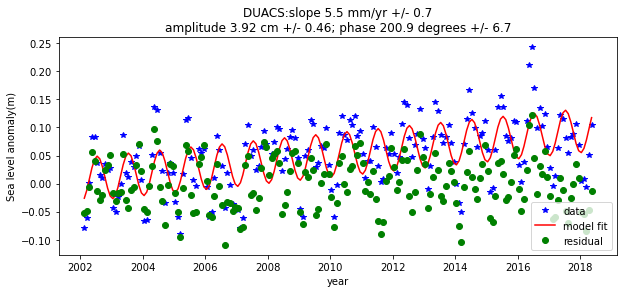

<GeoAxesSubplot:xlabel='time'>

In [70]:
DUACS_curve_fit(ds1,9)

In [160]:
df=ALES_curve_fit_df(ds,0)
df

extract point #0 on track 040
 (trend_ols) 1.slope is 3.337 mm/yr +/- 1.761


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


lat        lon Trend Amplitude   Phase      Valid  Dist_to_coast
0  0.000644  87.169037  0.82      2.70  205.02  25.704809     939.476359

In [162]:
df0=pd.DataFrame()
for i in ds.nbpoints.values:
    df=ALES_curve_fit_df(ds,i)
    df0=df0.append(df,ignore_index=True)

extract point #0 on track 040
 (trend_ols) 1.slope is 3.337 mm/yr +/- 1.761
extract point #1 on track 040
 (trend_ols) 1.slope is 2.993 mm/yr +/- 1.434
extract point #2 on track 040
 (trend_ols) 1.slope is 2.071 mm/yr +/- 1.277


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #3 on track 040
 (trend_ols) 1.slope is 2.478 mm/yr +/- 1.188
extract point #4 on track 040
 (trend_ols) 1.slope is 4.045 mm/yr +/- 1.104
extract point #5 on track 040
 (trend_ols) 1.slope is 2.865 mm/yr +/- 1.117


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #6 on track 040
 (trend_ols) 1.slope is 4.074 mm/yr +/- 1.050
extract point #7 on track 040
 (trend_ols) 1.slope is 3.204 mm/yr +/- 0.987
extract point #8 on track 040
 (trend_ols) 1.slope is 3.576 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #9 on track 040
 (trend_ols) 1.slope is 3.317 mm/yr +/- 0.931
extract point #10 on track 040
 (trend_ols) 1.slope is 3.383 mm/yr +/- 0.909
extract point #11 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus


 (trend_ols) 1.slope is 3.332 mm/yr +/- 0.987
extract point #12 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 0.929
extract point #13 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

 (trend_ols) 1.slope is 4.020 mm/yr +/- 0.910
extract point #14 on track 040
 (trend_ols) 1.slope is 4.241 mm/yr +/- 0.948
extract point #15 on track 040
 (trend_ols) 1.slope is 2.951 mm/yr +/- 0.903


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #16 on track 040
 (trend_ols) 1.slope is 2.811 mm/yr +/- 0.924
extract point #17 on track 040
 (trend_ols) 1.slope is 3.190 mm/yr +/- 0.930
extract point #18 on track 040
 (trend_ols) 1.slope is 2.093 mm/yr +/- 0.970
extract point #19 on track 040
 (trend_ols) 1.slope is 3.550 mm/yr +/- 0.918
extract point #20 on track 040
 (trend_ols) 1.slope is 4.080 mm/yr +/- 0.927


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #21 on track 040
 (trend_ols) 1.slope is 3.334 mm/yr +/- 0.956
extract point #22 on track 040
 (trend_ols) 1.slope is 3.307 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #23 on track 040
 (trend_ols) 1.slope is 2.221 mm/yr +/- 0.948
extract point #24 on track 040
 (trend_ols) 1.slope is 3.557 mm/yr +/- 0.936
extract point #25 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.357 mm/yr +/- 0.969
extract point #26 on track 040
 (trend_ols) 1.slope is 4.144 mm/yr +/- 0.917
extract point #27 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.204 mm/yr +/- 0.946
extract point #28 on track 040
 (trend_ols) 1.slope is 2.549 mm/yr +/- 0.946
extract point #29 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.615 mm/yr +/- 0.929
extract point #30 on track 040
 (trend_ols) 1.slope is 4.139 mm/yr +/- 0.899
extract point #31 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

 (trend_ols) 1.slope is 4.997 mm/yr +/- 0.933
extract point #32 on track 040
 (trend_ols) 1.slope is 3.597 mm/yr +/- 0.913
extract point #33 on track 040
 (trend_ols) 1.slope is 3.810 mm/yr +/- 0.915


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #34 on track 040
 (trend_ols) 1.slope is 2.910 mm/yr +/- 0.975
extract point #35 on track 040
 (trend_ols) 1.slope is 2.101 mm/yr +/- 0.964
extract point #36 on track 040
 (trend_ols) 1.slope is 2.513 mm/yr +/- 1.009
extract point #37 on track 040
 (trend_ols) 1.slope is 3.533 mm/yr +/- 0.890
extract point #38 on track 040
 (trend_ols) 1.slope is 2.929 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #39 on track 040
 (trend_ols) 1.slope is 2.476 mm/yr +/- 0.940
extract point #40 on track 040
 (trend_ols) 1.slope is 3.108 mm/yr +/- 0.957
extract point #41 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.835 mm/yr +/- 0.891
extract point #42 on track 040
 (trend_ols) 1.slope is 2.765 mm/yr +/- 0.941
extract point #43 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus


 (trend_ols) 1.slope is 3.882 mm/yr +/- 0.934
extract point #44 on track 040
 (trend_ols) 1.slope is 3.802 mm/yr +/- 0.930
extract point #45 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.678 mm/yr +/- 0.908
extract point #46 on track 040
 (trend_ols) 1.slope is 2.579 mm/yr +/- 0.881
extract point #47 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

 (trend_ols) 1.slope is 3.258 mm/yr +/- 0.854
extract point #48 on track 040
 (trend_ols) 1.slope is 3.395 mm/yr +/- 0.854
extract point #49 on track 040
 (trend_ols) 1.slope is 3.444 mm/yr +/- 0.931


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #50 on track 040
 (trend_ols) 1.slope is 4.287 mm/yr +/- 0.941
extract point #51 on track 040
 (trend_ols) 1.slope is 2.346 mm/yr +/- 0.916
extract point #52 on track 040
 (trend_ols) 1.slope is 3.626 mm/yr +/- 0.906
extract point #53 on track 040
 (trend_ols) 1.slope is 2.154 mm/yr +/- 0.992
extract point #54 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.519 mm/yr +/- 0.948
extract point #55 on track 040
 (trend_ols) 1.slope is 2.934 mm/yr +/- 0.915
extract point #56 on track 040
 (trend_ols) 1.slope is 2.614 mm/yr +/- 0.956


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #57 on track 040
 (trend_ols) 1.slope is 2.639 mm/yr +/- 0.899
extract point #58 on track 040
 (trend_ols) 1.slope is 3.416 mm/yr +/- 0.938
extract point #59 on track 040
 (trend_ols) 1.slope is 3.054 mm/yr +/- 0.932


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #60 on track 040
 (trend_ols) 1.slope is 2.772 mm/yr +/- 0.931
extract point #61 on track 040
 (trend_ols) 1.slope is 2.266 mm/yr +/- 0.924
extract point #62 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.356 mm/yr +/- 0.937
extract point #63 on track 040
 (trend_ols) 1.slope is 3.192 mm/yr +/- 0.915
extract point #64 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.535 mm/yr +/- 0.927
extract point #65 on track 040
 (trend_ols) 1.slope is 3.442 mm/yr +/- 0.939
extract point #66 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus


 (trend_ols) 1.slope is 2.771 mm/yr +/- 0.897
extract point #67 on track 040
 (trend_ols) 1.slope is 4.102 mm/yr +/- 0.940
extract point #68 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.859 mm/yr +/- 0.961
extract point #69 on track 040
 (trend_ols) 1.slope is 5.586 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #70 on track 040
 (trend_ols) 1.slope is 2.793 mm/yr +/- 0.918
extract point #71 on track 040
 (trend_ols) 1.slope is 4.753 mm/yr +/- 0.881


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #72 on track 040
 (trend_ols) 1.slope is 4.504 mm/yr +/- 0.890
extract point #73 on track 040
 (trend_ols) 1.slope is 4.320 mm/yr +/- 0.957


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #74 on track 040
 (trend_ols) 1.slope is 4.496 mm/yr +/- 0.886
extract point #75 on track 040
 (trend_ols) 1.slope is 3.738 mm/yr +/- 0.905


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #76 on track 040
 (trend_ols) 1.slope is 3.620 mm/yr +/- 0.921
extract point #77 on track 040
 (trend_ols) 1.slope is 3.266 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #78 on track 040
 (trend_ols) 1.slope is 3.478 mm/yr +/- 0.955
extract point #79 on track 040
 (trend_ols) 1.slope is 3.436 mm/yr +/- 0.945


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #80 on track 040
 (trend_ols) 1.slope is 3.314 mm/yr +/- 0.936
extract point #81 on track 040
 (trend_ols) 1.slope is 4.524 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #82 on track 040
 (trend_ols) 1.slope is 3.919 mm/yr +/- 0.958
extract point #83 on track 040
 (trend_ols) 1.slope is 3.981 mm/yr +/- 0.962
extract point #84 on track 040
 (trend_ols) 1.slope is 4.977 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #85 on track 040
 (trend_ols) 1.slope is 4.277 mm/yr +/- 0.943
extract point #86 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.452 mm/yr +/- 0.957
extract point #87 on track 040
 (trend_ols) 1.slope is 3.704 mm/yr +/- 0.926
extract point #88 on track 040
 (trend_ols) 1.slope is 5.212 mm/yr +/- 0.913


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #89 on track 040
 (trend_ols) 1.slope is 3.866 mm/yr +/- 0.972
extract point #90 on track 040
 (trend_ols) 1.slope is 4.974 mm/yr +/- 0.945

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #91 on track 040
 (trend_ols) 1.slope is 4.003 mm/yr +/- 0.916


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #92 on track 040
 (trend_ols) 1.slope is 4.663 mm/yr +/- 0.948
extract point #93 on track 040
 (trend_ols) 1.slope is 3.677 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #94 on track 040
 (trend_ols) 1.slope is 1.778 mm/yr +/- 0.951
extract point #95 on track 040
 (trend_ols) 1.slope is 3.752 mm/yr +/- 0.907


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #96 on track 040
 (trend_ols) 1.slope is 3.481 mm/yr +/- 0.924
extract point #97 on track 040
 (trend_ols) 1.slope is 2.355 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #98 on track 040
 (trend_ols) 1.slope is 3.445 mm/yr +/- 0.929
extract point #99 on track 040
 (trend_ols) 1.slope is 3.543 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #100 on track 040
 (trend_ols) 1.slope is 3.321 mm/yr +/- 0.905
extract point #101 on track 040
 (trend_ols) 1.slope is 3.440 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #102 on track 040
 (trend_ols) 1.slope is 2.496 mm/yr +/- 0.966
extract point #103 on track 040
 (trend_ols) 1.slope is 1.737 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #104 on track 040
 (trend_ols) 1.slope is 1.819 mm/yr +/- 0.936
extract point #105 on track 040
 (trend_ols) 1.slope is 2.719 mm/yr +/- 0.931


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #106 on track 040
 (trend_ols) 1.slope is 2.863 mm/yr +/- 0.950
extract point #107 on track 040
 (trend_ols) 1.slope is 3.613 mm/yr +/- 0.915


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #108 on track 040
 (trend_ols) 1.slope is 2.780 mm/yr +/- 0.991
extract point #109 on track 040
 (trend_ols) 1.slope is 3.058 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #110 on track 040
 (trend_ols) 1.slope is 4.046 mm/yr +/- 0.929
extract point #111 on track 040
 (trend_ols) 1.slope is 2.633 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #112 on track 040
 (trend_ols) 1.slope is 4.311 mm/yr +/- 0.968
extract point #113 on track 040
 (trend_ols) 1.slope is 3.249 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #114 on track 040
 (trend_ols) 1.slope is 3.020 mm/yr +/- 0.942
extract point #115 on track 040
 (trend_ols) 1.slope is 4.024 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #116 on track 040
 (trend_ols) 1.slope is 3.932 mm/yr +/- 0.947
extract point #117 on track 040
 (trend_ols) 1.slope is 3.938 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #118 on track 040
 (trend_ols) 1.slope is 3.559 mm/yr +/- 0.956
extract point #119 on track 040
 (trend_ols) 1.slope is 2.975 mm/yr +/- 0.935


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #120 on track 040
 (trend_ols) 1.slope is 3.881 mm/yr +/- 0.921
extract point #121 on track 040
 (trend_ols) 1.slope is 3.145 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #122 on track 040
 (trend_ols) 1.slope is 5.335 mm/yr +/- 0.960
extract point #123 on track 040
 (trend_ols) 1.slope is 4.010 mm/yr +/- 0.949


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #124 on track 040
 (trend_ols) 1.slope is 4.395 mm/yr +/- 0.911
extract point #125 on track 040
 (trend_ols) 1.slope is 4.375 mm/yr +/- 0.922


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #126 on track 040
 (trend_ols) 1.slope is 4.693 mm/yr +/- 0.951
extract point #127 on track 040
 (trend_ols) 1.slope is 4.359 mm/yr +/- 0.967


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #128 on track 040
 (trend_ols) 1.slope is 4.323 mm/yr +/- 1.015
extract point #129 on track 040
 (trend_ols) 1.slope is 4.901 mm/yr +/- 0.922


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #130 on track 040
 (trend_ols) 1.slope is 4.038 mm/yr +/- 0.971
extract point #131 on track 040
 (trend_ols) 1.slope is 3.481 mm/yr +/- 0.957


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #132 on track 040
 (trend_ols) 1.slope is 3.423 mm/yr +/- 0.967
extract point #133 on track 040
 (trend_ols) 1.slope is 3.265 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #134 on track 040
 (trend_ols) 1.slope is 4.395 mm/yr +/- 0.951
extract point #135 on track 040
 (trend_ols) 1.slope is 3.637 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #136 on track 040
 (trend_ols) 1.slope is 4.470 mm/yr +/- 0.944
extract point #137 on track 040
 (trend_ols) 1.slope is 4.067 mm/yr +/- 0.928


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #138 on track 040
 (trend_ols) 1.slope is 4.454 mm/yr +/- 0.980
extract point #139 on track 040
 (trend_ols) 1.slope is 4.394 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #140 on track 040
 (trend_ols) 1.slope is 3.131 mm/yr +/- 0.963
extract point #141 on track 040
 (trend_ols) 1.slope is 3.380 mm/yr +/- 0.910


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #142 on track 040
 (trend_ols) 1.slope is 3.723 mm/yr +/- 0.970
extract point #143 on track 040
 (trend_ols) 1.slope is 3.458 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #144 on track 040
 (trend_ols) 1.slope is 3.125 mm/yr +/- 0.946
extract point #145 on track 040
 (trend_ols) 1.slope is 3.801 mm/yr +/- 0.895


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #146 on track 040
 (trend_ols) 1.slope is 3.362 mm/yr +/- 0.919
extract point #147 on track 040
 (trend_ols) 1.slope is 3.996 mm/yr +/- 0.908


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #148 on track 040
 (trend_ols) 1.slope is 2.869 mm/yr +/- 0.892
extract point #149 on track 040
 (trend_ols) 1.slope is 4.224 mm/yr +/- 0.956


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #150 on track 040
 (trend_ols) 1.slope is 2.768 mm/yr +/- 0.943
extract point #151 on track 040
 (trend_ols) 1.slope is 2.025 mm/yr +/- 0.932


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #152 on track 040
 (trend_ols) 1.slope is 2.883 mm/yr +/- 0.890
extract point #153 on track 040
 (trend_ols) 1.slope is 3.342 mm/yr +/- 0.905


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #154 on track 040
 (trend_ols) 1.slope is 3.855 mm/yr +/- 0.921
extract point #155 on track 040
 (trend_ols) 1.slope is 5.487 mm/yr +/- 0.918


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #156 on track 040
 (trend_ols) 1.slope is 4.053 mm/yr +/- 0.963
extract point #157 on track 040
 (trend_ols) 1.slope is 3.952 mm/yr +/- 0.999

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #158 on track 040
 (trend_ols) 1.slope is 3.442 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #159 on track 040
 (trend_ols) 1.slope is 3.832 mm/yr +/- 0.937
extract point #160 on track 040
 (trend_ols) 1.slope is 2.348 mm/yr +/- 1.025


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #161 on track 040
 (trend_ols) 1.slope is 3.636 mm/yr +/- 1.009
extract point #162 on track 040
 (trend_ols) 1.slope is 3.544 mm/yr +/- 0.898


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #163 on track 040
 (trend_ols) 1.slope is 3.936 mm/yr +/- 0.941
extract point #164 on track 040
 (trend_ols) 1.slope is 2.369 mm/yr +/- 0.995


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #165 on track 040
 (trend_ols) 1.slope is 1.275 mm/yr +/- 0.996
extract point #166 on track 040
 (trend_ols) 1.slope is 2.518 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #167 on track 040
 (trend_ols) 1.slope is 3.900 mm/yr +/- 1.026
extract point #168 on track 040
 (trend_ols) 1.slope is 2.341 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #169 on track 040
 (trend_ols) 1.slope is 3.173 mm/yr +/- 0.980
extract point #170 on track 040
 (trend_ols) 1.slope is 3.230 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #171 on track 040
 (trend_ols) 1.slope is 4.070 mm/yr +/- 0.991
extract point #172 on track 040
 (trend_ols) 1.slope is 3.769 mm/yr +/- 0.924


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #173 on track 040
 (trend_ols) 1.slope is 2.982 mm/yr +/- 0.985
extract point #174 on track 040
 (trend_ols) 1.slope is 2.579 mm/yr +/- 0.949


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #175 on track 040
 (trend_ols) 1.slope is 3.844 mm/yr +/- 0.918
extract point #176 on track 040
 (trend_ols) 1.slope is 3.999 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #177 on track 040
 (trend_ols) 1.slope is 5.564 mm/yr +/- 0.948
extract point #178 on track 040
 (trend_ols) 1.slope is 5.060 mm/yr +/- 0.946


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #179 on track 040
 (trend_ols) 1.slope is 5.318 mm/yr +/- 0.963
extract point #180 on track 040
 (trend_ols) 1.slope is 5.122 mm/yr +/- 1.006


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #181 on track 040
 (trend_ols) 1.slope is 5.610 mm/yr +/- 0.944
extract point #182 on track 040
 (trend_ols) 1.slope is 3.299 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #183 on track 040
 (trend_ols) 1.slope is 2.981 mm/yr +/- 0.946
extract point #184 on track 040
 (trend_ols) 1.slope is 3.472 mm/yr +/- 0.887


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #185 on track 040
 (trend_ols) 1.slope is 4.182 mm/yr +/- 0.940
extract point #186 on track 040
 (trend_ols) 1.slope is 3.398 mm/yr +/- 0.956


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #187 on track 040
 (trend_ols) 1.slope is 3.470 mm/yr +/- 0.995
extract point #188 on track 040
 (trend_ols) 1.slope is 3.018 mm/yr +/- 0.937


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #189 on track 040
 (trend_ols) 1.slope is 3.397 mm/yr +/- 0.915
extract point #190 on track 040
 (trend_ols) 1.slope is 2.402 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #191 on track 040
 (trend_ols) 1.slope is 3.821 mm/yr +/- 0.956
extract point #192 on track 040
 (trend_ols) 1.slope is 3.036 mm/yr +/- 1.000


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #193 on track 040
 (trend_ols) 1.slope is 3.863 mm/yr +/- 0.948
extract point #194 on track 040
 (trend_ols) 1.slope is 3.489 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #195 on track 040
 (trend_ols) 1.slope is 3.281 mm/yr +/- 0.997
extract point #196 on track 040
 (trend_ols) 1.slope is 3.371 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #197 on track 040
 (trend_ols) 1.slope is 3.492 mm/yr +/- 1.010
extract point #198 on track 040
 (trend_ols) 1.slope is 4.225 mm/yr +/- 0.920


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #199 on track 040
 (trend_ols) 1.slope is 3.977 mm/yr +/- 1.016
extract point #200 on track 040
 (trend_ols) 1.slope is 2.984 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #201 on track 040
 (trend_ols) 1.slope is 3.590 mm/yr +/- 0.962
extract point #202 on track 040
 (trend_ols) 1.slope is 3.729 mm/yr +/- 0.985
extract point #203 on track 040
 (trend_ols) 1.slope is 3.651 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #204 on track 040
 (trend_ols) 1.slope is 4.106 mm/yr +/- 1.002
extract point #205 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.413 mm/yr +/- 0.910
extract point #206 on track 040
 (trend_ols) 1.slope is 2.805 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #207 on track 040
 (trend_ols) 1.slope is 4.175 mm/yr +/- 0.906
extract point #208 on track 040
 (trend_ols) 1.slope is 3.142 mm/yr +/- 0.896


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #209 on track 040
 (trend_ols) 1.slope is 4.715 mm/yr +/- 0.958
extract point #210 on track 040
 (trend_ols) 1.slope is 3.305 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #211 on track 040
 (trend_ols) 1.slope is 4.986 mm/yr +/- 0.943
extract point #212 on track 040
 (trend_ols) 1.slope is 4.594 mm/yr +/- 0.913


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #213 on track 040
 (trend_ols) 1.slope is 3.622 mm/yr +/- 1.012
extract point #214 on track 040
 (trend_ols) 1.slope is 4.120 mm/yr +/- 0.923


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #215 on track 040
 (trend_ols) 1.slope is 4.671 mm/yr +/- 1.022
extract point #216 on track 040
 (trend_ols) 1.slope is 4.851 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #217 on track 040
 (trend_ols) 1.slope is 3.100 mm/yr +/- 0.930
extract point #218 on track 040
 (trend_ols) 1.slope is 2.438 mm/yr +/- 0.939


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #219 on track 040
 (trend_ols) 1.slope is 5.293 mm/yr +/- 0.917
extract point #220 on track 040
 (trend_ols) 1.slope is 3.253 mm/yr +/- 0.949


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #221 on track 040
 (trend_ols) 1.slope is 4.161 mm/yr +/- 0.968
extract point #222 on track 040
 (trend_ols) 1.slope is 4.889 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #223 on track 040
 (trend_ols) 1.slope is 3.004 mm/yr +/- 0.990
extract point #224 on track 040
 (trend_ols) 1.slope is 2.355 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #225 on track 040
 (trend_ols) 1.slope is 3.320 mm/yr +/- 0.971
extract point #226 on track 040
 (trend_ols) 1.slope is 3.843 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #227 on track 040
 (trend_ols) 1.slope is 5.125 mm/yr +/- 0.943
extract point #228 on track 040
 (trend_ols) 1.slope is 3.896 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #229 on track 040
 (trend_ols) 1.slope is 4.531 mm/yr +/- 0.957
extract point #230 on track 040
 (trend_ols) 1.slope is 4.022 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #231 on track 040
 (trend_ols) 1.slope is 4.039 mm/yr +/- 0.997
extract point #232 on track 040
 (trend_ols) 1.slope is 5.008 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #233 on track 040
 (trend_ols) 1.slope is 4.840 mm/yr +/- 0.999
extract point #234 on track 040
 (trend_ols) 1.slope is 4.108 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #235 on track 040
 (trend_ols) 1.slope is 3.495 mm/yr +/- 0.968
extract point #236 on track 040
 (trend_ols) 1.slope is 4.941 mm/yr +/- 0.943


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #237 on track 040
 (trend_ols) 1.slope is 2.872 mm/yr +/- 0.951
extract point #238 on track 040
 (trend_ols) 1.slope is 5.002 mm/yr +/- 0.935


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #239 on track 040
 (trend_ols) 1.slope is 3.264 mm/yr +/- 0.922
extract point #240 on track 040
 (trend_ols) 1.slope is 1.832 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #241 on track 040
 (trend_ols) 1.slope is 3.902 mm/yr +/- 0.997
extract point #242 on track 040
 (trend_ols) 1.slope is 4.520 mm/yr +/- 0.953


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #243 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 0.991
extract point #244 on track 040
 (trend_ols) 1.slope is 4.639 mm/yr +/- 0.934


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #245 on track 040
 (trend_ols) 1.slope is 2.566 mm/yr +/- 0.904
extract point #246 on track 040
 (trend_ols) 1.slope is 4.448 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #247 on track 040
 (trend_ols) 1.slope is 5.012 mm/yr +/- 0.960
extract point #248 on track 040
 (trend_ols) 1.slope is 3.713 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #249 on track 040
 (trend_ols) 1.slope is 3.019 mm/yr +/- 0.889
extract point #250 on track 040
 (trend_ols) 1.slope is 4.416 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #251 on track 040
 (trend_ols) 1.slope is 4.505 mm/yr +/- 0.929
extract point #252 on track 040
 (trend_ols) 1.slope is 3.511 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #253 on track 040
 (trend_ols) 1.slope is 3.609 mm/yr +/- 0.931
extract point #254 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 0.929


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #255 on track 040
 (trend_ols) 1.slope is 4.158 mm/yr +/- 0.934
extract point #256 on track 040
 (trend_ols) 1.slope is 4.199 mm/yr +/- 0.940


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #257 on track 040
 (trend_ols) 1.slope is 4.666 mm/yr +/- 0.940
extract point #258 on track 040
 (trend_ols) 1.slope is 4.611 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #259 on track 040
 (trend_ols) 1.slope is 5.103 mm/yr +/- 0.887
extract point #260 on track 040
 (trend_ols) 1.slope is 4.640 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #261 on track 040
 (trend_ols) 1.slope is 4.894 mm/yr +/- 0.927
extract point #262 on track 040
 (trend_ols) 1.slope is 5.066 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #263 on track 040
 (trend_ols) 1.slope is 5.223 mm/yr +/- 0.976
extract point #264 on track 040
 (trend_ols) 1.slope is 3.324 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #265 on track 040
 (trend_ols) 1.slope is 3.070 mm/yr +/- 0.977
extract point #266 on track 040
 (trend_ols) 1.slope is 4.948 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #267 on track 040
 (trend_ols) 1.slope is 5.212 mm/yr +/- 1.000
extract point #268 on track 040
 (trend_ols) 1.slope is 5.297 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #269 on track 040
 (trend_ols) 1.slope is 4.825 mm/yr +/- 0.936
extract point #270 on track 040
 (trend_ols) 1.slope is 3.258 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #271 on track 040
 (trend_ols) 1.slope is 3.192 mm/yr +/- 0.922
extract point #272 on track 040
 (trend_ols) 1.slope is 2.672 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #273 on track 040
 (trend_ols) 1.slope is 3.353 mm/yr +/- 0.925
extract point #274 on track 040
 (trend_ols) 1.slope is 2.622 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #275 on track 040
 (trend_ols) 1.slope is 2.220 mm/yr +/- 0.985
extract point #276 on track 040
 (trend_ols) 1.slope is 1.610 mm/yr +/- 0.959


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #277 on track 040
 (trend_ols) 1.slope is 3.164 mm/yr +/- 0.873
extract point #278 on track 040
 (trend_ols) 1.slope is 1.917 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #279 on track 040
 (trend_ols) 1.slope is 3.271 mm/yr +/- 0.954
extract point #280 on track 040
 (trend_ols) 1.slope is 2.799 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #281 on track 040
 (trend_ols) 1.slope is 3.362 mm/yr +/- 0.951
extract point #282 on track 040
 (trend_ols) 1.slope is 3.760 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #283 on track 040
 (trend_ols) 1.slope is 2.289 mm/yr +/- 0.955
extract point #284 on track 040
 (trend_ols) 1.slope is 2.812 mm/yr +/- 0.958


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #285 on track 040
 (trend_ols) 1.slope is 3.725 mm/yr +/- 0.936
extract point #286 on track 040
 (trend_ols) 1.slope is 3.655 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #287 on track 040
 (trend_ols) 1.slope is 4.264 mm/yr +/- 1.022
extract point #288 on track 040
 (trend_ols) 1.slope is 4.338 mm/yr +/- 0.970


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #289 on track 040
 (trend_ols) 1.slope is 3.160 mm/yr +/- 0.992
extract point #290 on track 040
 (trend_ols) 1.slope is 4.436 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #291 on track 040
 (trend_ols) 1.slope is 4.137 mm/yr +/- 1.022
extract point #292 on track 040
 (trend_ols) 1.slope is 5.091 mm/yr +/- 0.983


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #293 on track 040
 (trend_ols) 1.slope is 4.943 mm/yr +/- 0.951
extract point #294 on track 040
 (trend_ols) 1.slope is 4.347 mm/yr +/- 0.902


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #295 on track 040
 (trend_ols) 1.slope is 3.592 mm/yr +/- 0.926
extract point #296 on track 040
 (trend_ols) 1.slope is 3.993 mm/yr +/- 0.914


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #297 on track 040
 (trend_ols) 1.slope is 3.985 mm/yr +/- 0.978
extract point #298 on track 040
 (trend_ols) 1.slope is 3.630 mm/yr +/- 0.934


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #299 on track 040
 (trend_ols) 1.slope is 3.063 mm/yr +/- 0.946
extract point #300 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 0.956


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #301 on track 040
 (trend_ols) 1.slope is 3.141 mm/yr +/- 1.048
extract point #302 on track 040
 (trend_ols) 1.slope is 4.339 mm/yr +/- 0.940
extract point #303 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.032 mm/yr +/- 0.926
extract point #304 on track 040
 (trend_ols) 1.slope is 5.084 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #305 on track 040
 (trend_ols) 1.slope is 2.982 mm/yr +/- 1.022
extract point #306 on track 040
 (trend_ols) 1.slope is 4.357 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #307 on track 040
 (trend_ols) 1.slope is 3.693 mm/yr +/- 0.983
extract point #308 on track 040
 (trend_ols) 1.slope is 4.877 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #309 on track 040
 (trend_ols) 1.slope is 3.343 mm/yr +/- 0.946
extract point #310 on track 040
 (trend_ols) 1.slope is 3.672 mm/yr +/- 0.984


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #311 on track 040
 (trend_ols) 1.slope is 4.564 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #312 on track 040
 (trend_ols) 1.slope is 3.477 mm/yr +/- 0.943
extract point #313 on track 040
 (trend_ols) 1.slope is 2.653 mm/yr +/- 0.941


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #314 on track 040
 (trend_ols) 1.slope is 4.135 mm/yr +/- 0.973
extract point #315 on track 040
 (trend_ols) 1.slope is 2.178 mm/yr +/- 0.924


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #316 on track 040
 (trend_ols) 1.slope is 4.240 mm/yr +/- 0.997
extract point #317 on track 040
 (trend_ols) 1.slope is 4.205 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #318 on track 040
 (trend_ols) 1.slope is 3.790 mm/yr +/- 0.955
extract point #319 on track 040
 (trend_ols) 1.slope is 2.494 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #320 on track 040
 (trend_ols) 1.slope is 4.557 mm/yr +/- 0.954
extract point #321 on track 040
 (trend_ols) 1.slope is 2.706 mm/yr +/- 0.950


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #322 on track 040
 (trend_ols) 1.slope is 3.442 mm/yr +/- 0.991
extract point #323 on track 040
 (trend_ols) 1.slope is 3.432 mm/yr +/- 0.996
extract point #324 on track 040
 (trend_ols) 1.slope is 3.966 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #325 on track 040
 (trend_ols) 1.slope is 3.968 mm/yr +/- 0.979
extract point #326 on track 040
 (trend_ols) 1.slope is 4.189 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #327 on track 040
 (trend_ols) 1.slope is 3.125 mm/yr +/- 0.973
extract point #328 on track 040
 (trend_ols) 1.slope is 3.858 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #329 on track 040
 (trend_ols) 1.slope is 3.412 mm/yr +/- 1.037
extract point #330 on track 040
 (trend_ols) 1.slope is 5.035 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #331 on track 040
 (trend_ols) 1.slope is 3.764 mm/yr +/- 0.949
extract point #332 on track 040
 (trend_ols) 1.slope is 2.646 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #333 on track 040
 (trend_ols) 1.slope is 4.036 mm/yr +/- 0.954
extract point #334 on track 040
 (trend_ols) 1.slope is 2.817 mm/yr +/- 0.957


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #335 on track 040
 (trend_ols) 1.slope is 4.054 mm/yr +/- 0.996
extract point #336 on track 040
 (trend_ols) 1.slope is 3.978 mm/yr +/- 0.934
extract point #337 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.939 mm/yr +/- 0.951
extract point #338 on track 040
 (trend_ols) 1.slope is 4.104 mm/yr +/- 0.941


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #339 on track 040
 (trend_ols) 1.slope is 2.576 mm/yr +/- 0.916
extract point #340 on track 040
 (trend_ols) 1.slope is 3.243 mm/yr +/- 0.977


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #341 on track 040
 (trend_ols) 1.slope is 3.562 mm/yr +/- 1.002
extract point #342 on track 040
 (trend_ols) 1.slope is 4.931 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #343 on track 040
 (trend_ols) 1.slope is 3.915 mm/yr +/- 0.966
extract point #344 on track 040
 (trend_ols) 1.slope is 2.675 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #345 on track 040
 (trend_ols) 1.slope is 4.936 mm/yr +/- 0.992
extract point #346 on track 040
 (trend_ols) 1.slope is 2.737 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #347 on track 040
 (trend_ols) 1.slope is 2.971 mm/yr +/- 1.002
extract point #348 on track 040
 (trend_ols) 1.slope is 4.304 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #349 on track 040
 (trend_ols) 1.slope is 4.464 mm/yr +/- 1.020
extract point #350 on track 040
 (trend_ols) 1.slope is 3.702 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #351 on track 040
 (trend_ols) 1.slope is 3.459 mm/yr +/- 1.007
extract point #352 on track 040
 (trend_ols) 1.slope is 4.109 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #353 on track 040
 (trend_ols) 1.slope is 3.783 mm/yr +/- 0.968
extract point #354 on track 040
 (trend_ols) 1.slope is 2.329 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #355 on track 040
 (trend_ols) 1.slope is 3.276 mm/yr +/- 0.957
extract point #356 on track 040
 (trend_ols) 1.slope is 5.233 mm/yr +/- 0.930


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #357 on track 040
 (trend_ols) 1.slope is 2.124 mm/yr +/- 0.992
extract point #358 on track 040
 (trend_ols) 1.slope is 2.869 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #359 on track 040
 (trend_ols) 1.slope is 3.153 mm/yr +/- 0.998
extract point #360 on track 040
 (trend_ols) 1.slope is 3.275 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #361 on track 040
 (trend_ols) 1.slope is 3.318 mm/yr +/- 0.975
extract point #362 on track 040
 (trend_ols) 1.slope is 3.253 mm/yr +/- 0.904


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #363 on track 040
 (trend_ols) 1.slope is 3.011 mm/yr +/- 0.971
extract point #364 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 0.937


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #365 on track 040
 (trend_ols) 1.slope is 3.706 mm/yr +/- 0.899
extract point #366 on track 040
 (trend_ols) 1.slope is 3.354 mm/yr +/- 0.957


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #367 on track 040
 (trend_ols) 1.slope is 2.721 mm/yr +/- 0.974
extract point #368 on track 040
 (trend_ols) 1.slope is 2.403 mm/yr +/- 0.917


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #369 on track 040
 (trend_ols) 1.slope is 2.672 mm/yr +/- 0.939
extract point #370 on track 040
 (trend_ols) 1.slope is 3.175 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #371 on track 040
 (trend_ols) 1.slope is 2.097 mm/yr +/- 0.954
extract point #372 on track 040
 (trend_ols) 1.slope is 2.241 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #373 on track 040
 (trend_ols) 1.slope is 3.656 mm/yr +/- 0.958
extract point #374 on track 040
 (trend_ols) 1.slope is 4.121 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #375 on track 040
 (trend_ols) 1.slope is 3.699 mm/yr +/- 0.975
extract point #376 on track 040
 (trend_ols) 1.slope is 3.730 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #377 on track 040
 (trend_ols) 1.slope is 2.412 mm/yr +/- 0.911
extract point #378 on track 040
 (trend_ols) 1.slope is 2.938 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #379 on track 040
 (trend_ols) 1.slope is 4.347 mm/yr +/- 0.895
extract point #380 on track 040
 (trend_ols) 1.slope is 2.619 mm/yr +/- 0.977


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #381 on track 040
 (trend_ols) 1.slope is 3.986 mm/yr +/- 0.969
extract point #382 on track 040
 (trend_ols) 1.slope is 3.375 mm/yr +/- 0.942


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #383 on track 040
 (trend_ols) 1.slope is 2.521 mm/yr +/- 0.948
extract point #384 on track 040
 (trend_ols) 1.slope is 3.647 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #385 on track 040
 (trend_ols) 1.slope is 1.939 mm/yr +/- 0.904
extract point #386 on track 040
 (trend_ols) 1.slope is 2.352 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #387 on track 040
 (trend_ols) 1.slope is 4.588 mm/yr +/- 0.965
extract point #388 on track 040
 (trend_ols) 1.slope is 4.490 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #389 on track 040
 (trend_ols) 1.slope is 3.313 mm/yr +/- 0.981
extract point #390 on track 040
 (trend_ols) 1.slope is 3.117 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #391 on track 040
 (trend_ols) 1.slope is 3.524 mm/yr +/- 0.988
extract point #392 on track 040
 (trend_ols) 1.slope is 2.232 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #393 on track 040
 (trend_ols) 1.slope is 2.692 mm/yr +/- 0.942
extract point #394 on track 040
 (trend_ols) 1.slope is 3.179 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #395 on track 040
 (trend_ols) 1.slope is 3.703 mm/yr +/- 1.065
extract point #396 on track 040
 (trend_ols) 1.slope is 3.050 mm/yr +/- 0.971


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #397 on track 040
 (trend_ols) 1.slope is 3.279 mm/yr +/- 0.981
extract point #398 on track 040
 (trend_ols) 1.slope is 4.134 mm/yr +/- 0.943


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #399 on track 040
 (trend_ols) 1.slope is 3.237 mm/yr +/- 0.991
extract point #400 on track 040
 (trend_ols) 1.slope is 4.220 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #401 on track 040
 (trend_ols) 1.slope is 3.190 mm/yr +/- 0.991
extract point #402 on track 040
 (trend_ols) 1.slope is 4.067 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #403 on track 040
 (trend_ols) 1.slope is 3.850 mm/yr +/- 1.008
extract point #404 on track 040
 (trend_ols) 1.slope is 3.367 mm/yr +/- 0.989
extract point #405 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.404 mm/yr +/- 1.014
extract point #406 on track 040
 (trend_ols) 1.slope is 3.470 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #407 on track 040
 (trend_ols) 1.slope is 4.407 mm/yr +/- 1.056
extract point #408 on track 040
 (trend_ols) 1.slope is 3.065 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #409 on track 040
 (trend_ols) 1.slope is 3.700 mm/yr +/- 0.930
extract point #410 on track 040
 (trend_ols) 1.slope is 2.725 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #411 on track 040
 (trend_ols) 1.slope is 3.318 mm/yr +/- 1.018
extract point #412 on track 040
 (trend_ols) 1.slope is 3.723 mm/yr +/- 0.940


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #413 on track 040
 (trend_ols) 1.slope is 2.911 mm/yr +/- 0.923
extract point #414 on track 040
 (trend_ols) 1.slope is 3.723 mm/yr +/- 0.967


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #415 on track 040
 (trend_ols) 1.slope is 3.334 mm/yr +/- 0.978
extract point #416 on track 040
 (trend_ols) 1.slope is 2.265 mm/yr +/- 0.938


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #417 on track 040
 (trend_ols) 1.slope is 3.926 mm/yr +/- 0.996
extract point #418 on track 040
 (trend_ols) 1.slope is 3.651 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #419 on track 040
 (trend_ols) 1.slope is 4.037 mm/yr +/- 1.016
extract point #420 on track 040
 (trend_ols) 1.slope is 2.617 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #421 on track 040
 (trend_ols) 1.slope is 4.376 mm/yr +/- 0.962
extract point #422 on track 040
 (trend_ols) 1.slope is 3.355 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #423 on track 040
 (trend_ols) 1.slope is 4.098 mm/yr +/- 0.954
extract point #424 on track 040
 (trend_ols) 1.slope is 3.635 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #425 on track 040
 (trend_ols) 1.slope is 3.692 mm/yr +/- 0.949
extract point #426 on track 040
 (trend_ols) 1.slope is 4.080 mm/yr +/- 0.970

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #427 on track 040
 (trend_ols) 1.slope is 5.117 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #428 on track 040
 (trend_ols) 1.slope is 3.341 mm/yr +/- 0.939
extract point #429 on track 040
 (trend_ols) 1.slope is 4.008 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #430 on track 040
 (trend_ols) 1.slope is 3.508 mm/yr +/- 0.989
extract point #431 on track 040
 (trend_ols) 1.slope is 5.032 mm/yr +/- 0.946


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #432 on track 040
 (trend_ols) 1.slope is 3.979 mm/yr +/- 0.952
extract point #433 on track 040
 (trend_ols) 1.slope is 3.643 mm/yr +/- 0.911


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #434 on track 040
 (trend_ols) 1.slope is 3.527 mm/yr +/- 0.939
extract point #435 on track 040
 (trend_ols) 1.slope is 4.423 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #436 on track 040
 (trend_ols) 1.slope is 4.210 mm/yr +/- 0.965
extract point #437 on track 040
 (trend_ols) 1.slope is 3.778 mm/yr +/- 0.943


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #438 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 0.884
extract point #439 on track 040
 (trend_ols) 1.slope is 3.451 mm/yr +/- 0.989


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #440 on track 040
 (trend_ols) 1.slope is 3.264 mm/yr +/- 0.942
extract point #441 on track 040
 (trend_ols) 1.slope is 3.751 mm/yr +/- 0.951
extract point #442 on track 040
 (trend_ols) 1.slope is 3.661 mm/yr +/- 0.950


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #443 on track 040
 (trend_ols) 1.slope is 3.953 mm/yr +/- 0.941
extract point #444 on track 040
 (trend_ols) 1.slope is 3.692 mm/yr +/- 0.937


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #445 on track 040
 (trend_ols) 1.slope is 3.259 mm/yr +/- 0.982
extract point #446 on track 040
 (trend_ols) 1.slope is 3.572 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #447 on track 040
 (trend_ols) 1.slope is 2.888 mm/yr +/- 0.908
extract point #448 on track 040
 (trend_ols) 1.slope is 2.759 mm/yr +/- 0.916


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #449 on track 040
 (trend_ols) 1.slope is 3.097 mm/yr +/- 0.953
extract point #450 on track 040
 (trend_ols) 1.slope is 2.491 mm/yr +/- 0.945


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #451 on track 040
 (trend_ols) 1.slope is 3.174 mm/yr +/- 0.961
extract point #452 on track 040
 (trend_ols) 1.slope is 3.616 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #453 on track 040
 (trend_ols) 1.slope is 3.261 mm/yr +/- 0.938
extract point #454 on track 040
 (trend_ols) 1.slope is 2.711 mm/yr +/- 0.871


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #455 on track 040
 (trend_ols) 1.slope is 4.140 mm/yr +/- 0.918
extract point #456 on track 040
 (trend_ols) 1.slope is 3.766 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #457 on track 040
 (trend_ols) 1.slope is 5.555 mm/yr +/- 1.022
extract point #458 on track 040
 (trend_ols) 1.slope is 4.799 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #459 on track 040
 (trend_ols) 1.slope is 2.391 mm/yr +/- 0.991
extract point #460 on track 040
 (trend_ols) 1.slope is 4.034 mm/yr +/- 0.942


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #461 on track 040
 (trend_ols) 1.slope is 4.296 mm/yr +/- 0.949
extract point #462 on track 040
 (trend_ols) 1.slope is 3.621 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #463 on track 040
 (trend_ols) 1.slope is 1.632 mm/yr +/- 0.946
extract point #464 on track 040
 (trend_ols) 1.slope is 2.685 mm/yr +/- 0.957


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #465 on track 040
 (trend_ols) 1.slope is 2.542 mm/yr +/- 0.976
extract point #466 on track 040
 (trend_ols) 1.slope is 2.718 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #467 on track 040
 (trend_ols) 1.slope is 2.607 mm/yr +/- 0.949
extract point #468 on track 040
 (trend_ols) 1.slope is 2.877 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #469 on track 040
 (trend_ols) 1.slope is 3.545 mm/yr +/- 1.012
extract point #470 on track 040
 (trend_ols) 1.slope is 2.258 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #471 on track 040
 (trend_ols) 1.slope is 2.622 mm/yr +/- 0.953
extract point #472 on track 040
 (trend_ols) 1.slope is 4.269 mm/yr +/- 0.937


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #473 on track 040
 (trend_ols) 1.slope is 3.064 mm/yr +/- 0.904
extract point #474 on track 040
 (trend_ols) 1.slope is 3.767 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #475 on track 040
 (trend_ols) 1.slope is 4.419 mm/yr +/- 0.968
extract point #476 on track 040
 (trend_ols) 1.slope is 2.733 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #477 on track 040
 (trend_ols) 1.slope is 3.938 mm/yr +/- 0.957
extract point #478 on track 040
 (trend_ols) 1.slope is 3.118 mm/yr +/- 0.975


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #479 on track 040
 (trend_ols) 1.slope is 3.817 mm/yr +/- 0.965
extract point #480 on track 040
 (trend_ols) 1.slope is 2.538 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #481 on track 040
 (trend_ols) 1.slope is 3.660 mm/yr +/- 0.974
extract point #482 on track 040
 (trend_ols) 1.slope is 4.464 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #483 on track 040
 (trend_ols) 1.slope is 3.775 mm/yr +/- 0.959
extract point #484 on track 040
 (trend_ols) 1.slope is 2.604 mm/yr +/- 0.921


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #485 on track 040
 (trend_ols) 1.slope is 3.875 mm/yr +/- 0.932
extract point #486 on track 040
 (trend_ols) 1.slope is 4.226 mm/yr +/- 0.925


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #487 on track 040
 (trend_ols) 1.slope is 3.010 mm/yr +/- 0.959
extract point #488 on track 040
 (trend_ols) 1.slope is 4.737 mm/yr +/- 0.939


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #489 on track 040
 (trend_ols) 1.slope is 3.243 mm/yr +/- 0.931
extract point #490 on track 040
 (trend_ols) 1.slope is 3.210 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #491 on track 040
 (trend_ols) 1.slope is 3.565 mm/yr +/- 0.952
extract point #492 on track 040
 (trend_ols) 1.slope is 3.534 mm/yr +/- 0.934


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #493 on track 040
 (trend_ols) 1.slope is 3.918 mm/yr +/- 0.964
extract point #494 on track 040
 (trend_ols) 1.slope is 2.823 mm/yr +/- 0.900


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #495 on track 040
 (trend_ols) 1.slope is 3.320 mm/yr +/- 0.945
extract point #496 on track 040
 (trend_ols) 1.slope is 2.549 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #497 on track 040
 (trend_ols) 1.slope is 2.489 mm/yr +/- 0.889
extract point #498 on track 040
 (trend_ols) 1.slope is 2.786 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #499 on track 040
 (trend_ols) 1.slope is 3.762 mm/yr +/- 1.000
extract point #500 on track 040
 (trend_ols) 1.slope is 4.844 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #501 on track 040
 (trend_ols) 1.slope is 3.985 mm/yr +/- 0.999
extract point #502 on track 040
 (trend_ols) 1.slope is 3.318 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #503 on track 040
 (trend_ols) 1.slope is 3.027 mm/yr +/- 0.966
extract point #504 on track 040
 (trend_ols) 1.slope is 4.018 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #505 on track 040
 (trend_ols) 1.slope is 4.043 mm/yr +/- 1.059
extract point #506 on track 040
 (trend_ols) 1.slope is 2.528 mm/yr +/- 0.967


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #507 on track 040
 (trend_ols) 1.slope is 3.063 mm/yr +/- 0.918
extract point #508 on track 040
 (trend_ols) 1.slope is 3.297 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #509 on track 040
 (trend_ols) 1.slope is 3.768 mm/yr +/- 1.016
extract point #510 on track 040
 (trend_ols) 1.slope is 3.519 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #511 on track 040
 (trend_ols) 1.slope is 2.929 mm/yr +/- 0.937
extract point #512 on track 040
 (trend_ols) 1.slope is 4.001 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #513 on track 040
 (trend_ols) 1.slope is 4.185 mm/yr +/- 0.935
extract point #514 on track 040
 (trend_ols) 1.slope is 4.557 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #515 on track 040
 (trend_ols) 1.slope is 3.308 mm/yr +/- 0.956
extract point #516 on track 040
 (trend_ols) 1.slope is 4.601 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #517 on track 040
 (trend_ols) 1.slope is 4.160 mm/yr +/- 0.954
extract point #518 on track 040
 (trend_ols) 1.slope is 3.341 mm/yr +/- 0.921


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #519 on track 040
 (trend_ols) 1.slope is 2.894 mm/yr +/- 0.916
extract point #520 on track 040
 (trend_ols) 1.slope is 2.475 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #521 on track 040
 (trend_ols) 1.slope is 3.008 mm/yr +/- 0.937
extract point #522 on track 040
 (trend_ols) 1.slope is 3.723 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #523 on track 040
 (trend_ols) 1.slope is 2.371 mm/yr +/- 0.979
extract point #524 on track 040
 (trend_ols) 1.slope is 3.755 mm/yr +/- 0.991
extract point #525 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus


 (trend_ols) 1.slope is 2.765 mm/yr +/- 0.998
extract point #526 on track 040
 (trend_ols) 1.slope is 3.369 mm/yr +/- 0.929


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #527 on track 040
 (trend_ols) 1.slope is 2.927 mm/yr +/- 0.957
extract point #528 on track 040
 (trend_ols) 1.slope is 2.664 mm/yr +/- 0.984


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #529 on track 040
 (trend_ols) 1.slope is 2.139 mm/yr +/- 0.941
extract point #530 on track 040
 (trend_ols) 1.slope is 3.135 mm/yr +/- 0.939


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #531 on track 040
 (trend_ols) 1.slope is 4.118 mm/yr +/- 0.923
extract point #532 on track 040
 (trend_ols) 1.slope is 2.856 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #533 on track 040
 (trend_ols) 1.slope is 3.711 mm/yr +/- 0.884
extract point #534 on track 040
 (trend_ols) 1.slope is 3.057 mm/yr +/- 0.916


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #535 on track 040
 (trend_ols) 1.slope is 3.397 mm/yr +/- 0.937
extract point #536 on track 040
 (trend_ols) 1.slope is 2.630 mm/yr +/- 0.902


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #537 on track 040
 (trend_ols) 1.slope is 3.369 mm/yr +/- 0.908
extract point #538 on track 040
 (trend_ols) 1.slope is 2.489 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #539 on track 040
 (trend_ols) 1.slope is 3.390 mm/yr +/- 0.967
extract point #540 on track 040
 (trend_ols) 1.slope is 3.715 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #541 on track 040
 (trend_ols) 1.slope is 3.247 mm/yr +/- 0.942
extract point #542 on track 040
 (trend_ols) 1.slope is 2.963 mm/yr +/- 0.929


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #543 on track 040
 (trend_ols) 1.slope is 2.732 mm/yr +/- 0.975
extract point #544 on track 040
 (trend_ols) 1.slope is 3.095 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #545 on track 040
 (trend_ols) 1.slope is 2.166 mm/yr +/- 0.962
extract point #546 on track 040
 (trend_ols) 1.slope is 3.294 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #547 on track 040
 (trend_ols) 1.slope is 2.111 mm/yr +/- 0.976
extract point #548 on track 040
 (trend_ols) 1.slope is 1.386 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #549 on track 040
 (trend_ols) 1.slope is 1.952 mm/yr +/- 0.938
extract point #550 on track 040
 (trend_ols) 1.slope is 2.711 mm/yr +/- 0.898


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #551 on track 040
 (trend_ols) 1.slope is 1.847 mm/yr +/- 0.933
extract point #552 on track 040
 (trend_ols) 1.slope is 2.287 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #553 on track 040
 (trend_ols) 1.slope is 2.595 mm/yr +/- 0.897
extract point #554 on track 040
 (trend_ols) 1.slope is 3.057 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #555 on track 040
 (trend_ols) 1.slope is 3.211 mm/yr +/- 0.933
extract point #556 on track 040
 (trend_ols) 1.slope is 3.495 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #557 on track 040
 (trend_ols) 1.slope is 2.835 mm/yr +/- 0.892
extract point #558 on track 040
 (trend_ols) 1.slope is 3.276 mm/yr +/- 0.967


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #559 on track 040
 (trend_ols) 1.slope is 3.183 mm/yr +/- 0.945
extract point #560 on track 040
 (trend_ols) 1.slope is 1.767 mm/yr +/- 0.938


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #561 on track 040
 (trend_ols) 1.slope is 2.690 mm/yr +/- 0.961
extract point #562 on track 040
 (trend_ols) 1.slope is 1.390 mm/yr +/- 0.984


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #563 on track 040
 (trend_ols) 1.slope is 2.224 mm/yr +/- 0.880
extract point #564 on track 040
 (trend_ols) 1.slope is 3.049 mm/yr +/- 0.935
extract point #565 on track 040
 (trend_ols) 1.slope is 2.053 mm/yr +/- 0.949


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #566 on track 040
 (trend_ols) 1.slope is 2.914 mm/yr +/- 0.921
extract point #567 on track 040
 (trend_ols) 1.slope is 3.203 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #568 on track 040
 (trend_ols) 1.slope is 2.072 mm/yr +/- 0.973
extract point #569 on track 040
 (trend_ols) 1.slope is 2.954 mm/yr +/- 0.959


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #570 on track 040
 (trend_ols) 1.slope is 3.032 mm/yr +/- 0.948
extract point #571 on track 040
 (trend_ols) 1.slope is 3.298 mm/yr +/- 0.907


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #572 on track 040
 (trend_ols) 1.slope is 3.171 mm/yr +/- 0.959
extract point #573 on track 040
 (trend_ols) 1.slope is 2.892 mm/yr +/- 0.927


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #574 on track 040
 (trend_ols) 1.slope is 2.319 mm/yr +/- 0.972
extract point #575 on track 040
 (trend_ols) 1.slope is 3.306 mm/yr +/- 0.929


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #576 on track 040
 (trend_ols) 1.slope is 2.478 mm/yr +/- 0.981
extract point #577 on track 040
 (trend_ols) 1.slope is 1.470 mm/yr +/- 0.919


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #578 on track 040
 (trend_ols) 1.slope is 3.428 mm/yr +/- 0.972
extract point #579 on track 040
 (trend_ols) 1.slope is 2.341 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #580 on track 040
 (trend_ols) 1.slope is 2.468 mm/yr +/- 0.950
extract point #581 on track 040
 (trend_ols) 1.slope is 3.876 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #582 on track 040
 (trend_ols) 1.slope is 2.483 mm/yr +/- 0.896
extract point #583 on track 040
 (trend_ols) 1.slope is 1.945 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #584 on track 040
 (trend_ols) 1.slope is 2.453 mm/yr +/- 0.902
extract point #585 on track 040
 (trend_ols) 1.slope is 0.912 mm/yr +/- 0.892


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #586 on track 040
 (trend_ols) 1.slope is 4.207 mm/yr +/- 0.977
extract point #587 on track 040
 (trend_ols) 1.slope is 2.322 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #588 on track 040
 (trend_ols) 1.slope is 2.715 mm/yr +/- 0.909
extract point #589 on track 040
 (trend_ols) 1.slope is 2.839 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #590 on track 040
 (trend_ols) 1.slope is 3.521 mm/yr +/- 0.938
extract point #591 on track 040
 (trend_ols) 1.slope is 2.067 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #592 on track 040
 (trend_ols) 1.slope is 4.046 mm/yr +/- 0.942
extract point #593 on track 040
 (trend_ols) 1.slope is 3.175 mm/yr +/- 0.931


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #594 on track 040
 (trend_ols) 1.slope is 3.594 mm/yr +/- 0.917
extract point #595 on track 040
 (trend_ols) 1.slope is 4.203 mm/yr +/- 0.894


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #596 on track 040
 (trend_ols) 1.slope is 3.387 mm/yr +/- 0.949
extract point #597 on track 040
 (trend_ols) 1.slope is 3.138 mm/yr +/- 0.925


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #598 on track 040
 (trend_ols) 1.slope is 3.080 mm/yr +/- 0.971
extract point #599 on track 040
 (trend_ols) 1.slope is 2.712 mm/yr +/- 0.877


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #600 on track 040
 (trend_ols) 1.slope is 2.729 mm/yr +/- 0.943
extract point #601 on track 040
 (trend_ols) 1.slope is 4.763 mm/yr +/- 0.913


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #602 on track 040
 (trend_ols) 1.slope is 3.198 mm/yr +/- 0.906
extract point #603 on track 040
 (trend_ols) 1.slope is 2.204 mm/yr +/- 0.934


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #604 on track 040
 (trend_ols) 1.slope is 4.363 mm/yr +/- 0.928
extract point #605 on track 040
 (trend_ols) 1.slope is 1.658 mm/yr +/- 0.929


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #606 on track 040
 (trend_ols) 1.slope is 3.414 mm/yr +/- 0.986
extract point #607 on track 040
 (trend_ols) 1.slope is 2.464 mm/yr +/- 0.940


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #608 on track 040
 (trend_ols) 1.slope is 3.046 mm/yr +/- 0.887
extract point #609 on track 040
 (trend_ols) 1.slope is 3.051 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #610 on track 040
 (trend_ols) 1.slope is 2.221 mm/yr +/- 0.917
extract point #611 on track 040
 (trend_ols) 1.slope is 2.222 mm/yr +/- 0.906


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #612 on track 040
 (trend_ols) 1.slope is 3.572 mm/yr +/- 0.931
extract point #613 on track 040
 (trend_ols) 1.slope is 2.625 mm/yr +/- 0.934


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #614 on track 040
 (trend_ols) 1.slope is 1.511 mm/yr +/- 0.884
extract point #615 on track 040
 (trend_ols) 1.slope is 2.626 mm/yr +/- 0.935


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #616 on track 040
 (trend_ols) 1.slope is 3.474 mm/yr +/- 0.860
extract point #617 on track 040
 (trend_ols) 1.slope is 2.973 mm/yr +/- 0.884


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #618 on track 040
 (trend_ols) 1.slope is 2.890 mm/yr +/- 0.893
extract point #619 on track 040
 (trend_ols) 1.slope is 3.069 mm/yr +/- 0.924


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #620 on track 040
 (trend_ols) 1.slope is 2.237 mm/yr +/- 0.951
extract point #621 on track 040
 (trend_ols) 1.slope is 1.550 mm/yr +/- 0.937


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #622 on track 040
 (trend_ols) 1.slope is 3.003 mm/yr +/- 0.988
extract point #623 on track 040
 (trend_ols) 1.slope is 3.103 mm/yr +/- 0.921


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #624 on track 040
 (trend_ols) 1.slope is 2.583 mm/yr +/- 0.939
extract point #625 on track 040
 (trend_ols) 1.slope is 2.671 mm/yr +/- 0.876


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #626 on track 040
 (trend_ols) 1.slope is 3.107 mm/yr +/- 0.917
extract point #627 on track 040
 (trend_ols) 1.slope is 2.526 mm/yr +/- 0.896


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #628 on track 040
 (trend_ols) 1.slope is 3.071 mm/yr +/- 0.994
extract point #629 on track 040
 (trend_ols) 1.slope is 2.821 mm/yr +/- 0.934


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #630 on track 040
 (trend_ols) 1.slope is 1.935 mm/yr +/- 0.911
extract point #631 on track 040
 (trend_ols) 1.slope is 4.169 mm/yr +/- 0.880


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #632 on track 040
 (trend_ols) 1.slope is 2.450 mm/yr +/- 0.936
extract point #633 on track 040
 (trend_ols) 1.slope is 3.342 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #634 on track 040
 (trend_ols) 1.slope is 3.683 mm/yr +/- 0.895
extract point #635 on track 040
 (trend_ols) 1.slope is 2.995 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #636 on track 040
 (trend_ols) 1.slope is 3.682 mm/yr +/- 0.992
extract point #637 on track 040
 (trend_ols) 1.slope is 3.799 mm/yr +/- 0.886


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #638 on track 040
 (trend_ols) 1.slope is 3.510 mm/yr +/- 0.928
extract point #639 on track 040
 (trend_ols) 1.slope is 2.605 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #640 on track 040
 (trend_ols) 1.slope is 4.254 mm/yr +/- 0.914
extract point #641 on track 040
 (trend_ols) 1.slope is 3.261 mm/yr +/- 0.904


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #642 on track 040
 (trend_ols) 1.slope is 2.899 mm/yr +/- 0.953
extract point #643 on track 040
 (trend_ols) 1.slope is 2.665 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #644 on track 040
 (trend_ols) 1.slope is 2.827 mm/yr +/- 0.970
extract point #645 on track 040
 (trend_ols) 1.slope is 2.394 mm/yr +/- 0.895


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #646 on track 040
 (trend_ols) 1.slope is 3.108 mm/yr +/- 1.001
extract point #647 on track 040
 (trend_ols) 1.slope is 2.645 mm/yr +/- 0.891


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #648 on track 040
 (trend_ols) 1.slope is 1.505 mm/yr +/- 0.912
extract point #649 on track 040
 (trend_ols) 1.slope is 2.358 mm/yr +/- 0.903
extract point #650 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.478 mm/yr +/- 0.958
extract point #651 on track 040
 (trend_ols) 1.slope is 1.456 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #652 on track 040
 (trend_ols) 1.slope is 1.417 mm/yr +/- 0.930
extract point #653 on track 040
 (trend_ols) 1.slope is 3.069 mm/yr +/- 0.929


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #654 on track 040
 (trend_ols) 1.slope is 3.471 mm/yr +/- 0.943
extract point #655 on track 040
 (trend_ols) 1.slope is 3.465 mm/yr +/- 0.921


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #656 on track 040
 (trend_ols) 1.slope is 2.090 mm/yr +/- 0.906
extract point #657 on track 040
 (trend_ols) 1.slope is 3.151 mm/yr +/- 0.908


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #658 on track 040
 (trend_ols) 1.slope is 3.883 mm/yr +/- 0.923
extract point #659 on track 040
 (trend_ols) 1.slope is 2.172 mm/yr +/- 0.997


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #660 on track 040
 (trend_ols) 1.slope is 3.868 mm/yr +/- 0.901
extract point #661 on track 040
 (trend_ols) 1.slope is 3.188 mm/yr +/- 0.945


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #662 on track 040
 (trend_ols) 1.slope is 3.098 mm/yr +/- 0.895
extract point #663 on track 040
 (trend_ols) 1.slope is 2.919 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #664 on track 040
 (trend_ols) 1.slope is 5.013 mm/yr +/- 0.941
extract point #665 on track 040
 (trend_ols) 1.slope is 4.104 mm/yr +/- 0.927


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #666 on track 040
 (trend_ols) 1.slope is 2.947 mm/yr +/- 0.941
extract point #667 on track 040
 (trend_ols) 1.slope is 3.845 mm/yr +/- 0.915


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #668 on track 040
 (trend_ols) 1.slope is 2.559 mm/yr +/- 0.929
extract point #669 on track 040
 (trend_ols) 1.slope is 2.701 mm/yr +/- 0.949


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #670 on track 040
 (trend_ols) 1.slope is 3.710 mm/yr +/- 0.946
extract point #671 on track 040
 (trend_ols) 1.slope is 1.976 mm/yr +/- 0.924


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #672 on track 040
 (trend_ols) 1.slope is 3.787 mm/yr +/- 0.967
extract point #673 on track 040
 (trend_ols) 1.slope is 2.994 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #674 on track 040
 (trend_ols) 1.slope is 1.365 mm/yr +/- 0.948
extract point #675 on track 040
 (trend_ols) 1.slope is 3.117 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #676 on track 040
 (trend_ols) 1.slope is 4.086 mm/yr +/- 0.973
extract point #677 on track 040
 (trend_ols) 1.slope is 3.111 mm/yr +/- 0.911
extract point #678 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.103 mm/yr +/- 0.952
extract point #679 on track 040
 (trend_ols) 1.slope is 3.792 mm/yr +/- 0.926


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #680 on track 040
 (trend_ols) 1.slope is 2.802 mm/yr +/- 0.943
extract point #681 on track 040
 (trend_ols) 1.slope is 3.976 mm/yr +/- 0.934


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #682 on track 040
 (trend_ols) 1.slope is 3.925 mm/yr +/- 0.869
extract point #683 on track 040
 (trend_ols) 1.slope is 3.199 mm/yr +/- 0.866


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #684 on track 040
 (trend_ols) 1.slope is 2.841 mm/yr +/- 0.937
extract point #685 on track 040
 (trend_ols) 1.slope is 2.486 mm/yr +/- 0.923


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #686 on track 040
 (trend_ols) 1.slope is 4.123 mm/yr +/- 0.935
extract point #687 on track 040
 (trend_ols) 1.slope is 2.038 mm/yr +/- 0.941


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #688 on track 040
 (trend_ols) 1.slope is 1.730 mm/yr +/- 0.906
extract point #689 on track 040
 (trend_ols) 1.slope is 3.930 mm/yr +/- 0.887


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #690 on track 040
 (trend_ols) 1.slope is 2.944 mm/yr +/- 0.916
extract point #691 on track 040
 (trend_ols) 1.slope is 3.656 mm/yr +/- 0.959


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #692 on track 040
 (trend_ols) 1.slope is 1.736 mm/yr +/- 0.882
extract point #693 on track 040
 (trend_ols) 1.slope is 3.034 mm/yr +/- 0.927


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #694 on track 040
 (trend_ols) 1.slope is 2.576 mm/yr +/- 0.946
extract point #695 on track 040
 (trend_ols) 1.slope is 3.133 mm/yr +/- 0.915


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #696 on track 040
 (trend_ols) 1.slope is 1.825 mm/yr +/- 0.924
extract point #697 on track 040
 (trend_ols) 1.slope is 3.341 mm/yr +/- 0.921


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #698 on track 040
 (trend_ols) 1.slope is 3.617 mm/yr +/- 0.903
extract point #699 on track 040
 (trend_ols) 1.slope is 3.669 mm/yr +/- 0.942


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #700 on track 040
 (trend_ols) 1.slope is 4.250 mm/yr +/- 0.917
extract point #701 on track 040
 (trend_ols) 1.slope is 2.917 mm/yr +/- 0.959


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #702 on track 040
 (trend_ols) 1.slope is 3.629 mm/yr +/- 0.921
extract point #703 on track 040
 (trend_ols) 1.slope is 2.852 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #704 on track 040
 (trend_ols) 1.slope is 5.114 mm/yr +/- 0.938
extract point #705 on track 040
 (trend_ols) 1.slope is 1.327 mm/yr +/- 0.930


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #706 on track 040
 (trend_ols) 1.slope is 4.201 mm/yr +/- 0.904
extract point #707 on track 040
 (trend_ols) 1.slope is 3.530 mm/yr +/- 0.941


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #708 on track 040
 (trend_ols) 1.slope is 2.731 mm/yr +/- 0.954
extract point #709 on track 040
 (trend_ols) 1.slope is 3.177 mm/yr +/- 0.943


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #710 on track 040
 (trend_ols) 1.slope is 2.187 mm/yr +/- 0.953
extract point #711 on track 040
 (trend_ols) 1.slope is 2.397 mm/yr +/- 0.935


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #712 on track 040
 (trend_ols) 1.slope is 3.748 mm/yr +/- 0.933
extract point #713 on track 040
 (trend_ols) 1.slope is 2.983 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #714 on track 040
 (trend_ols) 1.slope is 1.387 mm/yr +/- 0.940
extract point #715 on track 040
 (trend_ols) 1.slope is 3.418 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #716 on track 040
 (trend_ols) 1.slope is 2.856 mm/yr +/- 0.924
extract point #717 on track 040
 (trend_ols) 1.slope is 2.490 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #718 on track 040
 (trend_ols) 1.slope is 2.616 mm/yr +/- 0.922
extract point #719 on track 040
 (trend_ols) 1.slope is 2.950 mm/yr +/- 0.941


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #720 on track 040
 (trend_ols) 1.slope is 3.008 mm/yr +/- 0.967
extract point #721 on track 040
 (trend_ols) 1.slope is 3.478 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #722 on track 040
 (trend_ols) 1.slope is 3.947 mm/yr +/- 0.973
extract point #723 on track 040
 (trend_ols) 1.slope is 4.567 mm/yr +/- 0.964
extract point #724 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.671 mm/yr +/- 0.945
extract point #725 on track 040
 (trend_ols) 1.slope is 4.731 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #726 on track 040
 (trend_ols) 1.slope is 5.055 mm/yr +/- 0.963
extract point #727 on track 040
 (trend_ols) 1.slope is 3.090 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #728 on track 040
 (trend_ols) 1.slope is 3.982 mm/yr +/- 0.954
extract point #729 on track 040
 (trend_ols) 1.slope is 3.568 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #730 on track 040
 (trend_ols) 1.slope is 2.951 mm/yr +/- 0.952
extract point #731 on track 040
 (trend_ols) 1.slope is 3.112 mm/yr +/- 0.928


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #732 on track 040
 (trend_ols) 1.slope is 4.481 mm/yr +/- 0.918
extract point #733 on track 040
 (trend_ols) 1.slope is 3.320 mm/yr +/- 0.925


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #734 on track 040
 (trend_ols) 1.slope is 3.385 mm/yr +/- 0.942
extract point #735 on track 040
 (trend_ols) 1.slope is 2.926 mm/yr +/- 0.923


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #736 on track 040
 (trend_ols) 1.slope is 3.713 mm/yr +/- 0.911
extract point #737 on track 040
 (trend_ols) 1.slope is 4.349 mm/yr +/- 0.926


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #738 on track 040
 (trend_ols) 1.slope is 2.504 mm/yr +/- 0.905
extract point #739 on track 040
 (trend_ols) 1.slope is 2.869 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #740 on track 040
 (trend_ols) 1.slope is 3.844 mm/yr +/- 0.949
extract point #741 on track 040
 (trend_ols) 1.slope is 3.634 mm/yr +/- 0.892


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #742 on track 040
 (trend_ols) 1.slope is 4.066 mm/yr +/- 0.928
extract point #743 on track 040
 (trend_ols) 1.slope is 3.568 mm/yr +/- 0.971
extract point #744 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.288 mm/yr +/- 0.934
extract point #745 on track 040
 (trend_ols) 1.slope is 3.588 mm/yr +/- 0.883


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #746 on track 040
 (trend_ols) 1.slope is 3.341 mm/yr +/- 0.928
extract point #747 on track 040
 (trend_ols) 1.slope is 3.084 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #748 on track 040
 (trend_ols) 1.slope is 2.864 mm/yr +/- 0.896
extract point #749 on track 040
 (trend_ols) 1.slope is 3.524 mm/yr +/- 0.930


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #750 on track 040
 (trend_ols) 1.slope is 2.148 mm/yr +/- 0.994
extract point #751 on track 040
 (trend_ols) 1.slope is 3.519 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #752 on track 040
 (trend_ols) 1.slope is 3.959 mm/yr +/- 0.904
extract point #753 on track 040
 (trend_ols) 1.slope is 3.767 mm/yr +/- 0.925


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #754 on track 040
 (trend_ols) 1.slope is 5.149 mm/yr +/- 0.989
extract point #755 on track 040
 (trend_ols) 1.slope is 4.314 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #756 on track 040
 (trend_ols) 1.slope is 4.434 mm/yr +/- 0.950
extract point #757 on track 040
 (trend_ols) 1.slope is 4.343 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #758 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 0.880
extract point #759 on track 040
 (trend_ols) 1.slope is 3.413 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #760 on track 040
 (trend_ols) 1.slope is 3.400 mm/yr +/- 0.922
extract point #761 on track 040
 (trend_ols) 1.slope is 3.997 mm/yr +/- 0.903


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #762 on track 040
 (trend_ols) 1.slope is 3.326 mm/yr +/- 0.970
extract point #763 on track 040
 (trend_ols) 1.slope is 1.989 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #764 on track 040
 (trend_ols) 1.slope is 3.103 mm/yr +/- 0.916
extract point #765 on track 040
 (trend_ols) 1.slope is 3.211 mm/yr +/- 0.956


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #766 on track 040
 (trend_ols) 1.slope is 3.008 mm/yr +/- 0.941
extract point #767 on track 040
 (trend_ols) 1.slope is 3.473 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #768 on track 040
 (trend_ols) 1.slope is 4.057 mm/yr +/- 0.954
extract point #769 on track 040
 (trend_ols) 1.slope is 2.005 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #770 on track 040
 (trend_ols) 1.slope is 2.689 mm/yr +/- 0.985
extract point #771 on track 040
 (trend_ols) 1.slope is 4.768 mm/yr +/- 0.932


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #772 on track 040
 (trend_ols) 1.slope is 2.307 mm/yr +/- 0.932
extract point #773 on track 040
 (trend_ols) 1.slope is 3.123 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #774 on track 040
 (trend_ols) 1.slope is 3.549 mm/yr +/- 0.884
extract point #775 on track 040
 (trend_ols) 1.slope is 3.936 mm/yr +/- 1.018
extract point #776 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.781 mm/yr +/- 0.944
extract point #777 on track 040
 (trend_ols) 1.slope is 3.326 mm/yr +/- 0.917


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #778 on track 040
 (trend_ols) 1.slope is 3.125 mm/yr +/- 0.948
extract point #779 on track 040
 (trend_ols) 1.slope is 4.873 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #780 on track 040
 (trend_ols) 1.slope is 4.250 mm/yr +/- 0.961
extract point #781 on track 040
 (trend_ols) 1.slope is 3.130 mm/yr +/- 0.942


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #782 on track 040
 (trend_ols) 1.slope is 4.390 mm/yr +/- 0.931
extract point #783 on track 040
 (trend_ols) 1.slope is 4.337 mm/yr +/- 0.938


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #784 on track 040
 (trend_ols) 1.slope is 4.485 mm/yr +/- 0.916
extract point #785 on track 040
 (trend_ols) 1.slope is 3.293 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #786 on track 040
 (trend_ols) 1.slope is 4.855 mm/yr +/- 0.981
extract point #787 on track 040
 (trend_ols) 1.slope is 3.613 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #788 on track 040
 (trend_ols) 1.slope is 3.835 mm/yr +/- 0.973
extract point #789 on track 040
 (trend_ols) 1.slope is 2.381 mm/yr +/- 0.903


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #790 on track 040
 (trend_ols) 1.slope is 3.750 mm/yr +/- 0.966
extract point #791 on track 040
 (trend_ols) 1.slope is 3.818 mm/yr +/- 0.953


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #792 on track 040
 (trend_ols) 1.slope is 1.930 mm/yr +/- 0.912
extract point #793 on track 040
 (trend_ols) 1.slope is 3.781 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #794 on track 040
 (trend_ols) 1.slope is 4.050 mm/yr +/- 0.924
extract point #795 on track 040
 (trend_ols) 1.slope is 2.965 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #796 on track 040
 (trend_ols) 1.slope is 3.916 mm/yr +/- 0.949
extract point #797 on track 040
 (trend_ols) 1.slope is 3.641 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #798 on track 040
 (trend_ols) 1.slope is 3.533 mm/yr +/- 0.964
extract point #799 on track 040
 (trend_ols) 1.slope is 3.814 mm/yr +/- 0.922


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #800 on track 040
 (trend_ols) 1.slope is 2.659 mm/yr +/- 0.966
extract point #801 on track 040
 (trend_ols) 1.slope is 3.143 mm/yr +/- 0.917


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #802 on track 040
 (trend_ols) 1.slope is 4.105 mm/yr +/- 0.960
extract point #803 on track 040
 (trend_ols) 1.slope is 3.681 mm/yr +/- 0.921


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #804 on track 040
 (trend_ols) 1.slope is 2.173 mm/yr +/- 0.917
extract point #805 on track 040
 (trend_ols) 1.slope is 3.998 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #806 on track 040
 (trend_ols) 1.slope is 3.685 mm/yr +/- 0.908
extract point #807 on track 040
 (trend_ols) 1.slope is 4.015 mm/yr +/- 0.911


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #808 on track 040
 (trend_ols) 1.slope is 3.699 mm/yr +/- 0.924
extract point #809 on track 040
 (trend_ols) 1.slope is 4.220 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #810 on track 040
 (trend_ols) 1.slope is 2.130 mm/yr +/- 0.959
extract point #811 on track 040
 (trend_ols) 1.slope is 3.883 mm/yr +/- 1.008


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #812 on track 040
 (trend_ols) 1.slope is 3.939 mm/yr +/- 0.954
extract point #813 on track 040
 (trend_ols) 1.slope is 4.037 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #814 on track 040
 (trend_ols) 1.slope is 3.932 mm/yr +/- 0.924
extract point #815 on track 040
 (trend_ols) 1.slope is 2.836 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #816 on track 040
 (trend_ols) 1.slope is 4.054 mm/yr +/- 0.930
extract point #817 on track 040
 (trend_ols) 1.slope is 4.713 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #818 on track 040
 (trend_ols) 1.slope is 4.723 mm/yr +/- 0.940
extract point #819 on track 040
 (trend_ols) 1.slope is 4.273 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #820 on track 040
 (trend_ols) 1.slope is 4.287 mm/yr +/- 1.014
extract point #821 on track 040
 (trend_ols) 1.slope is 4.370 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #822 on track 040
 (trend_ols) 1.slope is 3.088 mm/yr +/- 0.939
extract point #823 on track 040
 (trend_ols) 1.slope is 3.922 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #824 on track 040
 (trend_ols) 1.slope is 3.483 mm/yr +/- 0.911
extract point #825 on track 040
 (trend_ols) 1.slope is 2.757 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #826 on track 040
 (trend_ols) 1.slope is 2.578 mm/yr +/- 0.971
extract point #827 on track 040
 (trend_ols) 1.slope is 3.401 mm/yr +/- 0.991


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #828 on track 040
 (trend_ols) 1.slope is 3.641 mm/yr +/- 0.983
extract point #829 on track 040
 (trend_ols) 1.slope is 3.786 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #830 on track 040
 (trend_ols) 1.slope is 4.037 mm/yr +/- 1.008
extract point #831 on track 040
 (trend_ols) 1.slope is 3.857 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #832 on track 040
 (trend_ols) 1.slope is 4.414 mm/yr +/- 0.942
extract point #833 on track 040
 (trend_ols) 1.slope is 3.930 mm/yr +/- 0.926


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #834 on track 040
 (trend_ols) 1.slope is 4.216 mm/yr +/- 0.948
extract point #835 on track 040
 (trend_ols) 1.slope is 2.864 mm/yr +/- 0.991


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #836 on track 040
 (trend_ols) 1.slope is 1.686 mm/yr +/- 0.974
extract point #837 on track 040
 (trend_ols) 1.slope is 2.062 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #838 on track 040
 (trend_ols) 1.slope is 2.106 mm/yr +/- 0.976
extract point #839 on track 040
 (trend_ols) 1.slope is 1.623 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #840 on track 040
 (trend_ols) 1.slope is 2.518 mm/yr +/- 0.979
extract point #841 on track 040
 (trend_ols) 1.slope is 3.563 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #842 on track 040
 (trend_ols) 1.slope is 3.611 mm/yr +/- 0.987
extract point #843 on track 040
 (trend_ols) 1.slope is 2.625 mm/yr +/- 0.891


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #844 on track 040
 (trend_ols) 1.slope is 3.869 mm/yr +/- 0.965
extract point #845 on track 040
 (trend_ols) 1.slope is 4.007 mm/yr +/- 0.936


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #846 on track 040
 (trend_ols) 1.slope is 4.416 mm/yr +/- 0.963
extract point #847 on track 040
 (trend_ols) 1.slope is 3.108 mm/yr +/- 0.928


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #848 on track 040
 (trend_ols) 1.slope is 4.502 mm/yr +/- 0.972
extract point #849 on track 040
 (trend_ols) 1.slope is 3.730 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #850 on track 040
 (trend_ols) 1.slope is 3.915 mm/yr +/- 0.960
extract point #851 on track 040
 (trend_ols) 1.slope is 3.565 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #852 on track 040
 (trend_ols) 1.slope is 3.527 mm/yr +/- 0.937
extract point #853 on track 040
 (trend_ols) 1.slope is 2.884 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #854 on track 040
 (trend_ols) 1.slope is 3.757 mm/yr +/- 0.969
extract point #855 on track 040
 (trend_ols) 1.slope is 4.112 mm/yr +/- 0.994


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #856 on track 040
 (trend_ols) 1.slope is 3.227 mm/yr +/- 1.003
extract point #857 on track 040
 (trend_ols) 1.slope is 2.110 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #858 on track 040
 (trend_ols) 1.slope is 2.570 mm/yr +/- 0.940
extract point #859 on track 040
 (trend_ols) 1.slope is 2.713 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #860 on track 040
 (trend_ols) 1.slope is 3.141 mm/yr +/- 0.954
extract point #861 on track 040
 (trend_ols) 1.slope is 4.350 mm/yr +/- 0.937


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #862 on track 040
 (trend_ols) 1.slope is 3.103 mm/yr +/- 0.947
extract point #863 on track 040
 (trend_ols) 1.slope is 3.396 mm/yr +/- 0.919


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #864 on track 040
 (trend_ols) 1.slope is 4.405 mm/yr +/- 0.957
extract point #865 on track 040
 (trend_ols) 1.slope is 4.528 mm/yr +/- 0.989


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #866 on track 040
 (trend_ols) 1.slope is 3.469 mm/yr +/- 0.984
extract point #867 on track 040
 (trend_ols) 1.slope is 4.463 mm/yr +/- 1.003


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #868 on track 040
 (trend_ols) 1.slope is 3.656 mm/yr +/- 0.964
extract point #869 on track 040
 (trend_ols) 1.slope is 3.577 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #870 on track 040
 (trend_ols) 1.slope is 3.724 mm/yr +/- 0.931
extract point #871 on track 040
 (trend_ols) 1.slope is 5.369 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #872 on track 040
 (trend_ols) 1.slope is 4.945 mm/yr +/- 0.968
extract point #873 on track 040
 (trend_ols) 1.slope is 4.689 mm/yr +/- 0.950


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #874 on track 040
 (trend_ols) 1.slope is 3.413 mm/yr +/- 0.925
extract point #875 on track 040
 (trend_ols) 1.slope is 3.923 mm/yr +/- 0.977


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #876 on track 040
 (trend_ols) 1.slope is 3.036 mm/yr +/- 0.995
extract point #877 on track 040
 (trend_ols) 1.slope is 4.270 mm/yr +/- 0.941


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #878 on track 040
 (trend_ols) 1.slope is 3.539 mm/yr +/- 0.967
extract point #879 on track 040
 (trend_ols) 1.slope is 3.132 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #880 on track 040
 (trend_ols) 1.slope is 3.492 mm/yr +/- 0.958
extract point #881 on track 040
 (trend_ols) 1.slope is 4.295 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #882 on track 040
 (trend_ols) 1.slope is 3.620 mm/yr +/- 0.938
extract point #883 on track 040
 (trend_ols) 1.slope is 3.188 mm/yr +/- 0.959


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #884 on track 040
 (trend_ols) 1.slope is 2.471 mm/yr +/- 0.974
extract point #885 on track 040
 (trend_ols) 1.slope is 4.655 mm/yr +/- 0.919


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #886 on track 040
 (trend_ols) 1.slope is 2.577 mm/yr +/- 0.965
extract point #887 on track 040
 (trend_ols) 1.slope is 3.997 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #888 on track 040
 (trend_ols) 1.slope is 2.804 mm/yr +/- 0.965
extract point #889 on track 040
 (trend_ols) 1.slope is 3.371 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #890 on track 040
 (trend_ols) 1.slope is 1.672 mm/yr +/- 0.932
extract point #891 on track 040
 (trend_ols) 1.slope is 2.554 mm/yr +/- 1.018


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #892 on track 040
 (trend_ols) 1.slope is 3.884 mm/yr +/- 0.928
extract point #893 on track 040
 (trend_ols) 1.slope is 3.146 mm/yr +/- 0.971


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #894 on track 040
 (trend_ols) 1.slope is 2.589 mm/yr +/- 0.958
extract point #895 on track 040
 (trend_ols) 1.slope is 3.485 mm/yr +/- 0.957


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #896 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 0.966
extract point #897 on track 040
 (trend_ols) 1.slope is 3.572 mm/yr +/- 0.983


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #898 on track 040
 (trend_ols) 1.slope is 3.282 mm/yr +/- 0.972
extract point #899 on track 040
 (trend_ols) 1.slope is 2.996 mm/yr +/- 0.909


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #900 on track 040
 (trend_ols) 1.slope is 2.515 mm/yr +/- 0.993
extract point #901 on track 040
 (trend_ols) 1.slope is 3.275 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #902 on track 040
 (trend_ols) 1.slope is 2.098 mm/yr +/- 1.007
extract point #903 on track 040
 (trend_ols) 1.slope is 3.296 mm/yr +/- 1.026


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #904 on track 040
 (trend_ols) 1.slope is 3.106 mm/yr +/- 0.976
extract point #905 on track 040
 (trend_ols) 1.slope is 2.445 mm/yr +/- 0.912


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #906 on track 040
 (trend_ols) 1.slope is 2.121 mm/yr +/- 1.008
extract point #907 on track 040
 (trend_ols) 1.slope is 2.987 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #908 on track 040
 (trend_ols) 1.slope is 3.126 mm/yr +/- 0.937
extract point #909 on track 040
 (trend_ols) 1.slope is 4.486 mm/yr +/- 0.953


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #910 on track 040
 (trend_ols) 1.slope is 4.858 mm/yr +/- 0.944
extract point #911 on track 040
 (trend_ols) 1.slope is 2.999 mm/yr +/- 0.958


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #912 on track 040
 (trend_ols) 1.slope is 3.760 mm/yr +/- 0.949
extract point #913 on track 040
 (trend_ols) 1.slope is 1.784 mm/yr +/- 0.922


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #914 on track 040
 (trend_ols) 1.slope is 4.061 mm/yr +/- 0.971
extract point #915 on track 040
 (trend_ols) 1.slope is 3.771 mm/yr +/- 0.950


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #916 on track 040
 (trend_ols) 1.slope is 2.843 mm/yr +/- 0.989
extract point #917 on track 040
 (trend_ols) 1.slope is 3.164 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #918 on track 040
 (trend_ols) 1.slope is 3.695 mm/yr +/- 1.003
extract point #919 on track 040
 (trend_ols) 1.slope is 3.520 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #920 on track 040
 (trend_ols) 1.slope is 2.221 mm/yr +/- 0.914
extract point #921 on track 040
 (trend_ols) 1.slope is 3.555 mm/yr +/- 0.923


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #922 on track 040
 (trend_ols) 1.slope is 1.489 mm/yr +/- 0.954
extract point #923 on track 040
 (trend_ols) 1.slope is 1.967 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #924 on track 040
 (trend_ols) 1.slope is 3.301 mm/yr +/- 0.971
extract point #925 on track 040
 (trend_ols) 1.slope is 3.014 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #926 on track 040
 (trend_ols) 1.slope is 2.902 mm/yr +/- 1.004
extract point #927 on track 040
 (trend_ols) 1.slope is 3.372 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #928 on track 040
 (trend_ols) 1.slope is 4.293 mm/yr +/- 0.997
extract point #929 on track 040
 (trend_ols) 1.slope is 4.166 mm/yr +/- 0.939


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #930 on track 040
 (trend_ols) 1.slope is 3.152 mm/yr +/- 0.973
extract point #931 on track 040
 (trend_ols) 1.slope is 3.030 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #932 on track 040
 (trend_ols) 1.slope is 3.807 mm/yr +/- 0.950
extract point #933 on track 040
 (trend_ols) 1.slope is 3.712 mm/yr +/- 0.997


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #934 on track 040
 (trend_ols) 1.slope is 2.611 mm/yr +/- 0.953
extract point #935 on track 040
 (trend_ols) 1.slope is 2.555 mm/yr +/- 0.983

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #936 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.101 mm/yr +/- 1.038
extract point #937 on track 040
 (trend_ols) 1.slope is 3.176 mm/yr +/- 0.995
extract point #938 on track 040
 (trend_ols) 1.slope is 3.717 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #939 on track 040
 (trend_ols) 1.slope is 4.343 mm/yr +/- 0.965
extract point #940 on track 040
 (trend_ols) 1.slope is 1.696 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #941 on track 040
 (trend_ols) 1.slope is 4.172 mm/yr +/- 0.952
extract point #942 on track 040
 (trend_ols) 1.slope is 1.666 mm/yr +/- 0.942


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #943 on track 040
 (trend_ols) 1.slope is 2.944 mm/yr +/- 1.035
extract point #944 on track 040
 (trend_ols) 1.slope is 1.783 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #945 on track 040
 (trend_ols) 1.slope is 2.936 mm/yr +/- 0.972
extract point #946 on track 040
 (trend_ols) 1.slope is 3.827 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #947 on track 040
 (trend_ols) 1.slope is 3.201 mm/yr +/- 0.950
extract point #948 on track 040
 (trend_ols) 1.slope is 3.677 mm/yr +/- 0.904


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #949 on track 040
 (trend_ols) 1.slope is 4.442 mm/yr +/- 1.031
extract point #950 on track 040
 (trend_ols) 1.slope is 4.330 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #951 on track 040
 (trend_ols) 1.slope is 3.352 mm/yr +/- 0.945


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #952 on track 040
 (trend_ols) 1.slope is 2.991 mm/yr +/- 0.999
extract point #953 on track 040
 (trend_ols) 1.slope is 3.138 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #954 on track 040
 (trend_ols) 1.slope is 2.422 mm/yr +/- 0.989
extract point #955 on track 040
 (trend_ols) 1.slope is 4.839 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #956 on track 040
 (trend_ols) 1.slope is 2.378 mm/yr +/- 0.952
extract point #957 on track 040
 (trend_ols) 1.slope is 3.933 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #958 on track 040
 (trend_ols) 1.slope is 3.486 mm/yr +/- 0.964
extract point #959 on track 040
 (trend_ols) 1.slope is 3.636 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #960 on track 040
 (trend_ols) 1.slope is 2.300 mm/yr +/- 0.946
extract point #961 on track 040
 (trend_ols) 1.slope is 2.085 mm/yr +/- 0.923


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #962 on track 040
 (trend_ols) 1.slope is 3.362 mm/yr +/- 0.928
extract point #963 on track 040
 (trend_ols) 1.slope is 3.023 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #964 on track 040
 (trend_ols) 1.slope is 2.864 mm/yr +/- 0.893
extract point #965 on track 040
 (trend_ols) 1.slope is 2.640 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #966 on track 040
 (trend_ols) 1.slope is 3.677 mm/yr +/- 0.941
extract point #967 on track 040
 (trend_ols) 1.slope is 2.588 mm/yr +/- 0.958


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #968 on track 040
 (trend_ols) 1.slope is 3.637 mm/yr +/- 0.962
extract point #969 on track 040
 (trend_ols) 1.slope is 3.500 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #970 on track 040
 (trend_ols) 1.slope is 2.583 mm/yr +/- 0.952
extract point #971 on track 040
 (trend_ols) 1.slope is 3.676 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #972 on track 040
 (trend_ols) 1.slope is 3.889 mm/yr +/- 0.986
extract point #973 on track 040
 (trend_ols) 1.slope is 2.845 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #974 on track 040
 (trend_ols) 1.slope is 3.461 mm/yr +/- 0.975
extract point #975 on track 040
 (trend_ols) 1.slope is 2.663 mm/yr +/- 0.915


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #976 on track 040
 (trend_ols) 1.slope is 3.412 mm/yr +/- 0.987
extract point #977 on track 040
 (trend_ols) 1.slope is 3.501 mm/yr +/- 0.946


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #978 on track 040
 (trend_ols) 1.slope is 2.819 mm/yr +/- 0.987
extract point #979 on track 040
 (trend_ols) 1.slope is 2.838 mm/yr +/- 0.971


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #980 on track 040
 (trend_ols) 1.slope is 3.565 mm/yr +/- 0.930
extract point #981 on track 040
 (trend_ols) 1.slope is 2.308 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #982 on track 040
 (trend_ols) 1.slope is 3.125 mm/yr +/- 0.927
extract point #983 on track 040
 (trend_ols) 1.slope is 3.794 mm/yr +/- 0.888


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #984 on track 040
 (trend_ols) 1.slope is 4.049 mm/yr +/- 0.914
extract point #985 on track 040
 (trend_ols) 1.slope is 2.808 mm/yr +/- 0.898


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #986 on track 040
 (trend_ols) 1.slope is 2.871 mm/yr +/- 0.969
extract point #987 on track 040
 (trend_ols) 1.slope is 3.302 mm/yr +/- 0.944


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #988 on track 040
 (trend_ols) 1.slope is 3.442 mm/yr +/- 0.939
extract point #989 on track 040
 (trend_ols) 1.slope is 3.989 mm/yr +/- 0.931


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #990 on track 040
 (trend_ols) 1.slope is 3.609 mm/yr +/- 0.912
extract point #991 on track 040
 (trend_ols) 1.slope is 2.987 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #992 on track 040
 (trend_ols) 1.slope is 3.424 mm/yr +/- 0.931
extract point #993 on track 040
 (trend_ols) 1.slope is 3.064 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #994 on track 040
 (trend_ols) 1.slope is 4.393 mm/yr +/- 0.924
extract point #995 on track 040
 (trend_ols) 1.slope is 4.391 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #996 on track 040
 (trend_ols) 1.slope is 2.680 mm/yr +/- 0.959
extract point #997 on track 040
 (trend_ols) 1.slope is 5.025 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #998 on track 040
 (trend_ols) 1.slope is 3.744 mm/yr +/- 0.935
extract point #999 on track 040
 (trend_ols) 1.slope is 3.154 mm/yr +/- 0.971


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1000 on track 040
 (trend_ols) 1.slope is 2.992 mm/yr +/- 0.941
extract point #1001 on track 040
 (trend_ols) 1.slope is 3.099 mm/yr +/- 0.941


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1002 on track 040
 (trend_ols) 1.slope is 4.869 mm/yr +/- 0.954
extract point #1003 on track 040
 (trend_ols) 1.slope is 3.873 mm/yr +/- 0.870


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1004 on track 040
 (trend_ols) 1.slope is 5.362 mm/yr +/- 0.946
extract point #1005 on track 040
 (trend_ols) 1.slope is 4.111 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1006 on track 040
 (trend_ols) 1.slope is 2.983 mm/yr +/- 1.024
extract point #1007 on track 040
 (trend_ols) 1.slope is 2.761 mm/yr +/- 0.925


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1008 on track 040
 (trend_ols) 1.slope is 3.894 mm/yr +/- 0.935
extract point #1009 on track 040
 (trend_ols) 1.slope is 2.109 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1010 on track 040
 (trend_ols) 1.slope is 4.352 mm/yr +/- 0.993
extract point #1011 on track 040
 (trend_ols) 1.slope is 2.781 mm/yr +/- 0.959


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1012 on track 040
 (trend_ols) 1.slope is 5.372 mm/yr +/- 0.982
extract point #1013 on track 040
 (trend_ols) 1.slope is 3.384 mm/yr +/- 0.930


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1014 on track 040
 (trend_ols) 1.slope is 3.895 mm/yr +/- 0.897
extract point #1015 on track 040
 (trend_ols) 1.slope is 2.982 mm/yr +/- 0.949


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #1016 on track 040
 (trend_ols) 1.slope is 4.161 mm/yr +/- 0.959
extract point #1017 on track 040
 (trend_ols) 1.slope is 1.731 mm/yr +/- 0.942
extract point #1018 on track 040
 (trend_ols) 1.slope is 3.264 mm/yr +/- 0.990
extract point #1019 on track 040
 (trend_ols) 1.slope is 3.521 mm/yr +/- 0.938


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1020 on track 040
 (trend_ols) 1.slope is 4.556 mm/yr +/- 0.976
extract point #1021 on track 040
 (trend_ols) 1.slope is 4.184 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1022 on track 040
 (trend_ols) 1.slope is 3.637 mm/yr +/- 0.923
extract point #1023 on track 040
 (trend_ols) 1.slope is 3.441 mm/yr +/- 0.943


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1024 on track 040
 (trend_ols) 1.slope is 4.368 mm/yr +/- 0.965
extract point #1025 on track 040
 (trend_ols) 1.slope is 4.253 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1026 on track 040
 (trend_ols) 1.slope is 3.283 mm/yr +/- 0.953
extract point #1027 on track 040
 (trend_ols) 1.slope is 3.382 mm/yr +/- 0.935


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1028 on track 040
 (trend_ols) 1.slope is 3.795 mm/yr +/- 0.976
extract point #1029 on track 040
 (trend_ols) 1.slope is 4.514 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1030 on track 040
 (trend_ols) 1.slope is 3.079 mm/yr +/- 1.004
extract point #1031 on track 040
 (trend_ols) 1.slope is 3.116 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1032 on track 040
 (trend_ols) 1.slope is 4.078 mm/yr +/- 0.958
extract point #1033 on track 040
 (trend_ols) 1.slope is 3.922 mm/yr +/- 0.963
extract point #1034 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.025 mm/yr +/- 0.985
extract point #1035 on track 040
 (trend_ols) 1.slope is 5.565 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1036 on track 040
 (trend_ols) 1.slope is 4.886 mm/yr +/- 0.987
extract point #1037 on track 040
 (trend_ols) 1.slope is 4.582 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1038 on track 040
 (trend_ols) 1.slope is 4.686 mm/yr +/- 0.961
extract point #1039 on track 040
 (trend_ols) 1.slope is 4.685 mm/yr +/- 0.963

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1040 on track 040
 (trend_ols) 1.slope is 2.434 mm/yr +/- 0.936
extract point #1041 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.401 mm/yr +/- 0.985
extract point #1042 on track 040
 (trend_ols) 1.slope is 5.120 mm/yr +/- 0.922


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1043 on track 040
 (trend_ols) 1.slope is 2.415 mm/yr +/- 0.907
extract point #1044 on track 040
 (trend_ols) 1.slope is 2.463 mm/yr +/- 0.941
extract point #1045 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.910 mm/yr +/- 1.006
extract point #1046 on track 040
 (trend_ols) 1.slope is 4.092 mm/yr +/- 0.950


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1047 on track 040
 (trend_ols) 1.slope is 2.838 mm/yr +/- 0.939
extract point #1048 on track 040
 (trend_ols) 1.slope is 2.655 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1049 on track 040
 (trend_ols) 1.slope is 3.030 mm/yr +/- 0.935
extract point #1050 on track 040
 (trend_ols) 1.slope is 4.580 mm/yr +/- 0.994


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1051 on track 040
 (trend_ols) 1.slope is 3.038 mm/yr +/- 1.003
extract point #1052 on track 040
 (trend_ols) 1.slope is 3.941 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1053 on track 040
 (trend_ols) 1.slope is 3.659 mm/yr +/- 0.959
extract point #1054 on track 040
 (trend_ols) 1.slope is 1.999 mm/yr +/- 0.945


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1055 on track 040
 (trend_ols) 1.slope is 4.471 mm/yr +/- 1.001
extract point #1056 on track 040
 (trend_ols) 1.slope is 3.808 mm/yr +/- 0.998


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1057 on track 040
 (trend_ols) 1.slope is 3.036 mm/yr +/- 0.950
extract point #1058 on track 040
 (trend_ols) 1.slope is 3.410 mm/yr +/- 0.958


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1059 on track 040
 (trend_ols) 1.slope is 3.238 mm/yr +/- 0.957
extract point #1060 on track 040
 (trend_ols) 1.slope is 4.341 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1061 on track 040
 (trend_ols) 1.slope is 4.762 mm/yr +/- 1.006
extract point #1062 on track 040
 (trend_ols) 1.slope is 3.048 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1063 on track 040
 (trend_ols) 1.slope is 3.941 mm/yr +/- 0.969
extract point #1064 on track 040
 (trend_ols) 1.slope is 3.219 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1065 on track 040
 (trend_ols) 1.slope is 3.289 mm/yr +/- 0.949
extract point #1066 on track 040
 (trend_ols) 1.slope is 2.991 mm/yr +/- 0.938


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1067 on track 040
 (trend_ols) 1.slope is 3.224 mm/yr +/- 0.959
extract point #1068 on track 040
 (trend_ols) 1.slope is 2.808 mm/yr +/- 0.959


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1069 on track 040
 (trend_ols) 1.slope is 1.940 mm/yr +/- 0.979
extract point #1070 on track 040
 (trend_ols) 1.slope is 2.527 mm/yr +/- 0.926


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1071 on track 040
 (trend_ols) 1.slope is 2.744 mm/yr +/- 0.953
extract point #1072 on track 040
 (trend_ols) 1.slope is 2.771 mm/yr +/- 0.902


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1073 on track 040
 (trend_ols) 1.slope is 3.305 mm/yr +/- 0.990
extract point #1074 on track 040
 (trend_ols) 1.slope is 4.322 mm/yr +/- 0.867


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1075 on track 040
 (trend_ols) 1.slope is 2.890 mm/yr +/- 0.941
extract point #1076 on track 040
 (trend_ols) 1.slope is 4.766 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1077 on track 040
 (trend_ols) 1.slope is 3.572 mm/yr +/- 0.953
extract point #1078 on track 040
 (trend_ols) 1.slope is 3.391 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1079 on track 040
 (trend_ols) 1.slope is 3.321 mm/yr +/- 0.937
extract point #1080 on track 040
 (trend_ols) 1.slope is 3.640 mm/yr +/- 0.975


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1081 on track 040
 (trend_ols) 1.slope is 2.410 mm/yr +/- 0.961
extract point #1082 on track 040
 (trend_ols) 1.slope is 2.950 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1083 on track 040
 (trend_ols) 1.slope is 3.697 mm/yr +/- 0.924
extract point #1084 on track 040
 (trend_ols) 1.slope is 3.666 mm/yr +/- 0.991


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1085 on track 040
 (trend_ols) 1.slope is 3.266 mm/yr +/- 0.947
extract point #1086 on track 040
 (trend_ols) 1.slope is 3.729 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1087 on track 040
 (trend_ols) 1.slope is 3.190 mm/yr +/- 0.939
extract point #1088 on track 040
 (trend_ols) 1.slope is 3.365 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1089 on track 040
 (trend_ols) 1.slope is 3.478 mm/yr +/- 1.000
extract point #1090 on track 040
 (trend_ols) 1.slope is 3.268 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1091 on track 040
 (trend_ols) 1.slope is 3.043 mm/yr +/- 0.973
extract point #1092 on track 040
 (trend_ols) 1.slope is 2.733 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1093 on track 040
 (trend_ols) 1.slope is 4.130 mm/yr +/- 0.942
extract point #1094 on track 040
 (trend_ols) 1.slope is 3.323 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1095 on track 040
 (trend_ols) 1.slope is 4.371 mm/yr +/- 0.967
extract point #1096 on track 040
 (trend_ols) 1.slope is 4.104 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1097 on track 040
 (trend_ols) 1.slope is 4.061 mm/yr +/- 0.962
extract point #1098 on track 040
 (trend_ols) 1.slope is 3.949 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1099 on track 040
 (trend_ols) 1.slope is 4.167 mm/yr +/- 0.961
extract point #1100 on track 040
 (trend_ols) 1.slope is 2.645 mm/yr +/- 0.885


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1101 on track 040
 (trend_ols) 1.slope is 3.406 mm/yr +/- 0.939
extract point #1102 on track 040
 (trend_ols) 1.slope is 2.739 mm/yr +/- 1.008


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1103 on track 040
 (trend_ols) 1.slope is 3.381 mm/yr +/- 0.939
extract point #1104 on track 040
 (trend_ols) 1.slope is 3.373 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1105 on track 040
 (trend_ols) 1.slope is 3.805 mm/yr +/- 0.930
extract point #1106 on track 040
 (trend_ols) 1.slope is 3.753 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1107 on track 040
 (trend_ols) 1.slope is 3.805 mm/yr +/- 0.975
extract point #1108 on track 040
 (trend_ols) 1.slope is 4.629 mm/yr +/- 0.922


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1109 on track 040
 (trend_ols) 1.slope is 3.806 mm/yr +/- 0.987
extract point #1110 on track 040
 (trend_ols) 1.slope is 2.855 mm/yr +/- 0.929


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1111 on track 040
 (trend_ols) 1.slope is 2.439 mm/yr +/- 0.943
extract point #1112 on track 040
 (trend_ols) 1.slope is 2.917 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1113 on track 040
 (trend_ols) 1.slope is 2.831 mm/yr +/- 0.971
extract point #1114 on track 040
 (trend_ols) 1.slope is 2.539 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1115 on track 040
 (trend_ols) 1.slope is 2.931 mm/yr +/- 0.929
extract point #1116 on track 040
 (trend_ols) 1.slope is 3.660 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1117 on track 040
 (trend_ols) 1.slope is 2.797 mm/yr +/- 0.924
extract point #1118 on track 040
 (trend_ols) 1.slope is 2.811 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1119 on track 040
 (trend_ols) 1.slope is 2.676 mm/yr +/- 1.013
extract point #1120 on track 040
 (trend_ols) 1.slope is 4.380 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1121 on track 040
 (trend_ols) 1.slope is 2.070 mm/yr +/- 0.983
extract point #1122 on track 040
 (trend_ols) 1.slope is 2.826 mm/yr +/- 0.932


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1123 on track 040
 (trend_ols) 1.slope is 3.355 mm/yr +/- 0.953
extract point #1124 on track 040
 (trend_ols) 1.slope is 1.793 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1125 on track 040
 (trend_ols) 1.slope is 1.107 mm/yr +/- 1.027
extract point #1126 on track 040
 (trend_ols) 1.slope is 2.357 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1127 on track 040
 (trend_ols) 1.slope is 2.794 mm/yr +/- 0.974
extract point #1128 on track 040
 (trend_ols) 1.slope is 2.866 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1129 on track 040
 (trend_ols) 1.slope is 4.064 mm/yr +/- 0.953
extract point #1130 on track 040
 (trend_ols) 1.slope is 3.077 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1131 on track 040
 (trend_ols) 1.slope is 4.322 mm/yr +/- 0.928
extract point #1132 on track 040
 (trend_ols) 1.slope is 2.735 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1133 on track 040
 (trend_ols) 1.slope is 2.927 mm/yr +/- 0.954
extract point #1134 on track 040
 (trend_ols) 1.slope is 4.211 mm/yr +/- 0.922


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1135 on track 040
 (trend_ols) 1.slope is 3.333 mm/yr +/- 0.991
extract point #1136 on track 040
 (trend_ols) 1.slope is 3.570 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1137 on track 040
 (trend_ols) 1.slope is 3.619 mm/yr +/- 0.989
extract point #1138 on track 040
 (trend_ols) 1.slope is 2.998 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1139 on track 040
 (trend_ols) 1.slope is 3.642 mm/yr +/- 1.015
extract point #1140 on track 040
 (trend_ols) 1.slope is 3.469 mm/yr +/- 0.977


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1141 on track 040
 (trend_ols) 1.slope is 3.262 mm/yr +/- 0.992
extract point #1142 on track 040
 (trend_ols) 1.slope is 1.850 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1143 on track 040
 (trend_ols) 1.slope is 1.959 mm/yr +/- 0.965
extract point #1144 on track 040
 (trend_ols) 1.slope is 2.666 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1145 on track 040
 (trend_ols) 1.slope is 3.210 mm/yr +/- 0.941
extract point #1146 on track 040
 (trend_ols) 1.slope is 3.780 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1147 on track 040
 (trend_ols) 1.slope is 3.703 mm/yr +/- 0.981
extract point #1148 on track 040
 (trend_ols) 1.slope is 2.562 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1149 on track 040
 (trend_ols) 1.slope is 2.781 mm/yr +/- 1.009
extract point #1150 on track 040
 (trend_ols) 1.slope is 2.307 mm/yr +/- 0.915


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1151 on track 040
 (trend_ols) 1.slope is 3.844 mm/yr +/- 0.978
extract point #1152 on track 040
 (trend_ols) 1.slope is 2.424 mm/yr +/- 0.995


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1153 on track 040
 (trend_ols) 1.slope is 4.079 mm/yr +/- 0.970
extract point #1154 on track 040
 (trend_ols) 1.slope is 2.469 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1155 on track 040
 (trend_ols) 1.slope is 3.202 mm/yr +/- 0.956
extract point #1156 on track 040
 (trend_ols) 1.slope is 3.860 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1157 on track 040
 (trend_ols) 1.slope is 3.246 mm/yr +/- 1.012
extract point #1158 on track 040
 (trend_ols) 1.slope is 3.679 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1159 on track 040
 (trend_ols) 1.slope is 2.632 mm/yr +/- 0.955
extract point #1160 on track 040
 (trend_ols) 1.slope is 2.459 mm/yr +/- 0.989


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1161 on track 040
 (trend_ols) 1.slope is 2.596 mm/yr +/- 0.994
extract point #1162 on track 040
 (trend_ols) 1.slope is 3.733 mm/yr +/- 1.008


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1163 on track 040
 (trend_ols) 1.slope is 3.055 mm/yr +/- 1.014
extract point #1164 on track 040
 (trend_ols) 1.slope is 2.849 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1165 on track 040
 (trend_ols) 1.slope is 5.296 mm/yr +/- 1.023
extract point #1166 on track 040
 (trend_ols) 1.slope is 2.988 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1167 on track 040
 (trend_ols) 1.slope is 1.637 mm/yr +/- 0.974
extract point #1168 on track 040
 (trend_ols) 1.slope is 3.205 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1169 on track 040
 (trend_ols) 1.slope is 3.206 mm/yr +/- 0.941
extract point #1170 on track 040
 (trend_ols) 1.slope is 2.554 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1171 on track 040
 (trend_ols) 1.slope is 3.294 mm/yr +/- 1.010
extract point #1172 on track 040
 (trend_ols) 1.slope is 4.498 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1173 on track 040
 (trend_ols) 1.slope is 4.174 mm/yr +/- 0.963
extract point #1174 on track 040
 (trend_ols) 1.slope is 3.730 mm/yr +/- 0.958


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1175 on track 040
 (trend_ols) 1.slope is 3.795 mm/yr +/- 0.969
extract point #1176 on track 040
 (trend_ols) 1.slope is 2.624 mm/yr +/- 0.937


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1177 on track 040
 (trend_ols) 1.slope is 2.745 mm/yr +/- 0.977
extract point #1178 on track 040
 (trend_ols) 1.slope is 1.669 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1179 on track 040
 (trend_ols) 1.slope is 4.192 mm/yr +/- 0.939


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1180 on track 040
 (trend_ols) 1.slope is 2.981 mm/yr +/- 0.980
extract point #1181 on track 040
 (trend_ols) 1.slope is 4.489 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1182 on track 040
 (trend_ols) 1.slope is 4.399 mm/yr +/- 0.955
extract point #1183 on track 040
 (trend_ols) 1.slope is 3.835 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1184 on track 040
 (trend_ols) 1.slope is 2.109 mm/yr +/- 0.994


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1185 on track 040
 (trend_ols) 1.slope is 3.445 mm/yr +/- 0.956
extract point #1186 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.820 mm/yr +/- 1.004
extract point #1187 on track 040
 (trend_ols) 1.slope is 2.865 mm/yr +/- 1.021
extract point #1188 on track 040
 (trend_ols) 1.slope is 3.035 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1189 on track 040
 (trend_ols) 1.slope is 3.548 mm/yr +/- 0.975
extract point #1190 on track 040
 (trend_ols) 1.slope is 3.301 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1191 on track 040
 (trend_ols) 1.slope is 3.364 mm/yr +/- 0.991


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1192 on track 040
 (trend_ols) 1.slope is 2.466 mm/yr +/- 1.006


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1193 on track 040
 (trend_ols) 1.slope is 3.380 mm/yr +/- 0.995


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1194 on track 040
 (trend_ols) 1.slope is 2.972 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1195 on track 040
 (trend_ols) 1.slope is 3.290 mm/yr +/- 0.949


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1196 on track 040
 (trend_ols) 1.slope is 4.307 mm/yr +/- 0.968
extract point #1197 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.248 mm/yr +/- 0.924
extract point #1198 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.035 mm/yr +/- 1.023
extract point #1199 on track 040
 (trend_ols) 1.slope is 4.154 mm/yr +/- 0.977

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1200 on track 040
 (trend_ols) 1.slope is 4.421 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1201 on track 040
 (trend_ols) 1.slope is 4.005 mm/yr +/- 0.997
extract point #1202 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.719 mm/yr +/- 1.028
extract point #1203 on track 040
 (trend_ols) 1.slope is 3.859 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1204 on track 040
 (trend_ols) 1.slope is 4.027 mm/yr +/- 1.005
extract point #1205 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.498 mm/yr +/- 0.964
extract point #1206 on track 040
 (trend_ols) 1.slope is 1.551 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1207 on track 040
 (trend_ols) 1.slope is 3.010 mm/yr +/- 1.010
extract point #1208 on track 040
 (trend_ols) 1.slope is 4.087 mm/yr +/- 1.022
extract point #1209 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.907 mm/yr +/- 1.028
extract point #1210 on track 040
 (trend_ols) 1.slope is 4.090 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1211 on track 040
 (trend_ols) 1.slope is 2.622 mm/yr +/- 0.925
extract point #1212 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.295 mm/yr +/- 0.959
extract point #1213 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.492 mm/yr +/- 1.012
extract point #1214 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.813 mm/yr +/- 0.975
extract point #1215 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.576 mm/yr +/- 0.975
extract point #1216 on track 040
 (trend_ols) 1.slope is 3.074 mm/yr +/- 0.962
extract point #1217 on track 040
 (trend_ols) 1.slope is 3.452 mm/yr +/- 0.989


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1218 on track 040
 (trend_ols) 1.slope is 3.539 mm/yr +/- 0.949
extract point #1219 on track 040
 (trend_ols) 1.slope is 2.769 mm/yr +/- 0.967


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1220 on track 040
 (trend_ols) 1.slope is 2.842 mm/yr +/- 0.987
extract point #1221 on track 040
 (trend_ols) 1.slope is 3.042 mm/yr +/- 0.940


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1222 on track 040
 (trend_ols) 1.slope is 2.743 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1223 on track 040
 (trend_ols) 1.slope is 2.198 mm/yr +/- 0.989


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1224 on track 040
 (trend_ols) 1.slope is 2.882 mm/yr +/- 0.943
extract point #1225 on track 040
 (trend_ols) 1.slope is 2.836 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1226 on track 040
 (trend_ols) 1.slope is 3.471 mm/yr +/- 0.966
extract point #1227 on track 040
 (trend_ols) 1.slope is 3.028 mm/yr +/- 0.997

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1228 on track 040
 (trend_ols) 1.slope is 4.224 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1229 on track 040
 (trend_ols) 1.slope is 3.091 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1230 on track 040
 (trend_ols) 1.slope is 3.665 mm/yr +/- 0.995
extract point #1231 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.787 mm/yr +/- 1.028
extract point #1232 on track 040
 (trend_ols) 1.slope is 2.444 mm/yr +/- 0.984
extract point #1233 on track 040
 (trend_ols) 1.slope is 1.635 mm/yr +/- 1.034

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1234 on track 040
 (trend_ols) 1.slope is 2.978 mm/yr +/- 1.012
extract point #1235 on track 040
 (trend_ols) 1.slope is 3.491 mm/yr +/- 1.006

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1236 on track 040
 (trend_ols) 1.slope is 3.296 mm/yr +/- 1.012
extract point #1237 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.122 mm/yr +/- 0.966
extract point #1238 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.409 mm/yr +/- 1.008
extract point #1239 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.128 mm/yr +/- 0.991
extract point #1240 on track 040
 (trend_ols) 1.slope is 4.182 mm/yr +/- 1.008
extract point #1241 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.880 mm/yr +/- 0.983
extract point #1242 on track 040
 (trend_ols) 1.slope is 4.447 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1243 on track 040
 (trend_ols) 1.slope is 3.832 mm/yr +/- 1.023
extract point #1244 on track 040
 (trend_ols) 1.slope is 3.245 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1245 on track 040
 (trend_ols) 1.slope is 3.403 mm/yr +/- 1.033
extract point #1246 on track 040
 (trend_ols) 1.slope is 1.653 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1247 on track 040
 (trend_ols) 1.slope is 2.749 mm/yr +/- 1.005
extract point #1248 on track 040
 (trend_ols) 1.slope is 4.170 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1249 on track 040
 (trend_ols) 1.slope is 3.629 mm/yr +/- 0.962
extract point #1250 on track 040
 (trend_ols) 1.slope is 3.738 mm/yr +/- 1.013
extract point #1251 on track 040
 (trend_ols) 1.slope is 3.383 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1252 on track 040
 (trend_ols) 1.slope is 3.712 mm/yr +/- 0.941
extract point #1253 on track 040
 (trend_ols) 1.slope is 3.606 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1254 on track 040
 (trend_ols) 1.slope is 2.846 mm/yr +/- 1.021
extract point #1255 on track 040
 (trend_ols) 1.slope is 4.332 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1256 on track 040
 (trend_ols) 1.slope is 3.835 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1257 on track 040
 (trend_ols) 1.slope is 4.635 mm/yr +/- 0.936
extract point #1258 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.789 mm/yr +/- 1.013
extract point #1259 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.118 mm/yr +/- 0.985
extract point #1260 on track 040
 (trend_ols) 1.slope is 2.612 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1261 on track 040
 (trend_ols) 1.slope is 3.190 mm/yr +/- 1.023
extract point #1262 on track 040
 (trend_ols) 1.slope is 3.731 mm/yr +/- 0.913
extract point #1263 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.329 mm/yr +/- 1.054
extract point #1264 on track 040
 (trend_ols) 1.slope is 2.943 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1265 on track 040
 (trend_ols) 1.slope is 3.096 mm/yr +/- 1.028
extract point #1266 on track 040
 (trend_ols) 1.slope is 4.227 mm/yr +/- 0.997


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1267 on track 040
 (trend_ols) 1.slope is 3.751 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1268 on track 040
 (trend_ols) 1.slope is 3.932 mm/yr +/- 0.994


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1269 on track 040
 (trend_ols) 1.slope is 2.622 mm/yr +/- 0.984
extract point #1270 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.647 mm/yr +/- 0.975
extract point #1271 on track 040
 (trend_ols) 1.slope is 3.700 mm/yr +/- 0.994

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1272 on track 040
 (trend_ols) 1.slope is 4.979 mm/yr +/- 1.015
extract point #1273 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.206 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1274 on track 040
 (trend_ols) 1.slope is 4.088 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1275 on track 040
 (trend_ols) 1.slope is 3.808 mm/yr +/- 0.948
extract point #1276 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.974 mm/yr +/- 1.034
extract point #1277 on track 040
 (trend_ols) 1.slope is 3.496 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1278 on track 040
 (trend_ols) 1.slope is 4.810 mm/yr +/- 0.977
extract point #1279 on track 040
 (trend_ols) 1.slope is 3.518 mm/yr +/- 1.030


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1280 on track 040
 (trend_ols) 1.slope is 4.236 mm/yr +/- 0.955
extract point #1281 on track 040
 (trend_ols) 1.slope is 3.665 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1282 on track 040
 (trend_ols) 1.slope is 4.982 mm/yr +/- 1.031
extract point #1283 on track 040
 (trend_ols) 1.slope is 5.347 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1284 on track 040
 (trend_ols) 1.slope is 2.863 mm/yr +/- 1.000
extract point #1285 on track 040
 (trend_ols) 1.slope is 4.086 mm/yr +/- 1.007
extract point #1286 on track 040
 (trend_ols) 1.slope is 3.495 mm/yr +/- 1.047

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1287 on track 040
 (trend_ols) 1.slope is 3.826 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1288 on track 040
 (trend_ols) 1.slope is 2.755 mm/yr +/- 0.987
extract point #1289 on track 040
 (trend_ols) 1.slope is 3.002 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1290 on track 040
 (trend_ols) 1.slope is 3.702 mm/yr +/- 1.022
extract point #1291 on track 040
 (trend_ols) 1.slope is 4.983 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1292 on track 040
 (trend_ols) 1.slope is 3.111 mm/yr +/- 0.978
extract point #1293 on track 040
 (trend_ols) 1.slope is 3.380 mm/yr +/- 1.003


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1294 on track 040
 (trend_ols) 1.slope is 3.165 mm/yr +/- 1.014
extract point #1295 on track 040
 (trend_ols) 1.slope is 4.340 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1296 on track 040
 (trend_ols) 1.slope is 2.892 mm/yr +/- 1.044
extract point #1297 on track 040
 (trend_ols) 1.slope is 2.148 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1298 on track 040
 (trend_ols) 1.slope is 2.092 mm/yr +/- 1.055
extract point #1299 on track 040
 (trend_ols) 1.slope is 3.304 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1300 on track 040
 (trend_ols) 1.slope is 3.738 mm/yr +/- 1.006
extract point #1301 on track 040
 (trend_ols) 1.slope is 3.493 mm/yr +/- 0.989


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1302 on track 040
 (trend_ols) 1.slope is 2.804 mm/yr +/- 0.959
extract point #1303 on track 040
 (trend_ols) 1.slope is 2.505 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1304 on track 040
 (trend_ols) 1.slope is 2.948 mm/yr +/- 0.974
extract point #1305 on track 040
 (trend_ols) 1.slope is 3.332 mm/yr +/- 1.001
extract point #1306 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

 (trend_ols) 1.slope is 2.956 mm/yr +/- 0.972
extract point #1307 on track 040
 (trend_ols) 1.slope is 2.748 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1308 on track 040
 (trend_ols) 1.slope is 1.935 mm/yr +/- 0.987
extract point #1309 on track 040
 (trend_ols) 1.slope is 2.172 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1310 on track 040
 (trend_ols) 1.slope is 3.158 mm/yr +/- 1.015
extract point #1311 on track 040
 (trend_ols) 1.slope is 3.144 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1312 on track 040
 (trend_ols) 1.slope is 3.298 mm/yr +/- 0.970
extract point #1313 on track 040
 (trend_ols) 1.slope is 2.811 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1314 on track 040
 (trend_ols) 1.slope is 2.059 mm/yr +/- 1.100
extract point #1315 on track 040
 (trend_ols) 1.slope is 4.137 mm/yr +/- 1.034


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1316 on track 040
 (trend_ols) 1.slope is 1.206 mm/yr +/- 1.006
extract point #1317 on track 040
 (trend_ols) 1.slope is 4.317 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1318 on track 040
 (trend_ols) 1.slope is 3.937 mm/yr +/- 0.971
extract point #1319 on track 040
 (trend_ols) 1.slope is 2.791 mm/yr +/- 1.030


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1320 on track 040
 (trend_ols) 1.slope is 2.964 mm/yr +/- 1.016
extract point #1321 on track 040
 (trend_ols) 1.slope is 3.626 mm/yr +/- 1.063


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1322 on track 040
 (trend_ols) 1.slope is 3.784 mm/yr +/- 1.003
extract point #1323 on track 040
 (trend_ols) 1.slope is 2.541 mm/yr +/- 0.960


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1324 on track 040
 (trend_ols) 1.slope is 3.393 mm/yr +/- 1.014
extract point #1325 on track 040
 (trend_ols) 1.slope is 2.248 mm/yr +/- 1.026


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1326 on track 040
 (trend_ols) 1.slope is 3.240 mm/yr +/- 1.015
extract point #1327 on track 040
 (trend_ols) 1.slope is 2.246 mm/yr +/- 0.959
extract point #1328 on track 040
 (trend_ols) 1.slope is 4.140 mm/yr +/- 1.006

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1329 on track 040
 (trend_ols) 1.slope is 3.929 mm/yr +/- 0.986
extract point #1330 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.909 mm/yr +/- 0.960
extract point #1331 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.111 mm/yr +/- 1.000
extract point #1332 on track 040
 (trend_ols) 1.slope is 3.201 mm/yr +/- 0.967
extract point #1333 on track 040
 (trend_ols) 1.slope is 3.128 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #1334 on track 040
 (trend_ols) 1.slope is 2.326 mm/yr +/- 0.999
extract point #1335 on track 040
 (trend_ols) 1.slope is 2.930 mm/yr +/- 1.011
extract point #1336 on track 040
 (trend_ols) 1.slope is 3.600 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1337 on track 040
 (trend_ols) 1.slope is 2.483 mm/yr +/- 1.018


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1338 on track 040
 (trend_ols) 1.slope is 4.153 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1339 on track 040
 (trend_ols) 1.slope is 3.722 mm/yr +/- 0.969
extract point #1340 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.520 mm/yr +/- 1.008
extract point #1341 on track 040
 (trend_ols) 1.slope is 2.614 mm/yr +/- 1.030
extract point #1342 on track 040
 (trend_ols) 1.slope is 2.995 mm/yr +/- 0.971


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1343 on track 040
 (trend_ols) 1.slope is 4.332 mm/yr +/- 1.039
extract point #1344 on track 040
 (trend_ols) 1.slope is 2.476 mm/yr +/- 0.997

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1345 on track 040
 (trend_ols) 1.slope is 2.809 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1346 on track 040
 (trend_ols) 1.slope is 3.707 mm/yr +/- 1.065
extract point #1347 on track 040
 (trend_ols) 1.slope is 3.463 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1348 on track 040
 (trend_ols) 1.slope is 3.781 mm/yr +/- 0.976
extract point #1349 on track 040
 (trend_ols) 1.slope is 3.917 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1350 on track 040
 (trend_ols) 1.slope is 3.950 mm/yr +/- 0.996
extract point #1351 on track 040
 (trend_ols) 1.slope is 4.495 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1352 on track 040
 (trend_ols) 1.slope is 3.755 mm/yr +/- 1.026
extract point #1353 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.502 mm/yr +/- 1.010
extract point #1354 on track 040
 (trend_ols) 1.slope is 3.874 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1355 on track 040
 (trend_ols) 1.slope is 2.595 mm/yr +/- 1.025
extract point #1356 on track 040
 (trend_ols) 1.slope is 4.111 mm/yr +/- 1.048
extract point #1357 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.953 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1358 on track 040
 (trend_ols) 1.slope is 3.557 mm/yr +/- 1.025
extract point #1359 on track 040
 (trend_ols) 1.slope is 2.641 mm/yr +/- 1.012

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1360 on track 040
 (trend_ols) 1.slope is 3.526 mm/yr +/- 0.975

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1361 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.214 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1362 on track 040
 (trend_ols) 1.slope is 3.960 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1363 on track 040
 (trend_ols) 1.slope is 2.941 mm/yr +/- 0.988
extract point #1364 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.497 mm/yr +/- 0.990
extract point #1365 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.643 mm/yr +/- 1.024
extract point #1366 on track 040
 (trend_ols) 1.slope is 3.221 mm/yr +/- 1.014
extract point #1367 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.546 mm/yr +/- 1.019
extract point #1368 on track 040
 (trend_ols) 1.slope is 3.834 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1369 on track 040
 (trend_ols) 1.slope is 3.661 mm/yr +/- 1.018
extract point #1370 on track 040
 (trend_ols) 1.slope is 4.721 mm/yr +/- 1.010
extract point #1371 on track 040
 (trend_ols) 1.slope is 3.442 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1372 on track 040
 (trend_ols) 1.slope is 2.711 mm/yr +/- 0.932
extract point #1373 on track 040
 (trend_ols) 1.slope is 3.660 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1374 on track 040
 (trend_ols) 1.slope is 2.540 mm/yr +/- 1.035
extract point #1375 on track 040
 (trend_ols) 1.slope is 4.246 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1376 on track 040
 (trend_ols) 1.slope is 4.018 mm/yr +/- 1.023
extract point #1377 on track 040
 (trend_ols) 1.slope is 3.452 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1378 on track 040
 (trend_ols) 1.slope is 3.149 mm/yr +/- 1.017
extract point #1379 on track 040
 (trend_ols) 1.slope is 4.059 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1380 on track 040
 (trend_ols) 1.slope is 2.303 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1381 on track 040
 (trend_ols) 1.slope is 2.647 mm/yr +/- 1.024
extract point #1382 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.751 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1383 on track 040
 (trend_ols) 1.slope is 3.383 mm/yr +/- 1.018
extract point #1384 on track 040
 (trend_ols) 1.slope is 2.834 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1385 on track 040
 (trend_ols) 1.slope is 4.208 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1386 on track 040
 (trend_ols) 1.slope is 4.110 mm/yr +/- 1.047


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1387 on track 040
 (trend_ols) 1.slope is 4.034 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1388 on track 040
 (trend_ols) 1.slope is 2.354 mm/yr +/- 1.017
extract point #1389 on track 040
 (trend_ols) 1.slope is 2.627 mm/yr +/- 1.049

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1390 on track 040
 (trend_ols) 1.slope is 3.336 mm/yr +/- 1.008

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1391 on track 040
 (trend_ols) 1.slope is 3.764 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1392 on track 040
 (trend_ols) 1.slope is 2.466 mm/yr +/- 1.025


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1393 on track 040
 (trend_ols) 1.slope is 3.479 mm/yr +/- 1.042


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1394 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1395 on track 040
 (trend_ols) 1.slope is 2.671 mm/yr +/- 1.028


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1396 on track 040
 (trend_ols) 1.slope is 3.161 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1397 on track 040
 (trend_ols) 1.slope is 3.154 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1398 on track 040
 (trend_ols) 1.slope is 3.599 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1399 on track 040
 (trend_ols) 1.slope is 3.249 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1400 on track 040
 (trend_ols) 1.slope is 4.390 mm/yr +/- 0.980
extract point #1401 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.897 mm/yr +/- 1.023
extract point #1402 on track 040
 (trend_ols) 1.slope is 4.866 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1403 on track 040
 (trend_ols) 1.slope is 4.722 mm/yr +/- 1.041


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1404 on track 040
 (trend_ols) 1.slope is 4.928 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1405 on track 040
 (trend_ols) 1.slope is 4.174 mm/yr +/- 1.026
extract point #1406 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.310 mm/yr +/- 1.003
extract point #1407 on track 040
 (trend_ols) 1.slope is 5.623 mm/yr +/- 1.031
extract point #1408 on track 040
 (trend_ols) 1.slope is 3.538 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1409 on track 040
 (trend_ols) 1.slope is 2.816 mm/yr +/- 1.038
extract point #1410 on track 040
 (trend_ols) 1.slope is 3.805 mm/yr +/- 1.058

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1411 on track 040
 (trend_ols) 1.slope is 3.436 mm/yr +/- 1.053


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1412 on track 040
 (trend_ols) 1.slope is 4.601 mm/yr +/- 1.078
extract point #1413 on track 040
 (trend_ols) 1.slope is 4.737 mm/yr +/- 1.079


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1414 on track 040
 (trend_ols) 1.slope is 4.761 mm/yr +/- 1.058
extract point #1415 on track 040
 (trend_ols) 1.slope is 3.986 mm/yr +/- 1.011
extract point #1416 on track 040
 (trend_ols) 1.slope is 4.106 mm/yr +/- 1.042

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1417 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.415 mm/yr +/- 1.059
extract point #1418 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.496 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1419 on track 040
 (trend_ols) 1.slope is 2.663 mm/yr +/- 1.056


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1420 on track 040
 (trend_ols) 1.slope is 4.447 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1421 on track 040
 (trend_ols) 1.slope is 2.949 mm/yr +/- 1.007
extract point #1422 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.325 mm/yr +/- 0.985
extract point #1423 on track 040
 (trend_ols) 1.slope is 3.048 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1424 on track 040
 (trend_ols) 1.slope is 3.915 mm/yr +/- 1.029
extract point #1425 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.972 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1426 on track 040
 (trend_ols) 1.slope is 4.079 mm/yr +/- 0.977


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1427 on track 040
 (trend_ols) 1.slope is 4.104 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1428 on track 040
 (trend_ols) 1.slope is 3.971 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1429 on track 040
 (trend_ols) 1.slope is 3.105 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1430 on track 040
 (trend_ols) 1.slope is 3.915 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1431 on track 040
 (trend_ols) 1.slope is 3.286 mm/yr +/- 1.074
extract point #1432 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.617 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1433 on track 040
 (trend_ols) 1.slope is 3.187 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1434 on track 040
 (trend_ols) 1.slope is 4.398 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1435 on track 040
 (trend_ols) 1.slope is 3.042 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1436 on track 040
 (trend_ols) 1.slope is 3.403 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1437 on track 040
 (trend_ols) 1.slope is 3.253 mm/yr +/- 1.048


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1438 on track 040
 (trend_ols) 1.slope is 2.895 mm/yr +/- 1.062


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1439 on track 040
 (trend_ols) 1.slope is 4.044 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1440 on track 040
 (trend_ols) 1.slope is 2.911 mm/yr +/- 1.101


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1441 on track 040
 (trend_ols) 1.slope is 2.246 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1442 on track 040
 (trend_ols) 1.slope is 4.283 mm/yr +/- 1.076


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1443 on track 040
 (trend_ols) 1.slope is 3.666 mm/yr +/- 1.090


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1444 on track 040
 (trend_ols) 1.slope is 3.783 mm/yr +/- 1.036
extract point #1445 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.896 mm/yr +/- 1.025


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1446 on track 040
 (trend_ols) 1.slope is 3.649 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1447 on track 040
 (trend_ols) 1.slope is 1.842 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1448 on track 040
 (trend_ols) 1.slope is 2.556 mm/yr +/- 1.096


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1449 on track 040
 (trend_ols) 1.slope is 3.833 mm/yr +/- 1.002
extract point #1450 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.482 mm/yr +/- 0.989
extract point #1451 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.491 mm/yr +/- 1.047
extract point #1452 on track 040
 (trend_ols) 1.slope is 4.253 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1453 on track 040
 (trend_ols) 1.slope is 3.735 mm/yr +/- 1.066
extract point #1454 on track 040
 (trend_ols) 1.slope is 5.427 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1455 on track 040
 (trend_ols) 1.slope is 2.424 mm/yr +/- 0.970
extract point #1456 on track 040
 (trend_ols) 1.slope is 3.224 mm/yr +/- 1.036

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1457 on track 040
 (trend_ols) 1.slope is 3.897 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1458 on track 040
 (trend_ols) 1.slope is 3.157 mm/yr +/- 0.980
extract point #1459 on track 040
 (trend_ols) 1.slope is 3.176 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1460 on track 040
 (trend_ols) 1.slope is 3.109 mm/yr +/- 1.007
extract point #1461 on track 040
 (trend_ols) 1.slope is 3.273 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1462 on track 040
 (trend_ols) 1.slope is 4.285 mm/yr +/- 0.998
extract point #1463 on track 040
 (trend_ols) 1.slope is 4.604 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1464 on track 040
 (trend_ols) 1.slope is 4.403 mm/yr +/- 1.028
extract point #1465 on track 040
 (trend_ols) 1.slope is 4.899 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1466 on track 040
 (trend_ols) 1.slope is 5.618 mm/yr +/- 1.117
extract point #1467 on track 040
 (trend_ols) 1.slope is 4.002 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1468 on track 040
 (trend_ols) 1.slope is 4.079 mm/yr +/- 1.037
extract point #1469 on track 040
 (trend_ols) 1.slope is 5.278 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1470 on track 040
 (trend_ols) 1.slope is 3.762 mm/yr +/- 1.006
extract point #1471 on track 040
 (trend_ols) 1.slope is 4.372 mm/yr +/- 1.076


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1472 on track 040
 (trend_ols) 1.slope is 5.023 mm/yr +/- 1.048
extract point #1473 on track 040
 (trend_ols) 1.slope is 4.099 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1474 on track 040
 (trend_ols) 1.slope is 4.523 mm/yr +/- 1.029
extract point #1475 on track 040
 (trend_ols) 1.slope is 3.406 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1476 on track 040
 (trend_ols) 1.slope is 3.697 mm/yr +/- 1.095
extract point #1477 on track 040
 (trend_ols) 1.slope is 3.248 mm/yr +/- 1.056


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1478 on track 040
 (trend_ols) 1.slope is 4.631 mm/yr +/- 0.992
extract point #1479 on track 040
 (trend_ols) 1.slope is 3.396 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1480 on track 040
 (trend_ols) 1.slope is 3.881 mm/yr +/- 1.010
extract point #1481 on track 040
 (trend_ols) 1.slope is 3.494 mm/yr +/- 1.081


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1482 on track 040
 (trend_ols) 1.slope is 4.480 mm/yr +/- 0.993
extract point #1483 on track 040
 (trend_ols) 1.slope is 2.707 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1484 on track 040
 (trend_ols) 1.slope is 3.086 mm/yr +/- 1.036
extract point #1485 on track 040
 (trend_ols) 1.slope is 2.788 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1486 on track 040
 (trend_ols) 1.slope is 2.693 mm/yr +/- 1.106
extract point #1487 on track 040
 (trend_ols) 1.slope is 2.989 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1488 on track 040
 (trend_ols) 1.slope is 2.700 mm/yr +/- 1.016
extract point #1489 on track 040
 (trend_ols) 1.slope is 4.293 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1490 on track 040
 (trend_ols) 1.slope is 3.453 mm/yr +/- 1.063
extract point #1491 on track 040
 (trend_ols) 1.slope is 3.647 mm/yr +/- 1.081


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1492 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 1.071
extract point #1493 on track 040
 (trend_ols) 1.slope is 3.671 mm/yr +/- 1.068


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1494 on track 040
 (trend_ols) 1.slope is 3.884 mm/yr +/- 1.073
extract point #1495 on track 040
 (trend_ols) 1.slope is 3.561 mm/yr +/- 1.042


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1496 on track 040
 (trend_ols) 1.slope is 4.266 mm/yr +/- 1.165
extract point #1497 on track 040
 (trend_ols) 1.slope is 3.580 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1498 on track 040
 (trend_ols) 1.slope is 3.698 mm/yr +/- 1.085
extract point #1499 on track 040
 (trend_ols) 1.slope is 4.655 mm/yr +/- 1.094


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1500 on track 040
 (trend_ols) 1.slope is 3.122 mm/yr +/- 1.044
extract point #1501 on track 040
 (trend_ols) 1.slope is 3.775 mm/yr +/- 1.050


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1502 on track 040
 (trend_ols) 1.slope is 3.893 mm/yr +/- 1.030
extract point #1503 on track 040
 (trend_ols) 1.slope is 4.681 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1504 on track 040
 (trend_ols) 1.slope is 2.802 mm/yr +/- 1.049
extract point #1505 on track 040
 (trend_ols) 1.slope is 4.196 mm/yr +/- 1.061


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1506 on track 040
 (trend_ols) 1.slope is 4.733 mm/yr +/- 1.030
extract point #1507 on track 040
 (trend_ols) 1.slope is 3.725 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1508 on track 040
 (trend_ols) 1.slope is 4.345 mm/yr +/- 1.017
extract point #1509 on track 040
 (trend_ols) 1.slope is 4.302 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1510 on track 040
 (trend_ols) 1.slope is 4.769 mm/yr +/- 1.024
extract point #1511 on track 040
 (trend_ols) 1.slope is 3.723 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1512 on track 040
 (trend_ols) 1.slope is 3.193 mm/yr +/- 1.031
extract point #1513 on track 040
 (trend_ols) 1.slope is 5.661 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1514 on track 040
 (trend_ols) 1.slope is 4.587 mm/yr +/- 0.995
extract point #1515 on track 040
 (trend_ols) 1.slope is 4.398 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1516 on track 040
 (trend_ols) 1.slope is 4.705 mm/yr +/- 0.997
extract point #1517 on track 040
 (trend_ols) 1.slope is 4.231 mm/yr +/- 1.099


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1518 on track 040
 (trend_ols) 1.slope is 3.361 mm/yr +/- 1.135
extract point #1519 on track 040
 (trend_ols) 1.slope is 3.280 mm/yr +/- 0.967


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1520 on track 040
 (trend_ols) 1.slope is 3.858 mm/yr +/- 1.063
extract point #1521 on track 040
 (trend_ols) 1.slope is 4.144 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1522 on track 040
 (trend_ols) 1.slope is 3.691 mm/yr +/- 1.051
extract point #1523 on track 040
 (trend_ols) 1.slope is 2.204 mm/yr +/- 1.089


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1524 on track 040
 (trend_ols) 1.slope is 5.813 mm/yr +/- 1.125
extract point #1525 on track 040
 (trend_ols) 1.slope is 4.234 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1526 on track 040
 (trend_ols) 1.slope is 4.455 mm/yr +/- 1.105
extract point #1527 on track 040
 (trend_ols) 1.slope is 3.775 mm/yr +/- 1.104


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1528 on track 040
 (trend_ols) 1.slope is 3.989 mm/yr +/- 1.087
extract point #1529 on track 040
 (trend_ols) 1.slope is 4.736 mm/yr +/- 1.081


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1530 on track 040
 (trend_ols) 1.slope is 4.263 mm/yr +/- 1.036
extract point #1531 on track 040
 (trend_ols) 1.slope is 5.018 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1532 on track 040
 (trend_ols) 1.slope is 4.385 mm/yr +/- 0.998
extract point #1533 on track 040
 (trend_ols) 1.slope is 4.277 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1534 on track 040
 (trend_ols) 1.slope is 3.866 mm/yr +/- 1.092
extract point #1535 on track 040
 (trend_ols) 1.slope is 3.676 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1536 on track 040
 (trend_ols) 1.slope is 3.206 mm/yr +/- 1.046
extract point #1537 on track 040
 (trend_ols) 1.slope is 3.252 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1538 on track 040
 (trend_ols) 1.slope is 3.945 mm/yr +/- 1.035
extract point #1539 on track 040
 (trend_ols) 1.slope is 3.541 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1540 on track 040
 (trend_ols) 1.slope is 4.045 mm/yr +/- 1.066
extract point #1541 on track 040
 (trend_ols) 1.slope is 4.416 mm/yr +/- 1.057


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1542 on track 040
 (trend_ols) 1.slope is 4.720 mm/yr +/- 1.047
extract point #1543 on track 040
 (trend_ols) 1.slope is 3.889 mm/yr +/- 1.111


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1544 on track 040
 (trend_ols) 1.slope is 5.003 mm/yr +/- 1.029
extract point #1545 on track 040
 (trend_ols) 1.slope is 4.940 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1546 on track 040
 (trend_ols) 1.slope is 3.956 mm/yr +/- 1.014
extract point #1547 on track 040
 (trend_ols) 1.slope is 2.613 mm/yr +/- 1.076


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1548 on track 040
 (trend_ols) 1.slope is 4.848 mm/yr +/- 1.068
extract point #1549 on track 040
 (trend_ols) 1.slope is 5.240 mm/yr +/- 1.111


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1550 on track 040
 (trend_ols) 1.slope is 5.328 mm/yr +/- 1.103
extract point #1551 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.196 mm/yr +/- 1.021
extract point #1552 on track 040
 (trend_ols) 1.slope is 4.741 mm/yr +/- 1.052
extract point #1553 on track 040
 (trend_ols) 1.slope is 4.543 mm/yr +/- 1.014

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1554 on track 040
 (trend_ols) 1.slope is 5.219 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1555 on track 040
 (trend_ols) 1.slope is 6.069 mm/yr +/- 1.033
extract point #1556 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.825 mm/yr +/- 1.030
extract point #1557 on track 040
 (trend_ols) 1.slope is 4.440 mm/yr +/- 1.058


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1558 on track 040
 (trend_ols) 1.slope is 4.700 mm/yr +/- 1.100


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1559 on track 040
 (trend_ols) 1.slope is 4.270 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1560 on track 040
 (trend_ols) 1.slope is 4.721 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1561 on track 040
 (trend_ols) 1.slope is 4.182 mm/yr +/- 1.084


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1562 on track 040
 (trend_ols) 1.slope is 4.028 mm/yr +/- 1.048
extract point #1563 on track 040
 (trend_ols) 1.slope is 3.435 mm/yr +/- 1.072
extract point #1564 on track 040
 (trend_ols) 1.slope is 4.679 mm/yr +/- 1.006


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1565 on track 040
 (trend_ols) 1.slope is 4.197 mm/yr +/- 1.032
extract point #1566 on track 040
 (trend_ols) 1.slope is 3.110 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1567 on track 040
 (trend_ols) 1.slope is 4.215 mm/yr +/- 1.074
extract point #1568 on track 040
 (trend_ols) 1.slope is 3.433 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1569 on track 040
 (trend_ols) 1.slope is 5.068 mm/yr +/- 1.061
extract point #1570 on track 040
 (trend_ols) 1.slope is 2.489 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1571 on track 040
 (trend_ols) 1.slope is 4.239 mm/yr +/- 1.021
extract point #1572 on track 040
 (trend_ols) 1.slope is 4.231 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1573 on track 040
 (trend_ols) 1.slope is 5.616 mm/yr +/- 1.060
extract point #1574 on track 040
 (trend_ols) 1.slope is 4.637 mm/yr +/- 1.055


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1575 on track 040
 (trend_ols) 1.slope is 4.815 mm/yr +/- 1.052
extract point #1576 on track 040
 (trend_ols) 1.slope is 3.256 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1577 on track 040
 (trend_ols) 1.slope is 4.521 mm/yr +/- 1.028
extract point #1578 on track 040
 (trend_ols) 1.slope is 3.096 mm/yr +/- 1.095


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1579 on track 040
 (trend_ols) 1.slope is 4.901 mm/yr +/- 1.093
extract point #1580 on track 040
 (trend_ols) 1.slope is 2.710 mm/yr +/- 1.079


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1581 on track 040
 (trend_ols) 1.slope is 3.025 mm/yr +/- 1.102
extract point #1582 on track 040
 (trend_ols) 1.slope is 5.525 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1583 on track 040
 (trend_ols) 1.slope is 4.595 mm/yr +/- 1.060
extract point #1584 on track 040
 (trend_ols) 1.slope is 4.986 mm/yr +/- 1.030


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1585 on track 040
 (trend_ols) 1.slope is 4.325 mm/yr +/- 1.039
extract point #1586 on track 040
 (trend_ols) 1.slope is 3.377 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1587 on track 040
 (trend_ols) 1.slope is 4.506 mm/yr +/- 1.047
extract point #1588 on track 040
 (trend_ols) 1.slope is 3.774 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1589 on track 040
 (trend_ols) 1.slope is 4.689 mm/yr +/- 1.045
extract point #1590 on track 040
 (trend_ols) 1.slope is 5.167 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1591 on track 040
 (trend_ols) 1.slope is 4.482 mm/yr +/- 1.005
extract point #1592 on track 040
 (trend_ols) 1.slope is 4.385 mm/yr +/- 1.077


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1593 on track 040
 (trend_ols) 1.slope is 4.998 mm/yr +/- 1.030
extract point #1594 on track 040
 (trend_ols) 1.slope is 4.662 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1595 on track 040
 (trend_ols) 1.slope is 3.731 mm/yr +/- 0.995
extract point #1596 on track 040
 (trend_ols) 1.slope is 4.581 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1597 on track 040
 (trend_ols) 1.slope is 3.817 mm/yr +/- 1.058
extract point #1598 on track 040
 (trend_ols) 1.slope is 4.044 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1599 on track 040
 (trend_ols) 1.slope is 3.777 mm/yr +/- 1.067
extract point #1600 on track 040
 (trend_ols) 1.slope is 4.468 mm/yr +/- 1.079


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1601 on track 040
 (trend_ols) 1.slope is 4.838 mm/yr +/- 1.073
extract point #1602 on track 040
 (trend_ols) 1.slope is 4.256 mm/yr +/- 1.111


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1603 on track 040
 (trend_ols) 1.slope is 4.137 mm/yr +/- 1.059
extract point #1604 on track 040
 (trend_ols) 1.slope is 3.301 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1605 on track 040
 (trend_ols) 1.slope is 3.071 mm/yr +/- 1.087
extract point #1606 on track 040
 (trend_ols) 1.slope is 4.449 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1607 on track 040
 (trend_ols) 1.slope is 4.511 mm/yr +/- 0.997
extract point #1608 on track 040
 (trend_ols) 1.slope is 5.455 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1609 on track 040
 (trend_ols) 1.slope is 3.590 mm/yr +/- 1.049
extract point #1610 on track 040
 (trend_ols) 1.slope is 3.741 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1611 on track 040
 (trend_ols) 1.slope is 5.856 mm/yr +/- 1.007
extract point #1612 on track 040
 (trend_ols) 1.slope is 3.541 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1613 on track 040
 (trend_ols) 1.slope is 3.522 mm/yr +/- 1.025
extract point #1614 on track 040
 (trend_ols) 1.slope is 5.410 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1615 on track 040
 (trend_ols) 1.slope is 3.118 mm/yr +/- 1.008
extract point #1616 on track 040
 (trend_ols) 1.slope is 3.916 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1617 on track 040
 (trend_ols) 1.slope is 4.074 mm/yr +/- 1.009
extract point #1618 on track 040
 (trend_ols) 1.slope is 3.945 mm/yr +/- 1.073
extract point #1619 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.982 mm/yr +/- 0.970
extract point #1620 on track 040
 (trend_ols) 1.slope is 5.024 mm/yr +/- 1.025


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1621 on track 040
 (trend_ols) 1.slope is 3.832 mm/yr +/- 1.096
extract point #1622 on track 040
 (trend_ols) 1.slope is 5.118 mm/yr +/- 1.057


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1623 on track 040
 (trend_ols) 1.slope is 4.004 mm/yr +/- 1.024
extract point #1624 on track 040
 (trend_ols) 1.slope is 4.881 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1625 on track 040
 (trend_ols) 1.slope is 4.291 mm/yr +/- 1.013
extract point #1626 on track 040
 (trend_ols) 1.slope is 4.804 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1627 on track 040
 (trend_ols) 1.slope is 4.560 mm/yr +/- 1.035
extract point #1628 on track 040
 (trend_ols) 1.slope is 4.454 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1629 on track 040
 (trend_ols) 1.slope is 4.772 mm/yr +/- 1.051
extract point #1630 on track 040
 (trend_ols) 1.slope is 4.185 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1631 on track 040
 (trend_ols) 1.slope is 4.988 mm/yr +/- 1.013
extract point #1632 on track 040
 (trend_ols) 1.slope is 3.685 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1633 on track 040
 (trend_ols) 1.slope is 4.351 mm/yr +/- 1.015
extract point #1634 on track 040
 (trend_ols) 1.slope is 5.293 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1635 on track 040
 (trend_ols) 1.slope is 5.149 mm/yr +/- 1.035
extract point #1636 on track 040
 (trend_ols) 1.slope is 4.667 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1637 on track 040
 (trend_ols) 1.slope is 4.244 mm/yr +/- 1.016
extract point #1638 on track 040
 (trend_ols) 1.slope is 5.025 mm/yr +/- 1.061


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1639 on track 040
 (trend_ols) 1.slope is 4.305 mm/yr +/- 1.026
extract point #1640 on track 040
 (trend_ols) 1.slope is 4.726 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1641 on track 040
 (trend_ols) 1.slope is 4.417 mm/yr +/- 1.069
extract point #1642 on track 040
 (trend_ols) 1.slope is 4.368 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1643 on track 040
 (trend_ols) 1.slope is 4.392 mm/yr +/- 1.044
extract point #1644 on track 040
 (trend_ols) 1.slope is 4.833 mm/yr +/- 1.084


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1645 on track 040
 (trend_ols) 1.slope is 4.337 mm/yr +/- 1.023
extract point #1646 on track 040
 (trend_ols) 1.slope is 5.576 mm/yr +/- 1.062


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1647 on track 040
 (trend_ols) 1.slope is 4.294 mm/yr +/- 1.065
extract point #1648 on track 040
 (trend_ols) 1.slope is 3.929 mm/yr +/- 1.056


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1649 on track 040
 (trend_ols) 1.slope is 4.269 mm/yr +/- 1.062
extract point #1650 on track 040
 (trend_ols) 1.slope is 2.434 mm/yr +/- 1.026


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1651 on track 040
 (trend_ols) 1.slope is 3.454 mm/yr +/- 1.074
extract point #1652 on track 040
 (trend_ols) 1.slope is 3.837 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1653 on track 040
 (trend_ols) 1.slope is 4.531 mm/yr +/- 1.111
extract point #1654 on track 040
 (trend_ols) 1.slope is 3.629 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1655 on track 040
 (trend_ols) 1.slope is 5.784 mm/yr +/- 1.136
extract point #1656 on track 040
 (trend_ols) 1.slope is 4.921 mm/yr +/- 1.066


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1657 on track 040
 (trend_ols) 1.slope is 3.784 mm/yr +/- 1.058
extract point #1658 on track 040
 (trend_ols) 1.slope is 3.787 mm/yr +/- 1.079


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1659 on track 040
 (trend_ols) 1.slope is 3.488 mm/yr +/- 1.027
extract point #1660 on track 040
 (trend_ols) 1.slope is 3.920 mm/yr +/- 1.030


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1661 on track 040
 (trend_ols) 1.slope is 4.184 mm/yr +/- 1.057
extract point #1662 on track 040
 (trend_ols) 1.slope is 5.269 mm/yr +/- 1.099

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1663 on track 040
 (trend_ols) 1.slope is 3.788 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1664 on track 040
 (trend_ols) 1.slope is 4.876 mm/yr +/- 1.069
extract point #1665 on track 040
 (trend_ols) 1.slope is 3.073 mm/yr +/- 1.076


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1666 on track 040
 (trend_ols) 1.slope is 4.278 mm/yr +/- 1.091
extract point #1667 on track 040
 (trend_ols) 1.slope is 4.840 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1668 on track 040
 (trend_ols) 1.slope is 4.436 mm/yr +/- 1.056
extract point #1669 on track 040
 (trend_ols) 1.slope is 3.839 mm/yr +/- 1.074

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1670 on track 040
 (trend_ols) 1.slope is 3.340 mm/yr +/- 1.058


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1671 on track 040
 (trend_ols) 1.slope is 5.191 mm/yr +/- 1.031
extract point #1672 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.208 mm/yr +/- 1.080
extract point #1673 on track 040
 (trend_ols) 1.slope is 4.137 mm/yr +/- 1.092


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1674 on track 040
 (trend_ols) 1.slope is 4.414 mm/yr +/- 1.091
extract point #1675 on track 040
 (trend_ols) 1.slope is 5.211 mm/yr +/- 1.067
extract point #1676 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.758 mm/yr +/- 1.051
extract point #1677 on track 040
 (trend_ols) 1.slope is 4.365 mm/yr +/- 1.066

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1678 on track 040
 (trend_ols) 1.slope is 3.946 mm/yr +/- 0.972
extract point #1679 on track 040
 (trend_ols) 1.slope is 4.481 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1680 on track 040
 (trend_ols) 1.slope is 3.274 mm/yr +/- 1.007
extract point #1681 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.159 mm/yr +/- 1.109


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1682 on track 040
 (trend_ols) 1.slope is 5.139 mm/yr +/- 1.071
extract point #1683 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.135 mm/yr +/- 1.045
extract point #1684 on track 040
 (trend_ols) 1.slope is 4.695 mm/yr +/- 1.023
extract point #1685 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.908 mm/yr +/- 1.020
extract point #1686 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.951 mm/yr +/- 1.038


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1687 on track 040
 (trend_ols) 1.slope is 5.395 mm/yr +/- 1.029
extract point #1688 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.027 mm/yr +/- 1.116
extract point #1689 on track 040
 (trend_ols) 1.slope is 3.490 mm/yr +/- 1.018


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1690 on track 040
 (trend_ols) 1.slope is 3.392 mm/yr +/- 1.044
extract point #1691 on track 040
 (trend_ols) 1.slope is 4.079 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1692 on track 040
 (trend_ols) 1.slope is 4.487 mm/yr +/- 1.079
extract point #1693 on track 040
 (trend_ols) 1.slope is 3.108 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1694 on track 040
 (trend_ols) 1.slope is 3.674 mm/yr +/- 1.065
extract point #1695 on track 040
 (trend_ols) 1.slope is 2.421 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1696 on track 040
 (trend_ols) 1.slope is 4.620 mm/yr +/- 1.078
extract point #1697 on track 040
 (trend_ols) 1.slope is 3.772 mm/yr +/- 1.053


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1698 on track 040
 (trend_ols) 1.slope is 4.141 mm/yr +/- 1.099
extract point #1699 on track 040
 (trend_ols) 1.slope is 4.760 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1700 on track 040
 (trend_ols) 1.slope is 4.859 mm/yr +/- 1.063
extract point #1701 on track 040
 (trend_ols) 1.slope is 5.825 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1702 on track 040
 (trend_ols) 1.slope is 5.177 mm/yr +/- 1.049
extract point #1703 on track 040
 (trend_ols) 1.slope is 5.200 mm/yr +/- 1.055


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1704 on track 040
 (trend_ols) 1.slope is 4.509 mm/yr +/- 1.052
extract point #1705 on track 040
 (trend_ols) 1.slope is 2.225 mm/yr +/- 1.096


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1706 on track 040
 (trend_ols) 1.slope is 3.954 mm/yr +/- 1.069
extract point #1707 on track 040
 (trend_ols) 1.slope is 3.883 mm/yr +/- 1.077


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1708 on track 040
 (trend_ols) 1.slope is 5.563 mm/yr +/- 1.046
extract point #1709 on track 040
 (trend_ols) 1.slope is 4.337 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1710 on track 040
 (trend_ols) 1.slope is 4.403 mm/yr +/- 1.069
extract point #1711 on track 040
 (trend_ols) 1.slope is 5.914 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1712 on track 040
 (trend_ols) 1.slope is 4.860 mm/yr +/- 1.045
extract point #1713 on track 040
 (trend_ols) 1.slope is 5.295 mm/yr +/- 1.042


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1714 on track 040
 (trend_ols) 1.slope is 5.013 mm/yr +/- 1.013
extract point #1715 on track 040
 (trend_ols) 1.slope is 5.044 mm/yr +/- 1.073


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1716 on track 040
 (trend_ols) 1.slope is 3.820 mm/yr +/- 1.059
extract point #1717 on track 040
 (trend_ols) 1.slope is 5.042 mm/yr +/- 1.006


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1718 on track 040
 (trend_ols) 1.slope is 3.459 mm/yr +/- 1.040
extract point #1719 on track 040
 (trend_ols) 1.slope is 4.584 mm/yr +/- 1.081


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1720 on track 040
 (trend_ols) 1.slope is 4.776 mm/yr +/- 1.063
extract point #1721 on track 040
 (trend_ols) 1.slope is 4.559 mm/yr +/- 1.086


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1722 on track 040
 (trend_ols) 1.slope is 4.399 mm/yr +/- 1.038
extract point #1723 on track 040
 (trend_ols) 1.slope is 4.046 mm/yr +/- 1.065


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1724 on track 040
 (trend_ols) 1.slope is 5.330 mm/yr +/- 1.061
extract point #1725 on track 040
 (trend_ols) 1.slope is 5.187 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1726 on track 040
 (trend_ols) 1.slope is 4.965 mm/yr +/- 0.973
extract point #1727 on track 040
 (trend_ols) 1.slope is 4.236 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1728 on track 040
 (trend_ols) 1.slope is 4.671 mm/yr +/- 1.038
extract point #1729 on track 040
 (trend_ols) 1.slope is 4.400 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1730 on track 040
 (trend_ols) 1.slope is 1.783 mm/yr +/- 1.055
extract point #1731 on track 040
 (trend_ols) 1.slope is 4.896 mm/yr +/- 1.042


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1732 on track 040
 (trend_ols) 1.slope is 3.639 mm/yr +/- 1.009
extract point #1733 on track 040
 (trend_ols) 1.slope is 3.103 mm/yr +/- 1.028
extract point #1734 on track 040
 (trend_ols) 1.slope is 4.236 mm/yr +/- 1.073


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1735 on track 040
 (trend_ols) 1.slope is 3.491 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1736 on track 040
 (trend_ols) 1.slope is 2.818 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1737 on track 040
 (trend_ols) 1.slope is 3.151 mm/yr +/- 1.063
extract point #1738 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.966 mm/yr +/- 1.071
extract point #1739 on track 040
 (trend_ols) 1.slope is 2.803 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1740 on track 040
 (trend_ols) 1.slope is 3.597 mm/yr +/- 1.018
extract point #1741 on track 040
 (trend_ols) 1.slope is 3.725 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1742 on track 040
 (trend_ols) 1.slope is 4.318 mm/yr +/- 1.035
extract point #1743 on track 040
 (trend_ols) 1.slope is 4.790 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1744 on track 040
 (trend_ols) 1.slope is 6.354 mm/yr +/- 1.063
extract point #1745 on track 040
 (trend_ols) 1.slope is 5.012 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1746 on track 040
 (trend_ols) 1.slope is 5.237 mm/yr +/- 1.081
extract point #1747 on track 040
 (trend_ols) 1.slope is 4.417 mm/yr +/- 1.036


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1748 on track 040
 (trend_ols) 1.slope is 4.406 mm/yr +/- 1.052
extract point #1749 on track 040
 (trend_ols) 1.slope is 3.832 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1750 on track 040
 (trend_ols) 1.slope is 5.382 mm/yr +/- 1.049
extract point #1751 on track 040
 (trend_ols) 1.slope is 4.680 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1752 on track 040
 (trend_ols) 1.slope is 3.770 mm/yr +/- 1.064
extract point #1753 on track 040
 (trend_ols) 1.slope is 3.517 mm/yr +/- 1.047


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1754 on track 040
 (trend_ols) 1.slope is 3.954 mm/yr +/- 1.058
extract point #1755 on track 040
 (trend_ols) 1.slope is 4.029 mm/yr +/- 1.057


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1756 on track 040
 (trend_ols) 1.slope is 3.409 mm/yr +/- 1.034
extract point #1757 on track 040
 (trend_ols) 1.slope is 4.652 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1758 on track 040
 (trend_ols) 1.slope is 4.410 mm/yr +/- 1.005
extract point #1759 on track 040
 (trend_ols) 1.slope is 3.207 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1760 on track 040
 (trend_ols) 1.slope is 4.195 mm/yr +/- 1.028
extract point #1761 on track 040
 (trend_ols) 1.slope is 4.001 mm/yr +/- 1.053


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1762 on track 040
 (trend_ols) 1.slope is 3.824 mm/yr +/- 1.052
extract point #1763 on track 040
 (trend_ols) 1.slope is 3.797 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1764 on track 040
 (trend_ols) 1.slope is 4.601 mm/yr +/- 1.045
extract point #1765 on track 040
 (trend_ols) 1.slope is 4.550 mm/yr +/- 1.089


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1766 on track 040
 (trend_ols) 1.slope is 3.785 mm/yr +/- 1.024
extract point #1767 on track 040
 (trend_ols) 1.slope is 4.106 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1768 on track 040
 (trend_ols) 1.slope is 4.815 mm/yr +/- 0.992
extract point #1769 on track 040
 (trend_ols) 1.slope is 4.257 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1770 on track 040
 (trend_ols) 1.slope is 3.658 mm/yr +/- 1.032
extract point #1771 on track 040
 (trend_ols) 1.slope is 4.229 mm/yr +/- 1.025

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1772 on track 040
 (trend_ols) 1.slope is 3.607 mm/yr +/- 1.042


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1773 on track 040
 (trend_ols) 1.slope is 4.623 mm/yr +/- 1.001
extract point #1774 on track 040
 (trend_ols) 1.slope is 3.564 mm/yr +/- 1.065


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1775 on track 040
 (trend_ols) 1.slope is 4.283 mm/yr +/- 1.049
extract point #1776 on track 040
 (trend_ols) 1.slope is 2.810 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1777 on track 040
 (trend_ols) 1.slope is 3.356 mm/yr +/- 1.045
extract point #1778 on track 040
 (trend_ols) 1.slope is 3.336 mm/yr +/- 1.090


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1779 on track 040
 (trend_ols) 1.slope is 3.833 mm/yr +/- 1.095
extract point #1780 on track 040
 (trend_ols) 1.slope is 3.169 mm/yr +/- 1.065


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1781 on track 040
 (trend_ols) 1.slope is 3.788 mm/yr +/- 1.034
extract point #1782 on track 040
 (trend_ols) 1.slope is 4.597 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1783 on track 040
 (trend_ols) 1.slope is 2.877 mm/yr +/- 1.033
extract point #1784 on track 040
 (trend_ols) 1.slope is 4.189 mm/yr +/- 1.090


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1785 on track 040
 (trend_ols) 1.slope is 3.197 mm/yr +/- 1.027
extract point #1786 on track 040
 (trend_ols) 1.slope is 4.515 mm/yr +/- 0.983


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1787 on track 040
 (trend_ols) 1.slope is 4.032 mm/yr +/- 1.012
extract point #1788 on track 040
 (trend_ols) 1.slope is 3.585 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1789 on track 040
 (trend_ols) 1.slope is 3.647 mm/yr +/- 1.030
extract point #1790 on track 040
 (trend_ols) 1.slope is 3.265 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1791 on track 040
 (trend_ols) 1.slope is 3.850 mm/yr +/- 1.086
extract point #1792 on track 040
 (trend_ols) 1.slope is 4.339 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1793 on track 040
 (trend_ols) 1.slope is 3.759 mm/yr +/- 1.091
extract point #1794 on track 040
 (trend_ols) 1.slope is 5.226 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1795 on track 040
 (trend_ols) 1.slope is 4.314 mm/yr +/- 1.038
extract point #1796 on track 040
 (trend_ols) 1.slope is 4.202 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1797 on track 040
 (trend_ols) 1.slope is 3.051 mm/yr +/- 1.079
extract point #1798 on track 040
 (trend_ols) 1.slope is 4.809 mm/yr +/- 1.062


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1799 on track 040
 (trend_ols) 1.slope is 4.361 mm/yr +/- 1.052
extract point #1800 on track 040
 (trend_ols) 1.slope is 5.257 mm/yr +/- 1.086


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1801 on track 040
 (trend_ols) 1.slope is 5.382 mm/yr +/- 1.011
extract point #1802 on track 040
 (trend_ols) 1.slope is 2.656 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1803 on track 040
 (trend_ols) 1.slope is 3.197 mm/yr +/- 1.034
extract point #1804 on track 040
 (trend_ols) 1.slope is 3.632 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1805 on track 040
 (trend_ols) 1.slope is 3.413 mm/yr +/- 0.949
extract point #1806 on track 040
 (trend_ols) 1.slope is 3.505 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1807 on track 040
 (trend_ols) 1.slope is 3.100 mm/yr +/- 0.994
extract point #1808 on track 040
 (trend_ols) 1.slope is 2.381 mm/yr +/- 1.057


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1809 on track 040
 (trend_ols) 1.slope is 4.341 mm/yr +/- 1.052
extract point #1810 on track 040
 (trend_ols) 1.slope is 4.101 mm/yr +/- 1.078


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1811 on track 040
 (trend_ols) 1.slope is 5.124 mm/yr +/- 1.032
extract point #1812 on track 040
 (trend_ols) 1.slope is 4.516 mm/yr +/- 1.028


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1813 on track 040
 (trend_ols) 1.slope is 3.910 mm/yr +/- 1.026
extract point #1814 on track 040
 (trend_ols) 1.slope is 3.848 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1815 on track 040
 (trend_ols) 1.slope is 3.642 mm/yr +/- 1.045
extract point #1816 on track 040
 (trend_ols) 1.slope is 4.136 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1817 on track 040
 (trend_ols) 1.slope is 4.516 mm/yr +/- 1.023
extract point #1818 on track 040
 (trend_ols) 1.slope is 5.046 mm/yr +/- 1.103


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1819 on track 040
 (trend_ols) 1.slope is 3.047 mm/yr +/- 1.032
extract point #1820 on track 040
 (trend_ols) 1.slope is 3.986 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1821 on track 040
 (trend_ols) 1.slope is 5.271 mm/yr +/- 0.995
extract point #1822 on track 040
 (trend_ols) 1.slope is 4.489 mm/yr +/- 1.089


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1823 on track 040
 (trend_ols) 1.slope is 4.244 mm/yr +/- 1.054
extract point #1824 on track 040
 (trend_ols) 1.slope is 3.773 mm/yr +/- 1.122


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1825 on track 040
 (trend_ols) 1.slope is 4.331 mm/yr +/- 1.073
extract point #1826 on track 040
 (trend_ols) 1.slope is 2.164 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1827 on track 040
 (trend_ols) 1.slope is 4.018 mm/yr +/- 1.067
extract point #1828 on track 040
 (trend_ols) 1.slope is 4.258 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1829 on track 040
 (trend_ols) 1.slope is 3.741 mm/yr +/- 1.038
extract point #1830 on track 040
 (trend_ols) 1.slope is 4.479 mm/yr +/- 0.994


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1831 on track 040
 (trend_ols) 1.slope is 4.222 mm/yr +/- 0.987
extract point #1832 on track 040
 (trend_ols) 1.slope is 3.629 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1833 on track 040
 (trend_ols) 1.slope is 4.460 mm/yr +/- 1.044
extract point #1834 on track 040
 (trend_ols) 1.slope is 4.732 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1835 on track 040
 (trend_ols) 1.slope is 4.093 mm/yr +/- 1.016
extract point #1836 on track 040
 (trend_ols) 1.slope is 3.545 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1837 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 1.019
extract point #1838 on track 040
 (trend_ols) 1.slope is 3.932 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1839 on track 040
 (trend_ols) 1.slope is 4.059 mm/yr +/- 1.074
extract point #1840 on track 040
 (trend_ols) 1.slope is 3.663 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1841 on track 040
 (trend_ols) 1.slope is 2.733 mm/yr +/- 1.051
extract point #1842 on track 040
 (trend_ols) 1.slope is 3.379 mm/yr +/- 1.065


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1843 on track 040
 (trend_ols) 1.slope is 5.278 mm/yr +/- 1.029
extract point #1844 on track 040
 (trend_ols) 1.slope is 4.940 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1845 on track 040
 (trend_ols) 1.slope is 4.013 mm/yr +/- 1.085
extract point #1846 on track 040
 (trend_ols) 1.slope is 4.754 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1847 on track 040
 (trend_ols) 1.slope is 5.260 mm/yr +/- 1.056
extract point #1848 on track 040
 (trend_ols) 1.slope is 5.495 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1849 on track 040
 (trend_ols) 1.slope is 4.584 mm/yr +/- 1.025
extract point #1850 on track 040
 (trend_ols) 1.slope is 4.523 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1851 on track 040
 (trend_ols) 1.slope is 5.093 mm/yr +/- 1.072
extract point #1852 on track 040
 (trend_ols) 1.slope is 4.476 mm/yr +/- 1.079


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1853 on track 040
 (trend_ols) 1.slope is 4.601 mm/yr +/- 1.015
extract point #1854 on track 040
 (trend_ols) 1.slope is 5.061 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1855 on track 040
 (trend_ols) 1.slope is 3.701 mm/yr +/- 1.040
extract point #1856 on track 040
 (trend_ols) 1.slope is 3.989 mm/yr +/- 1.063


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1857 on track 040
 (trend_ols) 1.slope is 3.885 mm/yr +/- 1.019
extract point #1858 on track 040
 (trend_ols) 1.slope is 2.363 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1859 on track 040
 (trend_ols) 1.slope is 4.602 mm/yr +/- 1.014
extract point #1860 on track 040
 (trend_ols) 1.slope is 2.842 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1861 on track 040
 (trend_ols) 1.slope is 3.481 mm/yr +/- 1.054
extract point #1862 on track 040
 (trend_ols) 1.slope is 3.584 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1863 on track 040
 (trend_ols) 1.slope is 3.160 mm/yr +/- 1.025
extract point #1864 on track 040
 (trend_ols) 1.slope is 4.514 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1865 on track 040
 (trend_ols) 1.slope is 5.271 mm/yr +/- 0.977
extract point #1866 on track 040
 (trend_ols) 1.slope is 5.165 mm/yr +/- 1.023
extract point #1867 on track 040
 (trend_ols) 1.slope is 4.284 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1868 on track 040
 (trend_ols) 1.slope is 3.312 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1869 on track 040
 (trend_ols) 1.slope is 4.094 mm/yr +/- 1.075
extract point #1870 on track 040
 (trend_ols) 1.slope is 3.585 mm/yr +/- 1.068


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1871 on track 040
 (trend_ols) 1.slope is 4.012 mm/yr +/- 1.026
extract point #1872 on track 040
 (trend_ols) 1.slope is 4.475 mm/yr +/- 1.048


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1873 on track 040
 (trend_ols) 1.slope is 3.606 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1874 on track 040
 (trend_ols) 1.slope is 3.386 mm/yr +/- 1.023
extract point #1875 on track 040
 (trend_ols) 1.slope is 2.930 mm/yr +/- 1.113


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1876 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 1.072


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1877 on track 040
 (trend_ols) 1.slope is 4.011 mm/yr +/- 1.047
extract point #1878 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.202 mm/yr +/- 1.023
extract point #1879 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.736 mm/yr +/- 1.026
extract point #1880 on track 040
 (trend_ols) 1.slope is 3.700 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1881 on track 040
 (trend_ols) 1.slope is 4.284 mm/yr +/- 1.020
extract point #1882 on track 040
 (trend_ols) 1.slope is 2.738 mm/yr +/- 1.061

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1883 on track 040
 (trend_ols) 1.slope is 4.400 mm/yr +/- 1.059


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1884 on track 040
 (trend_ols) 1.slope is 3.735 mm/yr +/- 1.009
extract point #1885 on track 040
 (trend_ols) 1.slope is 4.644 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1886 on track 040
 (trend_ols) 1.slope is 4.042 mm/yr +/- 1.017
extract point #1887 on track 040
 (trend_ols) 1.slope is 4.990 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1888 on track 040
 (trend_ols) 1.slope is 4.851 mm/yr +/- 0.958
extract point #1889 on track 040
 (trend_ols) 1.slope is 6.538 mm/yr +/- 1.068


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1890 on track 040
 (trend_ols) 1.slope is 4.455 mm/yr +/- 1.014
extract point #1891 on track 040
 (trend_ols) 1.slope is 4.280 mm/yr +/- 0.983

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1892 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.237 mm/yr +/- 1.030
extract point #1893 on track 040
 (trend_ols) 1.slope is 4.823 mm/yr +/- 1.057


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1894 on track 040
 (trend_ols) 1.slope is 5.668 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1895 on track 040
 (trend_ols) 1.slope is 4.760 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1896 on track 040
 (trend_ols) 1.slope is 2.868 mm/yr +/- 1.013
extract point #1897 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.093 mm/yr +/- 1.022
extract point #1898 on track 040
 (trend_ols) 1.slope is 4.629 mm/yr +/- 1.068
extract point #1899 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.326 mm/yr +/- 1.077
extract point #1900 on track 040
 (trend_ols) 1.slope is 5.440 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1901 on track 040
 (trend_ols) 1.slope is 4.406 mm/yr +/- 1.069
extract point #1902 on track 040
 (trend_ols) 1.slope is 4.915 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1903 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.016
extract point #1904 on track 040
 (trend_ols) 1.slope is 3.824 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1905 on track 040
 (trend_ols) 1.slope is 4.996 mm/yr +/- 1.115
extract point #1906 on track 040
 (trend_ols) 1.slope is 5.060 mm/yr +/- 1.050


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1907 on track 040
 (trend_ols) 1.slope is 4.674 mm/yr +/- 1.032
extract point #1908 on track 040
 (trend_ols) 1.slope is 5.904 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1909 on track 040
 (trend_ols) 1.slope is 3.165 mm/yr +/- 1.043
extract point #1910 on track 040
 (trend_ols) 1.slope is 3.689 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1911 on track 040
 (trend_ols) 1.slope is 3.095 mm/yr +/- 1.093
extract point #1912 on track 040
 (trend_ols) 1.slope is 3.728 mm/yr +/- 1.059


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1913 on track 040
 (trend_ols) 1.slope is 3.156 mm/yr +/- 1.066
extract point #1914 on track 040
 (trend_ols) 1.slope is 3.481 mm/yr +/- 1.066


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1915 on track 040
 (trend_ols) 1.slope is 5.079 mm/yr +/- 1.049
extract point #1916 on track 040
 (trend_ols) 1.slope is 3.643 mm/yr +/- 1.071


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1917 on track 040
 (trend_ols) 1.slope is 6.113 mm/yr +/- 1.080
extract point #1918 on track 040
 (trend_ols) 1.slope is 5.896 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1919 on track 040
 (trend_ols) 1.slope is 4.846 mm/yr +/- 1.114
extract point #1920 on track 040
 (trend_ols) 1.slope is 4.959 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1921 on track 040
 (trend_ols) 1.slope is 5.053 mm/yr +/- 1.011
extract point #1922 on track 040
 (trend_ols) 1.slope is 4.364 mm/yr +/- 1.068


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1923 on track 040
 (trend_ols) 1.slope is 3.783 mm/yr +/- 1.100
extract point #1924 on track 040
 (trend_ols) 1.slope is 3.734 mm/yr +/- 1.080


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1925 on track 040
 (trend_ols) 1.slope is 5.853 mm/yr +/- 1.044
extract point #1926 on track 040
 (trend_ols) 1.slope is 4.122 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1927 on track 040
 (trend_ols) 1.slope is 6.533 mm/yr +/- 1.110
extract point #1928 on track 040
 (trend_ols) 1.slope is 4.923 mm/yr +/- 1.048


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1929 on track 040
 (trend_ols) 1.slope is 4.593 mm/yr +/- 1.031
extract point #1930 on track 040
 (trend_ols) 1.slope is 4.670 mm/yr +/- 1.038


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1931 on track 040
 (trend_ols) 1.slope is 4.076 mm/yr +/- 1.045
extract point #1932 on track 040
 (trend_ols) 1.slope is 3.909 mm/yr +/- 1.097


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1933 on track 040
 (trend_ols) 1.slope is 6.016 mm/yr +/- 0.994
extract point #1934 on track 040
 (trend_ols) 1.slope is 4.269 mm/yr +/- 0.991


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1935 on track 040
 (trend_ols) 1.slope is 4.216 mm/yr +/- 1.015
extract point #1936 on track 040
 (trend_ols) 1.slope is 4.539 mm/yr +/- 1.072

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1937 on track 040
 (trend_ols) 1.slope is 4.198 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1938 on track 040
 (trend_ols) 1.slope is 3.818 mm/yr +/- 1.010
extract point #1939 on track 040
 (trend_ols) 1.slope is 4.311 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1940 on track 040
 (trend_ols) 1.slope is 2.856 mm/yr +/- 1.051
extract point #1941 on track 040
 (trend_ols) 1.slope is 3.926 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1942 on track 040
 (trend_ols) 1.slope is 3.495 mm/yr +/- 1.016
extract point #1943 on track 040
 (trend_ols) 1.slope is 3.136 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1944 on track 040
 (trend_ols) 1.slope is 3.545 mm/yr +/- 1.062
extract point #1945 on track 040
 (trend_ols) 1.slope is 3.200 mm/yr +/- 1.047


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1946 on track 040
 (trend_ols) 1.slope is 2.798 mm/yr +/- 1.060
extract point #1947 on track 040
 (trend_ols) 1.slope is 3.102 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1948 on track 040
 (trend_ols) 1.slope is 3.743 mm/yr +/- 1.060
extract point #1949 on track 040
 (trend_ols) 1.slope is 3.883 mm/yr +/- 1.075
extract point #1950 on track 040
 (trend_ols) 1.slope is 3.813 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1951 on track 040
 (trend_ols) 1.slope is 3.432 mm/yr +/- 1.038
extract point #1952 on track 040
 (trend_ols) 1.slope is 3.367 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1953 on track 040
 (trend_ols) 1.slope is 4.579 mm/yr +/- 1.061
extract point #1954 on track 040
 (trend_ols) 1.slope is 4.567 mm/yr +/- 1.099


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1955 on track 040
 (trend_ols) 1.slope is 5.752 mm/yr +/- 1.053
extract point #1956 on track 040
 (trend_ols) 1.slope is 4.628 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1957 on track 040
 (trend_ols) 1.slope is 6.332 mm/yr +/- 1.056
extract point #1958 on track 040
 (trend_ols) 1.slope is 4.889 mm/yr +/- 1.109


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1959 on track 040
 (trend_ols) 1.slope is 4.591 mm/yr +/- 1.039
extract point #1960 on track 040
 (trend_ols) 1.slope is 4.417 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1961 on track 040
 (trend_ols) 1.slope is 4.231 mm/yr +/- 1.000
extract point #1962 on track 040
 (trend_ols) 1.slope is 4.154 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1963 on track 040
 (trend_ols) 1.slope is 4.277 mm/yr +/- 1.036
extract point #1964 on track 040
 (trend_ols) 1.slope is 1.863 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1965 on track 040
 (trend_ols) 1.slope is 4.100 mm/yr +/- 1.037
extract point #1966 on track 040
 (trend_ols) 1.slope is 4.496 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1967 on track 040
 (trend_ols) 1.slope is 4.872 mm/yr +/- 1.034
extract point #1968 on track 040
 (trend_ols) 1.slope is 3.780 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1969 on track 040
 (trend_ols) 1.slope is 3.463 mm/yr +/- 1.035
extract point #1970 on track 040
 (trend_ols) 1.slope is 4.321 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1971 on track 040
 (trend_ols) 1.slope is 3.195 mm/yr +/- 1.044
extract point #1972 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.371 mm/yr +/- 1.037
extract point #1973 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.291 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1974 on track 040
 (trend_ols) 1.slope is 4.500 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1975 on track 040
 (trend_ols) 1.slope is 4.184 mm/yr +/- 1.048
extract point #1976 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.721 mm/yr +/- 1.084
extract point #1977 on track 040
 (trend_ols) 1.slope is 4.209 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1978 on track 040
 (trend_ols) 1.slope is 4.088 mm/yr +/- 1.082
extract point #1979 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.243 mm/yr +/- 1.032
extract point #1980 on track 040
 (trend_ols) 1.slope is 4.592 mm/yr +/- 1.057
extract point #1981 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.151 mm/yr +/- 1.031
extract point #1982 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.176 mm/yr +/- 1.044
extract point #1983 on track 040
 (trend_ols) 1.slope is 3.860 mm/yr +/- 1.068
extract point #1984 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.343 mm/yr +/- 1.012
extract point #1985 on track 040
 (trend_ols) 1.slope is 3.838 mm/yr +/- 1.035

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1986 on track 040
 (trend_ols) 1.slope is 3.930 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1987 on track 040
 (trend_ols) 1.slope is 2.907 mm/yr +/- 1.027
extract point #1988 on track 040
 (trend_ols) 1.slope is 3.824 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1989 on track 040
 (trend_ols) 1.slope is 3.471 mm/yr +/- 1.025
extract point #1990 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.082 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1991 on track 040
 (trend_ols) 1.slope is 3.040 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1992 on track 040
 (trend_ols) 1.slope is 4.265 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1993 on track 040
 (trend_ols) 1.slope is 5.526 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1994 on track 040
 (trend_ols) 1.slope is 4.135 mm/yr +/- 1.000
extract point #1995 on track 040
 (trend_ols) 1.slope is 3.801 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1996 on track 040
 (trend_ols) 1.slope is 4.768 mm/yr +/- 1.032
extract point #1997 on track 040
 (trend_ols) 1.slope is 4.877 mm/yr +/- 1.050

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #1998 on track 040
 (trend_ols) 1.slope is 4.096 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #1999 on track 040
 (trend_ols) 1.slope is 5.168 mm/yr +/- 0.975
extract point #2000 on track 040
 (trend_ols) 1.slope is 4.120 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2001 on track 040
 (trend_ols) 1.slope is 3.991 mm/yr +/- 1.077
extract point #2002 on track 040
 (trend_ols) 1.slope is 4.988 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2003 on track 040
 (trend_ols) 1.slope is 5.385 mm/yr +/- 1.041
extract point #2004 on track 040
 (trend_ols) 1.slope is 4.215 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2005 on track 040
 (trend_ols) 1.slope is 3.908 mm/yr +/- 1.003
extract point #2006 on track 040
 (trend_ols) 1.slope is 4.503 mm/yr +/- 1.100


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2007 on track 040
 (trend_ols) 1.slope is 5.720 mm/yr +/- 0.982
extract point #2008 on track 040
 (trend_ols) 1.slope is 3.307 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2009 on track 040
 (trend_ols) 1.slope is 5.218 mm/yr +/- 1.040
extract point #2010 on track 040
 (trend_ols) 1.slope is 5.838 mm/yr +/- 1.041


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2011 on track 040
 (trend_ols) 1.slope is 4.445 mm/yr +/- 0.993
extract point #2012 on track 040
 (trend_ols) 1.slope is 3.451 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2013 on track 040
 (trend_ols) 1.slope is 4.535 mm/yr +/- 1.082
extract point #2014 on track 040
 (trend_ols) 1.slope is 3.388 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2015 on track 040
 (trend_ols) 1.slope is 3.378 mm/yr +/- 1.041
extract point #2016 on track 040
 (trend_ols) 1.slope is 3.568 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2017 on track 040
 (trend_ols) 1.slope is 3.245 mm/yr +/- 0.992
extract point #2018 on track 040
 (trend_ols) 1.slope is 3.627 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2019 on track 040
 (trend_ols) 1.slope is 3.821 mm/yr +/- 1.018
extract point #2020 on track 040
 (trend_ols) 1.slope is 3.388 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2021 on track 040
 (trend_ols) 1.slope is 4.509 mm/yr +/- 1.059
extract point #2022 on track 040
 (trend_ols) 1.slope is 4.345 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2023 on track 040
 (trend_ols) 1.slope is 2.948 mm/yr +/- 1.045
extract point #2024 on track 040
 (trend_ols) 1.slope is 4.503 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2025 on track 040
 (trend_ols) 1.slope is 4.521 mm/yr +/- 1.042
extract point #2026 on track 040
 (trend_ols) 1.slope is 3.765 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2027 on track 040
 (trend_ols) 1.slope is 3.474 mm/yr +/- 1.025
extract point #2028 on track 040
 (trend_ols) 1.slope is 5.019 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2029 on track 040
 (trend_ols) 1.slope is 4.073 mm/yr +/- 1.044
extract point #2030 on track 040
 (trend_ols) 1.slope is 3.189 mm/yr +/- 1.020
extract point #2031 on track 040
 (trend_ols) 1.slope is 4.095 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2032 on track 040
 (trend_ols) 1.slope is 4.618 mm/yr +/- 1.091
extract point #2033 on track 040
 (trend_ols) 1.slope is 4.470 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2034 on track 040
 (trend_ols) 1.slope is 4.535 mm/yr +/- 1.087
extract point #2035 on track 040
 (trend_ols) 1.slope is 3.640 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2036 on track 040
 (trend_ols) 1.slope is 3.595 mm/yr +/- 1.047
extract point #2037 on track 040
 (trend_ols) 1.slope is 4.641 mm/yr +/- 1.059


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2038 on track 040
 (trend_ols) 1.slope is 3.293 mm/yr +/- 1.019
extract point #2039 on track 040
 (trend_ols) 1.slope is 4.628 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2040 on track 040
 (trend_ols) 1.slope is 3.998 mm/yr +/- 1.000
extract point #2041 on track 040
 (trend_ols) 1.slope is 3.674 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2042 on track 040
 (trend_ols) 1.slope is 2.961 mm/yr +/- 1.013
extract point #2043 on track 040
 (trend_ols) 1.slope is 3.617 mm/yr +/- 1.008


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2044 on track 040
 (trend_ols) 1.slope is 3.554 mm/yr +/- 0.999
extract point #2045 on track 040
 (trend_ols) 1.slope is 5.847 mm/yr +/- 1.051

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2046 on track 040
 (trend_ols) 1.slope is 4.430 mm/yr +/- 1.006


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2047 on track 040
 (trend_ols) 1.slope is 4.090 mm/yr +/- 1.000
extract point #2048 on track 040
 (trend_ols) 1.slope is 4.372 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2049 on track 040
 (trend_ols) 1.slope is 4.437 mm/yr +/- 1.015
extract point #2050 on track 040
 (trend_ols) 1.slope is 4.924 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2051 on track 040
 (trend_ols) 1.slope is 3.845 mm/yr +/- 1.051
extract point #2052 on track 040
 (trend_ols) 1.slope is 4.497 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2053 on track 040
 (trend_ols) 1.slope is 4.448 mm/yr +/- 1.071
extract point #2054 on track 040
 (trend_ols) 1.slope is 4.300 mm/yr +/- 0.983


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2055 on track 040
 (trend_ols) 1.slope is 5.348 mm/yr +/- 1.007
extract point #2056 on track 040
 (trend_ols) 1.slope is 4.986 mm/yr +/- 0.997


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2057 on track 040
 (trend_ols) 1.slope is 4.419 mm/yr +/- 1.021
extract point #2058 on track 040
 (trend_ols) 1.slope is 5.093 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2059 on track 040
 (trend_ols) 1.slope is 4.251 mm/yr +/- 1.058
extract point #2060 on track 040
 (trend_ols) 1.slope is 3.933 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2061 on track 040
 (trend_ols) 1.slope is 3.961 mm/yr +/- 1.042
extract point #2062 on track 040
 (trend_ols) 1.slope is 4.393 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2063 on track 040
 (trend_ols) 1.slope is 3.813 mm/yr +/- 1.001
extract point #2064 on track 040
 (trend_ols) 1.slope is 3.689 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2065 on track 040
 (trend_ols) 1.slope is 3.976 mm/yr +/- 1.036
extract point #2066 on track 040
 (trend_ols) 1.slope is 4.540 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2067 on track 040
 (trend_ols) 1.slope is 4.812 mm/yr +/- 1.035
extract point #2068 on track 040
 (trend_ols) 1.slope is 4.033 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2069 on track 040
 (trend_ols) 1.slope is 4.442 mm/yr +/- 1.025
extract point #2070 on track 040
 (trend_ols) 1.slope is 4.013 mm/yr +/- 0.995


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2071 on track 040
 (trend_ols) 1.slope is 4.265 mm/yr +/- 0.947
extract point #2072 on track 040
 (trend_ols) 1.slope is 2.905 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2073 on track 040
 (trend_ols) 1.slope is 4.477 mm/yr +/- 1.043
extract point #2074 on track 040
 (trend_ols) 1.slope is 3.948 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2075 on track 040
 (trend_ols) 1.slope is 3.432 mm/yr +/- 1.005
extract point #2076 on track 040
 (trend_ols) 1.slope is 3.785 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2077 on track 040
 (trend_ols) 1.slope is 5.236 mm/yr +/- 1.056
extract point #2078 on track 040
 (trend_ols) 1.slope is 3.576 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2079 on track 040
 (trend_ols) 1.slope is 3.891 mm/yr +/- 0.983
extract point #2080 on track 040
 (trend_ols) 1.slope is 4.062 mm/yr +/- 1.036


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2081 on track 040
 (trend_ols) 1.slope is 3.618 mm/yr +/- 1.034
extract point #2082 on track 040
 (trend_ols) 1.slope is 3.803 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2083 on track 040
 (trend_ols) 1.slope is 3.955 mm/yr +/- 0.989
extract point #2084 on track 040
 (trend_ols) 1.slope is 2.856 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2085 on track 040
 (trend_ols) 1.slope is 6.144 mm/yr +/- 1.009
extract point #2086 on track 040
 (trend_ols) 1.slope is 3.163 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2087 on track 040
 (trend_ols) 1.slope is 4.011 mm/yr +/- 0.998
extract point #2088 on track 040
 (trend_ols) 1.slope is 3.346 mm/yr +/- 1.098


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2089 on track 040
 (trend_ols) 1.slope is 3.744 mm/yr +/- 1.022
extract point #2090 on track 040
 (trend_ols) 1.slope is 3.210 mm/yr +/- 1.039
extract point #2091 on track 040
 (trend_ols) 1.slope is 3.650 mm/yr +/- 1.024

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2092 on track 040
 (trend_ols) 1.slope is 2.509 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2093 on track 040
 (trend_ols) 1.slope is 3.998 mm/yr +/- 1.042
extract point #2094 on track 040
 (trend_ols) 1.slope is 3.724 mm/yr +/- 1.025

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2095 on track 040
 (trend_ols) 1.slope is 4.506 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2096 on track 040
 (trend_ols) 1.slope is 3.041 mm/yr +/- 0.991
extract point #2097 on track 040
 (trend_ols) 1.slope is 3.608 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2098 on track 040
 (trend_ols) 1.slope is 4.153 mm/yr +/- 1.040
extract point #2099 on track 040
 (trend_ols) 1.slope is 3.025 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2100 on track 040
 (trend_ols) 1.slope is 2.385 mm/yr +/- 0.982
extract point #2101 on track 040
 (trend_ols) 1.slope is 4.251 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2102 on track 040
 (trend_ols) 1.slope is 3.710 mm/yr +/- 1.063
extract point #2103 on track 040
 (trend_ols) 1.slope is 4.231 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2104 on track 040
 (trend_ols) 1.slope is 4.013 mm/yr +/- 1.042
extract point #2105 on track 040
 (trend_ols) 1.slope is 5.731 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2106 on track 040
 (trend_ols) 1.slope is 4.598 mm/yr +/- 1.041
extract point #2107 on track 040
 (trend_ols) 1.slope is 5.650 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2108 on track 040
 (trend_ols) 1.slope is 4.925 mm/yr +/- 0.991
extract point #2109 on track 040
 (trend_ols) 1.slope is 4.248 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2110 on track 040
 (trend_ols) 1.slope is 4.076 mm/yr +/- 1.037
extract point #2111 on track 040
 (trend_ols) 1.slope is 3.866 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2112 on track 040
 (trend_ols) 1.slope is 3.220 mm/yr +/- 0.979
extract point #2113 on track 040
 (trend_ols) 1.slope is 5.180 mm/yr +/- 1.048


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2114 on track 040
 (trend_ols) 1.slope is 4.100 mm/yr +/- 1.017
extract point #2115 on track 040
 (trend_ols) 1.slope is 3.032 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2116 on track 040
 (trend_ols) 1.slope is 4.271 mm/yr +/- 1.027
extract point #2117 on track 040
 (trend_ols) 1.slope is 3.006 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2118 on track 040
 (trend_ols) 1.slope is 3.593 mm/yr +/- 1.134
extract point #2119 on track 040
 (trend_ols) 1.slope is 5.028 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2120 on track 040
 (trend_ols) 1.slope is 4.107 mm/yr +/- 0.993
extract point #2121 on track 040
 (trend_ols) 1.slope is 3.374 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2122 on track 040
 (trend_ols) 1.slope is 4.032 mm/yr +/- 1.020
extract point #2123 on track 040
 (trend_ols) 1.slope is 5.398 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2124 on track 040
 (trend_ols) 1.slope is 4.037 mm/yr +/- 1.015
extract point #2125 on track 040
 (trend_ols) 1.slope is 2.036 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2126 on track 040
 (trend_ols) 1.slope is 4.062 mm/yr +/- 1.018
extract point #2127 on track 040
 (trend_ols) 1.slope is 3.782 mm/yr +/- 1.034


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2128 on track 040
 (trend_ols) 1.slope is 3.855 mm/yr +/- 1.061
extract point #2129 on track 040
 (trend_ols) 1.slope is 2.515 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2130 on track 040
 (trend_ols) 1.slope is 3.863 mm/yr +/- 1.022
extract point #2131 on track 040
 (trend_ols) 1.slope is 3.630 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2132 on track 040
 (trend_ols) 1.slope is 4.353 mm/yr +/- 1.039
extract point #2133 on track 040
 (trend_ols) 1.slope is 4.181 mm/yr +/- 1.091


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2134 on track 040
 (trend_ols) 1.slope is 3.974 mm/yr +/- 1.036
extract point #2135 on track 040
 (trend_ols) 1.slope is 3.545 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2136 on track 040
 (trend_ols) 1.slope is 3.879 mm/yr +/- 1.030
extract point #2137 on track 040
 (trend_ols) 1.slope is 4.069 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2138 on track 040
 (trend_ols) 1.slope is 3.078 mm/yr +/- 1.012
extract point #2139 on track 040
 (trend_ols) 1.slope is 3.606 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2140 on track 040
 (trend_ols) 1.slope is 2.334 mm/yr +/- 0.998
extract point #2141 on track 040
 (trend_ols) 1.slope is 4.834 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2142 on track 040
 (trend_ols) 1.slope is 3.618 mm/yr +/- 1.039
extract point #2143 on track 040
 (trend_ols) 1.slope is 3.208 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2144 on track 040
 (trend_ols) 1.slope is 4.198 mm/yr +/- 0.996
extract point #2145 on track 040
 (trend_ols) 1.slope is 3.070 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2146 on track 040
 (trend_ols) 1.slope is 2.898 mm/yr +/- 1.001
extract point #2147 on track 040
 (trend_ols) 1.slope is 4.065 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2148 on track 040
 (trend_ols) 1.slope is 3.211 mm/yr +/- 0.977
extract point #2149 on track 040
 (trend_ols) 1.slope is 3.108 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2150 on track 040
 (trend_ols) 1.slope is 3.933 mm/yr +/- 0.971
extract point #2151 on track 040
 (trend_ols) 1.slope is 2.919 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2152 on track 040
 (trend_ols) 1.slope is 3.446 mm/yr +/- 0.968
extract point #2153 on track 040
 (trend_ols) 1.slope is 3.416 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2154 on track 040
 (trend_ols) 1.slope is 3.714 mm/yr +/- 0.985
extract point #2155 on track 040
 (trend_ols) 1.slope is 3.198 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2156 on track 040
 (trend_ols) 1.slope is 3.647 mm/yr +/- 0.985
extract point #2157 on track 040
 (trend_ols) 1.slope is 4.605 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2158 on track 040
 (trend_ols) 1.slope is 3.642 mm/yr +/- 0.988
extract point #2159 on track 040
 (trend_ols) 1.slope is 5.674 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2160 on track 040
 (trend_ols) 1.slope is 3.863 mm/yr +/- 0.980
extract point #2161 on track 040
 (trend_ols) 1.slope is 4.565 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2162 on track 040
 (trend_ols) 1.slope is 3.160 mm/yr +/- 1.035
extract point #2163 on track 040
 (trend_ols) 1.slope is 2.681 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2164 on track 040
 (trend_ols) 1.slope is 2.637 mm/yr +/- 1.067
extract point #2165 on track 040
 (trend_ols) 1.slope is 2.615 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2166 on track 040
 (trend_ols) 1.slope is 3.990 mm/yr +/- 1.018
extract point #2167 on track 040
 (trend_ols) 1.slope is 3.544 mm/yr +/- 1.048


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2168 on track 040
 (trend_ols) 1.slope is 4.283 mm/yr +/- 0.978
extract point #2169 on track 040
 (trend_ols) 1.slope is 4.301 mm/yr +/- 1.034


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2170 on track 040
 (trend_ols) 1.slope is 3.626 mm/yr +/- 0.999
extract point #2171 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.938 mm/yr +/- 1.056
extract point #2172 on track 040
 (trend_ols) 1.slope is 4.535 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2173 on track 040
 (trend_ols) 1.slope is 3.975 mm/yr +/- 0.999
extract point #2174 on track 040
 (trend_ols) 1.slope is 3.273 mm/yr +/- 0.954


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2175 on track 040
 (trend_ols) 1.slope is 2.968 mm/yr +/- 1.013
extract point #2176 on track 040
 (trend_ols) 1.slope is 3.686 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2177 on track 040
 (trend_ols) 1.slope is 4.391 mm/yr +/- 1.011
extract point #2178 on track 040
 (trend_ols) 1.slope is 3.723 mm/yr +/- 1.038


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2179 on track 040
 (trend_ols) 1.slope is 2.819 mm/yr +/- 1.077
extract point #2180 on track 040
 (trend_ols) 1.slope is 3.013 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2181 on track 040
 (trend_ols) 1.slope is 3.679 mm/yr +/- 0.947
extract point #2182 on track 040
 (trend_ols) 1.slope is 3.133 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2183 on track 040
 (trend_ols) 1.slope is 3.604 mm/yr +/- 1.019
extract point #2184 on track 040
 (trend_ols) 1.slope is 2.999 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2185 on track 040
 (trend_ols) 1.slope is 2.552 mm/yr +/- 0.982
extract point #2186 on track 040
 (trend_ols) 1.slope is 3.757 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2187 on track 040
 (trend_ols) 1.slope is 2.998 mm/yr +/- 1.008
extract point #2188 on track 040
 (trend_ols) 1.slope is 3.756 mm/yr +/- 1.000


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2189 on track 040
 (trend_ols) 1.slope is 3.173 mm/yr +/- 0.997
extract point #2190 on track 040
 (trend_ols) 1.slope is 4.971 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2191 on track 040
 (trend_ols) 1.slope is 4.461 mm/yr +/- 1.067
extract point #2192 on track 040
 (trend_ols) 1.slope is 3.465 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2193 on track 040
 (trend_ols) 1.slope is 3.592 mm/yr +/- 1.003
extract point #2194 on track 040
 (trend_ols) 1.slope is 2.081 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2195 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 0.976
extract point #2196 on track 040
 (trend_ols) 1.slope is 4.472 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2197 on track 040
 (trend_ols) 1.slope is 3.212 mm/yr +/- 1.027
extract point #2198 on track 040
 (trend_ols) 1.slope is 5.103 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2199 on track 040
 (trend_ols) 1.slope is 2.537 mm/yr +/- 1.036
extract point #2200 on track 040
 (trend_ols) 1.slope is 4.307 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2201 on track 040
 (trend_ols) 1.slope is 2.692 mm/yr +/- 1.033
extract point #2202 on track 040
 (trend_ols) 1.slope is 3.295 mm/yr +/- 0.998


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2203 on track 040
 (trend_ols) 1.slope is 2.051 mm/yr +/- 0.977
extract point #2204 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2205 on track 040
 (trend_ols) 1.slope is 3.674 mm/yr +/- 0.975
extract point #2206 on track 040
 (trend_ols) 1.slope is 4.575 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2207 on track 040
 (trend_ols) 1.slope is 3.130 mm/yr +/- 1.016
extract point #2208 on track 040
 (trend_ols) 1.slope is 3.557 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2209 on track 040
 (trend_ols) 1.slope is 3.462 mm/yr +/- 1.016
extract point #2210 on track 040
 (trend_ols) 1.slope is 3.454 mm/yr +/- 0.977


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2211 on track 040
 (trend_ols) 1.slope is 3.259 mm/yr +/- 0.946
extract point #2212 on track 040
 (trend_ols) 1.slope is 3.531 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2213 on track 040
 (trend_ols) 1.slope is 2.702 mm/yr +/- 0.961
extract point #2214 on track 040
 (trend_ols) 1.slope is 4.107 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2215 on track 040
 (trend_ols) 1.slope is 3.454 mm/yr +/- 0.955
extract point #2216 on track 040
 (trend_ols) 1.slope is 3.485 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2217 on track 040
 (trend_ols) 1.slope is 4.240 mm/yr +/- 0.985
extract point #2218 on track 040
 (trend_ols) 1.slope is 3.393 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2219 on track 040
 (trend_ols) 1.slope is 4.759 mm/yr +/- 0.950
extract point #2220 on track 040
 (trend_ols) 1.slope is 4.098 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2221 on track 040
 (trend_ols) 1.slope is 3.977 mm/yr +/- 1.014
extract point #2222 on track 040
 (trend_ols) 1.slope is 3.563 mm/yr +/- 0.939


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2223 on track 040
 (trend_ols) 1.slope is 2.508 mm/yr +/- 0.985
extract point #2224 on track 040
 (trend_ols) 1.slope is 3.677 mm/yr +/- 1.000


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2225 on track 040
 (trend_ols) 1.slope is 3.829 mm/yr +/- 0.981
extract point #2226 on track 040
 (trend_ols) 1.slope is 3.928 mm/yr +/- 0.977


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2227 on track 040
 (trend_ols) 1.slope is 3.334 mm/yr +/- 0.967
extract point #2228 on track 040
 (trend_ols) 1.slope is 3.281 mm/yr +/- 0.999
extract point #2229 on track 040
 (trend_ols) 1.slope is 1.583 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2230 on track 040
 (trend_ols) 1.slope is 2.460 mm/yr +/- 1.040
extract point #2231 on track 040
 (trend_ols) 1.slope is 4.304 mm/yr +/- 0.978


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2232 on track 040
 (trend_ols) 1.slope is 5.457 mm/yr +/- 0.968
extract point #2233 on track 040
 (trend_ols) 1.slope is 3.466 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2234 on track 040
 (trend_ols) 1.slope is 4.078 mm/yr +/- 1.057
extract point #2235 on track 040
 (trend_ols) 1.slope is 4.903 mm/yr +/- 0.951


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2236 on track 040
 (trend_ols) 1.slope is 4.228 mm/yr +/- 1.046
extract point #2237 on track 040
 (trend_ols) 1.slope is 3.616 mm/yr +/- 0.958


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2238 on track 040
 (trend_ols) 1.slope is 3.415 mm/yr +/- 0.985
extract point #2239 on track 040
 (trend_ols) 1.slope is 3.975 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2240 on track 040
 (trend_ols) 1.slope is 3.603 mm/yr +/- 0.950
extract point #2241 on track 040
 (trend_ols) 1.slope is 1.952 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2242 on track 040
 (trend_ols) 1.slope is 2.144 mm/yr +/- 0.966
extract point #2243 on track 040
 (trend_ols) 1.slope is 4.073 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2244 on track 040
 (trend_ols) 1.slope is 2.467 mm/yr +/- 0.993
extract point #2245 on track 040
 (trend_ols) 1.slope is 3.270 mm/yr +/- 0.950


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2246 on track 040
 (trend_ols) 1.slope is 3.076 mm/yr +/- 1.012
extract point #2247 on track 040
 (trend_ols) 1.slope is 5.465 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2248 on track 040
 (trend_ols) 1.slope is 3.648 mm/yr +/- 0.956
extract point #2249 on track 040
 (trend_ols) 1.slope is 3.013 mm/yr +/- 0.920


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2250 on track 040
 (trend_ols) 1.slope is 4.016 mm/yr +/- 0.959
extract point #2251 on track 040
 (trend_ols) 1.slope is 4.402 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2252 on track 040
 (trend_ols) 1.slope is 4.948 mm/yr +/- 0.986
extract point #2253 on track 040
 (trend_ols) 1.slope is 3.910 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2254 on track 040
 (trend_ols) 1.slope is 2.684 mm/yr +/- 0.954
extract point #2255 on track 040
 (trend_ols) 1.slope is 2.656 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2256 on track 040
 (trend_ols) 1.slope is 2.965 mm/yr +/- 0.935
extract point #2257 on track 040
 (trend_ols) 1.slope is 4.149 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2258 on track 040
 (trend_ols) 1.slope is 3.773 mm/yr +/- 0.999
extract point #2259 on track 040
 (trend_ols) 1.slope is 3.352 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2260 on track 040
 (trend_ols) 1.slope is 1.740 mm/yr +/- 0.962
extract point #2261 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.983 mm/yr +/- 1.005
extract point #2262 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.981 mm/yr +/- 0.980
extract point #2263 on track 040
 (trend_ols) 1.slope is 3.722 mm/yr +/- 0.998
extract point #2264 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.912 mm/yr +/- 0.993
extract point #2265 on track 040
 (trend_ols) 1.slope is 3.532 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2266 on track 040
 (trend_ols) 1.slope is 3.321 mm/yr +/- 0.948


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2267 on track 040
 (trend_ols) 1.slope is 4.053 mm/yr +/- 0.958
extract point #2268 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.706 mm/yr +/- 0.989
extract point #2269 on track 040
 (trend_ols) 1.slope is 4.746 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2270 on track 040
 (trend_ols) 1.slope is 4.066 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2271 on track 040
 (trend_ols) 1.slope is 4.467 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2272 on track 040
 (trend_ols) 1.slope is 3.425 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2273 on track 040
 (trend_ols) 1.slope is 3.926 mm/yr +/- 0.927


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2274 on track 040
 (trend_ols) 1.slope is 3.667 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2275 on track 040
 (trend_ols) 1.slope is 3.537 mm/yr +/- 0.992
extract point #2276 on track 040
 (trend_ols) 1.slope is 2.054 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2277 on track 040
 (trend_ols) 1.slope is 2.811 mm/yr +/- 1.029
extract point #2278 on track 040
 (trend_ols) 1.slope is 3.035 mm/yr +/- 1.050


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2279 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 0.980
extract point #2280 on track 040
 (trend_ols) 1.slope is 3.507 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2281 on track 040
 (trend_ols) 1.slope is 3.180 mm/yr +/- 0.975
extract point #2282 on track 040
 (trend_ols) 1.slope is 3.604 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2283 on track 040
 (trend_ols) 1.slope is 4.326 mm/yr +/- 0.964
extract point #2284 on track 040
 (trend_ols) 1.slope is 4.070 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2285 on track 040
 (trend_ols) 1.slope is 2.886 mm/yr +/- 0.969
extract point #2286 on track 040
 (trend_ols) 1.slope is 4.693 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2287 on track 040
 (trend_ols) 1.slope is 3.177 mm/yr +/- 0.943
extract point #2288 on track 040
 (trend_ols) 1.slope is 4.567 mm/yr +/- 0.944

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2289 on track 040
 (trend_ols) 1.slope is 3.904 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2290 on track 040
 (trend_ols) 1.slope is 4.637 mm/yr +/- 0.925
extract point #2291 on track 040
 (trend_ols) 1.slope is 3.999 mm/yr +/- 0.967


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2292 on track 040
 (trend_ols) 1.slope is 3.250 mm/yr +/- 0.997
extract point #2293 on track 040
 (trend_ols) 1.slope is 3.522 mm/yr +/- 0.980


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2294 on track 040
 (trend_ols) 1.slope is 3.120 mm/yr +/- 1.044
extract point #2295 on track 040
 (trend_ols) 1.slope is 3.303 mm/yr +/- 0.932


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2296 on track 040
 (trend_ols) 1.slope is 5.034 mm/yr +/- 0.968
extract point #2297 on track 040
 (trend_ols) 1.slope is 3.418 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2298 on track 040
 (trend_ols) 1.slope is 4.071 mm/yr +/- 0.998
extract point #2299 on track 040
 (trend_ols) 1.slope is 4.130 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2300 on track 040
 (trend_ols) 1.slope is 4.518 mm/yr +/- 0.970
extract point #2301 on track 040
 (trend_ols) 1.slope is 4.259 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2302 on track 040
 (trend_ols) 1.slope is 3.365 mm/yr +/- 0.978
extract point #2303 on track 040
 (trend_ols) 1.slope is 4.492 mm/yr +/- 0.998


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2304 on track 040
 (trend_ols) 1.slope is 5.143 mm/yr +/- 0.964
extract point #2305 on track 040
 (trend_ols) 1.slope is 4.058 mm/yr +/- 0.925


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2306 on track 040
 (trend_ols) 1.slope is 4.555 mm/yr +/- 0.961
extract point #2307 on track 040
 (trend_ols) 1.slope is 3.322 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2308 on track 040
 (trend_ols) 1.slope is 4.631 mm/yr +/- 0.992
extract point #2309 on track 040
 (trend_ols) 1.slope is 4.199 mm/yr +/- 0.961


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2310 on track 040
 (trend_ols) 1.slope is 3.411 mm/yr +/- 0.991
extract point #2311 on track 040
 (trend_ols) 1.slope is 3.444 mm/yr +/- 0.976


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2312 on track 040
 (trend_ols) 1.slope is 4.250 mm/yr +/- 1.013
extract point #2313 on track 040
 (trend_ols) 1.slope is 3.416 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2314 on track 040
 (trend_ols) 1.slope is 5.319 mm/yr +/- 1.012
extract point #2315 on track 040
 (trend_ols) 1.slope is 5.806 mm/yr +/- 0.971


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2316 on track 040
 (trend_ols) 1.slope is 4.298 mm/yr +/- 1.024
extract point #2317 on track 040
 (trend_ols) 1.slope is 4.828 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2318 on track 040
 (trend_ols) 1.slope is 3.558 mm/yr +/- 1.009
extract point #2319 on track 040
 (trend_ols) 1.slope is 3.509 mm/yr +/- 1.055


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2320 on track 040
 (trend_ols) 1.slope is 3.090 mm/yr +/- 1.039
extract point #2321 on track 040
 (trend_ols) 1.slope is 3.615 mm/yr +/- 0.956


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2322 on track 040
 (trend_ols) 1.slope is 3.878 mm/yr +/- 0.964
extract point #2323 on track 040
 (trend_ols) 1.slope is 4.876 mm/yr +/- 0.938


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2324 on track 040
 (trend_ols) 1.slope is 3.948 mm/yr +/- 1.019
extract point #2325 on track 040
 (trend_ols) 1.slope is 3.751 mm/yr +/- 1.003


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2326 on track 040
 (trend_ols) 1.slope is 4.453 mm/yr +/- 1.011
extract point #2327 on track 040
 (trend_ols) 1.slope is 4.749 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2328 on track 040
 (trend_ols) 1.slope is 4.880 mm/yr +/- 1.006
extract point #2329 on track 040
 (trend_ols) 1.slope is 4.556 mm/yr +/- 0.991


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2330 on track 040
 (trend_ols) 1.slope is 4.379 mm/yr +/- 1.001
extract point #2331 on track 040
 (trend_ols) 1.slope is 3.836 mm/yr +/- 1.015
extract point #2332 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.286 mm/yr +/- 0.972
extract point #2333 on track 040
 (trend_ols) 1.slope is 3.567 mm/yr +/- 0.984

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2334 on track 040
 (trend_ols) 1.slope is 3.092 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2335 on track 040
 (trend_ols) 1.slope is 2.368 mm/yr +/- 0.996
extract point #2336 on track 040
 (trend_ols) 1.slope is 3.722 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2337 on track 040
 (trend_ols) 1.slope is 3.017 mm/yr +/- 1.067
extract point #2338 on track 040
 (trend_ols) 1.slope is 3.545 mm/yr +/- 1.011
extract point #2339 on track 040
 (trend_ols) 1.slope is 2.864 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2340 on track 040
 (trend_ols) 1.slope is 4.062 mm/yr +/- 0.988
extract point #2341 on track 040
 (trend_ols) 1.slope is 4.179 mm/yr +/- 0.977

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2342 on track 040
 (trend_ols) 1.slope is 3.640 mm/yr +/- 0.955


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2343 on track 040
 (trend_ols) 1.slope is 4.605 mm/yr +/- 0.927
extract point #2344 on track 040
 (trend_ols) 1.slope is 4.166 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2345 on track 040
 (trend_ols) 1.slope is 3.892 mm/yr +/- 0.944
extract point #2346 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.085 mm/yr +/- 1.026


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2347 on track 040
 (trend_ols) 1.slope is 5.282 mm/yr +/- 0.942


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2348 on track 040
 (trend_ols) 1.slope is 5.298 mm/yr +/- 0.962
extract point #2349 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.075 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2350 on track 040
 (trend_ols) 1.slope is 4.202 mm/yr +/- 0.973
extract point #2351 on track 040
 (trend_ols) 1.slope is 4.490 mm/yr +/- 0.963

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2352 on track 040
 (trend_ols) 1.slope is 2.903 mm/yr +/- 0.966
extract point #2353 on track 040
 (trend_ols) 1.slope is 3.593 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2354 on track 040
 (trend_ols) 1.slope is 4.091 mm/yr +/- 0.983
extract point #2355 on track 040
 (trend_ols) 1.slope is 3.238 mm/yr +/- 0.980

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2356 on track 040
 (trend_ols) 1.slope is 4.485 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2357 on track 040
 (trend_ols) 1.slope is 4.105 mm/yr +/- 0.912
extract point #2358 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.777 mm/yr +/- 0.981


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2359 on track 040
 (trend_ols) 1.slope is 4.413 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2360 on track 040
 (trend_ols) 1.slope is 2.906 mm/yr +/- 0.956
extract point #2361 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.355 mm/yr +/- 0.930
extract point #2362 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.544 mm/yr +/- 0.951
extract point #2363 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.584 mm/yr +/- 0.947
extract point #2364 on track 040
 (trend_ols) 1.slope is 4.651 mm/yr +/- 0.963
extract point #2365 on track 040
 (trend_ols) 1.slope is 4.592 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2366 on track 040
 (trend_ols) 1.slope is 5.592 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2367 on track 040
 (trend_ols) 1.slope is 3.484 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2368 on track 040
 (trend_ols) 1.slope is 5.001 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2369 on track 040
 (trend_ols) 1.slope is 4.401 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2370 on track 040
 (trend_ols) 1.slope is 3.201 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2371 on track 040
 (trend_ols) 1.slope is 3.613 mm/yr +/- 0.970


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2372 on track 040
 (trend_ols) 1.slope is 3.296 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2373 on track 040
 (trend_ols) 1.slope is 3.770 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2374 on track 040
 (trend_ols) 1.slope is 5.148 mm/yr +/- 0.947


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2375 on track 040
 (trend_ols) 1.slope is 3.974 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2376 on track 040
 (trend_ols) 1.slope is 3.272 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2377 on track 040
 (trend_ols) 1.slope is 5.259 mm/yr +/- 0.999
extract point #2378 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.062 mm/yr +/- 1.013
extract point #2379 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.364 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2380 on track 040
 (trend_ols) 1.slope is 5.491 mm/yr +/- 0.992
extract point #2381 on track 040
 (trend_ols) 1.slope is 3.994 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2382 on track 040
 (trend_ols) 1.slope is 4.102 mm/yr +/- 0.966
extract point #2383 on track 040
 (trend_ols) 1.slope is 3.606 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2384 on track 040
 (trend_ols) 1.slope is 4.972 mm/yr +/- 1.006
extract point #2385 on track 040
 (trend_ols) 1.slope is 4.549 mm/yr +/- 0.933


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2386 on track 040
 (trend_ols) 1.slope is 4.442 mm/yr +/- 0.989
extract point #2387 on track 040
 (trend_ols) 1.slope is 3.734 mm/yr +/- 0.987


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2388 on track 040
 (trend_ols) 1.slope is 4.726 mm/yr +/- 1.016
extract point #2389 on track 040
 (trend_ols) 1.slope is 4.375 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2390 on track 040
 (trend_ols) 1.slope is 4.706 mm/yr +/- 0.934
extract point #2391 on track 040
 (trend_ols) 1.slope is 5.161 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2392 on track 040
 (trend_ols) 1.slope is 5.085 mm/yr +/- 0.973
extract point #2393 on track 040
 (trend_ols) 1.slope is 5.431 mm/yr +/- 0.939


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2394 on track 040
 (trend_ols) 1.slope is 4.168 mm/yr +/- 0.934
extract point #2395 on track 040
 (trend_ols) 1.slope is 3.519 mm/yr +/- 0.946


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2396 on track 040
 (trend_ols) 1.slope is 4.955 mm/yr +/- 0.966
extract point #2397 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.529 mm/yr +/- 0.989
extract point #2398 on track 040
 (trend_ols) 1.slope is 4.533 mm/yr +/- 0.915


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2399 on track 040
 (trend_ols) 1.slope is 2.889 mm/yr +/- 0.973
extract point #2400 on track 040
 (trend_ols) 1.slope is 4.280 mm/yr +/- 0.954
extract point #2401 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.431 mm/yr +/- 0.896
extract point #2402 on track 040
 (trend_ols) 1.slope is 4.674 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2403 on track 040
 (trend_ols) 1.slope is 4.868 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2404 on track 040
 (trend_ols) 1.slope is 4.107 mm/yr +/- 0.988
extract point #2405 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.051 mm/yr +/- 0.939
extract point #2406 on track 040
 (trend_ols) 1.slope is 3.341 mm/yr +/- 0.976
extract point #2407 on track 040
 (trend_ols) 1.slope is 3.883 mm/yr +/- 0.979


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2408 on track 040
 (trend_ols) 1.slope is 4.758 mm/yr +/- 0.979
extract point #2409 on track 040
 (trend_ols) 1.slope is 4.423 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2410 on track 040
 (trend_ols) 1.slope is 4.391 mm/yr +/- 0.963
extract point #2411 on track 040
 (trend_ols) 1.slope is 3.833 mm/yr +/- 0.968


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2412 on track 040
 (trend_ols) 1.slope is 4.657 mm/yr +/- 0.990
extract point #2413 on track 040
 (trend_ols) 1.slope is 5.164 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2414 on track 040
 (trend_ols) 1.slope is 3.942 mm/yr +/- 0.983
extract point #2415 on track 040
 (trend_ols) 1.slope is 3.014 mm/yr +/- 1.035

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2416 on track 040
 (trend_ols) 1.slope is 4.820 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2417 on track 040
 (trend_ols) 1.slope is 4.819 mm/yr +/- 0.957
extract point #2418 on track 040
 (trend_ols) 1.slope is 4.431 mm/yr +/- 0.942


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2419 on track 040
 (trend_ols) 1.slope is 5.026 mm/yr +/- 0.978
extract point #2420 on track 040
 (trend_ols) 1.slope is 3.701 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2421 on track 040
 (trend_ols) 1.slope is 5.413 mm/yr +/- 0.934
extract point #2422 on track 040
 (trend_ols) 1.slope is 3.954 mm/yr +/- 0.938
extract point #2423 on track 040
 (trend_ols) 1.slope is 4.384 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2424 on track 040
 (trend_ols) 1.slope is 3.967 mm/yr +/- 1.040
extract point #2425 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.636 mm/yr +/- 0.970
extract point #2426 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.158 mm/yr +/- 0.968
extract point #2427 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2428 on track 040
 (trend_ols) 1.slope is 4.321 mm/yr +/- 1.006
extract point #2429 on track 040
 (trend_ols) 1.slope is 4.186 mm/yr +/- 0.997


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2430 on track 040
 (trend_ols) 1.slope is 4.173 mm/yr +/- 0.948
extract point #2431 on track 040
 (trend_ols) 1.slope is 4.975 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2432 on track 040
 (trend_ols) 1.slope is 4.262 mm/yr +/- 0.963
extract point #2433 on track 040
 (trend_ols) 1.slope is 4.702 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2434 on track 040
 (trend_ols) 1.slope is 3.518 mm/yr +/- 1.025
extract point #2435 on track 040
 (trend_ols) 1.slope is 4.502 mm/yr +/- 1.014


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2436 on track 040
 (trend_ols) 1.slope is 3.181 mm/yr +/- 0.998
extract point #2437 on track 040
 (trend_ols) 1.slope is 3.283 mm/yr +/- 0.952


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2438 on track 040
 (trend_ols) 1.slope is 4.610 mm/yr +/- 0.979
extract point #2439 on track 040
 (trend_ols) 1.slope is 4.318 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2440 on track 040
 (trend_ols) 1.slope is 3.921 mm/yr +/- 0.986
extract point #2441 on track 040
 (trend_ols) 1.slope is 3.718 mm/yr +/- 0.998

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2442 on track 040
 (trend_ols) 1.slope is 4.315 mm/yr +/- 0.965


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2443 on track 040
 (trend_ols) 1.slope is 3.917 mm/yr +/- 0.966
extract point #2444 on track 040
 (trend_ols) 1.slope is 3.847 mm/yr +/- 0.966


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2445 on track 040
 (trend_ols) 1.slope is 4.185 mm/yr +/- 1.027
extract point #2446 on track 040
 (trend_ols) 1.slope is 3.665 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2447 on track 040
 (trend_ols) 1.slope is 4.654 mm/yr +/- 1.006
extract point #2448 on track 040
 (trend_ols) 1.slope is 4.725 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2449 on track 040
 (trend_ols) 1.slope is 4.407 mm/yr +/- 1.007
extract point #2450 on track 040
 (trend_ols) 1.slope is 4.119 mm/yr +/- 0.982


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2451 on track 040
 (trend_ols) 1.slope is 3.553 mm/yr +/- 0.971
extract point #2452 on track 040
 (trend_ols) 1.slope is 4.127 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2453 on track 040
 (trend_ols) 1.slope is 3.650 mm/yr +/- 1.029
extract point #2454 on track 040
 (trend_ols) 1.slope is 4.548 mm/yr +/- 0.943


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2455 on track 040
 (trend_ols) 1.slope is 3.479 mm/yr +/- 0.990
extract point #2456 on track 040
 (trend_ols) 1.slope is 2.767 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2457 on track 040
 (trend_ols) 1.slope is 3.410 mm/yr +/- 1.022
extract point #2458 on track 040
 (trend_ols) 1.slope is 4.021 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2459 on track 040
 (trend_ols) 1.slope is 3.975 mm/yr +/- 1.035
extract point #2460 on track 040
 (trend_ols) 1.slope is 4.466 mm/yr +/- 1.005


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2461 on track 040
 (trend_ols) 1.slope is 4.324 mm/yr +/- 1.012
extract point #2462 on track 040
 (trend_ols) 1.slope is 4.395 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2463 on track 040
 (trend_ols) 1.slope is 5.179 mm/yr +/- 0.984
extract point #2464 on track 040
 (trend_ols) 1.slope is 3.390 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2465 on track 040
 (trend_ols) 1.slope is 3.399 mm/yr +/- 1.007
extract point #2466 on track 040
 (trend_ols) 1.slope is 4.192 mm/yr +/- 0.928


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2467 on track 040
 (trend_ols) 1.slope is 3.255 mm/yr +/- 1.038
extract point #2468 on track 040
 (trend_ols) 1.slope is 4.519 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2469 on track 040
 (trend_ols) 1.slope is 5.957 mm/yr +/- 1.025
extract point #2470 on track 040
 (trend_ols) 1.slope is 3.474 mm/yr +/- 0.995


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2471 on track 040
 (trend_ols) 1.slope is 4.937 mm/yr +/- 1.011
extract point #2472 on track 040
 (trend_ols) 1.slope is 2.829 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2473 on track 040
 (trend_ols) 1.slope is 3.840 mm/yr +/- 1.042
extract point #2474 on track 040
 (trend_ols) 1.slope is 5.145 mm/yr +/- 1.001


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2475 on track 040
 (trend_ols) 1.slope is 5.880 mm/yr +/- 0.999
extract point #2476 on track 040
 (trend_ols) 1.slope is 3.580 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2477 on track 040
 (trend_ols) 1.slope is 3.524 mm/yr +/- 1.040
extract point #2478 on track 040
 (trend_ols) 1.slope is 4.228 mm/yr +/- 0.994


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2479 on track 040
 (trend_ols) 1.slope is 4.009 mm/yr +/- 1.021
extract point #2480 on track 040
 (trend_ols) 1.slope is 4.090 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2481 on track 040
 (trend_ols) 1.slope is 5.491 mm/yr +/- 1.018
extract point #2482 on track 040
 (trend_ols) 1.slope is 5.276 mm/yr +/- 0.979
extract point #2483 on track 040
 (trend_ols) 1.slope is 2.840 mm/yr +/- 0.989


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2484 on track 040
 (trend_ols) 1.slope is 4.298 mm/yr +/- 1.029
extract point #2485 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2486 on track 040
 (trend_ols) 1.slope is 4.628 mm/yr +/- 0.994
extract point #2487 on track 040
 (trend_ols) 1.slope is 4.412 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2488 on track 040
 (trend_ols) 1.slope is 3.250 mm/yr +/- 0.933
extract point #2489 on track 040
 (trend_ols) 1.slope is 4.397 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2490 on track 040
 (trend_ols) 1.slope is 4.159 mm/yr +/- 0.982
extract point #2491 on track 040
 (trend_ols) 1.slope is 3.471 mm/yr +/- 0.975


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2492 on track 040
 (trend_ols) 1.slope is 4.105 mm/yr +/- 1.024
extract point #2493 on track 040
 (trend_ols) 1.slope is 3.709 mm/yr +/- 1.028


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2494 on track 040
 (trend_ols) 1.slope is 3.807 mm/yr +/- 0.993
extract point #2495 on track 040
 (trend_ols) 1.slope is 4.421 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2496 on track 040
 (trend_ols) 1.slope is 2.165 mm/yr +/- 0.968
extract point #2497 on track 040
 (trend_ols) 1.slope is 3.577 mm/yr +/- 1.003


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2498 on track 040
 (trend_ols) 1.slope is 4.115 mm/yr +/- 0.996
extract point #2499 on track 040
 (trend_ols) 1.slope is 4.051 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2500 on track 040
 (trend_ols) 1.slope is 3.879 mm/yr +/- 1.045
extract point #2501 on track 040
 (trend_ols) 1.slope is 4.748 mm/yr +/- 1.074


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2502 on track 040
 (trend_ols) 1.slope is 4.072 mm/yr +/- 0.996
extract point #2503 on track 040
 (trend_ols) 1.slope is 3.974 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2504 on track 040
 (trend_ols) 1.slope is 3.359 mm/yr +/- 1.029
extract point #2505 on track 040
 (trend_ols) 1.slope is 3.105 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2506 on track 040
 (trend_ols) 1.slope is 3.323 mm/yr +/- 0.981
extract point #2507 on track 040
 (trend_ols) 1.slope is 3.794 mm/yr +/- 0.993


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2508 on track 040
 (trend_ols) 1.slope is 4.272 mm/yr +/- 1.021
extract point #2509 on track 040
 (trend_ols) 1.slope is 3.854 mm/yr +/- 0.983


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2510 on track 040
 (trend_ols) 1.slope is 3.431 mm/yr +/- 0.993
extract point #2511 on track 040
 (trend_ols) 1.slope is 5.124 mm/yr +/- 0.969


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2512 on track 040
 (trend_ols) 1.slope is 4.153 mm/yr +/- 0.970
extract point #2513 on track 040
 (trend_ols) 1.slope is 4.286 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2514 on track 040
 (trend_ols) 1.slope is 4.124 mm/yr +/- 1.033
extract point #2515 on track 040
 (trend_ols) 1.slope is 3.493 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2516 on track 040
 (trend_ols) 1.slope is 2.922 mm/yr +/- 1.019
extract point #2517 on track 040
 (trend_ols) 1.slope is 4.512 mm/yr +/- 0.986


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2518 on track 040
 (trend_ols) 1.slope is 4.457 mm/yr +/- 1.041
extract point #2519 on track 040
 (trend_ols) 1.slope is 4.450 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2520 on track 040
 (trend_ols) 1.slope is 4.180 mm/yr +/- 0.976
extract point #2521 on track 040
 (trend_ols) 1.slope is 5.309 mm/yr +/- 1.020

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2522 on track 040
 (trend_ols) 1.slope is 3.059 mm/yr +/- 1.037
extract point #2523 on track 040
 (trend_ols) 1.slope is 4.673 mm/yr +/- 1.035

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2524 on track 040
 (trend_ols) 1.slope is 5.425 mm/yr +/- 1.018
extract point #2525 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.758 mm/yr +/- 1.018
extract point #2526 on track 040
 (trend_ols) 1.slope is 4.826 mm/yr +/- 0.991


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2527 on track 040
 (trend_ols) 1.slope is 3.704 mm/yr +/- 1.047


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2528 on track 040
 (trend_ols) 1.slope is 3.551 mm/yr +/- 1.006
extract point #2529 on track 040
 (trend_ols) 1.slope is 2.815 mm/yr +/- 1.030

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2530 on track 040
 (trend_ols) 1.slope is 3.256 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2531 on track 040
 (trend_ols) 1.slope is 3.773 mm/yr +/- 0.987
extract point #2532 on track 040
 (trend_ols) 1.slope is 4.521 mm/yr +/- 0.992


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2533 on track 040
 (trend_ols) 1.slope is 4.410 mm/yr +/- 0.998
extract point #2534 on track 040
 (trend_ols) 1.slope is 4.092 mm/yr +/- 0.975


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2535 on track 040
 (trend_ols) 1.slope is 3.575 mm/yr +/- 1.035
extract point #2536 on track 040
 (trend_ols) 1.slope is 3.421 mm/yr +/- 0.983


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2537 on track 040
 (trend_ols) 1.slope is 3.119 mm/yr +/- 1.032
extract point #2538 on track 040
 (trend_ols) 1.slope is 3.963 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2539 on track 040
 (trend_ols) 1.slope is 4.212 mm/yr +/- 0.990
extract point #2540 on track 040
 (trend_ols) 1.slope is 4.206 mm/yr +/- 0.996


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2541 on track 040
 (trend_ols) 1.slope is 4.168 mm/yr +/- 0.970
extract point #2542 on track 040
 (trend_ols) 1.slope is 4.352 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2543 on track 040
 (trend_ols) 1.slope is 3.660 mm/yr +/- 0.953
extract point #2544 on track 040
 (trend_ols) 1.slope is 4.786 mm/yr +/- 1.026


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2545 on track 040
 (trend_ols) 1.slope is 4.791 mm/yr +/- 1.009
extract point #2546 on track 040
 (trend_ols) 1.slope is 4.277 mm/yr +/- 0.973


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2547 on track 040
 (trend_ols) 1.slope is 3.501 mm/yr +/- 0.998
extract point #2548 on track 040
 (trend_ols) 1.slope is 3.509 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2549 on track 040
 (trend_ols) 1.slope is 4.283 mm/yr +/- 0.966
extract point #2550 on track 040
 (trend_ols) 1.slope is 4.316 mm/yr +/- 1.000


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2551 on track 040
 (trend_ols) 1.slope is 4.393 mm/yr +/- 1.003
extract point #2552 on track 040
 (trend_ols) 1.slope is 4.579 mm/yr +/- 0.975


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2553 on track 040
 (trend_ols) 1.slope is 4.394 mm/yr +/- 0.994
extract point #2554 on track 040
 (trend_ols) 1.slope is 5.652 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2555 on track 040
 (trend_ols) 1.slope is 5.287 mm/yr +/- 0.963
extract point #2556 on track 040
 (trend_ols) 1.slope is 3.598 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2557 on track 040
 (trend_ols) 1.slope is 3.591 mm/yr +/- 1.010
extract point #2558 on track 040
 (trend_ols) 1.slope is 4.301 mm/yr +/- 1.028


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2559 on track 040
 (trend_ols) 1.slope is 3.597 mm/yr +/- 1.101
extract point #2560 on track 040
 (trend_ols) 1.slope is 4.915 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2561 on track 040
 (trend_ols) 1.slope is 3.777 mm/yr +/- 0.977
extract point #2562 on track 040
 (trend_ols) 1.slope is 4.324 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2563 on track 040
 (trend_ols) 1.slope is 3.455 mm/yr +/- 1.023
extract point #2564 on track 040
 (trend_ols) 1.slope is 4.210 mm/yr +/- 0.971


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2565 on track 040
 (trend_ols) 1.slope is 3.650 mm/yr +/- 1.009
extract point #2566 on track 040
 (trend_ols) 1.slope is 3.189 mm/yr +/- 1.041


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2567 on track 040
 (trend_ols) 1.slope is 3.611 mm/yr +/- 1.058
extract point #2568 on track 040
 (trend_ols) 1.slope is 4.228 mm/yr +/- 0.994


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2569 on track 040
 (trend_ols) 1.slope is 5.230 mm/yr +/- 0.972
extract point #2570 on track 040
 (trend_ols) 1.slope is 3.360 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2571 on track 040
 (trend_ols) 1.slope is 4.020 mm/yr +/- 0.969
extract point #2572 on track 040
 (trend_ols) 1.slope is 4.431 mm/yr +/- 0.998


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2573 on track 040
 (trend_ols) 1.slope is 3.427 mm/yr +/- 0.996
extract point #2574 on track 040
 (trend_ols) 1.slope is 2.608 mm/yr +/- 0.972


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2575 on track 040
 (trend_ols) 1.slope is 4.523 mm/yr +/- 0.994
extract point #2576 on track 040
 (trend_ols) 1.slope is 2.637 mm/yr +/- 0.963


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2577 on track 040
 (trend_ols) 1.slope is 4.294 mm/yr +/- 0.974


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2578 on track 040
 (trend_ols) 1.slope is 3.839 mm/yr +/- 1.035
extract point #2579 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.190 mm/yr +/- 0.991
extract point #2580 on track 040
 (trend_ols) 1.slope is 4.282 mm/yr +/- 0.999
extract point #2581 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.284 mm/yr +/- 1.028
extract point #2582 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.278 mm/yr +/- 0.949
extract point #2583 on track 040
 (trend_ols) 1.slope is 4.297 mm/yr +/- 0.956


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2584 on track 040
 (trend_ols) 1.slope is 4.265 mm/yr +/- 0.951
extract point #2585 on track 040
 (trend_ols) 1.slope is 5.279 mm/yr +/- 0.962


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2586 on track 040
 (trend_ols) 1.slope is 3.923 mm/yr +/- 1.010
extract point #2587 on track 040
 (trend_ols) 1.slope is 3.461 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2588 on track 040
 (trend_ols) 1.slope is 4.512 mm/yr +/- 0.981
extract point #2589 on track 040
 (trend_ols) 1.slope is 4.070 mm/yr +/- 1.008


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2590 on track 040
 (trend_ols) 1.slope is 3.076 mm/yr +/- 1.028
extract point #2591 on track 040
 (trend_ols) 1.slope is 5.143 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2592 on track 040
 (trend_ols) 1.slope is 3.754 mm/yr +/- 1.018
extract point #2593 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.360 mm/yr +/- 1.041
extract point #2594 on track 040
 (trend_ols) 1.slope is 3.067 mm/yr +/- 1.046
extract point #2595 on track 040
 (trend_ols) 1.slope is 3.492 mm/yr +/- 0.998


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2596 on track 040
 (trend_ols) 1.slope is 4.490 mm/yr +/- 0.996
extract point #2597 on track 040
 (trend_ols) 1.slope is 3.540 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2598 on track 040
 (trend_ols) 1.slope is 4.026 mm/yr +/- 1.036
extract point #2599 on track 040
 (trend_ols) 1.slope is 3.852 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2600 on track 040
 (trend_ols) 1.slope is 6.643 mm/yr +/- 1.006
extract point #2601 on track 040
 (trend_ols) 1.slope is 4.879 mm/yr +/- 1.091


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2602 on track 040
 (trend_ols) 1.slope is 3.942 mm/yr +/- 1.037
extract point #2603 on track 040
 (trend_ols) 1.slope is 4.339 mm/yr +/- 0.988


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2604 on track 040
 (trend_ols) 1.slope is 3.708 mm/yr +/- 1.053
extract point #2605 on track 040
 (trend_ols) 1.slope is 3.700 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2606 on track 040
 (trend_ols) 1.slope is 4.036 mm/yr +/- 0.985


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2607 on track 040
 (trend_ols) 1.slope is 3.959 mm/yr +/- 0.995


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2608 on track 040
 (trend_ols) 1.slope is 3.856 mm/yr +/- 0.997


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2609 on track 040
 (trend_ols) 1.slope is 3.171 mm/yr +/- 0.992
extract point #2610 on track 040
 (trend_ols) 1.slope is 3.094 mm/yr +/- 1.013

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2611 on track 040
 (trend_ols) 1.slope is 3.932 mm/yr +/- 1.062


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2612 on track 040
 (trend_ols) 1.slope is 3.727 mm/yr +/- 0.995
extract point #2613 on track 040
 (trend_ols) 1.slope is 5.328 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2614 on track 040
 (trend_ols) 1.slope is 5.762 mm/yr +/- 0.979
extract point #2615 on track 040
 (trend_ols) 1.slope is 5.362 mm/yr +/- 1.092


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2616 on track 040
 (trend_ols) 1.slope is 3.789 mm/yr +/- 1.019
extract point #2617 on track 040
 (trend_ols) 1.slope is 3.632 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2618 on track 040
 (trend_ols) 1.slope is 4.492 mm/yr +/- 1.034


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2619 on track 040
 (trend_ols) 1.slope is 3.766 mm/yr +/- 1.040
extract point #2620 on track 040
 (trend_ols) 1.slope is 3.444 mm/yr +/- 1.086


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2621 on track 040
 (trend_ols) 1.slope is 3.494 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2622 on track 040
 (trend_ols) 1.slope is 4.060 mm/yr +/- 0.964


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2623 on track 040
 (trend_ols) 1.slope is 4.173 mm/yr +/- 1.065
extract point #2624 on track 040
 (trend_ols) 1.slope is 4.191 mm/yr +/- 1.008

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2625 on track 040
 (trend_ols) 1.slope is 4.159 mm/yr +/- 1.073


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2626 on track 040
 (trend_ols) 1.slope is 3.249 mm/yr +/- 1.006


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2627 on track 040
 (trend_ols) 1.slope is 4.585 mm/yr +/- 1.034


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2628 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.032
extract point #2629 on track 040
 (trend_ols) 1.slope is 4.876 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2630 on track 040
 (trend_ols) 1.slope is 3.790 mm/yr +/- 1.016
extract point #2631 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.603 mm/yr +/- 1.024
extract point #2632 on track 040
 (trend_ols) 1.slope is 3.351 mm/yr +/- 1.064
extract point #2633 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.607 mm/yr +/- 1.076
extract point #2634 on track 040
 (trend_ols) 1.slope is 2.906 mm/yr +/- 1.086


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2635 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2636 on track 040
 (trend_ols) 1.slope is 3.044 mm/yr +/- 1.053
extract point #2637 on track 040
 (trend_ols) 1.slope is 4.195 mm/yr +/- 1.055


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2638 on track 040
 (trend_ols) 1.slope is 4.117 mm/yr +/- 1.026
extract point #2639 on track 040
 (trend_ols) 1.slope is 3.263 mm/yr +/- 1.065


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2640 on track 040
 (trend_ols) 1.slope is 4.089 mm/yr +/- 1.006
extract point #2641 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.241 mm/yr +/- 1.015
extract point #2642 on track 040
 (trend_ols) 1.slope is 3.131 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2643 on track 040
 (trend_ols) 1.slope is 4.403 mm/yr +/- 1.019
extract point #2644 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.200 mm/yr +/- 1.017
extract point #2645 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.958 mm/yr +/- 1.042
extract point #2646 on track 040
 (trend_ols) 1.slope is 3.585 mm/yr +/- 1.012
extract point #2647 on track 040
 (trend_ols) 1.slope is 4.172 mm/yr +/- 0.998


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2648 on track 040
 (trend_ols) 1.slope is 2.701 mm/yr +/- 1.056
extract point #2649 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.907 mm/yr +/- 0.987
extract point #2650 on track 040
 (trend_ols) 1.slope is 4.252 mm/yr +/- 1.046
extract point #2651 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.082 mm/yr +/- 1.043
extract point #2652 on track 040
 (trend_ols) 1.slope is 4.432 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2653 on track 040
 (trend_ols) 1.slope is 3.269 mm/yr +/- 1.037
extract point #2654 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.511 mm/yr +/- 0.990
extract point #2655 on track 040
 (trend_ols) 1.slope is 4.219 mm/yr +/- 1.059


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2656 on track 040
 (trend_ols) 1.slope is 3.569 mm/yr +/- 0.998
extract point #2657 on track 040
 (trend_ols) 1.slope is 3.913 mm/yr +/- 1.021


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2658 on track 040
 (trend_ols) 1.slope is 2.893 mm/yr +/- 1.067
extract point #2659 on track 040
 (trend_ols) 1.slope is 2.939 mm/yr +/- 1.041


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #2660 on track 040
 (trend_ols) 1.slope is 2.815 mm/yr +/- 1.062


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2661 on track 040
 (trend_ols) 1.slope is 3.328 mm/yr +/- 1.088
extract point #2662 on track 040
 (trend_ols) 1.slope is 4.701 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2663 on track 040
 (trend_ols) 1.slope is 4.145 mm/yr +/- 1.024
extract point #2664 on track 040
 (trend_ols) 1.slope is 3.468 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2665 on track 040
 (trend_ols) 1.slope is 3.937 mm/yr +/- 0.967
extract point #2666 on track 040
 (trend_ols) 1.slope is 4.258 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2667 on track 040
 (trend_ols) 1.slope is 4.022 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2668 on track 040
 (trend_ols) 1.slope is 4.120 mm/yr +/- 1.013
extract point #2669 on track 040
 (trend_ols) 1.slope is 3.741 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2670 on track 040
 (trend_ols) 1.slope is 4.256 mm/yr +/- 1.055
extract point #2671 on track 040
 (trend_ols) 1.slope is 4.433 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2672 on track 040
 (trend_ols) 1.slope is 3.282 mm/yr +/- 1.044
extract point #2673 on track 040
 (trend_ols) 1.slope is 5.097 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2674 on track 040
 (trend_ols) 1.slope is 3.867 mm/yr +/- 1.027


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2675 on track 040
 (trend_ols) 1.slope is 4.093 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2676 on track 040
 (trend_ols) 1.slope is 5.123 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2677 on track 040
 (trend_ols) 1.slope is 3.398 mm/yr +/- 0.997
extract point #2678 on track 040
 (trend_ols) 1.slope is 3.386 mm/yr +/- 1.062


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2679 on track 040
 (trend_ols) 1.slope is 3.931 mm/yr +/- 1.025


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2680 on track 040
 (trend_ols) 1.slope is 2.882 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2681 on track 040
 (trend_ols) 1.slope is 4.187 mm/yr +/- 1.055


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2682 on track 040
 (trend_ols) 1.slope is 4.104 mm/yr +/- 1.047


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2683 on track 040
 (trend_ols) 1.slope is 2.983 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2684 on track 040
 (trend_ols) 1.slope is 5.008 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2685 on track 040
 (trend_ols) 1.slope is 4.190 mm/yr +/- 1.042
extract point #2686 on track 040
 (trend_ols) 1.slope is 3.066 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2687 on track 040
 (trend_ols) 1.slope is 3.248 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2688 on track 040
 (trend_ols) 1.slope is 2.373 mm/yr +/- 1.117


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2689 on track 040
 (trend_ols) 1.slope is 4.229 mm/yr +/- 1.048


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2690 on track 040
 (trend_ols) 1.slope is 3.162 mm/yr +/- 1.044
extract point #2691 on track 040
 (trend_ols) 1.slope is 2.579 mm/yr +/- 1.101


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2692 on track 040
 (trend_ols) 1.slope is 3.526 mm/yr +/- 1.096


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2693 on track 040
 (trend_ols) 1.slope is 4.520 mm/yr +/- 1.048
extract point #2694 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.955 mm/yr +/- 1.025
extract point #2695 on track 040
 (trend_ols) 1.slope is 3.953 mm/yr +/- 1.023


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2696 on track 040
 (trend_ols) 1.slope is 3.388 mm/yr +/- 1.055
extract point #2697 on track 040
 (trend_ols) 1.slope is 5.375 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2698 on track 040
 (trend_ols) 1.slope is 4.206 mm/yr +/- 1.066
extract point #2699 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.959 mm/yr +/- 0.997
extract point #2700 on track 040
 (trend_ols) 1.slope is 4.255 mm/yr +/- 1.098
extract point #2701 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.949 mm/yr +/- 1.036


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2702 on track 040
 (trend_ols) 1.slope is 3.926 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2703 on track 040
 (trend_ols) 1.slope is 3.228 mm/yr +/- 1.056


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2704 on track 040
 (trend_ols) 1.slope is 3.522 mm/yr +/- 1.082
extract point #2705 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.073 mm/yr +/- 1.085
extract point #2706 on track 040
 (trend_ols) 1.slope is 3.898 mm/yr +/- 1.072


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2707 on track 040
 (trend_ols) 1.slope is 3.414 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2708 on track 040
 (trend_ols) 1.slope is 3.562 mm/yr +/- 1.055


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2709 on track 040
 (trend_ols) 1.slope is 2.335 mm/yr +/- 1.041


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2710 on track 040
 (trend_ols) 1.slope is 3.250 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2711 on track 040
 (trend_ols) 1.slope is 4.564 mm/yr +/- 1.113
extract point #2712 on track 040
 (trend_ols) 1.slope is 3.148 mm/yr +/- 1.087


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2713 on track 040
 (trend_ols) 1.slope is 2.572 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2714 on track 040
 (trend_ols) 1.slope is 2.598 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2715 on track 040
 (trend_ols) 1.slope is 3.066 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2716 on track 040
 (trend_ols) 1.slope is 3.267 mm/yr +/- 1.058


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2717 on track 040
 (trend_ols) 1.slope is 2.775 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2718 on track 040
 (trend_ols) 1.slope is 3.913 mm/yr +/- 1.096


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2719 on track 040
 (trend_ols) 1.slope is 3.396 mm/yr +/- 1.095
extract point #2720 on track 040
 (trend_ols) 1.slope is 5.434 mm/yr +/- 1.053


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2721 on track 040
 (trend_ols) 1.slope is 2.658 mm/yr +/- 1.047
extract point #2722 on track 040
 (trend_ols) 1.slope is 3.148 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2723 on track 040
 (trend_ols) 1.slope is 3.887 mm/yr +/- 1.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2724 on track 040
 (trend_ols) 1.slope is 3.369 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2725 on track 040
 (trend_ols) 1.slope is 4.396 mm/yr +/- 0.992
extract point #2726 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.981 mm/yr +/- 1.036
extract point #2727 on track 040
 (trend_ols) 1.slope is 4.675 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2728 on track 040
 (trend_ols) 1.slope is 2.803 mm/yr +/- 1.011


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2729 on track 040
 (trend_ols) 1.slope is 2.695 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2730 on track 040
 (trend_ols) 1.slope is 3.578 mm/yr +/- 1.048


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2731 on track 040
 (trend_ols) 1.slope is 3.200 mm/yr +/- 1.067
extract point #2732 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.568 mm/yr +/- 1.046


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2733 on track 040
 (trend_ols) 1.slope is 2.590 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2734 on track 040
 (trend_ols) 1.slope is 2.939 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2735 on track 040
 (trend_ols) 1.slope is 2.351 mm/yr +/- 1.063


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2736 on track 040
 (trend_ols) 1.slope is 2.108 mm/yr +/- 1.049
extract point #2737 on track 040
 (trend_ols) 1.slope is 2.758 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2738 on track 040
 (trend_ols) 1.slope is 2.285 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2739 on track 040
 (trend_ols) 1.slope is 3.458 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2740 on track 040
 (trend_ols) 1.slope is 3.128 mm/yr +/- 1.073


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2741 on track 040
 (trend_ols) 1.slope is 3.619 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2742 on track 040
 (trend_ols) 1.slope is 3.550 mm/yr +/- 1.003


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2743 on track 040
 (trend_ols) 1.slope is 3.990 mm/yr +/- 1.065
extract point #2744 on track 040
 (trend_ols) 1.slope is 3.465 mm/yr +/- 1.048

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #2745 on track 040
 (trend_ols) 1.slope is 4.034 mm/yr +/- 1.020


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2746 on track 040
 (trend_ols) 1.slope is 2.453 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2747 on track 040
 (trend_ols) 1.slope is 4.281 mm/yr +/- 1.030


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2748 on track 040
 (trend_ols) 1.slope is 3.002 mm/yr +/- 1.034


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2749 on track 040
 (trend_ols) 1.slope is 3.593 mm/yr +/- 1.104


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2750 on track 040
 (trend_ols) 1.slope is 3.267 mm/yr +/- 1.053


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2751 on track 040
 (trend_ols) 1.slope is 2.713 mm/yr +/- 1.051


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2752 on track 040
 (trend_ols) 1.slope is 3.320 mm/yr +/- 1.087


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2753 on track 040
 (trend_ols) 1.slope is 2.464 mm/yr +/- 1.091


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2754 on track 040
 (trend_ols) 1.slope is 4.058 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2755 on track 040
 (trend_ols) 1.slope is 2.907 mm/yr +/- 1.079


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2756 on track 040
 (trend_ols) 1.slope is 3.226 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2757 on track 040
 (trend_ols) 1.slope is 3.106 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2758 on track 040
 (trend_ols) 1.slope is 5.027 mm/yr +/- 1.084


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2759 on track 040
 (trend_ols) 1.slope is 4.284 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2760 on track 040
 (trend_ols) 1.slope is 2.919 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2761 on track 040
 (trend_ols) 1.slope is 4.182 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2762 on track 040
 (trend_ols) 1.slope is 4.155 mm/yr +/- 1.078


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2763 on track 040
 (trend_ols) 1.slope is 5.250 mm/yr +/- 1.108


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2764 on track 040
 (trend_ols) 1.slope is 4.903 mm/yr +/- 1.074


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2765 on track 040
 (trend_ols) 1.slope is 3.500 mm/yr +/- 1.038


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2766 on track 040
 (trend_ols) 1.slope is 3.511 mm/yr +/- 1.083


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2767 on track 040
 (trend_ols) 1.slope is 3.808 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2768 on track 040
 (trend_ols) 1.slope is 3.208 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2769 on track 040
 (trend_ols) 1.slope is 3.945 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2770 on track 040
 (trend_ols) 1.slope is 3.870 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2771 on track 040
 (trend_ols) 1.slope is 3.396 mm/yr +/- 1.087


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2772 on track 040
 (trend_ols) 1.slope is 3.276 mm/yr +/- 1.058
extract point #2773 on track 040
 (trend_ols) 1.slope is 3.331 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2774 on track 040
 (trend_ols) 1.slope is 2.307 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2775 on track 040
 (trend_ols) 1.slope is 3.837 mm/yr +/- 1.099


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2776 on track 040
 (trend_ols) 1.slope is 3.621 mm/yr +/- 1.113


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2777 on track 040
 (trend_ols) 1.slope is 4.597 mm/yr +/- 1.131


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2778 on track 040
 (trend_ols) 1.slope is 3.037 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2779 on track 040
 (trend_ols) 1.slope is 3.471 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2780 on track 040
 (trend_ols) 1.slope is 3.590 mm/yr +/- 1.068


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2781 on track 040
 (trend_ols) 1.slope is 3.892 mm/yr +/- 1.094


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2782 on track 040
 (trend_ols) 1.slope is 4.168 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2783 on track 040
 (trend_ols) 1.slope is 3.505 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2784 on track 040
 (trend_ols) 1.slope is 4.102 mm/yr +/- 1.052


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2785 on track 040
 (trend_ols) 1.slope is 4.366 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2786 on track 040
 (trend_ols) 1.slope is 3.430 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2787 on track 040
 (trend_ols) 1.slope is 5.158 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2788 on track 040
 (trend_ols) 1.slope is 4.270 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2789 on track 040
 (trend_ols) 1.slope is 2.647 mm/yr +/- 1.097


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2790 on track 040
 (trend_ols) 1.slope is 3.283 mm/yr +/- 1.123


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2791 on track 040
 (trend_ols) 1.slope is 3.091 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2792 on track 040
 (trend_ols) 1.slope is 4.566 mm/yr +/- 1.018


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2793 on track 040
 (trend_ols) 1.slope is 2.368 mm/yr +/- 1.059


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2794 on track 040
 (trend_ols) 1.slope is 3.880 mm/yr +/- 1.056


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2795 on track 040
 (trend_ols) 1.slope is 2.180 mm/yr +/- 1.094


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2796 on track 040
 (trend_ols) 1.slope is 3.104 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2797 on track 040
 (trend_ols) 1.slope is 4.342 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2798 on track 040
 (trend_ols) 1.slope is 3.339 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2799 on track 040
 (trend_ols) 1.slope is 3.229 mm/yr +/- 1.096


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2800 on track 040
 (trend_ols) 1.slope is 4.031 mm/yr +/- 1.110


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2801 on track 040
 (trend_ols) 1.slope is 4.291 mm/yr +/- 1.095


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2802 on track 040
 (trend_ols) 1.slope is 3.996 mm/yr +/- 1.104


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2803 on track 040
 (trend_ols) 1.slope is 3.211 mm/yr +/- 1.094


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2804 on track 040
 (trend_ols) 1.slope is 3.087 mm/yr +/- 1.059


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2805 on track 040
 (trend_ols) 1.slope is 3.558 mm/yr +/- 1.072


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2806 on track 040
 (trend_ols) 1.slope is 2.962 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2807 on track 040
 (trend_ols) 1.slope is 4.442 mm/yr +/- 1.112


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2808 on track 040
 (trend_ols) 1.slope is 3.181 mm/yr +/- 1.104


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2809 on track 040
 (trend_ols) 1.slope is 2.509 mm/yr +/- 1.111


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2810 on track 040
 (trend_ols) 1.slope is 3.925 mm/yr +/- 1.061


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2811 on track 040
 (trend_ols) 1.slope is 3.394 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2812 on track 040
 (trend_ols) 1.slope is 3.025 mm/yr +/- 1.123


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2813 on track 040
 (trend_ols) 1.slope is 3.059 mm/yr +/- 1.098


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2814 on track 040
 (trend_ols) 1.slope is 2.714 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2815 on track 040
 (trend_ols) 1.slope is 2.950 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2816 on track 040
 (trend_ols) 1.slope is 2.513 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2817 on track 040
 (trend_ols) 1.slope is 2.507 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2818 on track 040
 (trend_ols) 1.slope is 2.837 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2819 on track 040
 (trend_ols) 1.slope is 2.994 mm/yr +/- 1.090


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2820 on track 040
 (trend_ols) 1.slope is 3.929 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2821 on track 040
 (trend_ols) 1.slope is 4.885 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2822 on track 040
 (trend_ols) 1.slope is 3.663 mm/yr +/- 1.103


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2823 on track 040
 (trend_ols) 1.slope is 4.112 mm/yr +/- 1.081


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2824 on track 040
 (trend_ols) 1.slope is 4.749 mm/yr +/- 1.086


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2825 on track 040
 (trend_ols) 1.slope is 4.796 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2826 on track 040
 (trend_ols) 1.slope is 3.261 mm/yr +/- 1.069


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2827 on track 040
 (trend_ols) 1.slope is 3.576 mm/yr +/- 1.099


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2828 on track 040
 (trend_ols) 1.slope is 3.591 mm/yr +/- 1.050


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2829 on track 040
 (trend_ols) 1.slope is 4.806 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2830 on track 040
 (trend_ols) 1.slope is 3.506 mm/yr +/- 1.053


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2831 on track 040
 (trend_ols) 1.slope is 2.918 mm/yr +/- 1.086


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2832 on track 040
 (trend_ols) 1.slope is 3.139 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2833 on track 040
 (trend_ols) 1.slope is 3.512 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2834 on track 040
 (trend_ols) 1.slope is 3.227 mm/yr +/- 1.108


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2835 on track 040
 (trend_ols) 1.slope is 3.305 mm/yr +/- 1.100


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2836 on track 040
 (trend_ols) 1.slope is 3.930 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2837 on track 040
 (trend_ols) 1.slope is 3.922 mm/yr +/- 1.055


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2838 on track 040
 (trend_ols) 1.slope is 2.931 mm/yr +/- 1.092


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2839 on track 040
 (trend_ols) 1.slope is 3.569 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2840 on track 040
 (trend_ols) 1.slope is 2.918 mm/yr +/- 1.093


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2841 on track 040
 (trend_ols) 1.slope is 4.135 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2842 on track 040
 (trend_ols) 1.slope is 3.492 mm/yr +/- 1.110


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2843 on track 040
 (trend_ols) 1.slope is 2.854 mm/yr +/- 1.073
extract point #2844 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.704 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2845 on track 040
 (trend_ols) 1.slope is 3.624 mm/yr +/- 1.108


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2846 on track 040
 (trend_ols) 1.slope is 5.084 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2847 on track 040
 (trend_ols) 1.slope is 3.708 mm/yr +/- 1.114


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2848 on track 040
 (trend_ols) 1.slope is 3.754 mm/yr +/- 1.111


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2849 on track 040
 (trend_ols) 1.slope is 4.303 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2850 on track 040
 (trend_ols) 1.slope is 3.390 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2851 on track 040
 (trend_ols) 1.slope is 3.208 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2852 on track 040
 (trend_ols) 1.slope is 3.581 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2853 on track 040
 (trend_ols) 1.slope is 2.840 mm/yr +/- 1.095


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2854 on track 040
 (trend_ols) 1.slope is 3.752 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2855 on track 040
 (trend_ols) 1.slope is 3.260 mm/yr +/- 1.110


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2856 on track 040
 (trend_ols) 1.slope is 3.018 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2857 on track 040
 (trend_ols) 1.slope is 3.583 mm/yr +/- 1.119


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2858 on track 040
 (trend_ols) 1.slope is 3.995 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2859 on track 040
 (trend_ols) 1.slope is 3.985 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2860 on track 040
 (trend_ols) 1.slope is 4.149 mm/yr +/- 1.099


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2861 on track 040
 (trend_ols) 1.slope is 3.368 mm/yr +/- 1.120


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2862 on track 040
 (trend_ols) 1.slope is 4.363 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2863 on track 040
 (trend_ols) 1.slope is 4.439 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2864 on track 040
 (trend_ols) 1.slope is 4.549 mm/yr +/- 1.073


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2865 on track 040
 (trend_ols) 1.slope is 4.082 mm/yr +/- 1.129


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2866 on track 040
 (trend_ols) 1.slope is 4.044 mm/yr +/- 1.105


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2867 on track 040
 (trend_ols) 1.slope is 3.458 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2868 on track 040
 (trend_ols) 1.slope is 4.540 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2869 on track 040
 (trend_ols) 1.slope is 2.967 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2870 on track 040
 (trend_ols) 1.slope is 3.602 mm/yr +/- 1.101


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2871 on track 040
 (trend_ols) 1.slope is 2.080 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2872 on track 040
 (trend_ols) 1.slope is 2.828 mm/yr +/- 1.072


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2873 on track 040
 (trend_ols) 1.slope is 2.832 mm/yr +/- 1.089


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2874 on track 040
 (trend_ols) 1.slope is 3.415 mm/yr +/- 1.080


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2875 on track 040
 (trend_ols) 1.slope is 2.776 mm/yr +/- 1.095


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2876 on track 040
 (trend_ols) 1.slope is 3.334 mm/yr +/- 1.103


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2877 on track 040
 (trend_ols) 1.slope is 5.261 mm/yr +/- 1.101


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2878 on track 040
 (trend_ols) 1.slope is 3.564 mm/yr +/- 1.085


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2879 on track 040
 (trend_ols) 1.slope is 4.098 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2880 on track 040
 (trend_ols) 1.slope is 4.394 mm/yr +/- 1.119


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2881 on track 040
 (trend_ols) 1.slope is 4.728 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2882 on track 040
 (trend_ols) 1.slope is 3.892 mm/yr +/- 1.076


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2883 on track 040
 (trend_ols) 1.slope is 3.599 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2884 on track 040
 (trend_ols) 1.slope is 4.547 mm/yr +/- 1.109


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2885 on track 040
 (trend_ols) 1.slope is 3.391 mm/yr +/- 1.109


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2886 on track 040
 (trend_ols) 1.slope is 2.791 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2887 on track 040
 (trend_ols) 1.slope is 4.062 mm/yr +/- 1.114


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2888 on track 040
 (trend_ols) 1.slope is 3.396 mm/yr +/- 1.112


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2889 on track 040
 (trend_ols) 1.slope is 2.836 mm/yr +/- 1.121


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2890 on track 040
 (trend_ols) 1.slope is 3.895 mm/yr +/- 1.116


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2891 on track 040
 (trend_ols) 1.slope is 3.939 mm/yr +/- 1.106


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2892 on track 040
 (trend_ols) 1.slope is 2.859 mm/yr +/- 1.128
extract point #2893 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.189 mm/yr +/- 1.120
extract point #2894 on track 040
 (trend_ols) 1.slope is 2.972 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2895 on track 040
 (trend_ols) 1.slope is 4.231 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2896 on track 040
 (trend_ols) 1.slope is 3.877 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2897 on track 040
 (trend_ols) 1.slope is 3.614 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2898 on track 040
 (trend_ols) 1.slope is 4.477 mm/yr +/- 1.087


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2899 on track 040
 (trend_ols) 1.slope is 2.912 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2900 on track 040
 (trend_ols) 1.slope is 4.530 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2901 on track 040
 (trend_ols) 1.slope is 4.623 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2902 on track 040
 (trend_ols) 1.slope is 4.098 mm/yr +/- 1.120


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2903 on track 040
 (trend_ols) 1.slope is 4.401 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2904 on track 040
 (trend_ols) 1.slope is 2.701 mm/yr +/- 1.126


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2905 on track 040
 (trend_ols) 1.slope is 3.291 mm/yr +/- 1.103


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2906 on track 040
 (trend_ols) 1.slope is 3.970 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2907 on track 040
 (trend_ols) 1.slope is 2.925 mm/yr +/- 1.142


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2908 on track 040
 (trend_ols) 1.slope is 4.734 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2909 on track 040
 (trend_ols) 1.slope is 4.172 mm/yr +/- 1.165


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2910 on track 040
 (trend_ols) 1.slope is 3.260 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2911 on track 040
 (trend_ols) 1.slope is 4.319 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2912 on track 040
 (trend_ols) 1.slope is 4.331 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2913 on track 040
 (trend_ols) 1.slope is 4.166 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2914 on track 040
 (trend_ols) 1.slope is 3.950 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2915 on track 040
 (trend_ols) 1.slope is 3.549 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2916 on track 040
 (trend_ols) 1.slope is 4.778 mm/yr +/- 1.152


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2917 on track 040
 (trend_ols) 1.slope is 4.058 mm/yr +/- 1.126


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2918 on track 040
 (trend_ols) 1.slope is 3.530 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2919 on track 040
 (trend_ols) 1.slope is 4.342 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2920 on track 040
 (trend_ols) 1.slope is 2.815 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2921 on track 040
 (trend_ols) 1.slope is 4.607 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2922 on track 040
 (trend_ols) 1.slope is 4.321 mm/yr +/- 1.153


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2923 on track 040
 (trend_ols) 1.slope is 3.320 mm/yr +/- 1.112


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2924 on track 040
 (trend_ols) 1.slope is 3.485 mm/yr +/- 1.122


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2925 on track 040
 (trend_ols) 1.slope is 4.123 mm/yr +/- 1.097


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2926 on track 040
 (trend_ols) 1.slope is 3.696 mm/yr +/- 1.077


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2927 on track 040
 (trend_ols) 1.slope is 2.888 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2928 on track 040
 (trend_ols) 1.slope is 4.542 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2929 on track 040
 (trend_ols) 1.slope is 3.021 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2930 on track 040
 (trend_ols) 1.slope is 3.650 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2931 on track 040
 (trend_ols) 1.slope is 4.661 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2932 on track 040
 (trend_ols) 1.slope is 4.083 mm/yr +/- 1.096


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2933 on track 040
 (trend_ols) 1.slope is 3.957 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2934 on track 040
 (trend_ols) 1.slope is 3.668 mm/yr +/- 1.109


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2935 on track 040
 (trend_ols) 1.slope is 4.271 mm/yr +/- 1.107


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2936 on track 040
 (trend_ols) 1.slope is 4.454 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2937 on track 040
 (trend_ols) 1.slope is 4.938 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2938 on track 040
 (trend_ols) 1.slope is 5.297 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2939 on track 040
 (trend_ols) 1.slope is 4.963 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2940 on track 040
 (trend_ols) 1.slope is 3.935 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2941 on track 040
 (trend_ols) 1.slope is 5.296 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2942 on track 040
 (trend_ols) 1.slope is 4.506 mm/yr +/- 1.122


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2943 on track 040
 (trend_ols) 1.slope is 3.478 mm/yr +/- 1.104


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2944 on track 040
 (trend_ols) 1.slope is 3.858 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2945 on track 040
 (trend_ols) 1.slope is 4.296 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2946 on track 040
 (trend_ols) 1.slope is 4.601 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2947 on track 040
 (trend_ols) 1.slope is 3.858 mm/yr +/- 1.107


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2948 on track 040
 (trend_ols) 1.slope is 2.334 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2949 on track 040
 (trend_ols) 1.slope is 3.394 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2950 on track 040
 (trend_ols) 1.slope is 3.131 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2951 on track 040
 (trend_ols) 1.slope is 4.307 mm/yr +/- 1.105


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2952 on track 040
 (trend_ols) 1.slope is 3.437 mm/yr +/- 1.107


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2953 on track 040
 (trend_ols) 1.slope is 5.680 mm/yr +/- 1.106


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2954 on track 040
 (trend_ols) 1.slope is 3.071 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2955 on track 040
 (trend_ols) 1.slope is 4.942 mm/yr +/- 1.126


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2956 on track 040
 (trend_ols) 1.slope is 4.632 mm/yr +/- 1.110


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2957 on track 040
 (trend_ols) 1.slope is 5.120 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2958 on track 040
 (trend_ols) 1.slope is 5.385 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2959 on track 040
 (trend_ols) 1.slope is 3.815 mm/yr +/- 1.119


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2960 on track 040
 (trend_ols) 1.slope is 4.015 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2961 on track 040
 (trend_ols) 1.slope is 4.294 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2962 on track 040
 (trend_ols) 1.slope is 3.482 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2963 on track 040
 (trend_ols) 1.slope is 3.441 mm/yr +/- 1.084


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2964 on track 040
 (trend_ols) 1.slope is 3.774 mm/yr +/- 1.145


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2965 on track 040
 (trend_ols) 1.slope is 3.707 mm/yr +/- 1.117


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2966 on track 040
 (trend_ols) 1.slope is 4.249 mm/yr +/- 1.213


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2967 on track 040
 (trend_ols) 1.slope is 4.334 mm/yr +/- 1.077


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2968 on track 040
 (trend_ols) 1.slope is 3.580 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2969 on track 040
 (trend_ols) 1.slope is 4.172 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2970 on track 040
 (trend_ols) 1.slope is 2.979 mm/yr +/- 1.117


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2971 on track 040
 (trend_ols) 1.slope is 3.581 mm/yr +/- 1.119


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2972 on track 040
 (trend_ols) 1.slope is 2.964 mm/yr +/- 1.112
extract point #2973 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.191 mm/yr +/- 1.095


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2974 on track 040
 (trend_ols) 1.slope is 5.592 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2975 on track 040
 (trend_ols) 1.slope is 3.353 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2976 on track 040
 (trend_ols) 1.slope is 4.642 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2977 on track 040
 (trend_ols) 1.slope is 4.898 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2978 on track 040
 (trend_ols) 1.slope is 4.752 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2979 on track 040
 (trend_ols) 1.slope is 4.552 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2980 on track 040
 (trend_ols) 1.slope is 4.134 mm/yr +/- 1.132
extract point #2981 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.554 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2982 on track 040
 (trend_ols) 1.slope is 4.728 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2983 on track 040
 (trend_ols) 1.slope is 4.271 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2984 on track 040
 (trend_ols) 1.slope is 4.744 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2985 on track 040
 (trend_ols) 1.slope is 4.011 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2986 on track 040
 (trend_ols) 1.slope is 3.913 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2987 on track 040
 (trend_ols) 1.slope is 3.921 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2988 on track 040
 (trend_ols) 1.slope is 4.071 mm/yr +/- 1.094


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2989 on track 040
 (trend_ols) 1.slope is 5.184 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2990 on track 040
 (trend_ols) 1.slope is 4.738 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2991 on track 040
 (trend_ols) 1.slope is 3.470 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2992 on track 040
 (trend_ols) 1.slope is 3.362 mm/yr +/- 1.112


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2993 on track 040
 (trend_ols) 1.slope is 4.949 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2994 on track 040
 (trend_ols) 1.slope is 4.261 mm/yr +/- 1.145


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2995 on track 040
 (trend_ols) 1.slope is 3.449 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2996 on track 040
 (trend_ols) 1.slope is 3.789 mm/yr +/- 1.116


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2997 on track 040
 (trend_ols) 1.slope is 3.121 mm/yr +/- 1.145


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2998 on track 040
 (trend_ols) 1.slope is 3.495 mm/yr +/- 1.126


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #2999 on track 040
 (trend_ols) 1.slope is 3.487 mm/yr +/- 1.144
extract point #3000 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.653 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3001 on track 040
 (trend_ols) 1.slope is 2.847 mm/yr +/- 1.153
extract point #3002 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.617 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3003 on track 040
 (trend_ols) 1.slope is 3.354 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3004 on track 040
 (trend_ols) 1.slope is 3.316 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3005 on track 040
 (trend_ols) 1.slope is 5.317 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3006 on track 040
 (trend_ols) 1.slope is 3.918 mm/yr +/- 1.142


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3007 on track 040
 (trend_ols) 1.slope is 3.081 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3008 on track 040
 (trend_ols) 1.slope is 3.136 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3009 on track 040
 (trend_ols) 1.slope is 4.941 mm/yr +/- 1.087


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3010 on track 040
 (trend_ols) 1.slope is 4.025 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3011 on track 040
 (trend_ols) 1.slope is 5.327 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3012 on track 040
 (trend_ols) 1.slope is 5.103 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3013 on track 040
 (trend_ols) 1.slope is 6.010 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3014 on track 040
 (trend_ols) 1.slope is 5.373 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3015 on track 040
 (trend_ols) 1.slope is 4.993 mm/yr +/- 1.103


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3016 on track 040
 (trend_ols) 1.slope is 5.101 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3017 on track 040
 (trend_ols) 1.slope is 4.697 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3018 on track 040
 (trend_ols) 1.slope is 4.589 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3019 on track 040
 (trend_ols) 1.slope is 5.213 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3020 on track 040
 (trend_ols) 1.slope is 4.892 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3021 on track 040
 (trend_ols) 1.slope is 5.715 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3022 on track 040
 (trend_ols) 1.slope is 4.733 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3023 on track 040
 (trend_ols) 1.slope is 5.020 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3024 on track 040
 (trend_ols) 1.slope is 5.280 mm/yr +/- 1.109


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3025 on track 040
 (trend_ols) 1.slope is 4.539 mm/yr +/- 1.109


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3026 on track 040
 (trend_ols) 1.slope is 4.500 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3027 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.101


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3028 on track 040
 (trend_ols) 1.slope is 4.871 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3029 on track 040
 (trend_ols) 1.slope is 3.443 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3030 on track 040
 (trend_ols) 1.slope is 4.366 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3031 on track 040
 (trend_ols) 1.slope is 4.206 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3032 on track 040
 (trend_ols) 1.slope is 5.386 mm/yr +/- 1.114


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3033 on track 040
 (trend_ols) 1.slope is 4.334 mm/yr +/- 1.152


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3034 on track 040
 (trend_ols) 1.slope is 3.510 mm/yr +/- 1.128


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3035 on track 040
 (trend_ols) 1.slope is 4.299 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3036 on track 040
 (trend_ols) 1.slope is 5.190 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3037 on track 040
 (trend_ols) 1.slope is 3.640 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3038 on track 040
 (trend_ols) 1.slope is 4.507 mm/yr +/- 1.100


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3039 on track 040
 (trend_ols) 1.slope is 5.124 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3040 on track 040
 (trend_ols) 1.slope is 4.757 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3041 on track 040
 (trend_ols) 1.slope is 5.318 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3042 on track 040
 (trend_ols) 1.slope is 4.521 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3043 on track 040
 (trend_ols) 1.slope is 3.833 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3044 on track 040
 (trend_ols) 1.slope is 4.756 mm/yr +/- 1.112


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3045 on track 040
 (trend_ols) 1.slope is 4.824 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3046 on track 040
 (trend_ols) 1.slope is 3.691 mm/yr +/- 1.110


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3047 on track 040
 (trend_ols) 1.slope is 5.307 mm/yr +/- 1.107


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3048 on track 040
 (trend_ols) 1.slope is 3.331 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3049 on track 040
 (trend_ols) 1.slope is 4.691 mm/yr +/- 1.128


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3050 on track 040
 (trend_ols) 1.slope is 4.742 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3051 on track 040
 (trend_ols) 1.slope is 3.996 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3052 on track 040
 (trend_ols) 1.slope is 3.845 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3053 on track 040
 (trend_ols) 1.slope is 4.569 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3054 on track 040
 (trend_ols) 1.slope is 5.573 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3055 on track 040
 (trend_ols) 1.slope is 4.862 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3056 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3057 on track 040
 (trend_ols) 1.slope is 4.015 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3058 on track 040
 (trend_ols) 1.slope is 5.569 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3059 on track 040
 (trend_ols) 1.slope is 5.541 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3060 on track 040
 (trend_ols) 1.slope is 5.237 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3061 on track 040
 (trend_ols) 1.slope is 6.921 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3062 on track 040
 (trend_ols) 1.slope is 4.715 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3063 on track 040
 (trend_ols) 1.slope is 4.615 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3064 on track 040
 (trend_ols) 1.slope is 4.174 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3065 on track 040
 (trend_ols) 1.slope is 4.192 mm/yr +/- 1.123


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3066 on track 040
 (trend_ols) 1.slope is 5.298 mm/yr +/- 1.108


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3067 on track 040
 (trend_ols) 1.slope is 4.932 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3068 on track 040
 (trend_ols) 1.slope is 4.759 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3069 on track 040
 (trend_ols) 1.slope is 5.415 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3070 on track 040
 (trend_ols) 1.slope is 4.654 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3071 on track 040
 (trend_ols) 1.slope is 5.375 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3072 on track 040
 (trend_ols) 1.slope is 4.930 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3073 on track 040
 (trend_ols) 1.slope is 5.199 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3074 on track 040
 (trend_ols) 1.slope is 4.366 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3075 on track 040
 (trend_ols) 1.slope is 4.394 mm/yr +/- 1.093


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3076 on track 040
 (trend_ols) 1.slope is 3.312 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3077 on track 040
 (trend_ols) 1.slope is 4.094 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3078 on track 040
 (trend_ols) 1.slope is 5.087 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3079 on track 040
 (trend_ols) 1.slope is 5.557 mm/yr +/- 1.123


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3080 on track 040
 (trend_ols) 1.slope is 5.130 mm/yr +/- 1.128


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3081 on track 040
 (trend_ols) 1.slope is 5.282 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3082 on track 040
 (trend_ols) 1.slope is 4.313 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3083 on track 040
 (trend_ols) 1.slope is 5.069 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3084 on track 040
 (trend_ols) 1.slope is 4.969 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3085 on track 040
 (trend_ols) 1.slope is 5.170 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3086 on track 040
 (trend_ols) 1.slope is 5.020 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3087 on track 040
 (trend_ols) 1.slope is 4.684 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3088 on track 040
 (trend_ols) 1.slope is 6.421 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3089 on track 040
 (trend_ols) 1.slope is 5.561 mm/yr +/- 1.132
extract point #3090 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.115 mm/yr +/- 1.188
extract point #3091 on track 040
 (trend_ols) 1.slope is 5.095 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3092 on track 040
 (trend_ols) 1.slope is 4.695 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3093 on track 040
 (trend_ols) 1.slope is 4.888 mm/yr +/- 1.159
extract point #3094 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.733 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3095 on track 040
 (trend_ols) 1.slope is 5.598 mm/yr +/- 1.184
extract point #3096 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.311 mm/yr +/- 1.205
extract point #3097 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.376 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3098 on track 040
 (trend_ols) 1.slope is 5.516 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3099 on track 040
 (trend_ols) 1.slope is 5.549 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3100 on track 040
 (trend_ols) 1.slope is 6.031 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3101 on track 040
 (trend_ols) 1.slope is 5.762 mm/yr +/- 1.169


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3102 on track 040
 (trend_ols) 1.slope is 4.940 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3103 on track 040
 (trend_ols) 1.slope is 5.467 mm/yr +/- 1.110


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3104 on track 040
 (trend_ols) 1.slope is 7.226 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3105 on track 040
 (trend_ols) 1.slope is 4.612 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3106 on track 040
 (trend_ols) 1.slope is 4.962 mm/yr +/- 1.102
extract point #3107 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.051 mm/yr +/- 1.154
extract point #3108 on track 040
 (trend_ols) 1.slope is 4.753 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3109 on track 040
 (trend_ols) 1.slope is 3.267 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3110 on track 040
 (trend_ols) 1.slope is 5.024 mm/yr +/- 1.140
extract point #3111 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.161
extract point #3112 on track 040
 (trend_ols) 1.slope is 4.453 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3113 on track 040
 (trend_ols) 1.slope is 4.928 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3114 on track 040
 (trend_ols) 1.slope is 5.616 mm/yr +/- 1.167
extract point #3115 on track 040
 (trend_ols) 1.slope is 4.253 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3116 on track 040
 (trend_ols) 1.slope is 6.058 mm/yr +/- 1.170
extract point #3117 on track 040
 (trend_ols) 1.slope is 5.411 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3118 on track 040
 (trend_ols) 1.slope is 5.777 mm/yr +/- 1.216
extract point #3119 on track 040
 (trend_ols) 1.slope is 6.078 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3120 on track 040
 (trend_ols) 1.slope is 5.788 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3121 on track 040
 (trend_ols) 1.slope is 6.775 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3122 on track 040
 (trend_ols) 1.slope is 6.580 mm/yr +/- 1.220


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3123 on track 040
 (trend_ols) 1.slope is 5.586 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3124 on track 040
 (trend_ols) 1.slope is 4.441 mm/yr +/- 1.179
extract point #3125 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.551 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3126 on track 040
 (trend_ols) 1.slope is 4.859 mm/yr +/- 1.094


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3127 on track 040
 (trend_ols) 1.slope is 5.608 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3128 on track 040
 (trend_ols) 1.slope is 5.953 mm/yr +/- 1.214


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3129 on track 040
 (trend_ols) 1.slope is 6.011 mm/yr +/- 1.236


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3130 on track 040
 (trend_ols) 1.slope is 5.325 mm/yr +/- 1.153


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3131 on track 040
 (trend_ols) 1.slope is 4.462 mm/yr +/- 1.159
extract point #3132 on track 040
 (trend_ols) 1.slope is 5.433 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3133 on track 040
 (trend_ols) 1.slope is 4.350 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3134 on track 040
 (trend_ols) 1.slope is 5.537 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3135 on track 040
 (trend_ols) 1.slope is 5.222 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3136 on track 040
 (trend_ols) 1.slope is 5.695 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3137 on track 040
 (trend_ols) 1.slope is 4.599 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3138 on track 040
 (trend_ols) 1.slope is 5.592 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3139 on track 040
 (trend_ols) 1.slope is 4.954 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3140 on track 040
 (trend_ols) 1.slope is 5.303 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3141 on track 040
 (trend_ols) 1.slope is 5.925 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3142 on track 040
 (trend_ols) 1.slope is 5.543 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3143 on track 040
 (trend_ols) 1.slope is 6.301 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3144 on track 040
 (trend_ols) 1.slope is 4.367 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3145 on track 040
 (trend_ols) 1.slope is 7.056 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3146 on track 040
 (trend_ols) 1.slope is 5.824 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3147 on track 040
 (trend_ols) 1.slope is 6.801 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3148 on track 040
 (trend_ols) 1.slope is 5.561 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3149 on track 040
 (trend_ols) 1.slope is 5.814 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3150 on track 040
 (trend_ols) 1.slope is 4.736 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3151 on track 040
 (trend_ols) 1.slope is 5.010 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3152 on track 040
 (trend_ols) 1.slope is 6.667 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3153 on track 040
 (trend_ols) 1.slope is 6.020 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3154 on track 040
 (trend_ols) 1.slope is 6.271 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3155 on track 040
 (trend_ols) 1.slope is 6.052 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3156 on track 040
 (trend_ols) 1.slope is 5.595 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3157 on track 040
 (trend_ols) 1.slope is 5.942 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3158 on track 040
 (trend_ols) 1.slope is 5.578 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3159 on track 040
 (trend_ols) 1.slope is 7.376 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3160 on track 040
 (trend_ols) 1.slope is 4.147 mm/yr +/- 1.130


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3161 on track 040
 (trend_ols) 1.slope is 5.354 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3162 on track 040
 (trend_ols) 1.slope is 4.111 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3163 on track 040
 (trend_ols) 1.slope is 6.752 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3164 on track 040
 (trend_ols) 1.slope is 5.117 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3165 on track 040
 (trend_ols) 1.slope is 5.611 mm/yr +/- 1.131


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3166 on track 040
 (trend_ols) 1.slope is 5.505 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3167 on track 040
 (trend_ols) 1.slope is 5.923 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3168 on track 040
 (trend_ols) 1.slope is 4.759 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3169 on track 040
 (trend_ols) 1.slope is 4.314 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3170 on track 040
 (trend_ols) 1.slope is 5.622 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3171 on track 040
 (trend_ols) 1.slope is 4.599 mm/yr +/- 1.259


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3172 on track 040
 (trend_ols) 1.slope is 6.286 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3173 on track 040
 (trend_ols) 1.slope is 6.055 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3174 on track 040
 (trend_ols) 1.slope is 6.693 mm/yr +/- 1.145


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3175 on track 040
 (trend_ols) 1.slope is 5.451 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3176 on track 040
 (trend_ols) 1.slope is 4.253 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3177 on track 040
 (trend_ols) 1.slope is 5.338 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3178 on track 040
 (trend_ols) 1.slope is 5.682 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3179 on track 040
 (trend_ols) 1.slope is 4.477 mm/yr +/- 1.246


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3180 on track 040
 (trend_ols) 1.slope is 5.622 mm/yr +/- 1.142


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3181 on track 040
 (trend_ols) 1.slope is 4.935 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3182 on track 040
 (trend_ols) 1.slope is 5.134 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3183 on track 040
 (trend_ols) 1.slope is 5.210 mm/yr +/- 1.130


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3184 on track 040
 (trend_ols) 1.slope is 5.751 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3185 on track 040
 (trend_ols) 1.slope is 6.104 mm/yr +/- 1.165


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3186 on track 040
 (trend_ols) 1.slope is 6.436 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3187 on track 040
 (trend_ols) 1.slope is 5.775 mm/yr +/- 1.110


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3188 on track 040
 (trend_ols) 1.slope is 6.202 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3189 on track 040
 (trend_ols) 1.slope is 4.733 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3190 on track 040
 (trend_ols) 1.slope is 5.961 mm/yr +/- 1.199
extract point #3191 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.172 mm/yr +/- 1.158
extract point #3192 on track 040
 (trend_ols) 1.slope is 5.752 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3193 on track 040
 (trend_ols) 1.slope is 5.758 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3194 on track 040
 (trend_ols) 1.slope is 6.189 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3195 on track 040
 (trend_ols) 1.slope is 4.467 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3196 on track 040
 (trend_ols) 1.slope is 4.609 mm/yr +/- 1.118
extract point #3197 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.618 mm/yr +/- 1.191


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3198 on track 040
 (trend_ols) 1.slope is 5.335 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3199 on track 040
 (trend_ols) 1.slope is 5.921 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3200 on track 040
 (trend_ols) 1.slope is 3.330 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3201 on track 040
 (trend_ols) 1.slope is 5.631 mm/yr +/- 1.226
extract point #3202 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.262 mm/yr +/- 1.109
extract point #3203 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.982 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3204 on track 040
 (trend_ols) 1.slope is 5.337 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3205 on track 040
 (trend_ols) 1.slope is 5.386 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3206 on track 040
 (trend_ols) 1.slope is 3.806 mm/yr +/- 1.162
extract point #3207 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.134 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3208 on track 040
 (trend_ols) 1.slope is 4.760 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3209 on track 040
 (trend_ols) 1.slope is 5.609 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3210 on track 040
 (trend_ols) 1.slope is 5.920 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3211 on track 040
 (trend_ols) 1.slope is 4.803 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3212 on track 040
 (trend_ols) 1.slope is 5.768 mm/yr +/- 1.216
extract point #3213 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.709 mm/yr +/- 1.212
extract point #3214 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.605 mm/yr +/- 1.169


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3215 on track 040
 (trend_ols) 1.slope is 5.283 mm/yr +/- 1.137
extract point #3216 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.042 mm/yr +/- 1.189
extract point #3217 on track 040
 (trend_ols) 1.slope is 6.038 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3218 on track 040
 (trend_ols) 1.slope is 4.950 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3219 on track 040
 (trend_ols) 1.slope is 6.169 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3220 on track 040
 (trend_ols) 1.slope is 5.720 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3221 on track 040
 (trend_ols) 1.slope is 6.498 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3222 on track 040
 (trend_ols) 1.slope is 7.232 mm/yr +/- 1.129


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3223 on track 040
 (trend_ols) 1.slope is 7.088 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3224 on track 040
 (trend_ols) 1.slope is 5.987 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3225 on track 040
 (trend_ols) 1.slope is 6.423 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3226 on track 040
 (trend_ols) 1.slope is 5.204 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3227 on track 040
 (trend_ols) 1.slope is 5.329 mm/yr +/- 1.202
extract point #3228 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.495 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3229 on track 040
 (trend_ols) 1.slope is 5.148 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3230 on track 040
 (trend_ols) 1.slope is 5.505 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3231 on track 040
 (trend_ols) 1.slope is 6.213 mm/yr +/- 1.213


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3232 on track 040
 (trend_ols) 1.slope is 5.180 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3233 on track 040
 (trend_ols) 1.slope is 5.806 mm/yr +/- 1.191


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3234 on track 040
 (trend_ols) 1.slope is 4.284 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3235 on track 040
 (trend_ols) 1.slope is 7.557 mm/yr +/- 1.242


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3236 on track 040
 (trend_ols) 1.slope is 6.306 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3237 on track 040
 (trend_ols) 1.slope is 6.345 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3238 on track 040
 (trend_ols) 1.slope is 5.279 mm/yr +/- 1.170
extract point #3239 on track 040
 (trend_ols) 1.slope is 6.196 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3240 on track 040
 (trend_ols) 1.slope is 6.285 mm/yr +/- 1.169


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3241 on track 040
 (trend_ols) 1.slope is 6.317 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3242 on track 040
 (trend_ols) 1.slope is 6.515 mm/yr +/- 1.202
extract point #3243 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.501 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3244 on track 040
 (trend_ols) 1.slope is 6.550 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3245 on track 040
 (trend_ols) 1.slope is 6.463 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3246 on track 040
 (trend_ols) 1.slope is 5.287 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3247 on track 040
 (trend_ols) 1.slope is 5.969 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3248 on track 040
 (trend_ols) 1.slope is 5.538 mm/yr +/- 1.208
extract point #3249 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.076 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3250 on track 040
 (trend_ols) 1.slope is 5.571 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3251 on track 040
 (trend_ols) 1.slope is 5.094 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3252 on track 040
 (trend_ols) 1.slope is 5.809 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3253 on track 040
 (trend_ols) 1.slope is 5.460 mm/yr +/- 1.244
extract point #3254 on track 040
 (trend_ols) 1.slope is 6.123 mm/yr +/- 1.219


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3255 on track 040
 (trend_ols) 1.slope is 6.075 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3256 on track 040
 (trend_ols) 1.slope is 5.582 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3257 on track 040
 (trend_ols) 1.slope is 6.228 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3258 on track 040
 (trend_ols) 1.slope is 6.516 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3259 on track 040
 (trend_ols) 1.slope is 6.049 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3260 on track 040
 (trend_ols) 1.slope is 7.915 mm/yr +/- 1.223


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3261 on track 040
 (trend_ols) 1.slope is 5.197 mm/yr +/- 1.188
extract point #3262 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 7.174 mm/yr +/- 1.246


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3263 on track 040
 (trend_ols) 1.slope is 4.922 mm/yr +/- 1.243


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3264 on track 040
 (trend_ols) 1.slope is 5.457 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3265 on track 040
 (trend_ols) 1.slope is 5.419 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3266 on track 040
 (trend_ols) 1.slope is 4.588 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3267 on track 040
 (trend_ols) 1.slope is 5.234 mm/yr +/- 1.202


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3268 on track 040
 (trend_ols) 1.slope is 6.239 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3269 on track 040
 (trend_ols) 1.slope is 5.687 mm/yr +/- 1.191


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3270 on track 040
 (trend_ols) 1.slope is 5.720 mm/yr +/- 1.151
extract point #3271 on track 040
 (trend_ols) 1.slope is 5.745 mm/yr +/- 1.148
extract point #3272 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.479 mm/yr +/- 1.168
extract point #3273 on track 040
 (trend_ols) 1.slope is 5.781 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3274 on track 040
 (trend_ols) 1.slope is 6.117 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3275 on track 040
 (trend_ols) 1.slope is 4.577 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3276 on track 040
 (trend_ols) 1.slope is 5.159 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3277 on track 040
 (trend_ols) 1.slope is 6.161 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3278 on track 040
 (trend_ols) 1.slope is 5.906 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3279 on track 040
 (trend_ols) 1.slope is 6.463 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3280 on track 040
 (trend_ols) 1.slope is 6.689 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3281 on track 040
 (trend_ols) 1.slope is 6.938 mm/yr +/- 1.188
extract point #3282 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.276 mm/yr +/- 1.159
extract point #3283 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.420 mm/yr +/- 1.122
extract point #3284 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.670 mm/yr +/- 1.201
extract point #3285 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.362 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3286 on track 040
 (trend_ols) 1.slope is 5.709 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3287 on track 040
 (trend_ols) 1.slope is 5.433 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3288 on track 040
 (trend_ols) 1.slope is 6.434 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3289 on track 040
 (trend_ols) 1.slope is 5.746 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3290 on track 040
 (trend_ols) 1.slope is 5.152 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3291 on track 040
 (trend_ols) 1.slope is 5.178 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3292 on track 040
 (trend_ols) 1.slope is 5.887 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3293 on track 040
 (trend_ols) 1.slope is 5.152 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3294 on track 040
 (trend_ols) 1.slope is 5.098 mm/yr +/- 1.172
extract point #3295 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.233 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3296 on track 040
 (trend_ols) 1.slope is 6.050 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3297 on track 040
 (trend_ols) 1.slope is 5.600 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3298 on track 040
 (trend_ols) 1.slope is 6.173 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3299 on track 040
 (trend_ols) 1.slope is 5.620 mm/yr +/- 1.129


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3300 on track 040
 (trend_ols) 1.slope is 6.301 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3301 on track 040
 (trend_ols) 1.slope is 6.148 mm/yr +/- 1.153
extract point #3302 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.273 mm/yr +/- 1.127
extract point #3303 on track 040
 (trend_ols) 1.slope is 5.962 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3304 on track 040
 (trend_ols) 1.slope is 4.885 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3305 on track 040
 (trend_ols) 1.slope is 6.370 mm/yr +/- 1.189
extract point #3306 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.750 mm/yr +/- 1.191


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3307 on track 040
 (trend_ols) 1.slope is 5.186 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3308 on track 040
 (trend_ols) 1.slope is 3.886 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3309 on track 040
 (trend_ols) 1.slope is 4.830 mm/yr +/- 1.152


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3310 on track 040
 (trend_ols) 1.slope is 6.037 mm/yr +/- 1.128


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3311 on track 040
 (trend_ols) 1.slope is 6.481 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3312 on track 040
 (trend_ols) 1.slope is 5.455 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3313 on track 040
 (trend_ols) 1.slope is 5.427 mm/yr +/- 1.202


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3314 on track 040
 (trend_ols) 1.slope is 6.732 mm/yr +/- 1.184
extract point #3315 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.891 mm/yr +/- 1.145
extract point #3316 on track 040
 (trend_ols) 1.slope is 6.468 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3317 on track 040
 (trend_ols) 1.slope is 4.288 mm/yr +/- 1.114


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3318 on track 040
 (trend_ols) 1.slope is 5.552 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3319 on track 040
 (trend_ols) 1.slope is 5.177 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3320 on track 040
 (trend_ols) 1.slope is 5.122 mm/yr +/- 1.087
extract point #3321 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.641 mm/yr +/- 1.163
extract point #3322 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.883 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3323 on track 040
 (trend_ols) 1.slope is 4.183 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3324 on track 040
 (trend_ols) 1.slope is 5.121 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3325 on track 040
 (trend_ols) 1.slope is 4.258 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3326 on track 040
 (trend_ols) 1.slope is 5.428 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3327 on track 040
 (trend_ols) 1.slope is 5.270 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3328 on track 040
 (trend_ols) 1.slope is 6.039 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3329 on track 040
 (trend_ols) 1.slope is 4.670 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3330 on track 040
 (trend_ols) 1.slope is 6.254 mm/yr +/- 1.168
extract point #3331 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.923 mm/yr +/- 1.196
extract point #3332 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 7.053 mm/yr +/- 1.149
extract point #3333 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.294 mm/yr +/- 1.217


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3334 on track 040
 (trend_ols) 1.slope is 4.884 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3335 on track 040
 (trend_ols) 1.slope is 4.738 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3336 on track 040
 (trend_ols) 1.slope is 5.525 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3337 on track 040
 (trend_ols) 1.slope is 5.994 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3338 on track 040
 (trend_ols) 1.slope is 6.917 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3339 on track 040
 (trend_ols) 1.slope is 6.453 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3340 on track 040
 (trend_ols) 1.slope is 4.520 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3341 on track 040
 (trend_ols) 1.slope is 7.546 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3342 on track 040
 (trend_ols) 1.slope is 5.279 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3343 on track 040
 (trend_ols) 1.slope is 5.730 mm/yr +/- 1.101


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3344 on track 040
 (trend_ols) 1.slope is 6.536 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3345 on track 040
 (trend_ols) 1.slope is 5.491 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3346 on track 040
 (trend_ols) 1.slope is 3.386 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3347 on track 040
 (trend_ols) 1.slope is 4.610 mm/yr +/- 1.113


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3348 on track 040
 (trend_ols) 1.slope is 4.690 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3349 on track 040
 (trend_ols) 1.slope is 5.346 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3350 on track 040
 (trend_ols) 1.slope is 5.570 mm/yr +/- 1.120


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3351 on track 040
 (trend_ols) 1.slope is 6.103 mm/yr +/- 1.158
extract point #3352 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.928 mm/yr +/- 1.130
extract point #3353 on track 040
 (trend_ols) 1.slope is 4.504 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3354 on track 040
 (trend_ols) 1.slope is 5.425 mm/yr +/- 1.188
extract point #3355 on track 040
 (trend_ols) 1.slope is 6.341 mm/yr +/- 1.129


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3356 on track 040
 (trend_ols) 1.slope is 4.583 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3357 on track 040
 (trend_ols) 1.slope is 4.557 mm/yr +/- 1.105


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3358 on track 040
 (trend_ols) 1.slope is 4.843 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3359 on track 040
 (trend_ols) 1.slope is 3.940 mm/yr +/- 1.131


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3360 on track 040
 (trend_ols) 1.slope is 4.705 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3361 on track 040
 (trend_ols) 1.slope is 4.567 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3362 on track 040
 (trend_ols) 1.slope is 6.079 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3363 on track 040
 (trend_ols) 1.slope is 3.872 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3364 on track 040
 (trend_ols) 1.slope is 5.283 mm/yr +/- 1.163
extract point #3365 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.281 mm/yr +/- 1.148
extract point #3366 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.588 mm/yr +/- 1.192
extract point #3367 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.846 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3368 on track 040
 (trend_ols) 1.slope is 6.316 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3369 on track 040
 (trend_ols) 1.slope is 5.542 mm/yr +/- 1.136
extract point #3370 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.912 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3371 on track 040
 (trend_ols) 1.slope is 4.502 mm/yr +/- 1.139
extract point #3372 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.844 mm/yr +/- 1.099


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3373 on track 040
 (trend_ols) 1.slope is 4.956 mm/yr +/- 1.129


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3374 on track 040
 (trend_ols) 1.slope is 5.017 mm/yr +/- 1.123


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3375 on track 040
 (trend_ols) 1.slope is 5.305 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3376 on track 040
 (trend_ols) 1.slope is 4.902 mm/yr +/- 1.142


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3377 on track 040
 (trend_ols) 1.slope is 4.563 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3378 on track 040
 (trend_ols) 1.slope is 5.057 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3379 on track 040
 (trend_ols) 1.slope is 6.675 mm/yr +/- 1.145


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3380 on track 040
 (trend_ols) 1.slope is 4.719 mm/yr +/- 1.152


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3381 on track 040
 (trend_ols) 1.slope is 4.857 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3382 on track 040
 (trend_ols) 1.slope is 3.658 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3383 on track 040
 (trend_ols) 1.slope is 5.296 mm/yr +/- 1.169


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3384 on track 040
 (trend_ols) 1.slope is 5.712 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3385 on track 040
 (trend_ols) 1.slope is 6.435 mm/yr +/- 1.165
extract point #3386 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.145 mm/yr +/- 1.130


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3387 on track 040
 (trend_ols) 1.slope is 4.509 mm/yr +/- 1.121


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3388 on track 040
 (trend_ols) 1.slope is 5.829 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3389 on track 040
 (trend_ols) 1.slope is 5.411 mm/yr +/- 1.165


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3390 on track 040
 (trend_ols) 1.slope is 5.296 mm/yr +/- 1.188
extract point #3391 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.649 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3392 on track 040
 (trend_ols) 1.slope is 5.221 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3393 on track 040
 (trend_ols) 1.slope is 5.677 mm/yr +/- 1.111


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3394 on track 040
 (trend_ols) 1.slope is 5.996 mm/yr +/- 1.078


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3395 on track 040
 (trend_ols) 1.slope is 6.374 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3396 on track 040
 (trend_ols) 1.slope is 4.815 mm/yr +/- 1.140
extract point #3397 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.342 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3398 on track 040
 (trend_ols) 1.slope is 5.588 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3399 on track 040
 (trend_ols) 1.slope is 6.090 mm/yr +/- 1.169


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3400 on track 040
 (trend_ols) 1.slope is 4.919 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3401 on track 040
 (trend_ols) 1.slope is 5.711 mm/yr +/- 1.203
extract point #3402 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.576 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3403 on track 040
 (trend_ols) 1.slope is 6.589 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3404 on track 040
 (trend_ols) 1.slope is 4.921 mm/yr +/- 1.119


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3405 on track 040
 (trend_ols) 1.slope is 6.246 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3406 on track 040
 (trend_ols) 1.slope is 6.644 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3407 on track 040
 (trend_ols) 1.slope is 5.925 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3408 on track 040
 (trend_ols) 1.slope is 6.205 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3409 on track 040
 (trend_ols) 1.slope is 4.687 mm/yr +/- 1.117


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3410 on track 040
 (trend_ols) 1.slope is 4.937 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3411 on track 040
 (trend_ols) 1.slope is 4.538 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3412 on track 040
 (trend_ols) 1.slope is 4.604 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3413 on track 040
 (trend_ols) 1.slope is 5.362 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3414 on track 040
 (trend_ols) 1.slope is 5.832 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3415 on track 040
 (trend_ols) 1.slope is 4.945 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3416 on track 040
 (trend_ols) 1.slope is 4.718 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3417 on track 040
 (trend_ols) 1.slope is 6.174 mm/yr +/- 1.128


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3418 on track 040
 (trend_ols) 1.slope is 4.890 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3419 on track 040
 (trend_ols) 1.slope is 6.018 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3420 on track 040
 (trend_ols) 1.slope is 4.270 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3421 on track 040
 (trend_ols) 1.slope is 5.716 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3422 on track 040
 (trend_ols) 1.slope is 6.089 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3423 on track 040
 (trend_ols) 1.slope is 5.313 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3424 on track 040
 (trend_ols) 1.slope is 4.686 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3425 on track 040
 (trend_ols) 1.slope is 5.286 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3426 on track 040
 (trend_ols) 1.slope is 4.179 mm/yr +/- 1.113


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3427 on track 040
 (trend_ols) 1.slope is 4.938 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3428 on track 040
 (trend_ols) 1.slope is 5.336 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3429 on track 040
 (trend_ols) 1.slope is 5.996 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3430 on track 040
 (trend_ols) 1.slope is 5.929 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3431 on track 040
 (trend_ols) 1.slope is 5.617 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3432 on track 040
 (trend_ols) 1.slope is 5.107 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3433 on track 040
 (trend_ols) 1.slope is 5.685 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3434 on track 040
 (trend_ols) 1.slope is 6.543 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3435 on track 040
 (trend_ols) 1.slope is 7.295 mm/yr +/- 1.165


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3436 on track 040
 (trend_ols) 1.slope is 5.374 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3437 on track 040
 (trend_ols) 1.slope is 4.866 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3438 on track 040
 (trend_ols) 1.slope is 5.632 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3439 on track 040
 (trend_ols) 1.slope is 5.128 mm/yr +/- 1.126


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3440 on track 040
 (trend_ols) 1.slope is 5.016 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3441 on track 040
 (trend_ols) 1.slope is 5.999 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3442 on track 040
 (trend_ols) 1.slope is 3.919 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3443 on track 040
 (trend_ols) 1.slope is 4.718 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3444 on track 040
 (trend_ols) 1.slope is 6.711 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3445 on track 040
 (trend_ols) 1.slope is 4.664 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3446 on track 040
 (trend_ols) 1.slope is 5.575 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3447 on track 040
 (trend_ols) 1.slope is 4.468 mm/yr +/- 1.191


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3448 on track 040
 (trend_ols) 1.slope is 5.854 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3449 on track 040
 (trend_ols) 1.slope is 5.859 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3450 on track 040
 (trend_ols) 1.slope is 5.727 mm/yr +/- 1.130


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3451 on track 040
 (trend_ols) 1.slope is 5.673 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3452 on track 040
 (trend_ols) 1.slope is 5.858 mm/yr +/- 1.241
extract point #3453 on track 040
 (trend_ols) 1.slope is 4.048 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3454 on track 040
 (trend_ols) 1.slope is 7.074 mm/yr +/- 1.185
extract point #3455 on track 040
 (trend_ols) 1.slope is 6.474 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3456 on track 040
 (trend_ols) 1.slope is 5.855 mm/yr +/- 1.196
extract point #3457 on track 040
 (trend_ols) 1.slope is 5.332 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3458 on track 040
 (trend_ols) 1.slope is 6.222 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3459 on track 040
 (trend_ols) 1.slope is 5.051 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3460 on track 040
 (trend_ols) 1.slope is 4.813 mm/yr +/- 1.203
extract point #3461 on track 040
 (trend_ols) 1.slope is 4.438 mm/yr +/- 1.193

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #3462 on track 040
 (trend_ols) 1.slope is 3.819 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3463 on track 040
 (trend_ols) 1.slope is 5.769 mm/yr +/- 1.186
extract point #3464 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.558 mm/yr +/- 1.234
extract point #3465 on track 040
 (trend_ols) 1.slope is 4.689 mm/yr +/- 1.244
extract point #3466 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.302 mm/yr +/- 1.129


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3467 on track 040
 (trend_ols) 1.slope is 4.537 mm/yr +/- 1.160
extract point #3468 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.895 mm/yr +/- 1.164
extract point #3469 on track 040
 (trend_ols) 1.slope is 5.023 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3470 on track 040
 (trend_ols) 1.slope is 4.230 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3471 on track 040
 (trend_ols) 1.slope is 3.719 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3472 on track 040
 (trend_ols) 1.slope is 4.253 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3473 on track 040
 (trend_ols) 1.slope is 4.950 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3474 on track 040
 (trend_ols) 1.slope is 5.046 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3475 on track 040
 (trend_ols) 1.slope is 3.774 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3476 on track 040
 (trend_ols) 1.slope is 4.583 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3477 on track 040
 (trend_ols) 1.slope is 5.291 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3478 on track 040
 (trend_ols) 1.slope is 4.631 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3479 on track 040
 (trend_ols) 1.slope is 5.582 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3480 on track 040
 (trend_ols) 1.slope is 4.386 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3481 on track 040
 (trend_ols) 1.slope is 4.486 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3482 on track 040
 (trend_ols) 1.slope is 5.680 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3483 on track 040
 (trend_ols) 1.slope is 5.096 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3484 on track 040
 (trend_ols) 1.slope is 5.843 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3485 on track 040
 (trend_ols) 1.slope is 4.028 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3486 on track 040
 (trend_ols) 1.slope is 5.735 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3487 on track 040
 (trend_ols) 1.slope is 5.125 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3488 on track 040
 (trend_ols) 1.slope is 4.952 mm/yr +/- 1.130


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3489 on track 040
 (trend_ols) 1.slope is 3.893 mm/yr +/- 1.106


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3490 on track 040
 (trend_ols) 1.slope is 5.035 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3491 on track 040
 (trend_ols) 1.slope is 4.023 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3492 on track 040
 (trend_ols) 1.slope is 5.359 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3493 on track 040
 (trend_ols) 1.slope is 4.571 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3494 on track 040
 (trend_ols) 1.slope is 4.372 mm/yr +/- 1.122


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3495 on track 040
 (trend_ols) 1.slope is 4.673 mm/yr +/- 1.122


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3496 on track 040
 (trend_ols) 1.slope is 5.035 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3497 on track 040
 (trend_ols) 1.slope is 2.817 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3498 on track 040
 (trend_ols) 1.slope is 5.083 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3499 on track 040
 (trend_ols) 1.slope is 5.289 mm/yr +/- 1.120


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3500 on track 040
 (trend_ols) 1.slope is 4.674 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3501 on track 040
 (trend_ols) 1.slope is 4.269 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3502 on track 040
 (trend_ols) 1.slope is 4.095 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3503 on track 040
 (trend_ols) 1.slope is 6.498 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3504 on track 040
 (trend_ols) 1.slope is 6.032 mm/yr +/- 1.128


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3505 on track 040
 (trend_ols) 1.slope is 5.688 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3506 on track 040
 (trend_ols) 1.slope is 5.281 mm/yr +/- 1.228


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3507 on track 040
 (trend_ols) 1.slope is 3.751 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3508 on track 040
 (trend_ols) 1.slope is 4.968 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3509 on track 040
 (trend_ols) 1.slope is 4.269 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3510 on track 040
 (trend_ols) 1.slope is 4.586 mm/yr +/- 1.172
extract point #3511 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.304 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3512 on track 040
 (trend_ols) 1.slope is 4.307 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3513 on track 040
 (trend_ols) 1.slope is 3.472 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3514 on track 040
 (trend_ols) 1.slope is 4.744 mm/yr +/- 1.153


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3515 on track 040
 (trend_ols) 1.slope is 4.338 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3516 on track 040
 (trend_ols) 1.slope is 4.935 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3517 on track 040
 (trend_ols) 1.slope is 5.752 mm/yr +/- 1.225


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3518 on track 040
 (trend_ols) 1.slope is 4.068 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3519 on track 040
 (trend_ols) 1.slope is 3.649 mm/yr +/- 1.224


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3520 on track 040
 (trend_ols) 1.slope is 6.429 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3521 on track 040
 (trend_ols) 1.slope is 4.850 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3522 on track 040
 (trend_ols) 1.slope is 4.814 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3523 on track 040
 (trend_ols) 1.slope is 5.026 mm/yr +/- 1.136
extract point #3524 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.871 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3525 on track 040
 (trend_ols) 1.slope is 5.605 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3526 on track 040
 (trend_ols) 1.slope is 6.223 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3527 on track 040
 (trend_ols) 1.slope is 4.915 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3528 on track 040
 (trend_ols) 1.slope is 5.224 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3529 on track 040
 (trend_ols) 1.slope is 4.161 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3530 on track 040
 (trend_ols) 1.slope is 3.759 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3531 on track 040
 (trend_ols) 1.slope is 5.220 mm/yr +/- 1.158
extract point #3532 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.829 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3533 on track 040
 (trend_ols) 1.slope is 3.354 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3534 on track 040
 (trend_ols) 1.slope is 4.204 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3535 on track 040
 (trend_ols) 1.slope is 4.081 mm/yr +/- 1.129


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3536 on track 040
 (trend_ols) 1.slope is 3.812 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3537 on track 040
 (trend_ols) 1.slope is 4.595 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3538 on track 040
 (trend_ols) 1.slope is 4.130 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3539 on track 040
 (trend_ols) 1.slope is 5.063 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3540 on track 040
 (trend_ols) 1.slope is 4.295 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3541 on track 040
 (trend_ols) 1.slope is 4.980 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3542 on track 040
 (trend_ols) 1.slope is 6.200 mm/yr +/- 1.211


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3543 on track 040
 (trend_ols) 1.slope is 5.048 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3544 on track 040
 (trend_ols) 1.slope is 5.746 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3545 on track 040
 (trend_ols) 1.slope is 4.248 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3546 on track 040
 (trend_ols) 1.slope is 5.698 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3547 on track 040
 (trend_ols) 1.slope is 3.964 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3548 on track 040
 (trend_ols) 1.slope is 5.014 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3549 on track 040
 (trend_ols) 1.slope is 4.389 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3550 on track 040
 (trend_ols) 1.slope is 3.680 mm/yr +/- 1.107


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3551 on track 040
 (trend_ols) 1.slope is 4.879 mm/yr +/- 1.149


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3552 on track 040
 (trend_ols) 1.slope is 4.781 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3553 on track 040
 (trend_ols) 1.slope is 3.812 mm/yr +/- 1.116


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3554 on track 040
 (trend_ols) 1.slope is 5.431 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3555 on track 040
 (trend_ols) 1.slope is 3.542 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3556 on track 040
 (trend_ols) 1.slope is 4.453 mm/yr +/- 1.238


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3557 on track 040
 (trend_ols) 1.slope is 4.334 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3558 on track 040
 (trend_ols) 1.slope is 4.333 mm/yr +/- 1.274


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3559 on track 040
 (trend_ols) 1.slope is 4.638 mm/yr +/- 1.175
extract point #3560 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.589 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3561 on track 040
 (trend_ols) 1.slope is 4.566 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3562 on track 040
 (trend_ols) 1.slope is 4.491 mm/yr +/- 1.165


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3563 on track 040
 (trend_ols) 1.slope is 4.094 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3564 on track 040
 (trend_ols) 1.slope is 4.559 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3565 on track 040
 (trend_ols) 1.slope is 5.606 mm/yr +/- 1.139


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3566 on track 040
 (trend_ols) 1.slope is 4.122 mm/yr +/- 1.213


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3567 on track 040
 (trend_ols) 1.slope is 4.677 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3568 on track 040
 (trend_ols) 1.slope is 4.753 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3569 on track 040
 (trend_ols) 1.slope is 3.764 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3570 on track 040
 (trend_ols) 1.slope is 3.680 mm/yr +/- 1.208
extract point #3571 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.819 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3572 on track 040
 (trend_ols) 1.slope is 3.627 mm/yr +/- 1.204
extract point #3573 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.745 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3574 on track 040
 (trend_ols) 1.slope is 3.978 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3575 on track 040
 (trend_ols) 1.slope is 3.409 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3576 on track 040
 (trend_ols) 1.slope is 4.260 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3577 on track 040
 (trend_ols) 1.slope is 4.451 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3578 on track 040
 (trend_ols) 1.slope is 4.485 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3579 on track 040
 (trend_ols) 1.slope is 5.411 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3580 on track 040
 (trend_ols) 1.slope is 3.109 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3581 on track 040
 (trend_ols) 1.slope is 3.761 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3582 on track 040
 (trend_ols) 1.slope is 4.582 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3583 on track 040
 (trend_ols) 1.slope is 4.148 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3584 on track 040
 (trend_ols) 1.slope is 4.474 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3585 on track 040
 (trend_ols) 1.slope is 6.244 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3586 on track 040
 (trend_ols) 1.slope is 3.420 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3587 on track 040
 (trend_ols) 1.slope is 4.664 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3588 on track 040
 (trend_ols) 1.slope is 3.828 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3589 on track 040
 (trend_ols) 1.slope is 4.505 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3590 on track 040
 (trend_ols) 1.slope is 4.665 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3591 on track 040
 (trend_ols) 1.slope is 4.679 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3592 on track 040
 (trend_ols) 1.slope is 5.052 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3593 on track 040
 (trend_ols) 1.slope is 4.143 mm/yr +/- 1.175
extract point #3594 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.918 mm/yr +/- 1.231
extract point #3595 on track 040
 (trend_ols) 1.slope is 5.781 mm/yr +/- 1.224


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3596 on track 040
 (trend_ols) 1.slope is 4.348 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3597 on track 040
 (trend_ols) 1.slope is 5.245 mm/yr +/- 1.202


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3598 on track 040
 (trend_ols) 1.slope is 4.287 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3599 on track 040
 (trend_ols) 1.slope is 4.270 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3600 on track 040
 (trend_ols) 1.slope is 4.602 mm/yr +/- 1.233


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3601 on track 040
 (trend_ols) 1.slope is 4.736 mm/yr +/- 1.268


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3602 on track 040
 (trend_ols) 1.slope is 4.274 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3603 on track 040
 (trend_ols) 1.slope is 2.967 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3604 on track 040
 (trend_ols) 1.slope is 4.277 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3605 on track 040
 (trend_ols) 1.slope is 3.623 mm/yr +/- 1.227


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3606 on track 040
 (trend_ols) 1.slope is 4.592 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3607 on track 040
 (trend_ols) 1.slope is 5.466 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3608 on track 040
 (trend_ols) 1.slope is 4.256 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3609 on track 040
 (trend_ols) 1.slope is 3.735 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3610 on track 040
 (trend_ols) 1.slope is 4.912 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3611 on track 040
 (trend_ols) 1.slope is 4.684 mm/yr +/- 1.250


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3612 on track 040
 (trend_ols) 1.slope is 4.416 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3613 on track 040
 (trend_ols) 1.slope is 4.102 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3614 on track 040
 (trend_ols) 1.slope is 4.352 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3615 on track 040
 (trend_ols) 1.slope is 4.525 mm/yr +/- 1.215
extract point #3616 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.498 mm/yr +/- 1.169
extract point #3617 on track 040
 (trend_ols) 1.slope is 3.870 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3618 on track 040
 (trend_ols) 1.slope is 4.730 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3619 on track 040
 (trend_ols) 1.slope is 4.627 mm/yr +/- 1.229
extract point #3620 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.301 mm/yr +/- 1.191
extract point #3621 on track 040
 (trend_ols) 1.slope is 4.368 mm/yr +/- 1.211
extract point #3622 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.925 mm/yr +/- 1.216
extract point #3623 on track 040
 (trend_ols) 1.slope is 3.825 mm/yr +/- 1.196
extract point #3624 on track 040
 (trend_ols) 1.slope is 4.003 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3625 on track 040
 (trend_ols) 1.slope is 4.874 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3626 on track 040
 (trend_ols) 1.slope is 4.526 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3627 on track 040
 (trend_ols) 1.slope is 4.498 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3628 on track 040
 (trend_ols) 1.slope is 4.016 mm/yr +/- 1.236


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3629 on track 040
 (trend_ols) 1.slope is 4.403 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3630 on track 040
 (trend_ols) 1.slope is 5.488 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3631 on track 040
 (trend_ols) 1.slope is 4.423 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3632 on track 040
 (trend_ols) 1.slope is 4.939 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3633 on track 040
 (trend_ols) 1.slope is 5.164 mm/yr +/- 1.244
extract point #3634 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.852 mm/yr +/- 1.225
extract point #3635 on track 040
 (trend_ols) 1.slope is 4.219 mm/yr +/- 1.184
extract point #3636 on track 040
 (trend_ols) 1.slope is 3.372 mm/yr +/- 1.171

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #3637 on track 040
 (trend_ols) 1.slope is 4.121 mm/yr +/- 1.188
extract point #3638 on track 040
 (trend_ols) 1.slope is 4.476 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #3639 on track 040
 (trend_ols) 1.slope is 4.573 mm/yr +/- 1.179
extract point #3640 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.666 mm/yr +/- 1.210
extract point #3641 on track 040
 (trend_ols) 1.slope is 4.251 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3642 on track 040
 (trend_ols) 1.slope is 3.292 mm/yr +/- 1.212
extract point #3643 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.534 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3644 on track 040
 (trend_ols) 1.slope is 3.973 mm/yr +/- 1.215
extract point #3645 on track 040
 (trend_ols) 1.slope is 4.014 mm/yr +/- 1.175
extract point #3646 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.505 mm/yr +/- 1.208
extract point #3647 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.538 mm/yr +/- 1.265
extract point #3648 on track 040
 (trend_ols) 1.slope is 3.742 mm/yr +/- 1.171
extract point #3649 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.745 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3650 on track 040
 (trend_ols) 1.slope is 5.194 mm/yr +/- 1.234


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3651 on track 040
 (trend_ols) 1.slope is 3.868 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3652 on track 040
 (trend_ols) 1.slope is 4.225 mm/yr +/- 1.232
extract point #3653 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.012 mm/yr +/- 1.236
extract point #3654 on track 040
 (trend_ols) 1.slope is 3.478 mm/yr +/- 1.238
extract point #3655 on track 040
 (trend_ols) 1.slope is 4.349 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3656 on track 040
 (trend_ols) 1.slope is 4.017 mm/yr +/- 1.220


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3657 on track 040
 (trend_ols) 1.slope is 3.347 mm/yr +/- 1.219
extract point #3658 on track 040
 (trend_ols) 1.slope is 5.398 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3659 on track 040
 (trend_ols) 1.slope is 4.648 mm/yr +/- 1.216
extract point #3660 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.728 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3661 on track 040
 (trend_ols) 1.slope is 3.418 mm/yr +/- 1.195
extract point #3662 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.966 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3663 on track 040
 (trend_ols) 1.slope is 4.392 mm/yr +/- 1.240
extract point #3664 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.206 mm/yr +/- 1.145


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3665 on track 040
 (trend_ols) 1.slope is 4.148 mm/yr +/- 1.212
extract point #3666 on track 040
 (trend_ols) 1.slope is 5.286 mm/yr +/- 1.221
extract point #3667 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.531 mm/yr +/- 1.231
extract point #3668 on track 040
 (trend_ols) 1.slope is 4.634 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3669 on track 040
 (trend_ols) 1.slope is 4.158 mm/yr +/- 1.187
extract point #3670 on track 040
 (trend_ols) 1.slope is 5.307 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3671 on track 040
 (trend_ols) 1.slope is 4.489 mm/yr +/- 1.177
extract point #3672 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.303 mm/yr +/- 1.194
extract point #3673 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.560 mm/yr +/- 1.199
extract point #3674 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.161 mm/yr +/- 1.148
extract point #3675 on track 040
 (trend_ols) 1.slope is 4.586 mm/yr +/- 1.244
extract point #3676 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.216 mm/yr +/- 1.247


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3677 on track 040
 (trend_ols) 1.slope is 5.036 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3678 on track 040
 (trend_ols) 1.slope is 3.461 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3679 on track 040
 (trend_ols) 1.slope is 4.975 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3680 on track 040
 (trend_ols) 1.slope is 3.785 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3681 on track 040
 (trend_ols) 1.slope is 3.847 mm/yr +/- 1.127
extract point #3682 on track 040
 (trend_ols) 1.slope is 4.048 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3683 on track 040
 (trend_ols) 1.slope is 3.637 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3684 on track 040
 (trend_ols) 1.slope is 4.638 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3685 on track 040
 (trend_ols) 1.slope is 4.703 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3686 on track 040
 (trend_ols) 1.slope is 3.345 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3687 on track 040
 (trend_ols) 1.slope is 4.848 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3688 on track 040
 (trend_ols) 1.slope is 3.345 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3689 on track 040
 (trend_ols) 1.slope is 4.427 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3690 on track 040
 (trend_ols) 1.slope is 4.272 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3691 on track 040
 (trend_ols) 1.slope is 5.315 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3692 on track 040
 (trend_ols) 1.slope is 3.641 mm/yr +/- 1.141


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3693 on track 040
 (trend_ols) 1.slope is 3.512 mm/yr +/- 1.160
extract point #3694 on track 040
 (trend_ols) 1.slope is 4.998 mm/yr +/- 1.241


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3695 on track 040
 (trend_ols) 1.slope is 4.658 mm/yr +/- 1.167
extract point #3696 on track 040
 (trend_ols) 1.slope is 5.910 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3697 on track 040
 (trend_ols) 1.slope is 3.867 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3698 on track 040
 (trend_ols) 1.slope is 3.819 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3699 on track 040
 (trend_ols) 1.slope is 4.066 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3700 on track 040
 (trend_ols) 1.slope is 5.365 mm/yr +/- 1.223
extract point #3701 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.495 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3702 on track 040
 (trend_ols) 1.slope is 4.885 mm/yr +/- 1.140
extract point #3703 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.629 mm/yr +/- 1.254
extract point #3704 on track 040
 (trend_ols) 1.slope is 5.137 mm/yr +/- 1.162
extract point #3705 on track 040
 (trend_ols) 1.slope is 4.638 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3706 on track 040
 (trend_ols) 1.slope is 4.293 mm/yr +/- 1.244
extract point #3707 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.966 mm/yr +/- 1.193
extract point #3708 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.341 mm/yr +/- 1.145
extract point #3709 on track 040
 (trend_ols) 1.slope is 4.723 mm/yr +/- 1.172
extract point #3710 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.762 mm/yr +/- 1.209
extract point #3711 on track 040
 (trend_ols) 1.slope is 3.466 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3712 on track 040
 (trend_ols) 1.slope is 4.441 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3713 on track 040
 (trend_ols) 1.slope is 5.624 mm/yr +/- 1.160
extract point #3714 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.988 mm/yr +/- 1.208
extract point #3715 on track 040
 (trend_ols) 1.slope is 4.149 mm/yr +/- 1.143
extract point #3716 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.197 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3717 on track 040
 (trend_ols) 1.slope is 4.950 mm/yr +/- 1.207
extract point #3718 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.969 mm/yr +/- 1.200
extract point #3719 on track 040
 (trend_ols) 1.slope is 4.163 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3720 on track 040
 (trend_ols) 1.slope is 3.128 mm/yr +/- 1.257
extract point #3721 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.005 mm/yr +/- 1.223
extract point #3722 on track 040
 (trend_ols) 1.slope is 3.814 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3723 on track 040
 (trend_ols) 1.slope is 3.363 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3724 on track 040
 (trend_ols) 1.slope is 3.729 mm/yr +/- 1.223
extract point #3725 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.555 mm/yr +/- 1.202


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3726 on track 040
 (trend_ols) 1.slope is 4.844 mm/yr +/- 1.202


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3727 on track 040
 (trend_ols) 1.slope is 4.666 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3728 on track 040
 (trend_ols) 1.slope is 3.610 mm/yr +/- 1.214
extract point #3729 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.416 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3730 on track 040
 (trend_ols) 1.slope is 2.664 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3731 on track 040
 (trend_ols) 1.slope is 5.571 mm/yr +/- 1.234


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3732 on track 040
 (trend_ols) 1.slope is 3.712 mm/yr +/- 1.230
extract point #3733 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.385 mm/yr +/- 1.217
extract point #3734 on track 040
 (trend_ols) 1.slope is 4.821 mm/yr +/- 1.219


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3735 on track 040
 (trend_ols) 1.slope is 3.633 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3736 on track 040
 (trend_ols) 1.slope is 5.664 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3737 on track 040
 (trend_ols) 1.slope is 4.044 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3738 on track 040
 (trend_ols) 1.slope is 3.505 mm/yr +/- 1.284


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3739 on track 040
 (trend_ols) 1.slope is 2.895 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3740 on track 040
 (trend_ols) 1.slope is 3.925 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3741 on track 040
 (trend_ols) 1.slope is 2.821 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3742 on track 040
 (trend_ols) 1.slope is 3.510 mm/yr +/- 1.211


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3743 on track 040
 (trend_ols) 1.slope is 3.056 mm/yr +/- 1.228


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3744 on track 040
 (trend_ols) 1.slope is 4.072 mm/yr +/- 1.245


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3745 on track 040
 (trend_ols) 1.slope is 2.457 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3746 on track 040
 (trend_ols) 1.slope is 3.443 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3747 on track 040
 (trend_ols) 1.slope is 4.467 mm/yr +/- 1.274


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3748 on track 040
 (trend_ols) 1.slope is 2.617 mm/yr +/- 1.172


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3749 on track 040
 (trend_ols) 1.slope is 4.280 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3750 on track 040
 (trend_ols) 1.slope is 3.869 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3751 on track 040
 (trend_ols) 1.slope is 2.654 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3752 on track 040
 (trend_ols) 1.slope is 3.433 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3753 on track 040
 (trend_ols) 1.slope is 2.547 mm/yr +/- 1.251


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3754 on track 040
 (trend_ols) 1.slope is 3.497 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3755 on track 040
 (trend_ols) 1.slope is 5.473 mm/yr +/- 1.235


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3756 on track 040
 (trend_ols) 1.slope is 4.795 mm/yr +/- 1.211


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3757 on track 040
 (trend_ols) 1.slope is 4.158 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3758 on track 040
 (trend_ols) 1.slope is 3.771 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3759 on track 040
 (trend_ols) 1.slope is 3.531 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3760 on track 040
 (trend_ols) 1.slope is 3.026 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3761 on track 040
 (trend_ols) 1.slope is 3.305 mm/yr +/- 1.189
extract point #3762 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.150 mm/yr +/- 1.152
extract point #3763 on track 040
 (trend_ols) 1.slope is 4.799 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3764 on track 040
 (trend_ols) 1.slope is 4.026 mm/yr +/- 1.148


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3765 on track 040
 (trend_ols) 1.slope is 3.137 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3766 on track 040
 (trend_ols) 1.slope is 3.493 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3767 on track 040
 (trend_ols) 1.slope is 2.901 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3768 on track 040
 (trend_ols) 1.slope is 4.057 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3769 on track 040
 (trend_ols) 1.slope is 3.879 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3770 on track 040
 (trend_ols) 1.slope is 5.004 mm/yr +/- 1.276


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3771 on track 040
 (trend_ols) 1.slope is 3.595 mm/yr +/- 1.241
extract point #3772 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.937 mm/yr +/- 1.247
extract point #3773 on track 040
 (trend_ols) 1.slope is 3.307 mm/yr +/- 1.245


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3774 on track 040
 (trend_ols) 1.slope is 3.525 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3775 on track 040
 (trend_ols) 1.slope is 3.960 mm/yr +/- 1.163


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3776 on track 040
 (trend_ols) 1.slope is 3.331 mm/yr +/- 1.212
extract point #3777 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.594 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3778 on track 040
 (trend_ols) 1.slope is 4.573 mm/yr +/- 1.192


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3779 on track 040
 (trend_ols) 1.slope is 3.671 mm/yr +/- 1.224


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3780 on track 040
 (trend_ols) 1.slope is 2.642 mm/yr +/- 1.206
extract point #3781 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.356 mm/yr +/- 1.250
extract point #3782 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.174 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3783 on track 040
 (trend_ols) 1.slope is 4.508 mm/yr +/- 1.188
extract point #3784 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.068 mm/yr +/- 1.194
extract point #3785 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.573 mm/yr +/- 1.181
extract point #3786 on track 040
 (trend_ols) 1.slope is 4.540 mm/yr +/- 1.260


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3787 on track 040
 (trend_ols) 1.slope is 4.976 mm/yr +/- 1.175
extract point #3788 on track 040
 (trend_ols) 1.slope is 4.535 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3789 on track 040
 (trend_ols) 1.slope is 4.006 mm/yr +/- 1.209
extract point #3790 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.776 mm/yr +/- 1.219


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3791 on track 040
 (trend_ols) 1.slope is 5.089 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3792 on track 040
 (trend_ols) 1.slope is 3.411 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3793 on track 040
 (trend_ols) 1.slope is 4.280 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3794 on track 040
 (trend_ols) 1.slope is 4.105 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3795 on track 040
 (trend_ols) 1.slope is 3.262 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3796 on track 040
 (trend_ols) 1.slope is 4.601 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3797 on track 040
 (trend_ols) 1.slope is 4.280 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3798 on track 040
 (trend_ols) 1.slope is 3.665 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3799 on track 040
 (trend_ols) 1.slope is 3.696 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3800 on track 040
 (trend_ols) 1.slope is 3.816 mm/yr +/- 1.209
extract point #3801 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.558 mm/yr +/- 1.164
extract point #3802 on track 040
 (trend_ols) 1.slope is 4.043 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3803 on track 040
 (trend_ols) 1.slope is 3.904 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3804 on track 040
 (trend_ols) 1.slope is 4.927 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3805 on track 040
 (trend_ols) 1.slope is 3.626 mm/yr +/- 1.205
extract point #3806 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.660 mm/yr +/- 1.192
extract point #3807 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.827 mm/yr +/- 1.234
extract point #3808 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.986 mm/yr +/- 1.196
extract point #3809 on track 040
 (trend_ols) 1.slope is 4.114 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3810 on track 040
 (trend_ols) 1.slope is 4.154 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3811 on track 040
 (trend_ols) 1.slope is 4.174 mm/yr +/- 1.178
extract point #3812 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.314 mm/yr +/- 1.181
extract point #3813 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.653 mm/yr +/- 1.206
extract point #3814 on track 040
 (trend_ols) 1.slope is 4.827 mm/yr +/- 1.236
extract point #3815 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.766 mm/yr +/- 1.230
extract point #3816 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.084 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3817 on track 040
 (trend_ols) 1.slope is 3.615 mm/yr +/- 1.241


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3818 on track 040
 (trend_ols) 1.slope is 4.119 mm/yr +/- 1.232


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3819 on track 040
 (trend_ols) 1.slope is 3.817 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3820 on track 040
 (trend_ols) 1.slope is 3.602 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3821 on track 040
 (trend_ols) 1.slope is 2.074 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3822 on track 040
 (trend_ols) 1.slope is 4.492 mm/yr +/- 1.214


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3823 on track 040
 (trend_ols) 1.slope is 2.881 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3824 on track 040
 (trend_ols) 1.slope is 3.446 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3825 on track 040
 (trend_ols) 1.slope is 3.092 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3826 on track 040
 (trend_ols) 1.slope is 3.705 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3827 on track 040
 (trend_ols) 1.slope is 3.348 mm/yr +/- 1.227
extract point #3828 on track 040
 (trend_ols) 1.slope is 3.907 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3829 on track 040
 (trend_ols) 1.slope is 2.751 mm/yr +/- 1.185
extract point #3830 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.052 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3831 on track 040
 (trend_ols) 1.slope is 4.315 mm/yr +/- 1.182
extract point #3832 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.950 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3833 on track 040
 (trend_ols) 1.slope is 4.202 mm/yr +/- 1.172
extract point #3834 on track 040
 (trend_ols) 1.slope is 3.684 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3835 on track 040
 (trend_ols) 1.slope is 4.151 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3836 on track 040
 (trend_ols) 1.slope is 3.976 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3837 on track 040
 (trend_ols) 1.slope is 3.305 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3838 on track 040
 (trend_ols) 1.slope is 3.333 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3839 on track 040
 (trend_ols) 1.slope is 3.106 mm/yr +/- 1.216


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3840 on track 040
 (trend_ols) 1.slope is 4.394 mm/yr +/- 1.211


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3841 on track 040
 (trend_ols) 1.slope is 3.223 mm/yr +/- 1.202
extract point #3842 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.032 mm/yr +/- 1.164
extract point #3843 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.987 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3844 on track 040
 (trend_ols) 1.slope is 4.136 mm/yr +/- 1.167
extract point #3845 on track 040
 (trend_ols) 1.slope is 4.402 mm/yr +/- 1.208
extract point #3846 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.862 mm/yr +/- 1.226
extract point #3847 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.176 mm/yr +/- 1.190
extract point #3848 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.367 mm/yr +/- 1.185
extract point #3849 on track 040
 (trend_ols) 1.slope is 3.576 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3850 on track 040
 (trend_ols) 1.slope is 2.704 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3851 on track 040
 (trend_ols) 1.slope is 3.300 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3852 on track 040
 (trend_ols) 1.slope is 3.464 mm/yr +/- 1.189
extract point #3853 on track 040
 (trend_ols) 1.slope is 3.423 mm/yr +/- 1.252
extract point #3854 on track 040
 (trend_ols) 1.slope is 3.473 mm/yr +/- 1.235

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #3855 on track 040
 (trend_ols) 1.slope is 2.613 mm/yr +/- 1.282


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3856 on track 040
 (trend_ols) 1.slope is 2.956 mm/yr +/- 1.270
extract point #3857 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.818 mm/yr +/- 1.214


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3858 on track 040
 (trend_ols) 1.slope is 3.545 mm/yr +/- 1.199
extract point #3859 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.896 mm/yr +/- 1.187
extract point #3860 on track 040
 (trend_ols) 1.slope is 2.128 mm/yr +/- 1.181
extract point #3861 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.448 mm/yr +/- 1.187
extract point #3862 on track 040
 (trend_ols) 1.slope is 2.641 mm/yr +/- 1.181

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #3863 on track 040
 (trend_ols) 1.slope is 3.523 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3864 on track 040
 (trend_ols) 1.slope is 4.340 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3865 on track 040
 (trend_ols) 1.slope is 2.784 mm/yr +/- 1.194
extract point #3866 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.814 mm/yr +/- 1.237
extract point #3867 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.778 mm/yr +/- 1.203
extract point #3868 on track 040
 (trend_ols) 1.slope is 3.397 mm/yr +/- 1.208

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #3869 on track 040
 (trend_ols) 1.slope is 3.991 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3870 on track 040
 (trend_ols) 1.slope is 2.710 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3871 on track 040
 (trend_ols) 1.slope is 3.789 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3872 on track 040
 (trend_ols) 1.slope is 3.693 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3873 on track 040
 (trend_ols) 1.slope is 3.011 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3874 on track 040
 (trend_ols) 1.slope is 4.000 mm/yr +/- 1.209
extract point #3875 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.146 mm/yr +/- 1.142
extract point #3876 on track 040
 (trend_ols) 1.slope is 3.963 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3877 on track 040
 (trend_ols) 1.slope is 3.323 mm/yr +/- 1.137
extract point #3878 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.862 mm/yr +/- 1.124


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3879 on track 040
 (trend_ols) 1.slope is 2.516 mm/yr +/- 1.130
extract point #3880 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.266 mm/yr +/- 1.240
extract point #3881 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.441 mm/yr +/- 1.170
extract point #3882 on track 040
 (trend_ols) 1.slope is 2.289 mm/yr +/- 1.158
extract point #3883 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.703 mm/yr +/- 1.236
extract point #3884 on track 040
 (trend_ols) 1.slope is 3.019 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3885 on track 040
 (trend_ols) 1.slope is 3.330 mm/yr +/- 1.209
extract point #3886 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.110 mm/yr +/- 1.161
extract point #3887 on track 040
 (trend_ols) 1.slope is 3.039 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3888 on track 040
 (trend_ols) 1.slope is 1.689 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3889 on track 040
 (trend_ols) 1.slope is 4.157 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3890 on track 040
 (trend_ols) 1.slope is 3.515 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3891 on track 040
 (trend_ols) 1.slope is 4.122 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3892 on track 040
 (trend_ols) 1.slope is 4.072 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3893 on track 040
 (trend_ols) 1.slope is 2.562 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3894 on track 040
 (trend_ols) 1.slope is 3.498 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3895 on track 040
 (trend_ols) 1.slope is 3.537 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3896 on track 040
 (trend_ols) 1.slope is 3.610 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3897 on track 040
 (trend_ols) 1.slope is 3.787 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3898 on track 040
 (trend_ols) 1.slope is 3.312 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3899 on track 040
 (trend_ols) 1.slope is 3.352 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3900 on track 040
 (trend_ols) 1.slope is 2.805 mm/yr +/- 1.151
extract point #3901 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.133 mm/yr +/- 1.171
extract point #3902 on track 040
 (trend_ols) 1.slope is 2.323 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3903 on track 040
 (trend_ols) 1.slope is 3.326 mm/yr +/- 1.179
extract point #3904 on track 040
 (trend_ols) 1.slope is 3.051 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3905 on track 040
 (trend_ols) 1.slope is 3.606 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3906 on track 040
 (trend_ols) 1.slope is 4.135 mm/yr +/- 1.182
extract point #3907 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.000 mm/yr +/- 1.169
extract point #3908 on track 040
 (trend_ols) 1.slope is 3.094 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3909 on track 040
 (trend_ols) 1.slope is 3.517 mm/yr +/- 1.199
extract point #3910 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.626 mm/yr +/- 1.217
extract point #3911 on track 040
 (trend_ols) 1.slope is 2.000 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3912 on track 040
 (trend_ols) 1.slope is 3.835 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3913 on track 040
 (trend_ols) 1.slope is 3.646 mm/yr +/- 1.223
extract point #3914 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.947 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3915 on track 040
 (trend_ols) 1.slope is 3.287 mm/yr +/- 1.190
extract point #3916 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.646 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3917 on track 040
 (trend_ols) 1.slope is 4.051 mm/yr +/- 1.228
extract point #3918 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.013 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3919 on track 040
 (trend_ols) 1.slope is 2.574 mm/yr +/- 1.205
extract point #3920 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.901 mm/yr +/- 1.230
extract point #3921 on track 040
 (trend_ols) 1.slope is 2.792 mm/yr +/- 1.184
extract point #3922 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.033 mm/yr +/- 1.182
extract point #3923 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.411 mm/yr +/- 1.211
extract point #3924 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.560 mm/yr +/- 1.240
extract point #3925 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.592 mm/yr +/- 1.234
extract point #3926 on track 040
 (trend_ols) 1.slope is 2.780 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3927 on track 040
 (trend_ols) 1.slope is 2.416 mm/yr +/- 1.160
extract point #3928 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.085 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3929 on track 040
 (trend_ols) 1.slope is 2.328 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3930 on track 040
 (trend_ols) 1.slope is 2.563 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3931 on track 040
 (trend_ols) 1.slope is 3.959 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3932 on track 040
 (trend_ols) 1.slope is 3.271 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3933 on track 040
 (trend_ols) 1.slope is 4.212 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3934 on track 040
 (trend_ols) 1.slope is 2.810 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3935 on track 040
 (trend_ols) 1.slope is 3.796 mm/yr +/- 1.213


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3936 on track 040
 (trend_ols) 1.slope is 4.282 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3937 on track 040
 (trend_ols) 1.slope is 2.762 mm/yr +/- 1.239
extract point #3938 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.273 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3939 on track 040
 (trend_ols) 1.slope is 3.003 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3940 on track 040
 (trend_ols) 1.slope is 1.927 mm/yr +/- 1.216


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3941 on track 040
 (trend_ols) 1.slope is 3.342 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3942 on track 040
 (trend_ols) 1.slope is 3.897 mm/yr +/- 1.166
extract point #3943 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.437 mm/yr +/- 1.246


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3944 on track 040
 (trend_ols) 1.slope is 3.506 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3945 on track 040
 (trend_ols) 1.slope is 3.248 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3946 on track 040
 (trend_ols) 1.slope is 3.651 mm/yr +/- 1.210
extract point #3947 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.500 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3948 on track 040
 (trend_ols) 1.slope is 3.580 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3949 on track 040
 (trend_ols) 1.slope is 3.551 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3950 on track 040
 (trend_ols) 1.slope is 3.386 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3951 on track 040
 (trend_ols) 1.slope is 3.478 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3952 on track 040
 (trend_ols) 1.slope is 3.815 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3953 on track 040
 (trend_ols) 1.slope is 2.122 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3954 on track 040
 (trend_ols) 1.slope is 4.196 mm/yr +/- 1.210
extract point #3955 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.770 mm/yr +/- 1.225
extract point #3956 on track 040
 (trend_ols) 1.slope is 3.155 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3957 on track 040
 (trend_ols) 1.slope is 2.348 mm/yr +/- 1.159


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3958 on track 040
 (trend_ols) 1.slope is 1.983 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3959 on track 040
 (trend_ols) 1.slope is 3.054 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3960 on track 040
 (trend_ols) 1.slope is 4.112 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3961 on track 040
 (trend_ols) 1.slope is 3.358 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3962 on track 040
 (trend_ols) 1.slope is 4.032 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3963 on track 040
 (trend_ols) 1.slope is 3.594 mm/yr +/- 1.234
extract point #3964 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.179 mm/yr +/- 1.193
extract point #3965 on track 040
 (trend_ols) 1.slope is 2.748 mm/yr +/- 1.168
extract point #3966 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.727 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3967 on track 040
 (trend_ols) 1.slope is 2.955 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3968 on track 040
 (trend_ols) 1.slope is 2.606 mm/yr +/- 1.217


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3969 on track 040
 (trend_ols) 1.slope is 2.298 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3970 on track 040
 (trend_ols) 1.slope is 3.153 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3971 on track 040
 (trend_ols) 1.slope is 2.983 mm/yr +/- 1.219
extract point #3972 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.008 mm/yr +/- 1.179
extract point #3973 on track 040
 (trend_ols) 1.slope is 2.818 mm/yr +/- 1.196
extract point #3974 on track 040
 (trend_ols) 1.slope is 1.807 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3975 on track 040
 (trend_ols) 1.slope is 2.202 mm/yr +/- 1.184
extract point #3976 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.974 mm/yr +/- 1.175
extract point #3977 on track 040
 (trend_ols) 1.slope is 3.401 mm/yr +/- 1.194
extract point #3978 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.678 mm/yr +/- 1.194
extract point #3979 on track 040
 (trend_ols) 1.slope is 2.555 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3980 on track 040
 (trend_ols) 1.slope is 2.878 mm/yr +/- 1.175
extract point #3981 on track 040
 (trend_ols) 1.slope is 2.554 mm/yr +/- 1.165
extract point #3982 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.329 mm/yr +/- 1.231
extract point #3983 on track 040
 (trend_ols) 1.slope is 4.281 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3984 on track 040
 (trend_ols) 1.slope is 2.751 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3985 on track 040
 (trend_ols) 1.slope is 4.460 mm/yr +/- 1.216


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3986 on track 040
 (trend_ols) 1.slope is 3.231 mm/yr +/- 1.181
extract point #3987 on track 040
 (trend_ols) 1.slope is 2.661 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3988 on track 040
 (trend_ols) 1.slope is 1.928 mm/yr +/- 1.191
extract point #3989 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.049 mm/yr +/- 1.163
extract point #3990 on track 040
 (trend_ols) 1.slope is 3.006 mm/yr +/- 1.227


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3991 on track 040
 (trend_ols) 1.slope is 3.469 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3992 on track 040
 (trend_ols) 1.slope is 2.711 mm/yr +/- 1.234


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3993 on track 040
 (trend_ols) 1.slope is 2.580 mm/yr +/- 1.239


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3994 on track 040
 (trend_ols) 1.slope is 1.797 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3995 on track 040
 (trend_ols) 1.slope is 2.798 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3996 on track 040
 (trend_ols) 1.slope is 4.405 mm/yr +/- 1.224


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3997 on track 040
 (trend_ols) 1.slope is 2.367 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3998 on track 040
 (trend_ols) 1.slope is 1.127 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #3999 on track 040
 (trend_ols) 1.slope is 1.075 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4000 on track 040
 (trend_ols) 1.slope is 3.881 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4001 on track 040
 (trend_ols) 1.slope is 1.808 mm/yr +/- 1.221
extract point #4002 on track 040
 (trend_ols) 1.slope is 2.633 mm/yr +/- 1.250


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4003 on track 040
 (trend_ols) 1.slope is 1.561 mm/yr +/- 1.230
extract point #4004 on track 040
 (trend_ols) 1.slope is 2.138 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4005 on track 040
 (trend_ols) 1.slope is 1.654 mm/yr +/- 1.163
extract point #4006 on track 040
 (trend_ols) 1.slope is 2.272 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4007 on track 040
 (trend_ols) 1.slope is 1.855 mm/yr +/- 1.220
extract point #4008 on track 040
 (trend_ols) 1.slope is 1.205 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4009 on track 040
 (trend_ols) 1.slope is 1.440 mm/yr +/- 1.223
extract point #4010 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.121 mm/yr +/- 1.174
extract point #4011 on track 040
 (trend_ols) 1.slope is 2.166 mm/yr +/- 1.173


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4012 on track 040
 (trend_ols) 1.slope is 2.236 mm/yr +/- 1.184
extract point #4013 on track 040
 (trend_ols) 1.slope is 1.125 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4014 on track 040
 (trend_ols) 1.slope is 1.992 mm/yr +/- 1.241
extract point #4015 on track 040
 (trend_ols) 1.slope is 1.338 mm/yr +/- 1.235

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4016 on track 040
 (trend_ols) 1.slope is 1.377 mm/yr +/- 1.139
extract point #4017 on track 040
 (trend_ols) 1.slope is 2.182 mm/yr +/- 1.219


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4018 on track 040
 (trend_ols) 1.slope is 3.304 mm/yr +/- 1.244


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4019 on track 040
 (trend_ols) 1.slope is 0.729 mm/yr +/- 1.189
extract point #4020 on track 040
 (trend_ols) 1.slope is 3.097 mm/yr +/- 1.223


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4021 on track 040
 (trend_ols) 1.slope is 2.827 mm/yr +/- 1.195
extract point #4022 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.200 mm/yr +/- 1.221


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4023 on track 040
 (trend_ols) 1.slope is 2.356 mm/yr +/- 1.263
extract point #4024 on track 040
 (trend_ols) 1.slope is 2.624 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4025 on track 040
 (trend_ols) 1.slope is 2.461 mm/yr +/- 1.222
extract point #4026 on track 040
 (trend_ols) 1.slope is 2.038 mm/yr +/- 1.274


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4027 on track 040
 (trend_ols) 1.slope is 3.079 mm/yr +/- 1.157
extract point #4028 on track 040
 (trend_ols) 1.slope is 2.727 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4029 on track 040
 (trend_ols) 1.slope is 2.141 mm/yr +/- 1.159
extract point #4030 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.371 mm/yr +/- 1.203
extract point #4031 on track 040
 (trend_ols) 1.slope is 2.945 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4032 on track 040
 (trend_ols) 1.slope is 1.559 mm/yr +/- 1.189
extract point #4033 on track 040
 (trend_ols) 1.slope is 0.685 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4034 on track 040
 (trend_ols) 1.slope is 2.069 mm/yr +/- 1.182
extract point #4035 on track 040
 (trend_ols) 1.slope is 1.926 mm/yr +/- 1.184

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4036 on track 040
 (trend_ols) 1.slope is 1.938 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4037 on track 040
 (trend_ols) 1.slope is 1.872 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4038 on track 040
 (trend_ols) 1.slope is 3.815 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4039 on track 040
 (trend_ols) 1.slope is 2.311 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4040 on track 040
 (trend_ols) 1.slope is 3.445 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4041 on track 040
 (trend_ols) 1.slope is 2.814 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4042 on track 040
 (trend_ols) 1.slope is 2.279 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4043 on track 040
 (trend_ols) 1.slope is 1.784 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4044 on track 040
 (trend_ols) 1.slope is 3.294 mm/yr +/- 1.227


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4045 on track 040
 (trend_ols) 1.slope is 2.977 mm/yr +/- 1.206
extract point #4046 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.839 mm/yr +/- 1.195
extract point #4047 on track 040
 (trend_ols) 1.slope is 1.491 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4048 on track 040
 (trend_ols) 1.slope is 2.534 mm/yr +/- 1.230


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4049 on track 040
 (trend_ols) 1.slope is 3.576 mm/yr +/- 1.241
extract point #4050 on track 040
 (trend_ols) 1.slope is 2.772 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4051 on track 040
 (trend_ols) 1.slope is 1.177 mm/yr +/- 1.168
extract point #4052 on track 040
 (trend_ols) 1.slope is 3.181 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4053 on track 040
 (trend_ols) 1.slope is 2.004 mm/yr +/- 1.199
extract point #4054 on track 040
 (trend_ols) 1.slope is 2.148 mm/yr +/- 1.227


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4055 on track 040
 (trend_ols) 1.slope is 2.168 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4056 on track 040
 (trend_ols) 1.slope is 2.473 mm/yr +/- 1.202
extract point #4057 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.429 mm/yr +/- 1.170
extract point #4058 on track 040
 (trend_ols) 1.slope is 3.085 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4059 on track 040
 (trend_ols) 1.slope is 2.368 mm/yr +/- 1.219
extract point #4060 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.806 mm/yr +/- 1.207
extract point #4061 on track 040
 (trend_ols) 1.slope is 2.843 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4062 on track 040
 (trend_ols) 1.slope is 2.367 mm/yr +/- 1.186
extract point #4063 on track 040
 (trend_ols) 1.slope is 1.031 mm/yr +/- 1.248


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4064 on track 040
 (trend_ols) 1.slope is 2.106 mm/yr +/- 1.229
extract point #4065 on track 040
 (trend_ols) 1.slope is 2.089 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4066 on track 040
 (trend_ols) 1.slope is 1.592 mm/yr +/- 1.181
extract point #4067 on track 040
 (trend_ols) 1.slope is 1.830 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4068 on track 040
 (trend_ols) 1.slope is 2.320 mm/yr +/- 1.195
extract point #4069 on track 040
 (trend_ols) 1.slope is 1.401 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4070 on track 040
 (trend_ols) 1.slope is 2.071 mm/yr +/- 1.192
extract point #4071 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.525 mm/yr +/- 1.235
extract point #4072 on track 040
 (trend_ols) 1.slope is 2.475 mm/yr +/- 1.266


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4073 on track 040
 (trend_ols) 1.slope is 2.868 mm/yr +/- 1.235


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4074 on track 040
 (trend_ols) 1.slope is 2.813 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4075 on track 040
 (trend_ols) 1.slope is 1.462 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4076 on track 040
 (trend_ols) 1.slope is 3.048 mm/yr +/- 1.263


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4077 on track 040
 (trend_ols) 1.slope is 2.247 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4078 on track 040
 (trend_ols) 1.slope is 1.527 mm/yr +/- 1.211


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4079 on track 040
 (trend_ols) 1.slope is 1.520 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4080 on track 040
 (trend_ols) 1.slope is 1.427 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4081 on track 040
 (trend_ols) 1.slope is 1.727 mm/yr +/- 1.185
extract point #4082 on track 040
 (trend_ols) 1.slope is 1.324 mm/yr +/- 1.243


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4083 on track 040
 (trend_ols) 1.slope is 2.135 mm/yr +/- 1.203
extract point #4084 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.043 mm/yr +/- 1.185
extract point #4085 on track 040
 (trend_ols) 1.slope is 1.555 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4086 on track 040
 (trend_ols) 1.slope is 3.707 mm/yr +/- 1.195
extract point #4087 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.937 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4088 on track 040
 (trend_ols) 1.slope is 2.059 mm/yr +/- 1.142


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4089 on track 040
 (trend_ols) 1.slope is 1.881 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4090 on track 040
 (trend_ols) 1.slope is 2.648 mm/yr +/- 1.241


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4091 on track 040
 (trend_ols) 1.slope is 2.936 mm/yr +/- 1.225
extract point #4092 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.364 mm/yr +/- 1.216
extract point #4093 on track 040
 (trend_ols) 1.slope is 2.011 mm/yr +/- 1.230
extract point #4094 on track 040
 (trend_ols) 1.slope is 2.019 mm/yr +/- 1.174


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4095 on track 040
 (trend_ols) 1.slope is 2.029 mm/yr +/- 1.169
extract point #4096 on track 040
 (trend_ols) 1.slope is 2.495 mm/yr +/- 1.195

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4097 on track 040
 (trend_ols) 1.slope is 2.359 mm/yr +/- 1.228


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4098 on track 040
 (trend_ols) 1.slope is 1.735 mm/yr +/- 1.227
extract point #4099 on track 040
 (trend_ols) 1.slope is 2.125 mm/yr +/- 1.222
extract point #4100 on track 040
 (trend_ols) 1.slope is 2.467 mm/yr +/- 1.243


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4101 on track 040
 (trend_ols) 1.slope is 1.460 mm/yr +/- 1.198
extract point #4102 on track 040
 (trend_ols) 1.slope is 2.999 mm/yr +/- 1.213

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4103 on track 040
 (trend_ols) 1.slope is 2.733 mm/yr +/- 1.187


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4104 on track 040
 (trend_ols) 1.slope is 1.479 mm/yr +/- 1.230


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4105 on track 040
 (trend_ols) 1.slope is 1.465 mm/yr +/- 1.128
extract point #4106 on track 040
 (trend_ols) 1.slope is 2.020 mm/yr +/- 1.230


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4107 on track 040
 (trend_ols) 1.slope is 1.261 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4108 on track 040
 (trend_ols) 1.slope is 2.880 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4109 on track 040
 (trend_ols) 1.slope is 1.720 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4110 on track 040
 (trend_ols) 1.slope is 2.147 mm/yr +/- 1.232


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4111 on track 040
 (trend_ols) 1.slope is 1.034 mm/yr +/- 1.247


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4112 on track 040
 (trend_ols) 1.slope is -0.083 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4113 on track 040
 (trend_ols) 1.slope is 2.064 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4114 on track 040
 (trend_ols) 1.slope is 1.445 mm/yr +/- 1.206
extract point #4115 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.221 mm/yr +/- 1.156
extract point #4116 on track 040
 (trend_ols) 1.slope is 0.697 mm/yr +/- 1.268


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4117 on track 040
 (trend_ols) 1.slope is 1.604 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4118 on track 040
 (trend_ols) 1.slope is 1.690 mm/yr +/- 1.197


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4119 on track 040
 (trend_ols) 1.slope is 1.653 mm/yr +/- 1.270


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4120 on track 040
 (trend_ols) 1.slope is 1.660 mm/yr +/- 1.220
extract point #4121 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.135 mm/yr +/- 1.224
extract point #4122 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.712 mm/yr +/- 1.232


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4123 on track 040
 (trend_ols) 1.slope is 1.912 mm/yr +/- 1.251
extract point #4124 on track 040
 (trend_ols) 1.slope is 2.474 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4125 on track 040
 (trend_ols) 1.slope is 2.685 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4126 on track 040
 (trend_ols) 1.slope is 0.728 mm/yr +/- 1.227
extract point #4127 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.262 mm/yr +/- 1.201
extract point #4128 on track 040
 (trend_ols) 1.slope is -0.013 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4129 on track 040
 (trend_ols) 1.slope is 1.664 mm/yr +/- 1.221
extract point #4130 on track 040
 (trend_ols) 1.slope is 2.200 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4131 on track 040
 (trend_ols) 1.slope is 1.668 mm/yr +/- 1.206
extract point #4132 on track 040
 (trend_ols) 1.slope is 2.443 mm/yr +/- 1.254


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4133 on track 040
 (trend_ols) 1.slope is 1.001 mm/yr +/- 1.214
extract point #4134 on track 040
 (trend_ols) 1.slope is 1.220 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4135 on track 040
 (trend_ols) 1.slope is 0.496 mm/yr +/- 1.202
extract point #4136 on track 040
 (trend_ols) 1.slope is 2.148 mm/yr +/- 1.152


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4137 on track 040
 (trend_ols) 1.slope is 1.835 mm/yr +/- 1.179
extract point #4138 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.749 mm/yr +/- 1.180
extract point #4139 on track 040
 (trend_ols) 1.slope is 2.203 mm/yr +/- 1.219


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4140 on track 040
 (trend_ols) 1.slope is 2.108 mm/yr +/- 1.181
extract point #4141 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.548 mm/yr +/- 1.214
extract point #4142 on track 040
 (trend_ols) 1.slope is 2.269 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4143 on track 040
 (trend_ols) 1.slope is 1.438 mm/yr +/- 1.211
extract point #4144 on track 040
 (trend_ols) 1.slope is 1.389 mm/yr +/- 1.240


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4145 on track 040
 (trend_ols) 1.slope is -0.321 mm/yr +/- 1.203
extract point #4146 on track 040
 (trend_ols) 1.slope is 1.822 mm/yr +/- 1.256


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4147 on track 040
 (trend_ols) 1.slope is 1.482 mm/yr +/- 1.213
extract point #4148 on track 040
 (trend_ols) 1.slope is 1.673 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4149 on track 040
 (trend_ols) 1.slope is 1.246 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4150 on track 040
 (trend_ols) 1.slope is 2.592 mm/yr +/- 1.216


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4151 on track 040
 (trend_ols) 1.slope is 1.599 mm/yr +/- 1.251


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4152 on track 040
 (trend_ols) 1.slope is 2.291 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4153 on track 040
 (trend_ols) 1.slope is 1.881 mm/yr +/- 1.244


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4154 on track 040
 (trend_ols) 1.slope is 1.712 mm/yr +/- 1.213


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4155 on track 040
 (trend_ols) 1.slope is 1.998 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4156 on track 040
 (trend_ols) 1.slope is 2.127 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4157 on track 040
 (trend_ols) 1.slope is 1.475 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4158 on track 040
 (trend_ols) 1.slope is 2.248 mm/yr +/- 1.231
extract point #4159 on track 040
 (trend_ols) 1.slope is -0.218 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4160 on track 040
 (trend_ols) 1.slope is 0.600 mm/yr +/- 1.208
extract point #4161 on track 040
 (trend_ols) 1.slope is 0.770 mm/yr +/- 1.249


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4162 on track 040
 (trend_ols) 1.slope is 0.700 mm/yr +/- 1.207
extract point #4163 on track 040
 (trend_ols) 1.slope is 1.332 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4164 on track 040
 (trend_ols) 1.slope is 2.058 mm/yr +/- 1.272


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4165 on track 040
 (trend_ols) 1.slope is 1.137 mm/yr +/- 1.190
extract point #4166 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.105 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4167 on track 040
 (trend_ols) 1.slope is 1.454 mm/yr +/- 1.191


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4168 on track 040
 (trend_ols) 1.slope is 1.321 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4169 on track 040
 (trend_ols) 1.slope is 0.919 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4170 on track 040
 (trend_ols) 1.slope is 0.508 mm/yr +/- 1.219


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4171 on track 040
 (trend_ols) 1.slope is 1.215 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4172 on track 040
 (trend_ols) 1.slope is 0.666 mm/yr +/- 1.251
extract point #4173 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.954 mm/yr +/- 1.230
extract point #4174 on track 040
 (trend_ols) 1.slope is 0.563 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4175 on track 040
 (trend_ols) 1.slope is 1.067 mm/yr +/- 1.184
extract point #4176 on track 040
 (trend_ols) 1.slope is 1.773 mm/yr +/- 1.226
extract point #4177 on track 040
 (trend_ols) 1.slope is 1.735 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4178 on track 040
 (trend_ols) 1.slope is 1.672 mm/yr +/- 1.221
extract point #4179 on track 040
 (trend_ols) 1.slope is 0.641 mm/yr +/- 1.233

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4180 on track 040
 (trend_ols) 1.slope is 1.431 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4181 on track 040
 (trend_ols) 1.slope is 0.371 mm/yr +/- 1.259
extract point #4182 on track 040
 (trend_ols) 1.slope is 2.089 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4183 on track 040
 (trend_ols) 1.slope is 2.274 mm/yr +/- 1.235
extract point #4184 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.014 mm/yr +/- 1.264
extract point #4185 on track 040
 (trend_ols) 1.slope is 0.937 mm/yr +/- 1.268


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4186 on track 040
 (trend_ols) 1.slope is 0.727 mm/yr +/- 1.220
extract point #4187 on track 040
 (trend_ols) 1.slope is 1.706 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4188 on track 040
 (trend_ols) 1.slope is 1.345 mm/yr +/- 1.187
extract point #4189 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.408 mm/yr +/- 1.252
extract point #4190 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.050 mm/yr +/- 1.188
extract point #4191 on track 040
 (trend_ols) 1.slope is 1.826 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4192 on track 040
 (trend_ols) 1.slope is 0.869 mm/yr +/- 1.218
extract point #4193 on track 040
 (trend_ols) 1.slope is 1.490 mm/yr +/- 1.225


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4194 on track 040
 (trend_ols) 1.slope is 0.728 mm/yr +/- 1.209
extract point #4195 on track 040
 (trend_ols) 1.slope is 0.087 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4196 on track 040
 (trend_ols) 1.slope is 0.170 mm/yr +/- 1.177


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4197 on track 040
 (trend_ols) 1.slope is 2.568 mm/yr +/- 1.222
extract point #4198 on track 040
 (trend_ols) 1.slope is 1.183 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4199 on track 040
 (trend_ols) 1.slope is 1.320 mm/yr +/- 1.224


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4200 on track 040
 (trend_ols) 1.slope is 0.470 mm/yr +/- 1.243
extract point #4201 on track 040
 (trend_ols) 1.slope is 1.198 mm/yr +/- 1.182
extract point #4202 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.401 mm/yr +/- 1.263
extract point #4203 on track 040
 (trend_ols) 1.slope is 0.942 mm/yr +/- 1.227
extract point #4204 on track 040
 (trend_ols) 1.slope is 0.924 mm/yr +/- 1.243


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4205 on track 040
 (trend_ols) 1.slope is 1.776 mm/yr +/- 1.183
extract point #4206 on track 040
 (trend_ols) 1.slope is 1.662 mm/yr +/- 1.239


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4207 on track 040
 (trend_ols) 1.slope is 1.852 mm/yr +/- 1.251


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4208 on track 040
 (trend_ols) 1.slope is 2.054 mm/yr +/- 1.228


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4209 on track 040
 (trend_ols) 1.slope is 1.411 mm/yr +/- 1.227


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4210 on track 040
 (trend_ols) 1.slope is 1.380 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4211 on track 040
 (trend_ols) 1.slope is 1.126 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4212 on track 040
 (trend_ols) 1.slope is 1.609 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4213 on track 040
 (trend_ols) 1.slope is 0.670 mm/yr +/- 1.242


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4214 on track 040
 (trend_ols) 1.slope is 1.929 mm/yr +/- 1.241
extract point #4215 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.390 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4216 on track 040
 (trend_ols) 1.slope is 2.320 mm/yr +/- 1.274
extract point #4217 on track 040
 (trend_ols) 1.slope is 2.312 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4218 on track 040
 (trend_ols) 1.slope is 1.530 mm/yr +/- 1.218
extract point #4219 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.267 mm/yr +/- 1.209
extract point #4220 on track 040
 (trend_ols) 1.slope is 1.250 mm/yr +/- 1.199
extract point #4221 on track 040
 (trend_ols) 1.slope is 1.576 mm/yr +/- 1.181


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4222 on track 040
 (trend_ols) 1.slope is 1.509 mm/yr +/- 1.254
extract point #4223 on track 040
 (trend_ols) 1.slope is 0.436 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4224 on track 040
 (trend_ols) 1.slope is 2.325 mm/yr +/- 1.247
extract point #4225 on track 040
 (trend_ols) 1.slope is 1.742 mm/yr +/- 1.260


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4226 on track 040
 (trend_ols) 1.slope is 0.833 mm/yr +/- 1.214
extract point #4227 on track 040
 (trend_ols) 1.slope is 1.650 mm/yr +/- 1.186


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4228 on track 040
 (trend_ols) 1.slope is 1.163 mm/yr +/- 1.203
extract point #4229 on track 040
 (trend_ols) 1.slope is 2.427 mm/yr +/- 1.238


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4230 on track 040
 (trend_ols) 1.slope is 1.850 mm/yr +/- 1.198


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4231 on track 040
 (trend_ols) 1.slope is 1.281 mm/yr +/- 1.176
extract point #4232 on track 040
 (trend_ols) 1.slope is 1.735 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4233 on track 040
 (trend_ols) 1.slope is 0.832 mm/yr +/- 1.196
extract point #4234 on track 040
 (trend_ols) 1.slope is 0.865 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4235 on track 040
 (trend_ols) 1.slope is 1.910 mm/yr +/- 1.244
extract point #4236 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.798 mm/yr +/- 1.193
extract point #4237 on track 040
 (trend_ols) 1.slope is 1.906 mm/yr +/- 1.209


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4238 on track 040
 (trend_ols) 1.slope is 1.585 mm/yr +/- 1.180
extract point #4239 on track 040
 (trend_ols) 1.slope is 2.034 mm/yr +/- 1.230
extract point #4240 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.388 mm/yr +/- 1.185
extract point #4241 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.328 mm/yr +/- 1.194
extract point #4242 on track 040
 (trend_ols) 1.slope is 1.381 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4243 on track 040
 (trend_ols) 1.slope is 1.723 mm/yr +/- 1.180
extract point #4244 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.323 mm/yr +/- 1.236


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4245 on track 040
 (trend_ols) 1.slope is 1.679 mm/yr +/- 1.231
extract point #4246 on track 040
 (trend_ols) 1.slope is 1.710 mm/yr +/- 1.158
extract point #4247 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.048 mm/yr +/- 1.157
extract point #4248 on track 040
 (trend_ols) 1.slope is 0.919 mm/yr +/- 1.234


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4249 on track 040
 (trend_ols) 1.slope is 1.898 mm/yr +/- 1.235
extract point #4250 on track 040
 (trend_ols) 1.slope is 1.872 mm/yr +/- 1.214


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4251 on track 040
 (trend_ols) 1.slope is 0.993 mm/yr +/- 1.202
extract point #4252 on track 040
 (trend_ols) 1.slope is 1.280 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4253 on track 040
 (trend_ols) 1.slope is 1.460 mm/yr +/- 1.257
extract point #4254 on track 040
 (trend_ols) 1.slope is 0.712 mm/yr +/- 1.247


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4255 on track 040
 (trend_ols) 1.slope is -0.588 mm/yr +/- 1.241
extract point #4256 on track 040
 (trend_ols) 1.slope is 1.757 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4257 on track 040
 (trend_ols) 1.slope is 1.309 mm/yr +/- 1.231
extract point #4258 on track 040
 (trend_ols) 1.slope is 0.561 mm/yr +/- 1.207


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4259 on track 040
 (trend_ols) 1.slope is 0.355 mm/yr +/- 1.255
extract point #4260 on track 040
 (trend_ols) 1.slope is 0.103 mm/yr +/- 1.253


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4261 on track 040
 (trend_ols) 1.slope is -0.047 mm/yr +/- 1.253
extract point #4262 on track 040
 (trend_ols) 1.slope is 0.946 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4263 on track 040
 (trend_ols) 1.slope is 0.063 mm/yr +/- 1.234
extract point #4264 on track 040
 (trend_ols) 1.slope is 1.476 mm/yr +/- 1.221

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4265 on track 040
 (trend_ols) 1.slope is 1.362 mm/yr +/- 1.204


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4266 on track 040
 (trend_ols) 1.slope is 1.155 mm/yr +/- 1.201
extract point #4267 on track 040
 (trend_ols) 1.slope is 0.149 mm/yr +/- 1.240


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4268 on track 040
 (trend_ols) 1.slope is 0.897 mm/yr +/- 1.245
extract point #4269 on track 040
 (trend_ols) 1.slope is 1.267 mm/yr +/- 1.265


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4270 on track 040
 (trend_ols) 1.slope is 1.496 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4271 on track 040
 (trend_ols) 1.slope is 2.039 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4272 on track 040
 (trend_ols) 1.slope is 0.644 mm/yr +/- 1.230
extract point #4273 on track 040
 (trend_ols) 1.slope is -0.541 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4274 on track 040
 (trend_ols) 1.slope is 1.331 mm/yr +/- 1.210
extract point #4275 on track 040
 (trend_ols) 1.slope is 1.038 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4276 on track 040
 (trend_ols) 1.slope is 0.804 mm/yr +/- 1.216
extract point #4277 on track 040
 (trend_ols) 1.slope is 0.509 mm/yr +/- 1.193


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4278 on track 040
 (trend_ols) 1.slope is 0.641 mm/yr +/- 1.251
extract point #4279 on track 040
 (trend_ols) 1.slope is -0.502 mm/yr +/- 1.232


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4280 on track 040
 (trend_ols) 1.slope is 0.137 mm/yr +/- 1.168
extract point #4281 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -1.006 mm/yr +/- 1.241
extract point #4282 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.003 mm/yr +/- 1.237
extract point #4283 on track 040
 (trend_ols) 1.slope is 0.923 mm/yr +/- 1.280


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4284 on track 040
 (trend_ols) 1.slope is 0.654 mm/yr +/- 1.290
extract point #4285 on track 040
 (trend_ols) 1.slope is 1.206 mm/yr +/- 1.232


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4286 on track 040
 (trend_ols) 1.slope is 0.730 mm/yr +/- 1.246
extract point #4287 on track 040
 (trend_ols) 1.slope is 0.494 mm/yr +/- 1.213


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4288 on track 040
 (trend_ols) 1.slope is 1.024 mm/yr +/- 1.173
extract point #4289 on track 040
 (trend_ols) 1.slope is 1.330 mm/yr +/- 1.224


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4290 on track 040
 (trend_ols) 1.slope is 1.457 mm/yr +/- 1.300
extract point #4291 on track 040
 (trend_ols) 1.slope is 0.795 mm/yr +/- 1.256


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4292 on track 040
 (trend_ols) 1.slope is 1.442 mm/yr +/- 1.233
extract point #4293 on track 040
 (trend_ols) 1.slope is 0.523 mm/yr +/- 1.308

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4294 on track 040
 (trend_ols) 1.slope is 0.461 mm/yr +/- 1.268


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4295 on track 040
 (trend_ols) 1.slope is 1.244 mm/yr +/- 1.293
extract point #4296 on track 040
 (trend_ols) 1.slope is 1.140 mm/yr +/- 1.214
extract point #4297 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.347 mm/yr +/- 1.247
extract point #4298 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.725 mm/yr +/- 1.254
extract point #4299 on track 040
 (trend_ols) 1.slope is 0.428 mm/yr +/- 1.282


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4300 on track 040
 (trend_ols) 1.slope is 0.011 mm/yr +/- 1.220
extract point #4301 on track 040
 (trend_ols) 1.slope is 0.860 mm/yr +/- 1.276


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4302 on track 040
 (trend_ols) 1.slope is 2.297 mm/yr +/- 1.248
extract point #4303 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.618 mm/yr +/- 1.218
extract point #4304 on track 040
 (trend_ols) 1.slope is 0.255 mm/yr +/- 1.331


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4305 on track 040
 (trend_ols) 1.slope is -0.008 mm/yr +/- 1.251
extract point #4306 on track 040
 (trend_ols) 1.slope is 0.652 mm/yr +/- 1.247
extract point #4307 on track 040
 (trend_ols) 1.slope is -0.315 mm/yr +/- 1.275


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4308 on track 040
 (trend_ols) 1.slope is 1.906 mm/yr +/- 1.268
extract point #4309 on track 040
 (trend_ols) 1.slope is 0.358 mm/yr +/- 1.253


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4310 on track 040
 (trend_ols) 1.slope is 0.506 mm/yr +/- 1.296
extract point #4311 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.606 mm/yr +/- 1.275
extract point #4312 on track 040
 (trend_ols) 1.slope is 0.740 mm/yr +/- 1.306
extract point #4313 on track 040
 (trend_ols) 1.slope is 0.921 mm/yr +/- 1.289


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4314 on track 040
 (trend_ols) 1.slope is 2.783 mm/yr +/- 1.255
extract point #4315 on track 040
 (trend_ols) 1.slope is 0.376 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4316 on track 040
 (trend_ols) 1.slope is 1.001 mm/yr +/- 1.237
extract point #4317 on track 040
 (trend_ols) 1.slope is -0.676 mm/yr +/- 1.223


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4318 on track 040
 (trend_ols) 1.slope is 0.971 mm/yr +/- 1.247
extract point #4319 on track 040
 (trend_ols) 1.slope is 0.623 mm/yr +/- 1.253


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4320 on track 040
 (trend_ols) 1.slope is 0.830 mm/yr +/- 1.228
extract point #4321 on track 040
 (trend_ols) 1.slope is 1.925 mm/yr +/- 1.255


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4322 on track 040
 (trend_ols) 1.slope is 0.011 mm/yr +/- 1.257
extract point #4323 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.960 mm/yr +/- 1.266
extract point #4324 on track 040
 (trend_ols) 1.slope is 0.566 mm/yr +/- 1.239


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4325 on track 040
 (trend_ols) 1.slope is 1.574 mm/yr +/- 1.221
extract point #4326 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.822 mm/yr +/- 1.238
extract point #4327 on track 040
 (trend_ols) 1.slope is 0.474 mm/yr +/- 1.262


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4328 on track 040
 (trend_ols) 1.slope is 1.054 mm/yr +/- 1.235


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4329 on track 040
 (trend_ols) 1.slope is 0.794 mm/yr +/- 1.256
extract point #4330 on track 040
 (trend_ols) 1.slope is 0.212 mm/yr +/- 1.242

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4331 on track 040
 (trend_ols) 1.slope is 0.350 mm/yr +/- 1.239


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4332 on track 040
 (trend_ols) 1.slope is 0.083 mm/yr +/- 1.262
extract point #4333 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is -0.404 mm/yr +/- 1.236
extract point #4334 on track 040
 (trend_ols) 1.slope is 1.535 mm/yr +/- 1.211


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4335 on track 040
 (trend_ols) 1.slope is 1.308 mm/yr +/- 1.265


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4336 on track 040
 (trend_ols) 1.slope is 0.474 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4337 on track 040
 (trend_ols) 1.slope is -0.123 mm/yr +/- 1.281


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4338 on track 040
 (trend_ols) 1.slope is 1.703 mm/yr +/- 1.267


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4339 on track 040
 (trend_ols) 1.slope is -0.506 mm/yr +/- 1.198
extract point #4340 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.499 mm/yr +/- 1.271


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4341 on track 040
 (trend_ols) 1.slope is -0.003 mm/yr +/- 1.304


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4342 on track 040
 (trend_ols) 1.slope is 2.150 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4343 on track 040
 (trend_ols) 1.slope is 0.815 mm/yr +/- 1.221


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4344 on track 040
 (trend_ols) 1.slope is 0.881 mm/yr +/- 1.245


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4345 on track 040
 (trend_ols) 1.slope is 0.568 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4346 on track 040
 (trend_ols) 1.slope is 0.046 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4347 on track 040
 (trend_ols) 1.slope is 0.353 mm/yr +/- 1.272


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4348 on track 040
 (trend_ols) 1.slope is 1.144 mm/yr +/- 1.265


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4349 on track 040
 (trend_ols) 1.slope is 0.966 mm/yr +/- 1.289
extract point #4350 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.998 mm/yr +/- 1.290


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4351 on track 040
 (trend_ols) 1.slope is 0.285 mm/yr +/- 1.294


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4352 on track 040
 (trend_ols) 1.slope is 0.567 mm/yr +/- 1.274


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4353 on track 040
 (trend_ols) 1.slope is 0.650 mm/yr +/- 1.258
extract point #4354 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.310 mm/yr +/- 1.252
extract point #4355 on track 040
 (trend_ols) 1.slope is 0.833 mm/yr +/- 1.218


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4356 on track 040
 (trend_ols) 1.slope is 1.952 mm/yr +/- 1.246
extract point #4357 on track 040
 (trend_ols) 1.slope is 1.211 mm/yr +/- 1.250


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4358 on track 040
 (trend_ols) 1.slope is 0.954 mm/yr +/- 1.224


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4359 on track 040
 (trend_ols) 1.slope is -0.394 mm/yr +/- 1.260
extract point #4360 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.182 mm/yr +/- 1.260
extract point #4361 on track 040
 (trend_ols) 1.slope is -0.211 mm/yr +/- 1.200


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4362 on track 040
 (trend_ols) 1.slope is 1.239 mm/yr +/- 1.236
extract point #4363 on track 040
 (trend_ols) 1.slope is 0.189 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4364 on track 040
 (trend_ols) 1.slope is -0.262 mm/yr +/- 1.223
extract point #4365 on track 040
 (trend_ols) 1.slope is 0.677 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4366 on track 040
 (trend_ols) 1.slope is -0.430 mm/yr +/- 1.232
extract point #4367 on track 040
 (trend_ols) 1.slope is 0.904 mm/yr +/- 1.288
extract point #4368 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.149 mm/yr +/- 1.242
extract point #4369 on track 040
 (trend_ols) 1.slope is 0.602 mm/yr +/- 1.266


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4370 on track 040
 (trend_ols) 1.slope is 0.969 mm/yr +/- 1.217
extract point #4371 on track 040
 (trend_ols) 1.slope is 0.967 mm/yr +/- 1.227


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4372 on track 040
 (trend_ols) 1.slope is 0.196 mm/yr +/- 1.240
extract point #4373 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.268 mm/yr +/- 1.242
extract point #4374 on track 040
 (trend_ols) 1.slope is -0.314 mm/yr +/- 1.257
extract point #4375 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.923 mm/yr +/- 1.279
extract point #4376 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.500 mm/yr +/- 1.273
extract point #4377 on track 040
 (trend_ols) 1.slope is 0.970 mm/yr +/- 1.258
extract point #4378 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.551 mm/yr +/- 1.269
extract point #4379 on track 040
 (trend_ols) 1.slope is 1.626 mm/yr +/- 1.238


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4380 on track 040
 (trend_ols) 1.slope is 1.186 mm/yr +/- 1.235


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4381 on track 040
 (trend_ols) 1.slope is 0.551 mm/yr +/- 1.188
extract point #4382 on track 040
 (trend_ols) 1.slope is 1.006 mm/yr +/- 1.267
extract point #4383 on track 040
 (trend_ols) 1.slope is 0.487 mm/yr +/- 1.266


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4384 on track 040
 (trend_ols) 1.slope is 0.860 mm/yr +/- 1.269
extract point #4385 on track 040
 (trend_ols) 1.slope is 1.401 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4386 on track 040
 (trend_ols) 1.slope is 0.485 mm/yr +/- 1.290
extract point #4387 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.781 mm/yr +/- 1.257
extract point #4388 on track 040
 (trend_ols) 1.slope is 0.499 mm/yr +/- 1.243


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4389 on track 040
 (trend_ols) 1.slope is 1.229 mm/yr +/- 1.282
extract point #4390 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.991 mm/yr +/- 1.262
extract point #4391 on track 040
 (trend_ols) 1.slope is 0.019 mm/yr +/- 1.248


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4392 on track 040
 (trend_ols) 1.slope is 0.084 mm/yr +/- 1.263
extract point #4393 on track 040
 (trend_ols) 1.slope is -0.068 mm/yr +/- 1.257


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4394 on track 040
 (trend_ols) 1.slope is 1.401 mm/yr +/- 1.269
extract point #4395 on track 040
 (trend_ols) 1.slope is 1.623 mm/yr +/- 1.276


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4396 on track 040
 (trend_ols) 1.slope is -0.082 mm/yr +/- 1.319
extract point #4397 on track 040
 (trend_ols) 1.slope is -0.487 mm/yr +/- 1.257


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4398 on track 040
 (trend_ols) 1.slope is 0.182 mm/yr +/- 1.282
extract point #4399 on track 040
 (trend_ols) 1.slope is 0.849 mm/yr +/- 1.261


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4400 on track 040
 (trend_ols) 1.slope is -0.478 mm/yr +/- 1.256
extract point #4401 on track 040
 (trend_ols) 1.slope is 0.513 mm/yr +/- 1.239


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4402 on track 040
 (trend_ols) 1.slope is 0.827 mm/yr +/- 1.301
extract point #4403 on track 040
 (trend_ols) 1.slope is 0.937 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4404 on track 040
 (trend_ols) 1.slope is -0.064 mm/yr +/- 1.267
extract point #4405 on track 040
 (trend_ols) 1.slope is 2.045 mm/yr +/- 1.295


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4406 on track 040
 (trend_ols) 1.slope is 1.162 mm/yr +/- 1.283
extract point #4407 on track 040
 (trend_ols) 1.slope is 1.631 mm/yr +/- 1.254
extract point #4408 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.233 mm/yr +/- 1.247
extract point #4409 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.238 mm/yr +/- 1.256


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4410 on track 040
 (trend_ols) 1.slope is 0.971 mm/yr +/- 1.268
extract point #4411 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.698 mm/yr +/- 1.224
extract point #4412 on track 040
 (trend_ols) 1.slope is 2.195 mm/yr +/- 1.298


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4413 on track 040
 (trend_ols) 1.slope is 0.754 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4414 on track 040
 (trend_ols) 1.slope is -0.669 mm/yr +/- 1.263


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4415 on track 040
 (trend_ols) 1.slope is -1.297 mm/yr +/- 1.254


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4416 on track 040
 (trend_ols) 1.slope is 0.544 mm/yr +/- 1.306


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4417 on track 040
 (trend_ols) 1.slope is 0.512 mm/yr +/- 1.259


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4418 on track 040
 (trend_ols) 1.slope is -0.151 mm/yr +/- 1.258
extract point #4419 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.344 mm/yr +/- 1.258
extract point #4420 on track 040
 (trend_ols) 1.slope is 0.724 mm/yr +/- 1.236
extract point #4421 on track 040
 (trend_ols) 1.slope is -0.349 mm/yr +/- 1.236


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4422 on track 040
 (trend_ols) 1.slope is 0.696 mm/yr +/- 1.241
extract point #4423 on track 040
 (trend_ols) 1.slope is 0.270 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4424 on track 040
 (trend_ols) 1.slope is 0.702 mm/yr +/- 1.309
extract point #4425 on track 040
 (trend_ols) 1.slope is 0.695 mm/yr +/- 1.265


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4426 on track 040
 (trend_ols) 1.slope is 0.978 mm/yr +/- 1.243
extract point #4427 on track 040
 (trend_ols) 1.slope is -0.233 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4428 on track 040
 (trend_ols) 1.slope is 0.605 mm/yr +/- 1.239
extract point #4429 on track 040
 (trend_ols) 1.slope is 2.015 mm/yr +/- 1.240


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4430 on track 040
 (trend_ols) 1.slope is 0.891 mm/yr +/- 1.225
extract point #4431 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.116 mm/yr +/- 1.281
extract point #4432 on track 040
 (trend_ols) 1.slope is 1.129 mm/yr +/- 1.267


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4433 on track 040
 (trend_ols) 1.slope is 0.290 mm/yr +/- 1.259
extract point #4434 on track 040
 (trend_ols) 1.slope is 1.732 mm/yr +/- 1.221


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4435 on track 040
 (trend_ols) 1.slope is 1.215 mm/yr +/- 1.299
extract point #4436 on track 040
 (trend_ols) 1.slope is 1.084 mm/yr +/- 1.248


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4437 on track 040
 (trend_ols) 1.slope is -0.185 mm/yr +/- 1.306
extract point #4438 on track 040
 (trend_ols) 1.slope is 0.532 mm/yr +/- 1.267


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4439 on track 040
 (trend_ols) 1.slope is 0.361 mm/yr +/- 1.243
extract point #4440 on track 040
 (trend_ols) 1.slope is 1.700 mm/yr +/- 1.248


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4441 on track 040
 (trend_ols) 1.slope is 0.561 mm/yr +/- 1.269
extract point #4442 on track 040
 (trend_ols) 1.slope is 0.623 mm/yr +/- 1.311


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4443 on track 040
 (trend_ols) 1.slope is 0.317 mm/yr +/- 1.255
extract point #4444 on track 040
 (trend_ols) 1.slope is -0.009 mm/yr +/- 1.317

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4445 on track 040
 (trend_ols) 1.slope is -0.037 mm/yr +/- 1.277


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4446 on track 040
 (trend_ols) 1.slope is 0.578 mm/yr +/- 1.254
extract point #4447 on track 040
 (trend_ols) 1.slope is 0.989 mm/yr +/- 1.249
extract point #4448 on track 040
 (trend_ols) 1.slope is -0.118 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4449 on track 040
 (trend_ols) 1.slope is 1.932 mm/yr +/- 1.308
extract point #4450 on track 040
 (trend_ols) 1.slope is -0.420 mm/yr +/- 1.294


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4451 on track 040
 (trend_ols) 1.slope is 1.334 mm/yr +/- 1.285
extract point #4452 on track 040
 (trend_ols) 1.slope is 0.587 mm/yr +/- 1.261


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4453 on track 040
 (trend_ols) 1.slope is 0.033 mm/yr +/- 1.264
extract point #4454 on track 040
 (trend_ols) 1.slope is 0.917 mm/yr +/- 1.263


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4455 on track 040
 (trend_ols) 1.slope is 0.267 mm/yr +/- 1.262
extract point #4456 on track 040
 (trend_ols) 1.slope is 0.425 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4457 on track 040
 (trend_ols) 1.slope is 1.723 mm/yr +/- 1.251
extract point #4458 on track 040
 (trend_ols) 1.slope is 0.152 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4459 on track 040
 (trend_ols) 1.slope is -0.305 mm/yr +/- 1.297
extract point #4460 on track 040
 (trend_ols) 1.slope is 0.653 mm/yr +/- 1.300


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4461 on track 040
 (trend_ols) 1.slope is 0.814 mm/yr +/- 1.280
extract point #4462 on track 040
 (trend_ols) 1.slope is 0.391 mm/yr +/- 1.282


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4463 on track 040
 (trend_ols) 1.slope is 0.029 mm/yr +/- 1.275
extract point #4464 on track 040
 (trend_ols) 1.slope is 0.725 mm/yr +/- 1.247


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4465 on track 040
 (trend_ols) 1.slope is 0.152 mm/yr +/- 1.267
extract point #4466 on track 040
 (trend_ols) 1.slope is 0.383 mm/yr +/- 1.294

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4467 on track 040
 (trend_ols) 1.slope is 1.322 mm/yr +/- 1.291


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4468 on track 040
 (trend_ols) 1.slope is 0.551 mm/yr +/- 1.238
extract point #4469 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.844 mm/yr +/- 1.238
extract point #4470 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.281 mm/yr +/- 1.275
extract point #4471 on track 040
 (trend_ols) 1.slope is 0.044 mm/yr +/- 1.252
extract point #4472 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is -0.576 mm/yr +/- 1.269
extract point #4473 on track 040
 (trend_ols) 1.slope is 1.003 mm/yr +/- 1.260


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4474 on track 040
 (trend_ols) 1.slope is -1.828 mm/yr +/- 1.323


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4475 on track 040
 (trend_ols) 1.slope is 1.235 mm/yr +/- 1.299
extract point #4476 on track 040
 (trend_ols) 1.slope is 1.324 mm/yr +/- 1.303


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4477 on track 040
 (trend_ols) 1.slope is 0.189 mm/yr +/- 1.301
extract point #4478 on track 040
 (trend_ols) 1.slope is 1.011 mm/yr +/- 1.292


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4479 on track 040
 (trend_ols) 1.slope is 0.779 mm/yr +/- 1.268
extract point #4480 on track 040
 (trend_ols) 1.slope is 2.117 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4481 on track 040
 (trend_ols) 1.slope is 0.636 mm/yr +/- 1.313
extract point #4482 on track 040
 (trend_ols) 1.slope is 0.672 mm/yr +/- 1.249


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4483 on track 040
 (trend_ols) 1.slope is 0.304 mm/yr +/- 1.262
extract point #4484 on track 040
 (trend_ols) 1.slope is 0.554 mm/yr +/- 1.273


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4485 on track 040
 (trend_ols) 1.slope is 0.083 mm/yr +/- 1.321
extract point #4486 on track 040
 (trend_ols) 1.slope is 1.605 mm/yr +/- 1.253


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4487 on track 040
 (trend_ols) 1.slope is 1.266 mm/yr +/- 1.245
extract point #4488 on track 040
 (trend_ols) 1.slope is 1.998 mm/yr +/- 1.309


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4489 on track 040
 (trend_ols) 1.slope is 0.795 mm/yr +/- 1.257
extract point #4490 on track 040
 (trend_ols) 1.slope is 0.111 mm/yr +/- 1.315


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4491 on track 040
 (trend_ols) 1.slope is 0.378 mm/yr +/- 1.308
extract point #4492 on track 040
 (trend_ols) 1.slope is -0.382 mm/yr +/- 1.243


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4493 on track 040
 (trend_ols) 1.slope is -0.335 mm/yr +/- 1.300
extract point #4494 on track 040
 (trend_ols) 1.slope is 0.635 mm/yr +/- 1.264


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4495 on track 040
 (trend_ols) 1.slope is 0.960 mm/yr +/- 1.277
extract point #4496 on track 040
 (trend_ols) 1.slope is 0.972 mm/yr +/- 1.291


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4497 on track 040
 (trend_ols) 1.slope is 0.332 mm/yr +/- 1.316
extract point #4498 on track 040
 (trend_ols) 1.slope is 0.615 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4499 on track 040
 (trend_ols) 1.slope is -0.714 mm/yr +/- 1.271
extract point #4500 on track 040
 (trend_ols) 1.slope is 2.139 mm/yr +/- 1.310


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4501 on track 040
 (trend_ols) 1.slope is 0.413 mm/yr +/- 1.286
extract point #4502 on track 040
 (trend_ols) 1.slope is 1.778 mm/yr +/- 1.211


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4503 on track 040
 (trend_ols) 1.slope is 1.030 mm/yr +/- 1.263
extract point #4504 on track 040
 (trend_ols) 1.slope is -0.291 mm/yr +/- 1.245


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4505 on track 040
 (trend_ols) 1.slope is 0.194 mm/yr +/- 1.316
extract point #4506 on track 040
 (trend_ols) 1.slope is 1.264 mm/yr +/- 1.307

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4507 on track 040
 (trend_ols) 1.slope is 1.066 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4508 on track 040
 (trend_ols) 1.slope is -0.214 mm/yr +/- 1.260
extract point #4509 on track 040
 (trend_ols) 1.slope is 0.841 mm/yr +/- 1.344
extract point #4510 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.626 mm/yr +/- 1.306
extract point #4511 on track 040
 (trend_ols) 1.slope is 0.385 mm/yr +/- 1.291


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4512 on track 040
 (trend_ols) 1.slope is -0.358 mm/yr +/- 1.337
extract point #4513 on track 040
 (trend_ols) 1.slope is 1.343 mm/yr +/- 1.259


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4514 on track 040
 (trend_ols) 1.slope is 0.069 mm/yr +/- 1.279
extract point #4515 on track 040
 (trend_ols) 1.slope is -0.934 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4516 on track 040
 (trend_ols) 1.slope is 0.089 mm/yr +/- 1.290
extract point #4517 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.109 mm/yr +/- 1.284
extract point #4518 on track 040
 (trend_ols) 1.slope is 0.905 mm/yr +/- 1.351


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4519 on track 040
 (trend_ols) 1.slope is 0.995 mm/yr +/- 1.302
extract point #4520 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.188 mm/yr +/- 1.283
extract point #4521 on track 040
 (trend_ols) 1.slope is 0.702 mm/yr +/- 1.262


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4522 on track 040
 (trend_ols) 1.slope is -0.417 mm/yr +/- 1.286
extract point #4523 on track 040
 (trend_ols) 1.slope is 0.405 mm/yr +/- 1.333


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4524 on track 040
 (trend_ols) 1.slope is -0.737 mm/yr +/- 1.280
extract point #4525 on track 040
 (trend_ols) 1.slope is -0.356 mm/yr +/- 1.270


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4526 on track 040
 (trend_ols) 1.slope is 1.080 mm/yr +/- 1.297
extract point #4527 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.151 mm/yr +/- 1.284
extract point #4528 on track 040
 (trend_ols) 1.slope is 0.493 mm/yr +/- 1.316


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4529 on track 040
 (trend_ols) 1.slope is -0.365 mm/yr +/- 1.291
extract point #4530 on track 040
 (trend_ols) 1.slope is 1.898 mm/yr +/- 1.251

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4531 on track 040
 (trend_ols) 1.slope is 0.806 mm/yr +/- 1.293


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4532 on track 040
 (trend_ols) 1.slope is -0.748 mm/yr +/- 1.297
extract point #4533 on track 040
 (trend_ols) 1.slope is -0.541 mm/yr +/- 1.318
extract point #4534 on track 040
 (trend_ols) 1.slope is 0.888 mm/yr +/- 1.314


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4535 on track 040
 (trend_ols) 1.slope is -0.078 mm/yr +/- 1.309
extract point #4536 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.772 mm/yr +/- 1.289
extract point #4537 on track 040
 (trend_ols) 1.slope is -0.285 mm/yr +/- 1.283


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4538 on track 040
 (trend_ols) 1.slope is -0.069 mm/yr +/- 1.277
extract point #4539 on track 040
 (trend_ols) 1.slope is 0.275 mm/yr +/- 1.281


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4540 on track 040
 (trend_ols) 1.slope is 0.632 mm/yr +/- 1.318
extract point #4541 on track 040
 (trend_ols) 1.slope is -0.492 mm/yr +/- 1.318


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4542 on track 040
 (trend_ols) 1.slope is 0.676 mm/yr +/- 1.337


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4543 on track 040
 (trend_ols) 1.slope is 0.309 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4544 on track 040
 (trend_ols) 1.slope is 0.958 mm/yr +/- 1.283


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4545 on track 040
 (trend_ols) 1.slope is 0.801 mm/yr +/- 1.320


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4546 on track 040
 (trend_ols) 1.slope is 1.495 mm/yr +/- 1.296


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4547 on track 040
 (trend_ols) 1.slope is 0.877 mm/yr +/- 1.315


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4548 on track 040
 (trend_ols) 1.slope is 0.860 mm/yr +/- 1.282


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4549 on track 040
 (trend_ols) 1.slope is -0.264 mm/yr +/- 1.246
extract point #4550 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.778 mm/yr +/- 1.288
extract point #4551 on track 040
 (trend_ols) 1.slope is 1.920 mm/yr +/- 1.308
extract point #4552 on track 040
 (trend_ols) 1.slope is -0.536 mm/yr +/- 1.275


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4553 on track 040
 (trend_ols) 1.slope is 1.381 mm/yr +/- 1.302


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4554 on track 040
 (trend_ols) 1.slope is -0.025 mm/yr +/- 1.284


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4555 on track 040
 (trend_ols) 1.slope is 0.581 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4556 on track 040
 (trend_ols) 1.slope is -0.441 mm/yr +/- 1.270


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4557 on track 040
 (trend_ols) 1.slope is 0.558 mm/yr +/- 1.317


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4558 on track 040
 (trend_ols) 1.slope is 0.074 mm/yr +/- 1.338


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4559 on track 040
 (trend_ols) 1.slope is 0.660 mm/yr +/- 1.345
extract point #4560 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.957 mm/yr +/- 1.362
extract point #4561 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.799 mm/yr +/- 1.355
extract point #4562 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.050 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4563 on track 040
 (trend_ols) 1.slope is 0.231 mm/yr +/- 1.273
extract point #4564 on track 040
 (trend_ols) 1.slope is 0.083 mm/yr +/- 1.258


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4565 on track 040
 (trend_ols) 1.slope is 0.402 mm/yr +/- 1.302


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4566 on track 040
 (trend_ols) 1.slope is 0.689 mm/yr +/- 1.263
extract point #4567 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.094 mm/yr +/- 1.271
extract point #4568 on track 040
 (trend_ols) 1.slope is -0.395 mm/yr +/- 1.348
extract point #4569 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.925 mm/yr +/- 1.359


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4570 on track 040
 (trend_ols) 1.slope is 0.729 mm/yr +/- 1.316


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4571 on track 040
 (trend_ols) 1.slope is 1.165 mm/yr +/- 1.317
extract point #4572 on track 040
 (trend_ols) 1.slope is 1.779 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4573 on track 040
 (trend_ols) 1.slope is 0.548 mm/yr +/- 1.301
extract point #4574 on track 040
 (trend_ols) 1.slope is 0.182 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4575 on track 040
 (trend_ols) 1.slope is 1.052 mm/yr +/- 1.358
extract point #4576 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.689 mm/yr +/- 1.320
extract point #4577 on track 040
 (trend_ols) 1.slope is 0.121 mm/yr +/- 1.293


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4578 on track 040
 (trend_ols) 1.slope is 0.667 mm/yr +/- 1.277
extract point #4579 on track 040
 (trend_ols) 1.slope is 1.247 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4580 on track 040
 (trend_ols) 1.slope is 1.694 mm/yr +/- 1.304
extract point #4581 on track 040
 (trend_ols) 1.slope is 1.304 mm/yr +/- 1.271


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4582 on track 040
 (trend_ols) 1.slope is 0.604 mm/yr +/- 1.278
extract point #4583 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.435 mm/yr +/- 1.269
extract point #4584 on track 040
 (trend_ols) 1.slope is 0.647 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4585 on track 040
 (trend_ols) 1.slope is 2.126 mm/yr +/- 1.262
extract point #4586 on track 040
 (trend_ols) 1.slope is -0.646 mm/yr +/- 1.318


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4587 on track 040
 (trend_ols) 1.slope is 0.927 mm/yr +/- 1.244
extract point #4588 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.980 mm/yr +/- 1.317
extract point #4589 on track 040
 (trend_ols) 1.slope is -0.035 mm/yr +/- 1.303


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4590 on track 040
 (trend_ols) 1.slope is -0.262 mm/yr +/- 1.277
extract point #4591 on track 040
 (trend_ols) 1.slope is 0.209 mm/yr +/- 1.257
extract point #4592 on track 040
 (trend_ols) 1.slope is 0.198 mm/yr +/- 1.302


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4593 on track 040
 (trend_ols) 1.slope is 0.268 mm/yr +/- 1.310
extract point #4594 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.178 mm/yr +/- 1.252
extract point #4595 on track 040
 (trend_ols) 1.slope is 1.297 mm/yr +/- 1.273
extract point #4596 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.739 mm/yr +/- 1.284
extract point #4597 on track 040
 (trend_ols) 1.slope is 1.118 mm/yr +/- 1.339


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4598 on track 040
 (trend_ols) 1.slope is 1.407 mm/yr +/- 1.269


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4599 on track 040
 (trend_ols) 1.slope is 1.568 mm/yr +/- 1.319
extract point #4600 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.018 mm/yr +/- 1.294


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4601 on track 040
 (trend_ols) 1.slope is 0.892 mm/yr +/- 1.314
extract point #4602 on track 040
 (trend_ols) 1.slope is 0.459 mm/yr +/- 1.279


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4603 on track 040
 (trend_ols) 1.slope is 0.120 mm/yr +/- 1.282


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4604 on track 040
 (trend_ols) 1.slope is 1.936 mm/yr +/- 1.257


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4605 on track 040
 (trend_ols) 1.slope is -0.476 mm/yr +/- 1.324
extract point #4606 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.896 mm/yr +/- 1.302
extract point #4607 on track 040
 (trend_ols) 1.slope is 1.683 mm/yr +/- 1.285
extract point #4608 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.554 mm/yr +/- 1.280


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4609 on track 040
 (trend_ols) 1.slope is 0.312 mm/yr +/- 1.283
extract point #4610 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.208 mm/yr +/- 1.300
extract point #4611 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.355 mm/yr +/- 1.287
extract point #4612 on track 040
 (trend_ols) 1.slope is 0.485 mm/yr +/- 1.279
extract point #4613 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.299 mm/yr +/- 1.287
extract point #4614 on track 040
 (trend_ols) 1.slope is 1.406 mm/yr +/- 1.329
extract point #4615 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.415 mm/yr +/- 1.282


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4616 on track 040
 (trend_ols) 1.slope is 1.001 mm/yr +/- 1.255


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4617 on track 040
 (trend_ols) 1.slope is 1.398 mm/yr +/- 1.321


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4618 on track 040
 (trend_ols) 1.slope is 0.847 mm/yr +/- 1.268
extract point #4619 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.030 mm/yr +/- 1.345


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4620 on track 040
 (trend_ols) 1.slope is 0.057 mm/yr +/- 1.277
extract point #4621 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.242 mm/yr +/- 1.304


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4622 on track 040
 (trend_ols) 1.slope is 0.599 mm/yr +/- 1.300


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4623 on track 040
 (trend_ols) 1.slope is -0.177 mm/yr +/- 1.245
extract point #4624 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is -0.047 mm/yr +/- 1.268
extract point #4625 on track 040
 (trend_ols) 1.slope is 0.653 mm/yr +/- 1.293


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4626 on track 040
 (trend_ols) 1.slope is 0.345 mm/yr +/- 1.233
extract point #4627 on track 040
 (trend_ols) 1.slope is 1.906 mm/yr +/- 1.312

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4628 on track 040
 (trend_ols) 1.slope is 0.568 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4629 on track 040
 (trend_ols) 1.slope is 1.055 mm/yr +/- 1.284


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4630 on track 040
 (trend_ols) 1.slope is 0.448 mm/yr +/- 1.270
extract point #4631 on track 040
 (trend_ols) 1.slope is 0.612 mm/yr +/- 1.268


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4632 on track 040
 (trend_ols) 1.slope is 0.605 mm/yr +/- 1.318


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4633 on track 040
 (trend_ols) 1.slope is 0.941 mm/yr +/- 1.262


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4634 on track 040
 (trend_ols) 1.slope is 0.827 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4635 on track 040
 (trend_ols) 1.slope is 1.695 mm/yr +/- 1.257


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4636 on track 040
 (trend_ols) 1.slope is 1.456 mm/yr +/- 1.288


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4637 on track 040
 (trend_ols) 1.slope is 0.559 mm/yr +/- 1.296


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4638 on track 040
 (trend_ols) 1.slope is 0.163 mm/yr +/- 1.321


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4639 on track 040
 (trend_ols) 1.slope is -0.017 mm/yr +/- 1.290


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4640 on track 040
 (trend_ols) 1.slope is 1.645 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4641 on track 040
 (trend_ols) 1.slope is 0.087 mm/yr +/- 1.297
extract point #4642 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.596 mm/yr +/- 1.292
extract point #4643 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.282 mm/yr +/- 1.331
extract point #4644 on track 040
 (trend_ols) 1.slope is 0.795 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4645 on track 040
 (trend_ols) 1.slope is 0.703 mm/yr +/- 1.275
extract point #4646 on track 040
 (trend_ols) 1.slope is 2.452 mm/yr +/- 1.299


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4647 on track 040
 (trend_ols) 1.slope is 1.686 mm/yr +/- 1.305


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4648 on track 040
 (trend_ols) 1.slope is 0.514 mm/yr +/- 1.250
extract point #4649 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.643 mm/yr +/- 1.306
extract point #4650 on track 040
 (trend_ols) 1.slope is 0.648 mm/yr +/- 1.254


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4651 on track 040
 (trend_ols) 1.slope is 1.009 mm/yr +/- 1.321
extract point #4652 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.248 mm/yr +/- 1.286
extract point #4653 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.275 mm/yr +/- 1.314
extract point #4654 on track 040
 (trend_ols) 1.slope is 0.458 mm/yr +/- 1.253
extract point #4655 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.770 mm/yr +/- 1.284
extract point #4656 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.407 mm/yr +/- 1.236
extract point #4657 on track 040
 (trend_ols) 1.slope is 0.367 mm/yr +/- 1.228


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4658 on track 040
 (trend_ols) 1.slope is 0.895 mm/yr +/- 1.292
extract point #4659 on track 040
 (trend_ols) 1.slope is 0.705 mm/yr +/- 1.284


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4660 on track 040
 (trend_ols) 1.slope is 1.629 mm/yr +/- 1.294


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4661 on track 040
 (trend_ols) 1.slope is 1.323 mm/yr +/- 1.226
extract point #4662 on track 040
 (trend_ols) 1.slope is 1.401 mm/yr +/- 1.308

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4663 on track 040
 (trend_ols) 1.slope is 0.723 mm/yr +/- 1.253
extract point #4664 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.648 mm/yr +/- 1.247
extract point #4665 on track 040
 (trend_ols) 1.slope is 2.128 mm/yr +/- 1.261
extract point #4666 on track 040
 (trend_ols) 1.slope is -0.574 mm/yr +/- 1.302

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4667 on track 040
 (trend_ols) 1.slope is 0.498 mm/yr +/- 1.288


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4668 on track 040
 (trend_ols) 1.slope is 1.171 mm/yr +/- 1.331
extract point #4669 on track 040
 (trend_ols) 1.slope is 1.480 mm/yr +/- 1.297


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4670 on track 040
 (trend_ols) 1.slope is 0.283 mm/yr +/- 1.314
extract point #4671 on track 040
 (trend_ols) 1.slope is 0.460 mm/yr +/- 1.354
extract point #4672 on track 040
 (trend_ols) 1.slope is 0.426 mm/yr +/- 1.288


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4673 on track 040
 (trend_ols) 1.slope is 1.226 mm/yr +/- 1.296
extract point #4674 on track 040
 (trend_ols) 1.slope is 1.288 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4675 on track 040
 (trend_ols) 1.slope is 0.419 mm/yr +/- 1.290
extract point #4676 on track 040
 (trend_ols) 1.slope is 2.286 mm/yr +/- 1.320


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4677 on track 040
 (trend_ols) 1.slope is 1.506 mm/yr +/- 1.329
extract point #4678 on track 040
 (trend_ols) 1.slope is 2.958 mm/yr +/- 1.328


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4679 on track 040
 (trend_ols) 1.slope is 0.418 mm/yr +/- 1.298
extract point #4680 on track 040
 (trend_ols) 1.slope is 2.228 mm/yr +/- 1.284


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4681 on track 040
 (trend_ols) 1.slope is 1.979 mm/yr +/- 1.275
extract point #4682 on track 040
 (trend_ols) 1.slope is 0.413 mm/yr +/- 1.316


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4683 on track 040
 (trend_ols) 1.slope is 0.936 mm/yr +/- 1.303
extract point #4684 on track 040
 (trend_ols) 1.slope is 1.357 mm/yr +/- 1.301


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4685 on track 040
 (trend_ols) 1.slope is 2.086 mm/yr +/- 1.322
extract point #4686 on track 040
 (trend_ols) 1.slope is 1.526 mm/yr +/- 1.262


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4687 on track 040
 (trend_ols) 1.slope is 0.811 mm/yr +/- 1.280
extract point #4688 on track 040
 (trend_ols) 1.slope is 1.417 mm/yr +/- 1.291


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4689 on track 040
 (trend_ols) 1.slope is 0.658 mm/yr +/- 1.303
extract point #4690 on track 040
 (trend_ols) 1.slope is 1.489 mm/yr +/- 1.314


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #4691 on track 040
 (trend_ols) 1.slope is 1.741 mm/yr +/- 1.325
extract point #4692 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.392 mm/yr +/- 1.305
extract point #4693 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.362 mm/yr +/- 1.339
extract point #4694 on track 040
 (trend_ols) 1.slope is 2.154 mm/yr +/- 1.306


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4695 on track 040
 (trend_ols) 1.slope is 0.757 mm/yr +/- 1.308
extract point #4696 on track 040
 (trend_ols) 1.slope is 1.305 mm/yr +/- 1.308
extract point #4697 on track 040
 (trend_ols) 1.slope is 0.661 mm/yr +/- 1.307

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4698 on track 040
 (trend_ols) 1.slope is 1.657 mm/yr +/- 1.283


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4699 on track 040
 (trend_ols) 1.slope is 2.714 mm/yr +/- 1.269


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4700 on track 040
 (trend_ols) 1.slope is 0.759 mm/yr +/- 1.266
extract point #4701 on track 040
 (trend_ols) 1.slope is 0.892 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4702 on track 040
 (trend_ols) 1.slope is -0.316 mm/yr +/- 1.272
extract point #4703 on track 040
 (trend_ols) 1.slope is 2.142 mm/yr +/- 1.274


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4704 on track 040
 (trend_ols) 1.slope is 0.697 mm/yr +/- 1.311
extract point #4705 on track 040
 (trend_ols) 1.slope is 0.095 mm/yr +/- 1.303


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4706 on track 040
 (trend_ols) 1.slope is 0.374 mm/yr +/- 1.284
extract point #4707 on track 040
 (trend_ols) 1.slope is 0.557 mm/yr +/- 1.284


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4708 on track 040
 (trend_ols) 1.slope is 2.255 mm/yr +/- 1.286
extract point #4709 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.481 mm/yr +/- 1.251
extract point #4710 on track 040
 (trend_ols) 1.slope is 0.930 mm/yr +/- 1.274


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4711 on track 040
 (trend_ols) 1.slope is 1.705 mm/yr +/- 1.312
extract point #4712 on track 040
 (trend_ols) 1.slope is 1.788 mm/yr +/- 1.250


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4713 on track 040
 (trend_ols) 1.slope is 1.963 mm/yr +/- 1.297
extract point #4714 on track 040
 (trend_ols) 1.slope is 1.424 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4715 on track 040
 (trend_ols) 1.slope is 1.343 mm/yr +/- 1.270
extract point #4716 on track 040
 (trend_ols) 1.slope is 0.124 mm/yr +/- 1.325


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4717 on track 040
 (trend_ols) 1.slope is 1.993 mm/yr +/- 1.273
extract point #4718 on track 040
 (trend_ols) 1.slope is 1.170 mm/yr +/- 1.283
extract point #4719 on track 040
 (trend_ols) 1.slope is 0.995 mm/yr +/- 1.352


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4720 on track 040
 (trend_ols) 1.slope is 1.696 mm/yr +/- 1.254
extract point #4721 on track 040
 (trend_ols) 1.slope is 1.294 mm/yr +/- 1.249

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4722 on track 040
 (trend_ols) 1.slope is 1.394 mm/yr +/- 1.298
extract point #4723 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 0.970 mm/yr +/- 1.317
extract point #4724 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 0.300 mm/yr +/- 1.291
extract point #4725 on track 040
 (trend_ols) 1.slope is 2.277 mm/yr +/- 1.295


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4726 on track 040
 (trend_ols) 1.slope is 2.089 mm/yr +/- 1.299
extract point #4727 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.470 mm/yr +/- 1.270
extract point #4728 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.522 mm/yr +/- 1.247


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4729 on track 040
 (trend_ols) 1.slope is 1.197 mm/yr +/- 1.279
extract point #4730 on track 040
 (trend_ols) 1.slope is 0.948 mm/yr +/- 1.336
extract point #4731 on track 040
 (trend_ols) 1.slope is 1.723 mm/yr +/- 1.321


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4732 on track 040
 (trend_ols) 1.slope is 2.528 mm/yr +/- 1.361
extract point #4733 on track 040
 (trend_ols) 1.slope is 1.149 mm/yr +/- 1.326


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4734 on track 040
 (trend_ols) 1.slope is 1.419 mm/yr +/- 1.293
extract point #4735 on track 040
 (trend_ols) 1.slope is 0.924 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4736 on track 040
 (trend_ols) 1.slope is 1.217 mm/yr +/- 1.319
extract point #4737 on track 040
 (trend_ols) 1.slope is 1.305 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #4738 on track 040
 (trend_ols) 1.slope is 2.266 mm/yr +/- 1.254
extract point #4739 on track 040
 (trend_ols) 1.slope is 1.194 mm/yr +/- 1.272


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4740 on track 040
 (trend_ols) 1.slope is 0.486 mm/yr +/- 1.323
extract point #4741 on track 040
 (trend_ols) 1.slope is 0.728 mm/yr +/- 1.277


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4742 on track 040
 (trend_ols) 1.slope is 1.792 mm/yr +/- 1.316
extract point #4743 on track 040
 (trend_ols) 1.slope is 1.889 mm/yr +/- 1.246


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4744 on track 040
 (trend_ols) 1.slope is 1.675 mm/yr +/- 1.299
extract point #4745 on track 040
 (trend_ols) 1.slope is 2.190 mm/yr +/- 1.313


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4746 on track 040
 (trend_ols) 1.slope is 1.131 mm/yr +/- 1.300
extract point #4747 on track 040
 (trend_ols) 1.slope is 1.860 mm/yr +/- 1.300


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4748 on track 040
 (trend_ols) 1.slope is 1.303 mm/yr +/- 1.325
extract point #4749 on track 040
 (trend_ols) 1.slope is 1.702 mm/yr +/- 1.320


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4750 on track 040
 (trend_ols) 1.slope is 0.502 mm/yr +/- 1.283
extract point #4751 on track 040
 (trend_ols) 1.slope is 1.920 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4752 on track 040
 (trend_ols) 1.slope is 2.090 mm/yr +/- 1.264
extract point #4753 on track 040
 (trend_ols) 1.slope is 1.162 mm/yr +/- 1.307
extract point #4754 on track 040
 (trend_ols) 1.slope is 2.496 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4755 on track 040
 (trend_ols) 1.slope is 1.561 mm/yr +/- 1.323
extract point #4756 on track 040
 (trend_ols) 1.slope is 1.875 mm/yr +/- 1.302


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4757 on track 040
 (trend_ols) 1.slope is 0.314 mm/yr +/- 1.330
extract point #4758 on track 040
 (trend_ols) 1.slope is 2.247 mm/yr +/- 1.321


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4759 on track 040
 (trend_ols) 1.slope is 2.131 mm/yr +/- 1.287
extract point #4760 on track 040
 (trend_ols) 1.slope is 1.412 mm/yr +/- 1.347


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4761 on track 040
 (trend_ols) 1.slope is 1.913 mm/yr +/- 1.313
extract point #4762 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.254 mm/yr +/- 1.350
extract point #4763 on track 040
 (trend_ols) 1.slope is 2.200 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4764 on track 040
 (trend_ols) 1.slope is 3.061 mm/yr +/- 1.336
extract point #4765 on track 040
 (trend_ols) 1.slope is 1.433 mm/yr +/- 1.359


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4766 on track 040
 (trend_ols) 1.slope is 1.145 mm/yr +/- 1.332
extract point #4767 on track 040
 (trend_ols) 1.slope is 2.240 mm/yr +/- 1.311


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4768 on track 040
 (trend_ols) 1.slope is 2.891 mm/yr +/- 1.271
extract point #4769 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.805 mm/yr +/- 1.295
extract point #4770 on track 040
 (trend_ols) 1.slope is 3.611 mm/yr +/- 1.340


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4771 on track 040
 (trend_ols) 1.slope is 1.426 mm/yr +/- 1.298
extract point #4772 on track 040
 (trend_ols) 1.slope is 1.927 mm/yr +/- 1.259


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4773 on track 040
 (trend_ols) 1.slope is 0.964 mm/yr +/- 1.260
extract point #4774 on track 040
 (trend_ols) 1.slope is 2.201 mm/yr +/- 1.304


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4775 on track 040
 (trend_ols) 1.slope is 3.165 mm/yr +/- 1.303
extract point #4776 on track 040
 (trend_ols) 1.slope is 0.357 mm/yr +/- 1.273


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4777 on track 040
 (trend_ols) 1.slope is 2.381 mm/yr +/- 1.283
extract point #4778 on track 040
 (trend_ols) 1.slope is 1.520 mm/yr +/- 1.280


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4779 on track 040
 (trend_ols) 1.slope is 2.672 mm/yr +/- 1.340
extract point #4780 on track 040
 (trend_ols) 1.slope is 2.013 mm/yr +/- 1.341


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4781 on track 040
 (trend_ols) 1.slope is 1.357 mm/yr +/- 1.313
extract point #4782 on track 040
 (trend_ols) 1.slope is 1.587 mm/yr +/- 1.316


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4783 on track 040
 (trend_ols) 1.slope is 1.707 mm/yr +/- 1.291
extract point #4784 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.805 mm/yr +/- 1.368
extract point #4785 on track 040
 (trend_ols) 1.slope is 2.571 mm/yr +/- 1.360


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4786 on track 040
 (trend_ols) 1.slope is 1.025 mm/yr +/- 1.325
extract point #4787 on track 040
 (trend_ols) 1.slope is 2.398 mm/yr +/- 1.284


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4788 on track 040
 (trend_ols) 1.slope is 2.676 mm/yr +/- 1.344
extract point #4789 on track 040
 (trend_ols) 1.slope is 1.322 mm/yr +/- 1.294


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4790 on track 040
 (trend_ols) 1.slope is 4.024 mm/yr +/- 1.305
extract point #4791 on track 040
 (trend_ols) 1.slope is 1.694 mm/yr +/- 1.315


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4792 on track 040
 (trend_ols) 1.slope is 1.831 mm/yr +/- 1.291
extract point #4793 on track 040
 (trend_ols) 1.slope is 0.594 mm/yr +/- 1.300


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4794 on track 040
 (trend_ols) 1.slope is 3.171 mm/yr +/- 1.291
extract point #4795 on track 040
 (trend_ols) 1.slope is 1.296 mm/yr +/- 1.316


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4796 on track 040
 (trend_ols) 1.slope is 1.022 mm/yr +/- 1.299
extract point #4797 on track 040
 (trend_ols) 1.slope is 1.647 mm/yr +/- 1.281


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4798 on track 040
 (trend_ols) 1.slope is 0.828 mm/yr +/- 1.298
extract point #4799 on track 040
 (trend_ols) 1.slope is 1.989 mm/yr +/- 1.293


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4800 on track 040
 (trend_ols) 1.slope is 2.510 mm/yr +/- 1.308
extract point #4801 on track 040
 (trend_ols) 1.slope is 0.854 mm/yr +/- 1.273


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4802 on track 040
 (trend_ols) 1.slope is 3.712 mm/yr +/- 1.328
extract point #4803 on track 040
 (trend_ols) 1.slope is 2.630 mm/yr +/- 1.289


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

extract point #4804 on track 040
 (trend_ols) 1.slope is 1.688 mm/yr +/- 1.281
extract point #4805 on track 040
 (trend_ols) 1.slope is 2.912 mm/yr +/- 1.253


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4806 on track 040
 (trend_ols) 1.slope is 1.720 mm/yr +/- 1.365
extract point #4807 on track 040
 (trend_ols) 1.slope is 1.514 mm/yr +/- 1.368


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4808 on track 040
 (trend_ols) 1.slope is 2.413 mm/yr +/- 1.302
extract point #4809 on track 040
 (trend_ols) 1.slope is 2.355 mm/yr +/- 1.307


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4810 on track 040
 (trend_ols) 1.slope is 3.187 mm/yr +/- 1.343
extract point #4811 on track 040
 (trend_ols) 1.slope is 2.858 mm/yr +/- 1.362


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4812 on track 040
 (trend_ols) 1.slope is 1.527 mm/yr +/- 1.387
extract point #4813 on track 040
 (trend_ols) 1.slope is 1.664 mm/yr +/- 1.311


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4814 on track 040
 (trend_ols) 1.slope is -0.215 mm/yr +/- 1.321
extract point #4815 on track 040
 (trend_ols) 1.slope is 0.485 mm/yr +/- 1.276


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4816 on track 040
 (trend_ols) 1.slope is 1.028 mm/yr +/- 1.302
extract point #4817 on track 040
 (trend_ols) 1.slope is 1.576 mm/yr +/- 1.363


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4818 on track 040
 (trend_ols) 1.slope is 1.771 mm/yr +/- 1.335
extract point #4819 on track 040
 (trend_ols) 1.slope is 1.290 mm/yr +/- 1.363
extract point #4820 on track 040
 (trend_ols) 1.slope is 1.301 mm/yr +/- 1.350


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4821 on track 040
 (trend_ols) 1.slope is 1.187 mm/yr +/- 1.297
extract point #4822 on track 040
 (trend_ols) 1.slope is 1.369 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4823 on track 040
 (trend_ols) 1.slope is 2.035 mm/yr +/- 1.366
extract point #4824 on track 040
 (trend_ols) 1.slope is 1.350 mm/yr +/- 1.324


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4825 on track 040
 (trend_ols) 1.slope is 1.608 mm/yr +/- 1.334
extract point #4826 on track 040
 (trend_ols) 1.slope is 2.699 mm/yr +/- 1.324


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4827 on track 040
 (trend_ols) 1.slope is 2.596 mm/yr +/- 1.321
extract point #4828 on track 040
 (trend_ols) 1.slope is 3.022 mm/yr +/- 1.281


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4829 on track 040
 (trend_ols) 1.slope is 2.011 mm/yr +/- 1.309
extract point #4830 on track 040
 (trend_ols) 1.slope is 1.112 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4831 on track 040
 (trend_ols) 1.slope is 2.559 mm/yr +/- 1.331


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4832 on track 040
 (trend_ols) 1.slope is 2.341 mm/yr +/- 1.314
extract point #4833 on track 040
 (trend_ols) 1.slope is 1.661 mm/yr +/- 1.268


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4834 on track 040
 (trend_ols) 1.slope is 2.717 mm/yr +/- 1.288
extract point #4835 on track 040
 (trend_ols) 1.slope is 3.631 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4836 on track 040
 (trend_ols) 1.slope is 1.275 mm/yr +/- 1.346
extract point #4837 on track 040
 (trend_ols) 1.slope is 2.706 mm/yr +/- 1.360


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4838 on track 040
 (trend_ols) 1.slope is 1.137 mm/yr +/- 1.385
extract point #4839 on track 040
 (trend_ols) 1.slope is 2.034 mm/yr +/- 1.309


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4840 on track 040
 (trend_ols) 1.slope is 2.339 mm/yr +/- 1.314
extract point #4841 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.945 mm/yr +/- 1.303
extract point #4842 on track 040
 (trend_ols) 1.slope is 3.380 mm/yr +/- 1.364


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4843 on track 040
 (trend_ols) 1.slope is 2.321 mm/yr +/- 1.336
extract point #4844 on track 040
 (trend_ols) 1.slope is 2.000 mm/yr +/- 1.352


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4845 on track 040
 (trend_ols) 1.slope is 2.111 mm/yr +/- 1.333


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4846 on track 040
 (trend_ols) 1.slope is 1.766 mm/yr +/- 1.259
extract point #4847 on track 040
 (trend_ols) 1.slope is 2.248 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4848 on track 040
 (trend_ols) 1.slope is 1.668 mm/yr +/- 1.371
extract point #4849 on track 040
 (trend_ols) 1.slope is 2.756 mm/yr +/- 1.266


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4850 on track 040
 (trend_ols) 1.slope is 2.095 mm/yr +/- 1.347
extract point #4851 on track 040
 (trend_ols) 1.slope is 1.733 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4852 on track 040
 (trend_ols) 1.slope is 1.700 mm/yr +/- 1.329
extract point #4853 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 1.965 mm/yr +/- 1.308
extract point #4854 on track 040
 (trend_ols) 1.slope is 2.305 mm/yr +/- 1.314


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4855 on track 040
 (trend_ols) 1.slope is 2.590 mm/yr +/- 1.307
extract point #4856 on track 040
 (trend_ols) 1.slope is 3.312 mm/yr +/- 1.335


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4857 on track 040
 (trend_ols) 1.slope is 1.661 mm/yr +/- 1.352
extract point #4858 on track 040
 (trend_ols) 1.slope is 2.462 mm/yr +/- 1.294


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4859 on track 040
 (trend_ols) 1.slope is 2.497 mm/yr +/- 1.325
extract point #4860 on track 040
 (trend_ols) 1.slope is 1.430 mm/yr +/- 1.340


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4861 on track 040
 (trend_ols) 1.slope is 2.089 mm/yr +/- 1.337
extract point #4862 on track 040
 (trend_ols) 1.slope is 2.645 mm/yr +/- 1.364


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4863 on track 040
 (trend_ols) 1.slope is 1.959 mm/yr +/- 1.310
extract point #4864 on track 040
 (trend_ols) 1.slope is 3.471 mm/yr +/- 1.332


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4865 on track 040
 (trend_ols) 1.slope is 1.768 mm/yr +/- 1.336
extract point #4866 on track 040
 (trend_ols) 1.slope is 2.998 mm/yr +/- 1.356


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4867 on track 040
 (trend_ols) 1.slope is 3.111 mm/yr +/- 1.284
extract point #4868 on track 040
 (trend_ols) 1.slope is 2.998 mm/yr +/- 1.306


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4869 on track 040
 (trend_ols) 1.slope is 1.687 mm/yr +/- 1.331
extract point #4870 on track 040
 (trend_ols) 1.slope is 1.556 mm/yr +/- 1.313


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4871 on track 040
 (trend_ols) 1.slope is 2.932 mm/yr +/- 1.349
extract point #4872 on track 040
 (trend_ols) 1.slope is 2.613 mm/yr +/- 1.270


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4873 on track 040
 (trend_ols) 1.slope is 3.496 mm/yr +/- 1.349
extract point #4874 on track 040
 (trend_ols) 1.slope is 2.583 mm/yr +/- 1.290


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4875 on track 040
 (trend_ols) 1.slope is 2.914 mm/yr +/- 1.313
extract point #4876 on track 040
 (trend_ols) 1.slope is 2.054 mm/yr +/- 1.290


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4877 on track 040
 (trend_ols) 1.slope is 2.243 mm/yr +/- 1.332
extract point #4878 on track 040
 (trend_ols) 1.slope is 3.190 mm/yr +/- 1.386


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4879 on track 040
 (trend_ols) 1.slope is 2.881 mm/yr +/- 1.310
extract point #4880 on track 040
 (trend_ols) 1.slope is 2.988 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4881 on track 040
 (trend_ols) 1.slope is 1.877 mm/yr +/- 1.360
extract point #4882 on track 040
 (trend_ols) 1.slope is 1.775 mm/yr +/- 1.353


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4883 on track 040
 (trend_ols) 1.slope is 2.915 mm/yr +/- 1.390
extract point #4884 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 2.454 mm/yr +/- 1.334
extract point #4885 on track 040
 (trend_ols) 1.slope is 3.321 mm/yr +/- 1.394


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4886 on track 040
 (trend_ols) 1.slope is 2.586 mm/yr +/- 1.382
extract point #4887 on track 040
 (trend_ols) 1.slope is 3.715 mm/yr +/- 1.373


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4888 on track 040
 (trend_ols) 1.slope is 4.432 mm/yr +/- 1.347
extract point #4889 on track 040
 (trend_ols) 1.slope is 3.709 mm/yr +/- 1.326


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4890 on track 040
 (trend_ols) 1.slope is 3.263 mm/yr +/- 1.334
extract point #4891 on track 040
 (trend_ols) 1.slope is 2.854 mm/yr +/- 1.370

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4892 on track 040
 (trend_ols) 1.slope is 2.714 mm/yr +/- 1.346


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4893 on track 040
 (trend_ols) 1.slope is 1.816 mm/yr +/- 1.325
extract point #4894 on track 040
 (trend_ols) 1.slope is 1.947 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4895 on track 040
 (trend_ols) 1.slope is 2.567 mm/yr +/- 1.344
extract point #4896 on track 040
 (trend_ols) 1.slope is 2.509 mm/yr +/- 1.289


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4897 on track 040
 (trend_ols) 1.slope is 1.497 mm/yr +/- 1.302
extract point #4898 on track 040
 (trend_ols) 1.slope is 1.628 mm/yr +/- 1.335


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4899 on track 040
 (trend_ols) 1.slope is 3.778 mm/yr +/- 1.344
extract point #4900 on track 040
 (trend_ols) 1.slope is 2.917 mm/yr +/- 1.301


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4901 on track 040
 (trend_ols) 1.slope is 3.290 mm/yr +/- 1.319
extract point #4902 on track 040
 (trend_ols) 1.slope is 2.544 mm/yr +/- 1.359


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4903 on track 040
 (trend_ols) 1.slope is 3.104 mm/yr +/- 1.344
extract point #4904 on track 040
 (trend_ols) 1.slope is 2.335 mm/yr +/- 1.304


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4905 on track 040
 (trend_ols) 1.slope is 3.253 mm/yr +/- 1.339
extract point #4906 on track 040
 (trend_ols) 1.slope is 1.952 mm/yr +/- 1.391


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4907 on track 040
 (trend_ols) 1.slope is 2.890 mm/yr +/- 1.360
extract point #4908 on track 040
 (trend_ols) 1.slope is 3.315 mm/yr +/- 1.321


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4909 on track 040
 (trend_ols) 1.slope is 3.508 mm/yr +/- 1.336
extract point #4910 on track 040
 (trend_ols) 1.slope is 2.950 mm/yr +/- 1.378


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4911 on track 040
 (trend_ols) 1.slope is 1.566 mm/yr +/- 1.322
extract point #4912 on track 040
 (trend_ols) 1.slope is 2.683 mm/yr +/- 1.358


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4913 on track 040
 (trend_ols) 1.slope is 3.017 mm/yr +/- 1.320
extract point #4914 on track 040
 (trend_ols) 1.slope is 3.508 mm/yr +/- 1.368


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4915 on track 040
 (trend_ols) 1.slope is 3.238 mm/yr +/- 1.304
extract point #4916 on track 040
 (trend_ols) 1.slope is 2.513 mm/yr +/- 1.331


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4917 on track 040
 (trend_ols) 1.slope is 3.304 mm/yr +/- 1.308
extract point #4918 on track 040
 (trend_ols) 1.slope is 3.024 mm/yr +/- 1.358


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4919 on track 040
 (trend_ols) 1.slope is 2.537 mm/yr +/- 1.332
extract point #4920 on track 040
 (trend_ols) 1.slope is 2.848 mm/yr +/- 1.355


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4921 on track 040
 (trend_ols) 1.slope is 3.400 mm/yr +/- 1.339
extract point #4922 on track 040
 (trend_ols) 1.slope is 3.616 mm/yr +/- 1.325


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4923 on track 040
 (trend_ols) 1.slope is 2.424 mm/yr +/- 1.350
extract point #4924 on track 040
 (trend_ols) 1.slope is 3.464 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4925 on track 040
 (trend_ols) 1.slope is 2.057 mm/yr +/- 1.309
extract point #4926 on track 040
 (trend_ols) 1.slope is 1.873 mm/yr +/- 1.319


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4927 on track 040
 (trend_ols) 1.slope is 2.904 mm/yr +/- 1.320
extract point #4928 on track 040
 (trend_ols) 1.slope is 2.989 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4929 on track 040
 (trend_ols) 1.slope is 1.899 mm/yr +/- 1.341
extract point #4930 on track 040
 (trend_ols) 1.slope is 2.770 mm/yr +/- 1.340
extract point #4931 on track 040
 (trend_ols) 1.slope is 2.771 mm/yr +/- 1.329


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4932 on track 040
 (trend_ols) 1.slope is 3.889 mm/yr +/- 1.356


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4933 on track 040
 (trend_ols) 1.slope is 2.305 mm/yr +/- 1.299
extract point #4934 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 3.354 mm/yr +/- 1.372
extract point #4935 on track 040
 (trend_ols) 1.slope is 2.297 mm/yr +/- 1.375


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4936 on track 040
 (trend_ols) 1.slope is 2.985 mm/yr +/- 1.333
extract point #4937 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.165 mm/yr +/- 1.306
extract point #4938 on track 040
 (trend_ols) 1.slope is 2.174 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4939 on track 040
 (trend_ols) 1.slope is 2.784 mm/yr +/- 1.394
extract point #4940 on track 040
 (trend_ols) 1.slope is 2.858 mm/yr +/- 1.342

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4941 on track 040
 (trend_ols) 1.slope is 4.694 mm/yr +/- 1.356


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4942 on track 040
 (trend_ols) 1.slope is 2.857 mm/yr +/- 1.338
extract point #4943 on track 040
 (trend_ols) 1.slope is 3.754 mm/yr +/- 1.368


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4944 on track 040
 (trend_ols) 1.slope is 3.109 mm/yr +/- 1.388
extract point #4945 on track 040
 (trend_ols) 1.slope is 2.861 mm/yr +/- 1.370


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4946 on track 040
 (trend_ols) 1.slope is 2.973 mm/yr +/- 1.340
extract point #4947 on track 040
 (trend_ols) 1.slope is 2.222 mm/yr +/- 1.308


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4948 on track 040
 (trend_ols) 1.slope is 3.690 mm/yr +/- 1.287
extract point #4949 on track 040
 (trend_ols) 1.slope is 1.864 mm/yr +/- 1.339


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4950 on track 040
 (trend_ols) 1.slope is 2.833 mm/yr +/- 1.363
extract point #4951 on track 040
 (trend_ols) 1.slope is 3.505 mm/yr +/- 1.386


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4952 on track 040
 (trend_ols) 1.slope is 2.180 mm/yr +/- 1.368
extract point #4953 on track 040
 (trend_ols) 1.slope is 3.775 mm/yr +/- 1.326


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4954 on track 040
 (trend_ols) 1.slope is 3.960 mm/yr +/- 1.341
extract point #4955 on track 040
 (trend_ols) 1.slope is 3.700 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4956 on track 040
 (trend_ols) 1.slope is 3.545 mm/yr +/- 1.332
extract point #4957 on track 040
 (trend_ols) 1.slope is 3.817 mm/yr +/- 1.377


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4958 on track 040
 (trend_ols) 1.slope is 3.846 mm/yr +/- 1.326
extract point #4959 on track 040
 (trend_ols) 1.slope is 3.676 mm/yr +/- 1.341


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4960 on track 040
 (trend_ols) 1.slope is 4.085 mm/yr +/- 1.376
extract point #4961 on track 040
 (trend_ols) 1.slope is 3.089 mm/yr +/- 1.383


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4962 on track 040
 (trend_ols) 1.slope is 3.387 mm/yr +/- 1.392


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4963 on track 040
 (trend_ols) 1.slope is 1.511 mm/yr +/- 1.394


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4964 on track 040
 (trend_ols) 1.slope is 2.357 mm/yr +/- 1.363


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4965 on track 040
 (trend_ols) 1.slope is 1.849 mm/yr +/- 1.356
extract point #4966 on track 040
 (trend_ols) 1.slope is 2.973 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4967 on track 040
 (trend_ols) 1.slope is 2.415 mm/yr +/- 1.361


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4968 on track 040
 (trend_ols) 1.slope is 2.685 mm/yr +/- 1.397
extract point #4969 on track 040
 (trend_ols) 1.slope is 3.475 mm/yr +/- 1.439


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4970 on track 040
 (trend_ols) 1.slope is 3.676 mm/yr +/- 1.374


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4971 on track 040
 (trend_ols) 1.slope is 3.165 mm/yr +/- 1.388


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4972 on track 040
 (trend_ols) 1.slope is 3.829 mm/yr +/- 1.396
extract point #4973 on track 040
 (trend_ols) 1.slope is 4.764 mm/yr +/- 1.406

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #4974 on track 040
 (trend_ols) 1.slope is 3.722 mm/yr +/- 1.379


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4975 on track 040
 (trend_ols) 1.slope is 3.057 mm/yr +/- 1.401


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4976 on track 040
 (trend_ols) 1.slope is 3.170 mm/yr +/- 1.318


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4977 on track 040
 (trend_ols) 1.slope is 4.078 mm/yr +/- 1.358
extract point #4978 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.978 mm/yr +/- 1.407
extract point #4979 on track 040
 (trend_ols) 1.slope is 2.983 mm/yr +/- 1.379


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4980 on track 040
 (trend_ols) 1.slope is 3.364 mm/yr +/- 1.380


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4981 on track 040
 (trend_ols) 1.slope is 3.233 mm/yr +/- 1.384


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4982 on track 040
 (trend_ols) 1.slope is 3.432 mm/yr +/- 1.382


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4983 on track 040
 (trend_ols) 1.slope is 2.966 mm/yr +/- 1.477


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4984 on track 040
 (trend_ols) 1.slope is 4.364 mm/yr +/- 1.353


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4985 on track 040
 (trend_ols) 1.slope is 2.838 mm/yr +/- 1.378


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4986 on track 040
 (trend_ols) 1.slope is 3.646 mm/yr +/- 1.309


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4987 on track 040
 (trend_ols) 1.slope is 3.787 mm/yr +/- 1.333


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4988 on track 040
 (trend_ols) 1.slope is 2.584 mm/yr +/- 1.364


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4989 on track 040
 (trend_ols) 1.slope is 2.836 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4990 on track 040
 (trend_ols) 1.slope is 2.544 mm/yr +/- 1.348
extract point #4991 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 1.873 mm/yr +/- 1.378
extract point #4992 on track 040
 (trend_ols) 1.slope is 3.821 mm/yr +/- 1.349


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4993 on track 040
 (trend_ols) 1.slope is 3.041 mm/yr +/- 1.373


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4994 on track 040
 (trend_ols) 1.slope is 3.769 mm/yr +/- 1.314


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4995 on track 040
 (trend_ols) 1.slope is 3.692 mm/yr +/- 1.367


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4996 on track 040
 (trend_ols) 1.slope is 2.869 mm/yr +/- 1.358


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4997 on track 040
 (trend_ols) 1.slope is 1.185 mm/yr +/- 1.352


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4998 on track 040
 (trend_ols) 1.slope is 3.693 mm/yr +/- 1.378


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #4999 on track 040
 (trend_ols) 1.slope is 2.877 mm/yr +/- 1.374


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5000 on track 040
 (trend_ols) 1.slope is 2.773 mm/yr +/- 1.382


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5001 on track 040
 (trend_ols) 1.slope is 3.066 mm/yr +/- 1.346


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5002 on track 040
 (trend_ols) 1.slope is 4.225 mm/yr +/- 1.364


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5003 on track 040
 (trend_ols) 1.slope is 3.631 mm/yr +/- 1.321


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5004 on track 040
 (trend_ols) 1.slope is 4.370 mm/yr +/- 1.383
extract point #5005 on track 040
 (trend_ols) 1.slope is 3.153 mm/yr +/- 1.339


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5006 on track 040
 (trend_ols) 1.slope is 2.028 mm/yr +/- 1.318
extract point #5007 on track 040
 (trend_ols) 1.slope is 3.611 mm/yr +/- 1.349


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5008 on track 040
 (trend_ols) 1.slope is 3.370 mm/yr +/- 1.358


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5009 on track 040
 (trend_ols) 1.slope is 3.381 mm/yr +/- 1.362
extract point #5010 on track 040
 (trend_ols) 1.slope is 3.532 mm/yr +/- 1.381


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5011 on track 040
 (trend_ols) 1.slope is 3.075 mm/yr +/- 1.359
extract point #5012 on track 040
 (trend_ols) 1.slope is 3.714 mm/yr +/- 1.370


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5013 on track 040
 (trend_ols) 1.slope is 3.057 mm/yr +/- 1.349
extract point #5014 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.039 mm/yr +/- 1.390
extract point #5015 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.547 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5016 on track 040
 (trend_ols) 1.slope is 3.578 mm/yr +/- 1.369


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5017 on track 040
 (trend_ols) 1.slope is 2.493 mm/yr +/- 1.380


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5018 on track 040
 (trend_ols) 1.slope is 4.105 mm/yr +/- 1.405


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5019 on track 040
 (trend_ols) 1.slope is 3.257 mm/yr +/- 1.399


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5020 on track 040
 (trend_ols) 1.slope is 4.810 mm/yr +/- 1.337


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5021 on track 040
 (trend_ols) 1.slope is 3.708 mm/yr +/- 1.387


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5022 on track 040
 (trend_ols) 1.slope is 3.804 mm/yr +/- 1.431


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5023 on track 040
 (trend_ols) 1.slope is 3.980 mm/yr +/- 1.411


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5024 on track 040
 (trend_ols) 1.slope is 2.818 mm/yr +/- 1.484


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5025 on track 040
 (trend_ols) 1.slope is 3.221 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5026 on track 040
 (trend_ols) 1.slope is 3.415 mm/yr +/- 1.414
extract point #5027 on track 040
 (trend_ols) 1.slope is 3.396 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5028 on track 040
 (trend_ols) 1.slope is 3.611 mm/yr +/- 1.382


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5029 on track 040
 (trend_ols) 1.slope is 4.316 mm/yr +/- 1.401


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5030 on track 040
 (trend_ols) 1.slope is 3.093 mm/yr +/- 1.368


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5031 on track 040
 (trend_ols) 1.slope is 3.658 mm/yr +/- 1.387


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5032 on track 040
 (trend_ols) 1.slope is 3.824 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5033 on track 040
 (trend_ols) 1.slope is 2.830 mm/yr +/- 1.358
extract point #5034 on track 040
 (trend_ols) 1.slope is 3.889 mm/yr +/- 1.357


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5035 on track 040
 (trend_ols) 1.slope is 3.336 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5036 on track 040
 (trend_ols) 1.slope is 3.760 mm/yr +/- 1.338


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5037 on track 040
 (trend_ols) 1.slope is 4.173 mm/yr +/- 1.362
extract point #5038 on track 040
 (trend_ols) 1.slope is 2.209 mm/yr +/- 1.349

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5039 on track 040
 (trend_ols) 1.slope is 4.026 mm/yr +/- 1.378


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5040 on track 040
 (trend_ols) 1.slope is 3.996 mm/yr +/- 1.341


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5041 on track 040
 (trend_ols) 1.slope is 2.900 mm/yr +/- 1.363
extract point #5042 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.042 mm/yr +/- 1.407


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5043 on track 040
 (trend_ols) 1.slope is 3.566 mm/yr +/- 1.379


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5044 on track 040
 (trend_ols) 1.slope is 4.025 mm/yr +/- 1.412


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5045 on track 040
 (trend_ols) 1.slope is 3.876 mm/yr +/- 1.403
extract point #5046 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.369 mm/yr +/- 1.407
extract point #5047 on track 040
 (trend_ols) 1.slope is 4.130 mm/yr +/- 1.374


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5048 on track 040
 (trend_ols) 1.slope is 4.449 mm/yr +/- 1.374


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5049 on track 040
 (trend_ols) 1.slope is 4.525 mm/yr +/- 1.378


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5050 on track 040
 (trend_ols) 1.slope is 3.183 mm/yr +/- 1.391


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5051 on track 040
 (trend_ols) 1.slope is 4.997 mm/yr +/- 1.383


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5052 on track 040
 (trend_ols) 1.slope is 4.032 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5053 on track 040
 (trend_ols) 1.slope is 4.126 mm/yr +/- 1.376


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5054 on track 040
 (trend_ols) 1.slope is 2.729 mm/yr +/- 1.371
extract point #5055 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.678 mm/yr +/- 1.422
extract point #5056 on track 040
 (trend_ols) 1.slope is 3.618 mm/yr +/- 1.407


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5057 on track 040
 (trend_ols) 1.slope is 3.548 mm/yr +/- 1.375


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5058 on track 040
 (trend_ols) 1.slope is 3.119 mm/yr +/- 1.399


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5059 on track 040
 (trend_ols) 1.slope is 3.999 mm/yr +/- 1.389


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5060 on track 040
 (trend_ols) 1.slope is 2.764 mm/yr +/- 1.371
extract point #5061 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 2.492 mm/yr +/- 1.424
extract point #5062 on track 040
 (trend_ols) 1.slope is 3.825 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5063 on track 040
 (trend_ols) 1.slope is 5.401 mm/yr +/- 1.376


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5064 on track 040
 (trend_ols) 1.slope is 4.408 mm/yr +/- 1.355


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5065 on track 040
 (trend_ols) 1.slope is 3.541 mm/yr +/- 1.335


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5066 on track 040
 (trend_ols) 1.slope is 3.818 mm/yr +/- 1.368


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5067 on track 040
 (trend_ols) 1.slope is 3.554 mm/yr +/- 1.407


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5068 on track 040
 (trend_ols) 1.slope is 4.817 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5069 on track 040
 (trend_ols) 1.slope is 3.704 mm/yr +/- 1.390
extract point #5070 on track 040
 (trend_ols) 1.slope is 2.879 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5071 on track 040
 (trend_ols) 1.slope is 3.572 mm/yr +/- 1.395
extract point #5072 on track 040
 (trend_ols) 1.slope is 4.100 mm/yr +/- 1.405


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5073 on track 040
 (trend_ols) 1.slope is 3.428 mm/yr +/- 1.379
extract point #5074 on track 040
 (trend_ols) 1.slope is 5.295 mm/yr +/- 1.377


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5075 on track 040
 (trend_ols) 1.slope is 3.572 mm/yr +/- 1.356
extract point #5076 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.459 mm/yr +/- 1.416
extract point #5077 on track 040
 (trend_ols) 1.slope is 4.449 mm/yr +/- 1.408


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5078 on track 040
 (trend_ols) 1.slope is 3.624 mm/yr +/- 1.402
extract point #5079 on track 040
 (trend_ols) 1.slope is 3.840 mm/yr +/- 1.318


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5080 on track 040
 (trend_ols) 1.slope is 3.897 mm/yr +/- 1.396


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5081 on track 040
 (trend_ols) 1.slope is 4.080 mm/yr +/- 1.362


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5082 on track 040
 (trend_ols) 1.slope is 4.751 mm/yr +/- 1.351


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5083 on track 040
 (trend_ols) 1.slope is 4.712 mm/yr +/- 1.393


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5084 on track 040
 (trend_ols) 1.slope is 5.132 mm/yr +/- 1.356


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5085 on track 040
 (trend_ols) 1.slope is 4.044 mm/yr +/- 1.370


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5086 on track 040
 (trend_ols) 1.slope is 4.376 mm/yr +/- 1.429


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5087 on track 040
 (trend_ols) 1.slope is 3.105 mm/yr +/- 1.395


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5088 on track 040
 (trend_ols) 1.slope is 3.689 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5089 on track 040
 (trend_ols) 1.slope is 3.292 mm/yr +/- 1.387


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5090 on track 040
 (trend_ols) 1.slope is 3.444 mm/yr +/- 1.404


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5091 on track 040
 (trend_ols) 1.slope is 2.658 mm/yr +/- 1.420


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5092 on track 040
 (trend_ols) 1.slope is 4.054 mm/yr +/- 1.344


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5093 on track 040
 (trend_ols) 1.slope is 3.423 mm/yr +/- 1.366


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5094 on track 040
 (trend_ols) 1.slope is 4.258 mm/yr +/- 1.370


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5095 on track 040
 (trend_ols) 1.slope is 5.315 mm/yr +/- 1.379
extract point #5096 on track 040
 (trend_ols) 1.slope is 3.032 mm/yr +/- 1.403


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5097 on track 040
 (trend_ols) 1.slope is 4.367 mm/yr +/- 1.384


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5098 on track 040
 (trend_ols) 1.slope is 3.388 mm/yr +/- 1.376
extract point #5099 on track 040
 (trend_ols) 1.slope is 3.727 mm/yr +/- 1.363


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5100 on track 040
 (trend_ols) 1.slope is 5.121 mm/yr +/- 1.363


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5101 on track 040
 (trend_ols) 1.slope is 3.712 mm/yr +/- 1.348


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5102 on track 040
 (trend_ols) 1.slope is 3.593 mm/yr +/- 1.425
extract point #5103 on track 040
 (trend_ols) 1.slope is 3.609 mm/yr +/- 1.411


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5104 on track 040
 (trend_ols) 1.slope is 4.456 mm/yr +/- 1.399


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5105 on track 040
 (trend_ols) 1.slope is 3.899 mm/yr +/- 1.368


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5106 on track 040
 (trend_ols) 1.slope is 5.251 mm/yr +/- 1.399


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5107 on track 040
 (trend_ols) 1.slope is 5.264 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5108 on track 040
 (trend_ols) 1.slope is 4.329 mm/yr +/- 1.352
extract point #5109 on track 040
 (trend_ols) 1.slope is 2.841 mm/yr +/- 1.365


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5110 on track 040
 (trend_ols) 1.slope is 3.730 mm/yr +/- 1.405
extract point #5111 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.073 mm/yr +/- 1.390
extract point #5112 on track 040
 (trend_ols) 1.slope is 4.454 mm/yr +/- 1.361


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5113 on track 040
 (trend_ols) 1.slope is 3.920 mm/yr +/- 1.391
extract point #5114 on track 040
 (trend_ols) 1.slope is 3.394 mm/yr +/- 1.412


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5115 on track 040
 (trend_ols) 1.slope is 4.251 mm/yr +/- 1.448
extract point #5116 on track 040
 (trend_ols) 1.slope is 3.521 mm/yr +/- 1.429


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5117 on track 040
 (trend_ols) 1.slope is 5.509 mm/yr +/- 1.479
extract point #5118 on track 040
 (trend_ols) 1.slope is 4.027 mm/yr +/- 1.366


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5119 on track 040
 (trend_ols) 1.slope is 5.645 mm/yr +/- 1.385
extract point #5120 on track 040
 (trend_ols) 1.slope is 4.575 mm/yr +/- 1.418


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5121 on track 040
 (trend_ols) 1.slope is 5.124 mm/yr +/- 1.402
extract point #5122 on track 040
 (trend_ols) 1.slope is 4.698 mm/yr +/- 1.455


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5123 on track 040
 (trend_ols) 1.slope is 3.913 mm/yr +/- 1.394
extract point #5124 on track 040
 (trend_ols) 1.slope is 4.673 mm/yr +/- 1.410


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5125 on track 040
 (trend_ols) 1.slope is 4.254 mm/yr +/- 1.423
extract point #5126 on track 040
 (trend_ols) 1.slope is 4.326 mm/yr +/- 1.373


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5127 on track 040
 (trend_ols) 1.slope is 3.301 mm/yr +/- 1.450


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5128 on track 040
 (trend_ols) 1.slope is 3.263 mm/yr +/- 1.440


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5129 on track 040
 (trend_ols) 1.slope is 4.563 mm/yr +/- 1.409
extract point #5130 on track 040
 (trend_ols) 1.slope is 5.072 mm/yr +/- 1.426


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5131 on track 040
 (trend_ols) 1.slope is 4.096 mm/yr +/- 1.429
extract point #5132 on track 040
 (trend_ols) 1.slope is 3.608 mm/yr +/- 1.373


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5133 on track 040
 (trend_ols) 1.slope is 5.220 mm/yr +/- 1.433
extract point #5134 on track 040
 (trend_ols) 1.slope is 4.680 mm/yr +/- 1.382


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5135 on track 040
 (trend_ols) 1.slope is 6.033 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5136 on track 040
 (trend_ols) 1.slope is 5.773 mm/yr +/- 1.377
extract point #5137 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.801 mm/yr +/- 1.435
extract point #5138 on track 040
 (trend_ols) 1.slope is 5.608 mm/yr +/- 1.448
extract point #5139 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.338 mm/yr +/- 1.395
extract point #5140 on track 040
 (trend_ols) 1.slope is 3.906 mm/yr +/- 1.440


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5141 on track 040
 (trend_ols) 1.slope is 4.349 mm/yr +/- 1.480
extract point #5142 on track 040
 (trend_ols) 1.slope is 6.167 mm/yr +/- 1.396


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5143 on track 040
 (trend_ols) 1.slope is 5.754 mm/yr +/- 1.412


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5144 on track 040
 (trend_ols) 1.slope is 4.129 mm/yr +/- 1.387
extract point #5145 on track 040
 (trend_ols) 1.slope is 5.833 mm/yr +/- 1.422


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5146 on track 040
 (trend_ols) 1.slope is 4.325 mm/yr +/- 1.432


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5147 on track 040
 (trend_ols) 1.slope is 5.287 mm/yr +/- 1.427
extract point #5148 on track 040
 (trend_ols) 1.slope is 4.997 mm/yr +/- 1.365

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5149 on track 040
 (trend_ols) 1.slope is 5.893 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5150 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 1.402
extract point #5151 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.216 mm/yr +/- 1.409
extract point #5152 on track 040
 (trend_ols) 1.slope is 4.228 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5153 on track 040
 (trend_ols) 1.slope is 4.596 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5154 on track 040
 (trend_ols) 1.slope is 3.431 mm/yr +/- 1.439


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5155 on track 040
 (trend_ols) 1.slope is 5.842 mm/yr +/- 1.418


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5156 on track 040
 (trend_ols) 1.slope is 4.983 mm/yr +/- 1.394


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5157 on track 040
 (trend_ols) 1.slope is 5.607 mm/yr +/- 1.425


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5158 on track 040
 (trend_ols) 1.slope is 5.388 mm/yr +/- 1.381


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5159 on track 040
 (trend_ols) 1.slope is 5.268 mm/yr +/- 1.401


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5160 on track 040
 (trend_ols) 1.slope is 5.735 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5161 on track 040
 (trend_ols) 1.slope is 6.004 mm/yr +/- 1.406


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5162 on track 040
 (trend_ols) 1.slope is 4.463 mm/yr +/- 1.368


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5163 on track 040
 (trend_ols) 1.slope is 4.658 mm/yr +/- 1.404
extract point #5164 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.679 mm/yr +/- 1.382
extract point #5165 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.299 mm/yr +/- 1.446
extract point #5166 on track 040
 (trend_ols) 1.slope is 5.851 mm/yr +/- 1.448


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5167 on track 040
 (trend_ols) 1.slope is 4.930 mm/yr +/- 1.451
extract point #5168 on track 040
 (trend_ols) 1.slope is 3.708 mm/yr +/- 1.438


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5169 on track 040
 (trend_ols) 1.slope is 5.203 mm/yr +/- 1.477


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5170 on track 040
 (trend_ols) 1.slope is 4.528 mm/yr +/- 1.474
extract point #5171 on track 040
 (trend_ols) 1.slope is 5.845 mm/yr +/- 1.421


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5172 on track 040
 (trend_ols) 1.slope is 5.258 mm/yr +/- 1.449


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5173 on track 040
 (trend_ols) 1.slope is 5.164 mm/yr +/- 1.405


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5174 on track 040
 (trend_ols) 1.slope is 4.126 mm/yr +/- 1.342
extract point #5175 on track 040
 (trend_ols) 1.slope is 5.478 mm/yr +/- 1.373


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5176 on track 040
 (trend_ols) 1.slope is 5.618 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5177 on track 040
 (trend_ols) 1.slope is 5.555 mm/yr +/- 1.443
extract point #5178 on track 040
 (trend_ols) 1.slope is 6.356 mm/yr +/- 1.406


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5179 on track 040
 (trend_ols) 1.slope is 4.445 mm/yr +/- 1.400


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5180 on track 040
 (trend_ols) 1.slope is 4.501 mm/yr +/- 1.375
extract point #5181 on track 040
 (trend_ols) 1.slope is 4.549 mm/yr +/- 1.418


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5182 on track 040
 (trend_ols) 1.slope is 4.730 mm/yr +/- 1.404


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5183 on track 040
 (trend_ols) 1.slope is 5.168 mm/yr +/- 1.380


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5184 on track 040
 (trend_ols) 1.slope is 5.329 mm/yr +/- 1.410
extract point #5185 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.773 mm/yr +/- 1.402
extract point #5186 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.610 mm/yr +/- 1.425
extract point #5187 on track 040
 (trend_ols) 1.slope is 4.726 mm/yr +/- 1.397


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5188 on track 040
 (trend_ols) 1.slope is 4.933 mm/yr +/- 1.365
extract point #5189 on track 040
 (trend_ols) 1.slope is 4.932 mm/yr +/- 1.405


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5190 on track 040
 (trend_ols) 1.slope is 6.060 mm/yr +/- 1.409


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5191 on track 040
 (trend_ols) 1.slope is 4.653 mm/yr +/- 1.419
extract point #5192 on track 040
 (trend_ols) 1.slope is 3.982 mm/yr +/- 1.442


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5193 on track 040
 (trend_ols) 1.slope is 4.976 mm/yr +/- 1.390
extract point #5194 on track 040
 (trend_ols) 1.slope is 5.331 mm/yr +/- 1.415


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5195 on track 040
 (trend_ols) 1.slope is 4.561 mm/yr +/- 1.401


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5196 on track 040
 (trend_ols) 1.slope is 5.042 mm/yr +/- 1.412


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5197 on track 040
 (trend_ols) 1.slope is 4.899 mm/yr +/- 1.421
extract point #5198 on track 040
 (trend_ols) 1.slope is 4.633 mm/yr +/- 1.396

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5199 on track 040
 (trend_ols) 1.slope is 5.146 mm/yr +/- 1.384


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5200 on track 040
 (trend_ols) 1.slope is 4.834 mm/yr +/- 1.390


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5201 on track 040
 (trend_ols) 1.slope is 4.901 mm/yr +/- 1.463


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5202 on track 040
 (trend_ols) 1.slope is 5.752 mm/yr +/- 1.465


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5203 on track 040
 (trend_ols) 1.slope is 4.775 mm/yr +/- 1.467
extract point #5204 on track 040
 (trend_ols) 1.slope is 4.605 mm/yr +/- 1.477


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5205 on track 040
 (trend_ols) 1.slope is 4.843 mm/yr +/- 1.380


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5206 on track 040
 (trend_ols) 1.slope is 4.806 mm/yr +/- 1.409
extract point #5207 on track 040
 (trend_ols) 1.slope is 6.045 mm/yr +/- 1.454


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5208 on track 040
 (trend_ols) 1.slope is 5.110 mm/yr +/- 1.416
extract point #5209 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.001 mm/yr +/- 1.383
extract point #5210 on track 040
 (trend_ols) 1.slope is 4.721 mm/yr +/- 1.426


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5211 on track 040
 (trend_ols) 1.slope is 5.907 mm/yr +/- 1.444


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5212 on track 040
 (trend_ols) 1.slope is 6.298 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5213 on track 040
 (trend_ols) 1.slope is 4.786 mm/yr +/- 1.442
extract point #5214 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.373 mm/yr +/- 1.383
extract point #5215 on track 040
 (trend_ols) 1.slope is 4.289 mm/yr +/- 1.389


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5216 on track 040
 (trend_ols) 1.slope is 5.063 mm/yr +/- 1.391


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5217 on track 040
 (trend_ols) 1.slope is 6.640 mm/yr +/- 1.410


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5218 on track 040
 (trend_ols) 1.slope is 4.365 mm/yr +/- 1.400


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5219 on track 040
 (trend_ols) 1.slope is 5.269 mm/yr +/- 1.383
extract point #5220 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.811 mm/yr +/- 1.438
extract point #5221 on track 040
 (trend_ols) 1.slope is 4.793 mm/yr +/- 1.485
extract point #5222 on track 040
 (trend_ols) 1.slope is 4.997 mm/yr +/- 1.432


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5223 on track 040
 (trend_ols) 1.slope is 7.263 mm/yr +/- 1.415


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5224 on track 040
 (trend_ols) 1.slope is 5.761 mm/yr +/- 1.420
extract point #5225 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.484 mm/yr +/- 1.446
extract point #5226 on track 040
 (trend_ols) 1.slope is 4.701 mm/yr +/- 1.473


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5227 on track 040
 (trend_ols) 1.slope is 5.553 mm/yr +/- 1.399


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5228 on track 040
 (trend_ols) 1.slope is 5.472 mm/yr +/- 1.405


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5229 on track 040
 (trend_ols) 1.slope is 6.166 mm/yr +/- 1.415


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5230 on track 040
 (trend_ols) 1.slope is 5.459 mm/yr +/- 1.438


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5231 on track 040
 (trend_ols) 1.slope is 4.565 mm/yr +/- 1.457


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5232 on track 040
 (trend_ols) 1.slope is 5.770 mm/yr +/- 1.496


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5233 on track 040
 (trend_ols) 1.slope is 4.937 mm/yr +/- 1.457


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5234 on track 040
 (trend_ols) 1.slope is 3.749 mm/yr +/- 1.442


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5235 on track 040
 (trend_ols) 1.slope is 6.142 mm/yr +/- 1.448


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5236 on track 040
 (trend_ols) 1.slope is 5.091 mm/yr +/- 1.419
extract point #5237 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.074 mm/yr +/- 1.460
extract point #5238 on track 040
 (trend_ols) 1.slope is 5.664 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5239 on track 040
 (trend_ols) 1.slope is 4.866 mm/yr +/- 1.398


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5240 on track 040
 (trend_ols) 1.slope is 6.312 mm/yr +/- 1.424


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5241 on track 040
 (trend_ols) 1.slope is 5.615 mm/yr +/- 1.392


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5242 on track 040
 (trend_ols) 1.slope is 4.619 mm/yr +/- 1.452


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5243 on track 040
 (trend_ols) 1.slope is 4.725 mm/yr +/- 1.378
extract point #5244 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.386 mm/yr +/- 1.441
extract point #5245 on track 040
 (trend_ols) 1.slope is 4.724 mm/yr +/- 1.438


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5246 on track 040
 (trend_ols) 1.slope is 4.782 mm/yr +/- 1.419
extract point #5247 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.830 mm/yr +/- 1.443
extract point #5248 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.101 mm/yr +/- 1.404


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5249 on track 040
 (trend_ols) 1.slope is 5.284 mm/yr +/- 1.415


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5250 on track 040
 (trend_ols) 1.slope is 4.835 mm/yr +/- 1.407
extract point #5251 on track 040
 (trend_ols) 1.slope is 6.110 mm/yr +/- 1.437


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5252 on track 040
 (trend_ols) 1.slope is 4.136 mm/yr +/- 1.430


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5253 on track 040
 (trend_ols) 1.slope is 6.049 mm/yr +/- 1.435


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5254 on track 040
 (trend_ols) 1.slope is 4.191 mm/yr +/- 1.460
extract point #5255 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.696 mm/yr +/- 1.454
extract point #5256 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.511 mm/yr +/- 1.417
extract point #5257 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.732 mm/yr +/- 1.416
extract point #5258 on track 040
 (trend_ols) 1.slope is 3.683 mm/yr +/- 1.447


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5259 on track 040
 (trend_ols) 1.slope is 5.448 mm/yr +/- 1.392
extract point #5260 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.035 mm/yr +/- 1.393
extract point #5261 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.529 mm/yr +/- 1.441
extract point #5262 on track 040
 (trend_ols) 1.slope is 4.423 mm/yr +/- 1.465


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5263 on track 040
 (trend_ols) 1.slope is 5.405 mm/yr +/- 1.390
extract point #5264 on track 040
 (trend_ols) 1.slope is 5.235 mm/yr +/- 1.447

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5265 on track 040
 (trend_ols) 1.slope is 4.622 mm/yr +/- 1.418


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5266 on track 040
 (trend_ols) 1.slope is 4.519 mm/yr +/- 1.466


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5267 on track 040
 (trend_ols) 1.slope is 6.102 mm/yr +/- 1.444
extract point #5268 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.017 mm/yr +/- 1.402


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5269 on track 040
 (trend_ols) 1.slope is 4.778 mm/yr +/- 1.475
extract point #5270 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 3.989 mm/yr +/- 1.417


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5271 on track 040
 (trend_ols) 1.slope is 5.879 mm/yr +/- 1.438
extract point #5272 on track 040
 (trend_ols) 1.slope is 4.484 mm/yr +/- 1.403
extract point #5273 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.210 mm/yr +/- 1.433
extract point #5274 on track 040
 (trend_ols) 1.slope is 5.104 mm/yr +/- 1.388
extract point #5275 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.095 mm/yr +/- 1.407
extract point #5276 on track 040
 (trend_ols) 1.slope is 6.124 mm/yr +/- 1.410


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5277 on track 040
 (trend_ols) 1.slope is 4.263 mm/yr +/- 1.442


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5278 on track 040
 (trend_ols) 1.slope is 5.250 mm/yr +/- 1.421


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5279 on track 040
 (trend_ols) 1.slope is 5.425 mm/yr +/- 1.437


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5280 on track 040
 (trend_ols) 1.slope is 5.284 mm/yr +/- 1.487
extract point #5281 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.202 mm/yr +/- 1.408


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5282 on track 040
 (trend_ols) 1.slope is 5.698 mm/yr +/- 1.416
extract point #5283 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.400 mm/yr +/- 1.452
extract point #5284 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.058 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5285 on track 040
 (trend_ols) 1.slope is 4.556 mm/yr +/- 1.407
extract point #5286 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.172 mm/yr +/- 1.398
extract point #5287 on track 040
 (trend_ols) 1.slope is 4.864 mm/yr +/- 1.363
extract point #5288 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.802 mm/yr +/- 1.443
extract point #5289 on track 040
 (trend_ols) 1.slope is 5.121 mm/yr +/- 1.431

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5290 on track 040
 (trend_ols) 1.slope is 5.885 mm/yr +/- 1.436


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5291 on track 040
 (trend_ols) 1.slope is 6.152 mm/yr +/- 1.393


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5292 on track 040
 (trend_ols) 1.slope is 5.381 mm/yr +/- 1.484


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5293 on track 040
 (trend_ols) 1.slope is 6.021 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5294 on track 040
 (trend_ols) 1.slope is 5.894 mm/yr +/- 1.386
extract point #5295 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.812 mm/yr +/- 1.417
extract point #5296 on track 040
 (trend_ols) 1.slope is 6.310 mm/yr +/- 1.442
extract point #5297 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 4.956 mm/yr +/- 1.506


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5298 on track 040
 (trend_ols) 1.slope is 4.872 mm/yr +/- 1.420


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5299 on track 040
 (trend_ols) 1.slope is 6.413 mm/yr +/- 1.444
extract point #5300 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.029 mm/yr +/- 1.413
extract point #5301 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.153 mm/yr +/- 1.408
extract point #5302 on track 040
 (trend_ols) 1.slope is 4.377 mm/yr +/- 1.418

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5303 on track 040
 (trend_ols) 1.slope is 6.027 mm/yr +/- 1.422
extract point #5304 on track 040
 (trend_ols) 1.slope is 6.594 mm/yr +/- 1.434

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5305 on track 040
 (trend_ols) 1.slope is 4.923 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5306 on track 040
 (trend_ols) 1.slope is 6.258 mm/yr +/- 1.439
extract point #5307 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.731 mm/yr +/- 1.397
extract point #5308 on track 040
 (trend_ols) 1.slope is 6.446 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5309 on track 040
 (trend_ols) 1.slope is 6.060 mm/yr +/- 1.412


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5310 on track 040
 (trend_ols) 1.slope is 5.207 mm/yr +/- 1.401
extract point #5311 on track 040
 (trend_ols) 1.slope is 5.891 mm/yr +/- 1.387


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5312 on track 040
 (trend_ols) 1.slope is 6.368 mm/yr +/- 1.410
extract point #5313 on track 040
 (trend_ols) 1.slope is 6.079 mm/yr +/- 1.397


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5314 on track 040
 (trend_ols) 1.slope is 5.561 mm/yr +/- 1.376


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5315 on track 040
 (trend_ols) 1.slope is 4.423 mm/yr +/- 1.398
extract point #5316 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.663 mm/yr +/- 1.406
extract point #5317 on track 040
 (trend_ols) 1.slope is 4.623 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5318 on track 040
 (trend_ols) 1.slope is 5.877 mm/yr +/- 1.386
extract point #5319 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.240 mm/yr +/- 1.394
extract point #5320 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.295 mm/yr +/- 1.445
extract point #5321 on track 040
 (trend_ols) 1.slope is 6.428 mm/yr +/- 1.430


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5322 on track 040
 (trend_ols) 1.slope is 5.778 mm/yr +/- 1.430


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5323 on track 040
 (trend_ols) 1.slope is 6.479 mm/yr +/- 1.436
extract point #5324 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.226 mm/yr +/- 1.422
extract point #5325 on track 040
 (trend_ols) 1.slope is 5.542 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5326 on track 040
 (trend_ols) 1.slope is 6.169 mm/yr +/- 1.391


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5327 on track 040
 (trend_ols) 1.slope is 6.274 mm/yr +/- 1.433
extract point #5328 on track 040
 (trend_ols) 1.slope is 5.845 mm/yr +/- 1.417
extract point #5329 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.201 mm/yr +/- 1.424
extract point #5330 on track 040
 (trend_ols) 1.slope is 5.804 mm/yr +/- 1.422

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5331 on track 040
 (trend_ols) 1.slope is 5.194 mm/yr +/- 1.406


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5332 on track 040
 (trend_ols) 1.slope is 5.778 mm/yr +/- 1.407
extract point #5333 on track 040
 (trend_ols) 1.slope is 6.162 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5334 on track 040
 (trend_ols) 1.slope is 5.364 mm/yr +/- 1.419
extract point #5335 on track 040
 (trend_ols) 1.slope is 6.759 mm/yr +/- 1.409

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5336 on track 040
 (trend_ols) 1.slope is 6.634 mm/yr +/- 1.390


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5337 on track 040
 (trend_ols) 1.slope is 6.629 mm/yr +/- 1.438


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5338 on track 040
 (trend_ols) 1.slope is 6.103 mm/yr +/- 1.388


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5339 on track 040
 (trend_ols) 1.slope is 5.803 mm/yr +/- 1.427


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5340 on track 040
 (trend_ols) 1.slope is 6.338 mm/yr +/- 1.437
extract point #5341 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.474 mm/yr +/- 1.463
extract point #5342 on track 040
 (trend_ols) 1.slope is 5.383 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5343 on track 040
 (trend_ols) 1.slope is 6.765 mm/yr +/- 1.434
extract point #5344 on track 040
 (trend_ols) 1.slope is 5.553 mm/yr +/- 1.407


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5345 on track 040
 (trend_ols) 1.slope is 6.543 mm/yr +/- 1.422


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5346 on track 040
 (trend_ols) 1.slope is 8.144 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5347 on track 040
 (trend_ols) 1.slope is 7.250 mm/yr +/- 1.443


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5348 on track 040
 (trend_ols) 1.slope is 5.780 mm/yr +/- 1.392


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5349 on track 040
 (trend_ols) 1.slope is 6.202 mm/yr +/- 1.325
extract point #5350 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.508 mm/yr +/- 1.378
extract point #5351 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.831 mm/yr +/- 1.405
extract point #5352 on track 040
 (trend_ols) 1.slope is 5.641 mm/yr +/- 1.449


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5353 on track 040
 (trend_ols) 1.slope is 6.569 mm/yr +/- 1.407
extract point #5354 on track 040
 (trend_ols) 1.slope is 6.452 mm/yr +/- 1.391


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5355 on track 040
 (trend_ols) 1.slope is 6.749 mm/yr +/- 1.397


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5356 on track 040
 (trend_ols) 1.slope is 5.901 mm/yr +/- 1.458
extract point #5357 on track 040
 (trend_ols) 1.slope is 6.574 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5358 on track 040
 (trend_ols) 1.slope is 7.072 mm/yr +/- 1.417


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5359 on track 040
 (trend_ols) 1.slope is 5.394 mm/yr +/- 1.410
extract point #5360 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.155 mm/yr +/- 1.414


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5361 on track 040
 (trend_ols) 1.slope is 6.556 mm/yr +/- 1.432


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5362 on track 040
 (trend_ols) 1.slope is 4.784 mm/yr +/- 1.396


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5363 on track 040
 (trend_ols) 1.slope is 6.580 mm/yr +/- 1.391
extract point #5364 on track 040
 (trend_ols) 1.slope is 5.000 mm/yr +/- 1.404


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5365 on track 040
 (trend_ols) 1.slope is 6.617 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5366 on track 040
 (trend_ols) 1.slope is 5.785 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5367 on track 040
 (trend_ols) 1.slope is 6.055 mm/yr +/- 1.448


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5368 on track 040
 (trend_ols) 1.slope is 6.982 mm/yr +/- 1.424
extract point #5369 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.101 mm/yr +/- 1.356


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5370 on track 040
 (trend_ols) 1.slope is 6.773 mm/yr +/- 1.413
extract point #5371 on track 040
 (trend_ols) 1.slope is 5.251 mm/yr +/- 1.387

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5372 on track 040
 (trend_ols) 1.slope is 5.515 mm/yr +/- 1.440


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5373 on track 040
 (trend_ols) 1.slope is 6.790 mm/yr +/- 1.435


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5374 on track 040
 (trend_ols) 1.slope is 7.061 mm/yr +/- 1.443
extract point #5375 on track 040
 (trend_ols) 1.slope is 6.266 mm/yr +/- 1.404


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5376 on track 040
 (trend_ols) 1.slope is 6.124 mm/yr +/- 1.394
extract point #5377 on track 040
 (trend_ols) 1.slope is 5.614 mm/yr +/- 1.417


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5378 on track 040
 (trend_ols) 1.slope is 5.496 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5379 on track 040
 (trend_ols) 1.slope is 4.692 mm/yr +/- 1.382
extract point #5380 on track 040
 (trend_ols) 1.slope is 5.528 mm/yr +/- 1.484


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5381 on track 040
 (trend_ols) 1.slope is 6.466 mm/yr +/- 1.442


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5382 on track 040
 (trend_ols) 1.slope is 5.106 mm/yr +/- 1.418


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5383 on track 040
 (trend_ols) 1.slope is 6.531 mm/yr +/- 1.476


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5384 on track 040
 (trend_ols) 1.slope is 5.744 mm/yr +/- 1.390
extract point #5385 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.711 mm/yr +/- 1.372
extract point #5386 on track 040
 (trend_ols) 1.slope is 6.494 mm/yr +/- 1.430


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5387 on track 040
 (trend_ols) 1.slope is 7.230 mm/yr +/- 1.409


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5388 on track 040
 (trend_ols) 1.slope is 6.143 mm/yr +/- 1.356


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5389 on track 040
 (trend_ols) 1.slope is 6.396 mm/yr +/- 1.403


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5390 on track 040
 (trend_ols) 1.slope is 6.651 mm/yr +/- 1.398


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5391 on track 040
 (trend_ols) 1.slope is 5.787 mm/yr +/- 1.420


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5392 on track 040
 (trend_ols) 1.slope is 6.148 mm/yr +/- 1.388


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5393 on track 040
 (trend_ols) 1.slope is 7.547 mm/yr +/- 1.390


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5394 on track 040
 (trend_ols) 1.slope is 6.363 mm/yr +/- 1.411


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5395 on track 040
 (trend_ols) 1.slope is 5.980 mm/yr +/- 1.387


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5396 on track 040
 (trend_ols) 1.slope is 5.484 mm/yr +/- 1.434
extract point #5397 on track 040
 (trend_ols) 1.slope is 5.819 mm/yr +/- 1.437

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5398 on track 040
 (trend_ols) 1.slope is 6.511 mm/yr +/- 1.445


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5399 on track 040
 (trend_ols) 1.slope is 7.329 mm/yr +/- 1.454


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5400 on track 040
 (trend_ols) 1.slope is 8.351 mm/yr +/- 1.447


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5401 on track 040
 (trend_ols) 1.slope is 6.295 mm/yr +/- 1.396


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5402 on track 040
 (trend_ols) 1.slope is 6.533 mm/yr +/- 1.493


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5403 on track 040
 (trend_ols) 1.slope is 7.436 mm/yr +/- 1.435


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5404 on track 040
 (trend_ols) 1.slope is 7.740 mm/yr +/- 1.439
extract point #5405 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.287 mm/yr +/- 1.454


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5406 on track 040
 (trend_ols) 1.slope is 6.971 mm/yr +/- 1.445
extract point #5407 on track 040
 (trend_ols) 1.slope is 5.920 mm/yr +/- 1.450


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5408 on track 040
 (trend_ols) 1.slope is 5.754 mm/yr +/- 1.448


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5409 on track 040
 (trend_ols) 1.slope is 5.992 mm/yr +/- 1.445


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5410 on track 040
 (trend_ols) 1.slope is 6.732 mm/yr +/- 1.445


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5411 on track 040
 (trend_ols) 1.slope is 6.420 mm/yr +/- 1.481
extract point #5412 on track 040
 (trend_ols) 1.slope is 6.596 mm/yr +/- 1.443


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5413 on track 040
 (trend_ols) 1.slope is 5.799 mm/yr +/- 1.424


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5414 on track 040
 (trend_ols) 1.slope is 5.837 mm/yr +/- 1.409
extract point #5415 on track 040
 (trend_ols) 1.slope is 6.424 mm/yr +/- 1.389

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5416 on track 040
 (trend_ols) 1.slope is 6.150 mm/yr +/- 1.454


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5417 on track 040
 (trend_ols) 1.slope is 7.121 mm/yr +/- 1.445


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5418 on track 040
 (trend_ols) 1.slope is 7.510 mm/yr +/- 1.444


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5419 on track 040
 (trend_ols) 1.slope is 7.033 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5420 on track 040
 (trend_ols) 1.slope is 7.591 mm/yr +/- 1.398


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5421 on track 040
 (trend_ols) 1.slope is 7.930 mm/yr +/- 1.473


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5422 on track 040
 (trend_ols) 1.slope is 6.616 mm/yr +/- 1.388


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5423 on track 040
 (trend_ols) 1.slope is 6.011 mm/yr +/- 1.451
extract point #5424 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.288 mm/yr +/- 1.438


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5425 on track 040
 (trend_ols) 1.slope is 7.262 mm/yr +/- 1.442


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5426 on track 040
 (trend_ols) 1.slope is 7.530 mm/yr +/- 1.451


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5427 on track 040
 (trend_ols) 1.slope is 7.555 mm/yr +/- 1.416
extract point #5428 on track 040
 (trend_ols) 1.slope is 6.305 mm/yr +/- 1.445


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5429 on track 040
 (trend_ols) 1.slope is 7.237 mm/yr +/- 1.480


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5430 on track 040
 (trend_ols) 1.slope is 6.269 mm/yr +/- 1.438
extract point #5431 on track 040
 (trend_ols) 1.slope is 5.824 mm/yr +/- 1.384

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5432 on track 040
 (trend_ols) 1.slope is 6.415 mm/yr +/- 1.437


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5433 on track 040
 (trend_ols) 1.slope is 5.787 mm/yr +/- 1.438
extract point #5434 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.436 mm/yr +/- 1.397
extract point #5435 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.283 mm/yr +/- 1.411
extract point #5436 on track 040
 (trend_ols) 1.slope is 6.040 mm/yr +/- 1.414
extract point #5437 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 7.574 mm/yr +/- 1.422
extract point #5438 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.566 mm/yr +/- 1.372
extract point #5439 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.983 mm/yr +/- 1.409


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5440 on track 040
 (trend_ols) 1.slope is 7.044 mm/yr +/- 1.393


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5441 on track 040
 (trend_ols) 1.slope is 6.113 mm/yr +/- 1.389
extract point #5442 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.518 mm/yr +/- 1.415
extract point #5443 on track 040
 (trend_ols) 1.slope is 7.259 mm/yr +/- 1.412


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5444 on track 040
 (trend_ols) 1.slope is 7.672 mm/yr +/- 1.446
extract point #5445 on track 040
 (trend_ols) 1.slope is 6.608 mm/yr +/- 1.426


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5446 on track 040
 (trend_ols) 1.slope is 7.604 mm/yr +/- 1.374
extract point #5447 on track 040
 (trend_ols) 1.slope is 6.030 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5448 on track 040
 (trend_ols) 1.slope is 5.655 mm/yr +/- 1.455
extract point #5449 on track 040
 (trend_ols) 1.slope is 6.785 mm/yr +/- 1.395


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5450 on track 040
 (trend_ols) 1.slope is 7.531 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5451 on track 040
 (trend_ols) 1.slope is 6.870 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5452 on track 040
 (trend_ols) 1.slope is 6.412 mm/yr +/- 1.409


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5453 on track 040
 (trend_ols) 1.slope is 6.738 mm/yr +/- 1.422


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5454 on track 040
 (trend_ols) 1.slope is 6.180 mm/yr +/- 1.472


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5455 on track 040
 (trend_ols) 1.slope is 6.882 mm/yr +/- 1.437


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5456 on track 040
 (trend_ols) 1.slope is 6.560 mm/yr +/- 1.408


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5457 on track 040
 (trend_ols) 1.slope is 7.787 mm/yr +/- 1.445


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5458 on track 040
 (trend_ols) 1.slope is 7.840 mm/yr +/- 1.448


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5459 on track 040
 (trend_ols) 1.slope is 6.661 mm/yr +/- 1.459


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5460 on track 040
 (trend_ols) 1.slope is 6.919 mm/yr +/- 1.374


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5461 on track 040
 (trend_ols) 1.slope is 6.832 mm/yr +/- 1.446


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5462 on track 040
 (trend_ols) 1.slope is 6.717 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5463 on track 040
 (trend_ols) 1.slope is 6.262 mm/yr +/- 1.410
extract point #5464 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.129 mm/yr +/- 1.405


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5465 on track 040
 (trend_ols) 1.slope is 7.185 mm/yr +/- 1.394


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5466 on track 040
 (trend_ols) 1.slope is 6.244 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5467 on track 040
 (trend_ols) 1.slope is 8.123 mm/yr +/- 1.398


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5468 on track 040
 (trend_ols) 1.slope is 6.621 mm/yr +/- 1.425
extract point #5469 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.790 mm/yr +/- 1.344
extract point #5470 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.957 mm/yr +/- 1.422
extract point #5471 on track 040
 (trend_ols) 1.slope is 7.142 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5472 on track 040
 (trend_ols) 1.slope is 6.771 mm/yr +/- 1.402


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5473 on track 040
 (trend_ols) 1.slope is 6.632 mm/yr +/- 1.403


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5474 on track 040
 (trend_ols) 1.slope is 6.535 mm/yr +/- 1.390


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5475 on track 040
 (trend_ols) 1.slope is 6.600 mm/yr +/- 1.435


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5476 on track 040
 (trend_ols) 1.slope is 7.876 mm/yr +/- 1.411


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5477 on track 040
 (trend_ols) 1.slope is 6.894 mm/yr +/- 1.378


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5478 on track 040
 (trend_ols) 1.slope is 7.699 mm/yr +/- 1.407


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5479 on track 040
 (trend_ols) 1.slope is 6.152 mm/yr +/- 1.451


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5480 on track 040
 (trend_ols) 1.slope is 7.648 mm/yr +/- 1.437


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5481 on track 040
 (trend_ols) 1.slope is 7.269 mm/yr +/- 1.468


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5482 on track 040
 (trend_ols) 1.slope is 7.609 mm/yr +/- 1.480


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5483 on track 040
 (trend_ols) 1.slope is 7.041 mm/yr +/- 1.486


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5484 on track 040
 (trend_ols) 1.slope is 8.190 mm/yr +/- 1.444


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5485 on track 040
 (trend_ols) 1.slope is 6.143 mm/yr +/- 1.424


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5486 on track 040
 (trend_ols) 1.slope is 7.593 mm/yr +/- 1.392
extract point #5487 on track 040
 (trend_ols) 1.slope is 6.495 mm/yr +/- 1.466

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5488 on track 040
 (trend_ols) 1.slope is 7.202 mm/yr +/- 1.426


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5489 on track 040
 (trend_ols) 1.slope is 7.240 mm/yr +/- 1.403
extract point #5490 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 7.486 mm/yr +/- 1.446
extract point #5491 on track 040
 (trend_ols) 1.slope is 6.857 mm/yr +/- 1.388
extract point #5492 on track 040
 (trend_ols) 1.slope is 7.890 mm/yr +/- 1.410


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5493 on track 040
 (trend_ols) 1.slope is 7.128 mm/yr +/- 1.439


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5494 on track 040
 (trend_ols) 1.slope is 7.012 mm/yr +/- 1.421


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5495 on track 040
 (trend_ols) 1.slope is 6.902 mm/yr +/- 1.417
extract point #5496 on track 040
 (trend_ols) 1.slope is 6.462 mm/yr +/- 1.387

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5497 on track 040
 (trend_ols) 1.slope is 7.311 mm/yr +/- 1.421


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5498 on track 040
 (trend_ols) 1.slope is 6.577 mm/yr +/- 1.422


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5499 on track 040
 (trend_ols) 1.slope is 7.610 mm/yr +/- 1.430


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5500 on track 040
 (trend_ols) 1.slope is 7.522 mm/yr +/- 1.402


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5501 on track 040
 (trend_ols) 1.slope is 7.105 mm/yr +/- 1.419


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5502 on track 040
 (trend_ols) 1.slope is 6.605 mm/yr +/- 1.436


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5503 on track 040
 (trend_ols) 1.slope is 6.228 mm/yr +/- 1.411


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5504 on track 040
 (trend_ols) 1.slope is 6.313 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5505 on track 040
 (trend_ols) 1.slope is 6.759 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5506 on track 040
 (trend_ols) 1.slope is 7.461 mm/yr +/- 1.415


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5507 on track 040
 (trend_ols) 1.slope is 8.163 mm/yr +/- 1.426


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5508 on track 040
 (trend_ols) 1.slope is 7.747 mm/yr +/- 1.463
extract point #5509 on track 040
 (trend_ols) 1.slope is 7.973 mm/yr +/- 1.444


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5510 on track 040
 (trend_ols) 1.slope is 6.919 mm/yr +/- 1.417
extract point #5511 on track 040
 (trend_ols) 1.slope is 5.257 mm/yr +/- 1.394


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5512 on track 040
 (trend_ols) 1.slope is 6.367 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5513 on track 040
 (trend_ols) 1.slope is 7.720 mm/yr +/- 1.418
extract point #5514 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.714 mm/yr +/- 1.434
extract point #5515 on track 040
 (trend_ols) 1.slope is 7.311 mm/yr +/- 1.439


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5516 on track 040
 (trend_ols) 1.slope is 6.973 mm/yr +/- 1.439
extract point #5517 on track 040
 (trend_ols) 1.slope is 6.437 mm/yr +/- 1.395


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5518 on track 040
 (trend_ols) 1.slope is 7.804 mm/yr +/- 1.440


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5519 on track 040
 (trend_ols) 1.slope is 7.172 mm/yr +/- 1.430


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5520 on track 040
 (trend_ols) 1.slope is 7.819 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5521 on track 040
 (trend_ols) 1.slope is 7.770 mm/yr +/- 1.437


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5522 on track 040
 (trend_ols) 1.slope is 6.904 mm/yr +/- 1.421


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5523 on track 040
 (trend_ols) 1.slope is 7.968 mm/yr +/- 1.396


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5524 on track 040
 (trend_ols) 1.slope is 8.274 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5525 on track 040
 (trend_ols) 1.slope is 7.658 mm/yr +/- 1.381
extract point #5526 on track 040
 (trend_ols) 1.slope is 6.761 mm/yr +/- 1.421

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5527 on track 040
 (trend_ols) 1.slope is 7.678 mm/yr +/- 1.455


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5528 on track 040
 (trend_ols) 1.slope is 7.070 mm/yr +/- 1.412
extract point #5529 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.228 mm/yr +/- 1.462
extract point #5530 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 8.630 mm/yr +/- 1.475
extract point #5531 on track 040
 (trend_ols) 1.slope is 7.414 mm/yr +/- 1.417


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5532 on track 040
 (trend_ols) 1.slope is 7.397 mm/yr +/- 1.461


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5533 on track 040
 (trend_ols) 1.slope is 7.118 mm/yr +/- 1.397
extract point #5534 on track 040
 (trend_ols) 1.slope is 7.294 mm/yr +/- 1.410


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5535 on track 040
 (trend_ols) 1.slope is 7.856 mm/yr +/- 1.397


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5536 on track 040
 (trend_ols) 1.slope is 6.585 mm/yr +/- 1.433


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5537 on track 040
 (trend_ols) 1.slope is 7.949 mm/yr +/- 1.424
extract point #5538 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.799 mm/yr +/- 1.446


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5539 on track 040
 (trend_ols) 1.slope is 7.235 mm/yr +/- 1.408


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5540 on track 040
 (trend_ols) 1.slope is 7.477 mm/yr +/- 1.388


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5541 on track 040
 (trend_ols) 1.slope is 7.467 mm/yr +/- 1.444


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5542 on track 040
 (trend_ols) 1.slope is 7.710 mm/yr +/- 1.408


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5543 on track 040
 (trend_ols) 1.slope is 6.373 mm/yr +/- 1.472


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5544 on track 040
 (trend_ols) 1.slope is 8.099 mm/yr +/- 1.408


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5545 on track 040
 (trend_ols) 1.slope is 6.564 mm/yr +/- 1.392


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5546 on track 040
 (trend_ols) 1.slope is 6.886 mm/yr +/- 1.402


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5547 on track 040
 (trend_ols) 1.slope is 6.435 mm/yr +/- 1.403


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5548 on track 040
 (trend_ols) 1.slope is 7.766 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5549 on track 040
 (trend_ols) 1.slope is 8.797 mm/yr +/- 1.422


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5550 on track 040
 (trend_ols) 1.slope is 8.764 mm/yr +/- 1.454


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5551 on track 040
 (trend_ols) 1.slope is 7.865 mm/yr +/- 1.391


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5552 on track 040
 (trend_ols) 1.slope is 7.778 mm/yr +/- 1.447


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5553 on track 040
 (trend_ols) 1.slope is 7.321 mm/yr +/- 1.471
extract point #5554 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.872 mm/yr +/- 1.438
extract point #5555 on track 040
 (trend_ols) 1.slope is 8.052 mm/yr +/- 1.406


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5556 on track 040
 (trend_ols) 1.slope is 7.129 mm/yr +/- 1.417


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5557 on track 040
 (trend_ols) 1.slope is 7.973 mm/yr +/- 1.438


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5558 on track 040
 (trend_ols) 1.slope is 8.455 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5559 on track 040
 (trend_ols) 1.slope is 7.901 mm/yr +/- 1.383
extract point #5560 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.558 mm/yr +/- 1.396
extract point #5561 on track 040
 (trend_ols) 1.slope is 7.269 mm/yr +/- 1.456


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5562 on track 040
 (trend_ols) 1.slope is 6.517 mm/yr +/- 1.446


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5563 on track 040
 (trend_ols) 1.slope is 8.005 mm/yr +/- 1.396


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5564 on track 040
 (trend_ols) 1.slope is 7.609 mm/yr +/- 1.470


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5565 on track 040
 (trend_ols) 1.slope is 8.598 mm/yr +/- 1.411


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5566 on track 040
 (trend_ols) 1.slope is 8.845 mm/yr +/- 1.389


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5567 on track 040
 (trend_ols) 1.slope is 8.077 mm/yr +/- 1.430


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5568 on track 040
 (trend_ols) 1.slope is 7.673 mm/yr +/- 1.436


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5569 on track 040
 (trend_ols) 1.slope is 7.583 mm/yr +/- 1.353


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5570 on track 040
 (trend_ols) 1.slope is 7.569 mm/yr +/- 1.410


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5571 on track 040
 (trend_ols) 1.slope is 7.236 mm/yr +/- 1.413
extract point #5572 on track 040
 (trend_ols) 1.slope is 8.169 mm/yr +/- 1.414


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5573 on track 040
 (trend_ols) 1.slope is 7.533 mm/yr +/- 1.387
extract point #5574 on track 040
 (trend_ols) 1.slope is 6.677 mm/yr +/- 1.401


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5575 on track 040
 (trend_ols) 1.slope is 7.517 mm/yr +/- 1.418
extract point #5576 on track 040
 (trend_ols) 1.slope is 8.030 mm/yr +/- 1.391


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5577 on track 040
 (trend_ols) 1.slope is 6.475 mm/yr +/- 1.445
extract point #5578 on track 040
 (trend_ols) 1.slope is 7.961 mm/yr +/- 1.376


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5579 on track 040
 (trend_ols) 1.slope is 6.242 mm/yr +/- 1.443
extract point #5580 on track 040
 (trend_ols) 1.slope is 7.684 mm/yr +/- 1.413


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5581 on track 040
 (trend_ols) 1.slope is 8.199 mm/yr +/- 1.448
extract point #5582 on track 040
 (trend_ols) 1.slope is 7.710 mm/yr +/- 1.388


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5583 on track 040
 (trend_ols) 1.slope is 7.874 mm/yr +/- 1.420


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5584 on track 040
 (trend_ols) 1.slope is 7.835 mm/yr +/- 1.358


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5585 on track 040
 (trend_ols) 1.slope is 6.749 mm/yr +/- 1.459
extract point #5586 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.528 mm/yr +/- 1.386
extract point #5587 on track 040
 (trend_ols) 1.slope is 7.577 mm/yr +/- 1.407
extract point #5588 on track 040
 (trend_ols) 1.slope is 7.794 mm/yr +/- 1.391

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5589 on track 040
 (trend_ols) 1.slope is 7.362 mm/yr +/- 1.375


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5590 on track 040
 (trend_ols) 1.slope is 8.708 mm/yr +/- 1.443


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5591 on track 040
 (trend_ols) 1.slope is 8.271 mm/yr +/- 1.426


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5592 on track 040
 (trend_ols) 1.slope is 6.557 mm/yr +/- 1.370
extract point #5593 on track 040
 (trend_ols) 1.slope is 8.075 mm/yr +/- 1.360

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5594 on track 040
 (trend_ols) 1.slope is 8.217 mm/yr +/- 1.417


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5595 on track 040
 (trend_ols) 1.slope is 8.152 mm/yr +/- 1.358
extract point #5596 on track 040
 (trend_ols) 1.slope is 7.994 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5597 on track 040
 (trend_ols) 1.slope is 7.955 mm/yr +/- 1.379


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5598 on track 040
 (trend_ols) 1.slope is 8.767 mm/yr +/- 1.382


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5599 on track 040
 (trend_ols) 1.slope is 7.589 mm/yr +/- 1.358
extract point #5600 on track 040
 (trend_ols) 1.slope is 7.403 mm/yr +/- 1.406


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5601 on track 040
 (trend_ols) 1.slope is 7.444 mm/yr +/- 1.364


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5602 on track 040
 (trend_ols) 1.slope is 8.570 mm/yr +/- 1.352
extract point #5603 on track 040
 (trend_ols) 1.slope is 9.348 mm/yr +/- 1.410

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5604 on track 040
 (trend_ols) 1.slope is 8.268 mm/yr +/- 1.434


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5605 on track 040
 (trend_ols) 1.slope is 8.802 mm/yr +/- 1.392


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5606 on track 040
 (trend_ols) 1.slope is 8.149 mm/yr +/- 1.453
extract point #5607 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.547 mm/yr +/- 1.441


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5608 on track 040
 (trend_ols) 1.slope is 8.118 mm/yr +/- 1.394
extract point #5609 on track 040
 (trend_ols) 1.slope is 7.786 mm/yr +/- 1.324


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5610 on track 040
 (trend_ols) 1.slope is 8.068 mm/yr +/- 1.425


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5611 on track 040
 (trend_ols) 1.slope is 8.150 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5612 on track 040
 (trend_ols) 1.slope is 8.041 mm/yr +/- 1.397


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5613 on track 040
 (trend_ols) 1.slope is 6.882 mm/yr +/- 1.413


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5614 on track 040
 (trend_ols) 1.slope is 6.376 mm/yr +/- 1.385
extract point #5615 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 8.376 mm/yr +/- 1.409
extract point #5616 on track 040
 (trend_ols) 1.slope is 6.883 mm/yr +/- 1.424


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5617 on track 040
 (trend_ols) 1.slope is 7.758 mm/yr +/- 1.398


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5618 on track 040
 (trend_ols) 1.slope is 8.006 mm/yr +/- 1.403
extract point #5619 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 8.198 mm/yr +/- 1.437
extract point #5620 on track 040
 (trend_ols) 1.slope is 7.410 mm/yr +/- 1.355


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5621 on track 040
 (trend_ols) 1.slope is 7.289 mm/yr +/- 1.329
extract point #5622 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.359 mm/yr +/- 1.377


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5623 on track 040
 (trend_ols) 1.slope is 8.208 mm/yr +/- 1.374


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5624 on track 040
 (trend_ols) 1.slope is 7.927 mm/yr +/- 1.372


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5625 on track 040
 (trend_ols) 1.slope is 7.904 mm/yr +/- 1.373


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5626 on track 040
 (trend_ols) 1.slope is 7.483 mm/yr +/- 1.349


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5627 on track 040
 (trend_ols) 1.slope is 7.665 mm/yr +/- 1.401


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5628 on track 040
 (trend_ols) 1.slope is 7.411 mm/yr +/- 1.406


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5629 on track 040
 (trend_ols) 1.slope is 8.211 mm/yr +/- 1.378


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5630 on track 040
 (trend_ols) 1.slope is 8.302 mm/yr +/- 1.386


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5631 on track 040
 (trend_ols) 1.slope is 7.900 mm/yr +/- 1.354
extract point #5632 on track 040
 (trend_ols) 1.slope is 7.437 mm/yr +/- 1.347


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5633 on track 040
 (trend_ols) 1.slope is 8.107 mm/yr +/- 1.361


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5634 on track 040
 (trend_ols) 1.slope is 8.372 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5635 on track 040
 (trend_ols) 1.slope is 9.216 mm/yr +/- 1.359
extract point #5636 on track 040
 (trend_ols) 1.slope is 7.429 mm/yr +/- 1.365


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5637 on track 040
 (trend_ols) 1.slope is 7.496 mm/yr +/- 1.329


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5638 on track 040
 (trend_ols) 1.slope is 7.923 mm/yr +/- 1.338


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5639 on track 040
 (trend_ols) 1.slope is 7.504 mm/yr +/- 1.406
extract point #5640 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.946 mm/yr +/- 1.384


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5641 on track 040
 (trend_ols) 1.slope is 6.854 mm/yr +/- 1.396
extract point #5642 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 7.101 mm/yr +/- 1.345
extract point #5643 on track 040
 (trend_ols) 1.slope is 7.414 mm/yr +/- 1.370


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5644 on track 040
 (trend_ols) 1.slope is 6.575 mm/yr +/- 1.384
extract point #5645 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.773 mm/yr +/- 1.364
extract point #5646 on track 040
 (trend_ols) 1.slope is 8.159 mm/yr +/- 1.371


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5647 on track 040
 (trend_ols) 1.slope is 8.075 mm/yr +/- 1.395
extract point #5648 on track 040
 (trend_ols) 1.slope is 8.255 mm/yr +/- 1.367


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5649 on track 040
 (trend_ols) 1.slope is 6.904 mm/yr +/- 1.339


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5650 on track 040
 (trend_ols) 1.slope is 8.315 mm/yr +/- 1.355


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5651 on track 040
 (trend_ols) 1.slope is 7.793 mm/yr +/- 1.329


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5652 on track 040
 (trend_ols) 1.slope is 7.441 mm/yr +/- 1.376
extract point #5653 on track 040
 (trend_ols) 1.slope is 8.013 mm/yr +/- 1.302


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5654 on track 040
 (trend_ols) 1.slope is 7.471 mm/yr +/- 1.337


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5655 on track 040
 (trend_ols) 1.slope is 9.133 mm/yr +/- 1.383


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5656 on track 040
 (trend_ols) 1.slope is 7.225 mm/yr +/- 1.340


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5657 on track 040
 (trend_ols) 1.slope is 8.680 mm/yr +/- 1.359


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5658 on track 040
 (trend_ols) 1.slope is 8.067 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5659 on track 040
 (trend_ols) 1.slope is 8.368 mm/yr +/- 1.311


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5660 on track 040
 (trend_ols) 1.slope is 7.755 mm/yr +/- 1.350


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5661 on track 040
 (trend_ols) 1.slope is 6.724 mm/yr +/- 1.314
extract point #5662 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 8.331 mm/yr +/- 1.345
extract point #5663 on track 040
 (trend_ols) 1.slope is 8.125 mm/yr +/- 1.291


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5664 on track 040
 (trend_ols) 1.slope is 7.990 mm/yr +/- 1.353


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5665 on track 040
 (trend_ols) 1.slope is 6.869 mm/yr +/- 1.296


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5666 on track 040
 (trend_ols) 1.slope is 8.788 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5667 on track 040
 (trend_ols) 1.slope is 8.094 mm/yr +/- 1.348


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5668 on track 040
 (trend_ols) 1.slope is 7.867 mm/yr +/- 1.291


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5669 on track 040
 (trend_ols) 1.slope is 7.687 mm/yr +/- 1.388


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5670 on track 040
 (trend_ols) 1.slope is 7.196 mm/yr +/- 1.303


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5671 on track 040
 (trend_ols) 1.slope is 6.925 mm/yr +/- 1.327


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5672 on track 040
 (trend_ols) 1.slope is 8.084 mm/yr +/- 1.382


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5673 on track 040
 (trend_ols) 1.slope is 6.797 mm/yr +/- 1.360
extract point #5674 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.393 mm/yr +/- 1.311


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5675 on track 040
 (trend_ols) 1.slope is 8.319 mm/yr +/- 1.334
extract point #5676 on track 040
 (trend_ols) 1.slope is 7.928 mm/yr +/- 1.303

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5677 on track 040
 (trend_ols) 1.slope is 8.370 mm/yr +/- 1.317


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5678 on track 040
 (trend_ols) 1.slope is 7.174 mm/yr +/- 1.340


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5679 on track 040
 (trend_ols) 1.slope is 9.103 mm/yr +/- 1.299


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5680 on track 040
 (trend_ols) 1.slope is 8.711 mm/yr +/- 1.373


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5681 on track 040
 (trend_ols) 1.slope is 7.747 mm/yr +/- 1.325


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5682 on track 040
 (trend_ols) 1.slope is 7.773 mm/yr +/- 1.346


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5683 on track 040
 (trend_ols) 1.slope is 9.558 mm/yr +/- 1.290


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5684 on track 040
 (trend_ols) 1.slope is 6.371 mm/yr +/- 1.342
extract point #5685 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.415 mm/yr +/- 1.358


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5686 on track 040
 (trend_ols) 1.slope is 8.273 mm/yr +/- 1.265


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5687 on track 040
 (trend_ols) 1.slope is 8.354 mm/yr +/- 1.331


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5688 on track 040
 (trend_ols) 1.slope is 8.957 mm/yr +/- 1.295


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5689 on track 040
 (trend_ols) 1.slope is 8.053 mm/yr +/- 1.314


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5690 on track 040
 (trend_ols) 1.slope is 7.712 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5691 on track 040
 (trend_ols) 1.slope is 7.596 mm/yr +/- 1.292


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5692 on track 040
 (trend_ols) 1.slope is 8.614 mm/yr +/- 1.301
extract point #5693 on track 040
 (trend_ols) 1.slope is 9.197 mm/yr +/- 1.336


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5694 on track 040
 (trend_ols) 1.slope is 6.607 mm/yr +/- 1.304


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5695 on track 040
 (trend_ols) 1.slope is 7.037 mm/yr +/- 1.301
extract point #5696 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 6.876 mm/yr +/- 1.318
extract point #5697 on track 040
 (trend_ols) 1.slope is 6.880 mm/yr +/- 1.333


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5698 on track 040
 (trend_ols) 1.slope is 7.078 mm/yr +/- 1.344


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5699 on track 040
 (trend_ols) 1.slope is 8.200 mm/yr +/- 1.295


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5700 on track 040
 (trend_ols) 1.slope is 7.394 mm/yr +/- 1.245


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5701 on track 040
 (trend_ols) 1.slope is 6.840 mm/yr +/- 1.328
extract point #5702 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.805 mm/yr +/- 1.369


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5703 on track 040
 (trend_ols) 1.slope is 8.579 mm/yr +/- 1.307
extract point #5704 on track 040
 (trend_ols) 1.slope is 8.544 mm/yr +/- 1.376


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5705 on track 040
 (trend_ols) 1.slope is 8.276 mm/yr +/- 1.291


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5706 on track 040
 (trend_ols) 1.slope is 7.510 mm/yr +/- 1.260


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5707 on track 040
 (trend_ols) 1.slope is 7.826 mm/yr +/- 1.354


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5708 on track 040
 (trend_ols) 1.slope is 7.347 mm/yr +/- 1.277
extract point #5709 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 8.416 mm/yr +/- 1.256


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5710 on track 040
 (trend_ols) 1.slope is 8.516 mm/yr +/- 1.282


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5711 on track 040
 (trend_ols) 1.slope is 8.012 mm/yr +/- 1.258
extract point #5712 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 6.458 mm/yr +/- 1.275


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5713 on track 040
 (trend_ols) 1.slope is 7.337 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5714 on track 040
 (trend_ols) 1.slope is 7.516 mm/yr +/- 1.288


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5715 on track 040
 (trend_ols) 1.slope is 6.637 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5716 on track 040
 (trend_ols) 1.slope is 9.286 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5717 on track 040
 (trend_ols) 1.slope is 7.902 mm/yr +/- 1.259


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5718 on track 040
 (trend_ols) 1.slope is 8.342 mm/yr +/- 1.299


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5719 on track 040
 (trend_ols) 1.slope is 8.150 mm/yr +/- 1.277


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5720 on track 040
 (trend_ols) 1.slope is 7.416 mm/yr +/- 1.235


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5721 on track 040
 (trend_ols) 1.slope is 7.561 mm/yr +/- 1.255


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5722 on track 040
 (trend_ols) 1.slope is 8.171 mm/yr +/- 1.248


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5723 on track 040
 (trend_ols) 1.slope is 7.594 mm/yr +/- 1.250


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5724 on track 040
 (trend_ols) 1.slope is 7.189 mm/yr +/- 1.266
extract point #5725 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 8.254 mm/yr +/- 1.262


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5726 on track 040
 (trend_ols) 1.slope is 8.401 mm/yr +/- 1.275


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5727 on track 040
 (trend_ols) 1.slope is 8.018 mm/yr +/- 1.244
extract point #5728 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.961 mm/yr +/- 1.306


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5729 on track 040
 (trend_ols) 1.slope is 9.665 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5730 on track 040
 (trend_ols) 1.slope is 8.125 mm/yr +/- 1.226
extract point #5731 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 8.833 mm/yr +/- 1.278
extract point #5732 on track 040
 (trend_ols) 1.slope is 8.461 mm/yr +/- 1.281


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5733 on track 040
 (trend_ols) 1.slope is 7.827 mm/yr +/- 1.300


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5734 on track 040
 (trend_ols) 1.slope is 8.073 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5735 on track 040
 (trend_ols) 1.slope is 9.172 mm/yr +/- 1.288


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5736 on track 040
 (trend_ols) 1.slope is 7.710 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5737 on track 040
 (trend_ols) 1.slope is 7.971 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5738 on track 040
 (trend_ols) 1.slope is 8.958 mm/yr +/- 1.223


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5739 on track 040
 (trend_ols) 1.slope is 6.914 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5740 on track 040
 (trend_ols) 1.slope is 8.159 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5741 on track 040
 (trend_ols) 1.slope is 7.930 mm/yr +/- 1.266


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5742 on track 040
 (trend_ols) 1.slope is 8.486 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5743 on track 040
 (trend_ols) 1.slope is 7.939 mm/yr +/- 1.277


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5744 on track 040
 (trend_ols) 1.slope is 7.738 mm/yr +/- 1.268
extract point #5745 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 8.270 mm/yr +/- 1.264
extract point #5746 on track 040
 (trend_ols) 1.slope is 8.182 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5747 on track 040
 (trend_ols) 1.slope is 7.673 mm/yr +/- 1.247


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5748 on track 040
 (trend_ols) 1.slope is 7.205 mm/yr +/- 1.250


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5749 on track 040
 (trend_ols) 1.slope is 7.745 mm/yr +/- 1.263


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5750 on track 040
 (trend_ols) 1.slope is 8.296 mm/yr +/- 1.315


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5751 on track 040
 (trend_ols) 1.slope is 7.785 mm/yr +/- 1.273


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5752 on track 040
 (trend_ols) 1.slope is 9.862 mm/yr +/- 1.312


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5753 on track 040
 (trend_ols) 1.slope is 8.415 mm/yr +/- 1.232


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5754 on track 040
 (trend_ols) 1.slope is 7.304 mm/yr +/- 1.277


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5755 on track 040
 (trend_ols) 1.slope is 7.482 mm/yr +/- 1.269


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5756 on track 040
 (trend_ols) 1.slope is 5.522 mm/yr +/- 1.257


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5757 on track 040
 (trend_ols) 1.slope is 7.214 mm/yr +/- 1.224
extract point #5758 on track 040
 (trend_ols) 1.slope is 7.344 mm/yr +/- 1.253


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5759 on track 040
 (trend_ols) 1.slope is 7.556 mm/yr +/- 1.252
extract point #5760 on track 040
 (trend_ols) 1.slope is 8.366 mm/yr +/- 1.234


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5761 on track 040
 (trend_ols) 1.slope is 7.990 mm/yr +/- 1.236


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5762 on track 040
 (trend_ols) 1.slope is 7.296 mm/yr +/- 1.249


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5763 on track 040
 (trend_ols) 1.slope is 8.136 mm/yr +/- 1.247


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5764 on track 040
 (trend_ols) 1.slope is 7.791 mm/yr +/- 1.230


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5765 on track 040
 (trend_ols) 1.slope is 9.525 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5766 on track 040
 (trend_ols) 1.slope is 7.316 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5767 on track 040
 (trend_ols) 1.slope is 8.704 mm/yr +/- 1.270


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5768 on track 040
 (trend_ols) 1.slope is 7.929 mm/yr +/- 1.231


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5769 on track 040
 (trend_ols) 1.slope is 7.047 mm/yr +/- 1.257
extract point #5770 on track 040
 (trend_ols) 1.slope is 7.794 mm/yr +/- 1.229

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5771 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 7.675 mm/yr +/- 1.232
extract point #5772 on track 040
 (trend_ols) 1.slope is 6.887 mm/yr +/- 1.244


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5773 on track 040
 (trend_ols) 1.slope is 7.863 mm/yr +/- 1.223


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5774 on track 040
 (trend_ols) 1.slope is 7.803 mm/yr +/- 1.188


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5775 on track 040
 (trend_ols) 1.slope is 6.681 mm/yr +/- 1.213


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5776 on track 040
 (trend_ols) 1.slope is 8.785 mm/yr +/- 1.242


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5777 on track 040
 (trend_ols) 1.slope is 8.087 mm/yr +/- 1.184


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5778 on track 040
 (trend_ols) 1.slope is 8.108 mm/yr +/- 1.225


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5779 on track 040
 (trend_ols) 1.slope is 7.435 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5780 on track 040
 (trend_ols) 1.slope is 8.359 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5781 on track 040
 (trend_ols) 1.slope is 6.756 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5782 on track 040
 (trend_ols) 1.slope is 8.587 mm/yr +/- 1.196


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5783 on track 040
 (trend_ols) 1.slope is 7.267 mm/yr +/- 1.222


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5784 on track 040
 (trend_ols) 1.slope is 7.206 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5785 on track 040
 (trend_ols) 1.slope is 7.372 mm/yr +/- 1.214


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5786 on track 040
 (trend_ols) 1.slope is 7.782 mm/yr +/- 1.214


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5787 on track 040
 (trend_ols) 1.slope is 7.034 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5788 on track 040
 (trend_ols) 1.slope is 6.843 mm/yr +/- 1.216


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5789 on track 040
 (trend_ols) 1.slope is 7.937 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5790 on track 040
 (trend_ols) 1.slope is 7.027 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5791 on track 040
 (trend_ols) 1.slope is 7.282 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5792 on track 040
 (trend_ols) 1.slope is 7.472 mm/yr +/- 1.239


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5793 on track 040
 (trend_ols) 1.slope is 7.915 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5794 on track 040
 (trend_ols) 1.slope is 8.652 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5795 on track 040
 (trend_ols) 1.slope is 7.530 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5796 on track 040
 (trend_ols) 1.slope is 7.139 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5797 on track 040
 (trend_ols) 1.slope is 7.567 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5798 on track 040
 (trend_ols) 1.slope is 7.420 mm/yr +/- 1.203


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5799 on track 040
 (trend_ols) 1.slope is 7.506 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5800 on track 040
 (trend_ols) 1.slope is 7.510 mm/yr +/- 1.233


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5801 on track 040
 (trend_ols) 1.slope is 7.842 mm/yr +/- 1.183


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5802 on track 040
 (trend_ols) 1.slope is 6.629 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5803 on track 040
 (trend_ols) 1.slope is 7.909 mm/yr +/- 1.156


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5804 on track 040
 (trend_ols) 1.slope is 8.139 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5805 on track 040
 (trend_ols) 1.slope is 6.776 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5806 on track 040
 (trend_ols) 1.slope is 7.293 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5807 on track 040
 (trend_ols) 1.slope is 8.048 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5808 on track 040
 (trend_ols) 1.slope is 7.374 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5809 on track 040
 (trend_ols) 1.slope is 7.750 mm/yr +/- 1.182


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5810 on track 040
 (trend_ols) 1.slope is 6.999 mm/yr +/- 1.161


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5811 on track 040
 (trend_ols) 1.slope is 7.825 mm/yr +/- 1.104


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5812 on track 040
 (trend_ols) 1.slope is 7.283 mm/yr +/- 1.157


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5813 on track 040
 (trend_ols) 1.slope is 8.207 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5814 on track 040
 (trend_ols) 1.slope is 7.432 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5815 on track 040
 (trend_ols) 1.slope is 8.375 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5816 on track 040
 (trend_ols) 1.slope is 7.155 mm/yr +/- 1.202


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5817 on track 040
 (trend_ols) 1.slope is 6.944 mm/yr +/- 1.176


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5818 on track 040
 (trend_ols) 1.slope is 8.238 mm/yr +/- 1.212


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5819 on track 040
 (trend_ols) 1.slope is 8.598 mm/yr +/- 1.164


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5820 on track 040
 (trend_ols) 1.slope is 6.503 mm/yr +/- 1.205


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5821 on track 040
 (trend_ols) 1.slope is 7.872 mm/yr +/- 1.170


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5822 on track 040
 (trend_ols) 1.slope is 7.882 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5823 on track 040
 (trend_ols) 1.slope is 7.325 mm/yr +/- 1.132


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5824 on track 040
 (trend_ols) 1.slope is 6.908 mm/yr +/- 1.136


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5825 on track 040
 (trend_ols) 1.slope is 7.362 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5826 on track 040
 (trend_ols) 1.slope is 7.034 mm/yr +/- 1.090


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5827 on track 040
 (trend_ols) 1.slope is 6.831 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5828 on track 040
 (trend_ols) 1.slope is 6.794 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5829 on track 040
 (trend_ols) 1.slope is 7.185 mm/yr +/- 1.153


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5830 on track 040
 (trend_ols) 1.slope is 7.444 mm/yr +/- 1.127


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5831 on track 040
 (trend_ols) 1.slope is 7.666 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5832 on track 040
 (trend_ols) 1.slope is 7.999 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5833 on track 040
 (trend_ols) 1.slope is 6.932 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5834 on track 040
 (trend_ols) 1.slope is 7.443 mm/yr +/- 1.153


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5835 on track 040
 (trend_ols) 1.slope is 7.607 mm/yr +/- 1.167


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5836 on track 040
 (trend_ols) 1.slope is 7.527 mm/yr +/- 1.123


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5837 on track 040
 (trend_ols) 1.slope is 7.485 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5838 on track 040
 (trend_ols) 1.slope is 8.034 mm/yr +/- 1.118


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5839 on track 040
 (trend_ols) 1.slope is 7.736 mm/yr +/- 1.160


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5840 on track 040
 (trend_ols) 1.slope is 7.958 mm/yr +/- 1.145


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5841 on track 040
 (trend_ols) 1.slope is 8.375 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5842 on track 040
 (trend_ols) 1.slope is 8.865 mm/yr +/- 1.138


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5843 on track 040
 (trend_ols) 1.slope is 6.530 mm/yr +/- 1.108


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5844 on track 040
 (trend_ols) 1.slope is 6.889 mm/yr +/- 1.146


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5845 on track 040
 (trend_ols) 1.slope is 8.457 mm/yr +/- 1.107


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5846 on track 040
 (trend_ols) 1.slope is 7.566 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5847 on track 040
 (trend_ols) 1.slope is 7.577 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5848 on track 040
 (trend_ols) 1.slope is 6.243 mm/yr +/- 1.140


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5849 on track 040
 (trend_ols) 1.slope is 8.615 mm/yr +/- 1.150


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5850 on track 040
 (trend_ols) 1.slope is 7.102 mm/yr +/- 1.088


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5851 on track 040
 (trend_ols) 1.slope is 7.251 mm/yr +/- 1.126


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5852 on track 040
 (trend_ols) 1.slope is 6.037 mm/yr +/- 1.075


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5853 on track 040
 (trend_ols) 1.slope is 7.335 mm/yr +/- 1.122


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5854 on track 040
 (trend_ols) 1.slope is 7.006 mm/yr +/- 1.121


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5855 on track 040
 (trend_ols) 1.slope is 6.742 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5856 on track 040
 (trend_ols) 1.slope is 6.254 mm/yr +/- 1.095


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5857 on track 040
 (trend_ols) 1.slope is 6.542 mm/yr +/- 1.090


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5858 on track 040
 (trend_ols) 1.slope is 5.808 mm/yr +/- 1.135


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5859 on track 040
 (trend_ols) 1.slope is 7.181 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5860 on track 040
 (trend_ols) 1.slope is 6.148 mm/yr +/- 1.073


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5861 on track 040
 (trend_ols) 1.slope is 6.574 mm/yr +/- 1.082


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5862 on track 040
 (trend_ols) 1.slope is 6.404 mm/yr +/- 1.133


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5863 on track 040
 (trend_ols) 1.slope is 6.923 mm/yr +/- 1.105


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5864 on track 040
 (trend_ols) 1.slope is 6.380 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5865 on track 040
 (trend_ols) 1.slope is 7.546 mm/yr +/- 1.153


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5866 on track 040
 (trend_ols) 1.slope is 5.796 mm/yr +/- 1.094


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5867 on track 040
 (trend_ols) 1.slope is 7.442 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5868 on track 040
 (trend_ols) 1.slope is 6.291 mm/yr +/- 1.097


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5869 on track 040
 (trend_ols) 1.slope is 6.402 mm/yr +/- 1.120


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5870 on track 040
 (trend_ols) 1.slope is 6.769 mm/yr +/- 1.065


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5871 on track 040
 (trend_ols) 1.slope is 6.363 mm/yr +/- 1.121


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5872 on track 040
 (trend_ols) 1.slope is 6.783 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5873 on track 040
 (trend_ols) 1.slope is 7.741 mm/yr +/- 1.112


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5874 on track 040
 (trend_ols) 1.slope is 5.899 mm/yr +/- 1.081


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5875 on track 040
 (trend_ols) 1.slope is 6.188 mm/yr +/- 1.045


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5876 on track 040
 (trend_ols) 1.slope is 7.273 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5877 on track 040
 (trend_ols) 1.slope is 7.675 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5878 on track 040
 (trend_ols) 1.slope is 5.158 mm/yr +/- 1.061


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5879 on track 040
 (trend_ols) 1.slope is 7.338 mm/yr +/- 0.999


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5880 on track 040
 (trend_ols) 1.slope is 6.701 mm/yr +/- 1.007


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5881 on track 040
 (trend_ols) 1.slope is 6.641 mm/yr +/- 1.047


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5882 on track 040
 (trend_ols) 1.slope is 6.448 mm/yr +/- 1.097


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5883 on track 040
 (trend_ols) 1.slope is 7.034 mm/yr +/- 1.061


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5884 on track 040
 (trend_ols) 1.slope is 6.622 mm/yr +/- 1.114


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5885 on track 040
 (trend_ols) 1.slope is 7.051 mm/yr +/- 1.070


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5886 on track 040
 (trend_ols) 1.slope is 5.547 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5887 on track 040
 (trend_ols) 1.slope is 7.046 mm/yr +/- 1.015


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5888 on track 040
 (trend_ols) 1.slope is 6.363 mm/yr +/- 1.039


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5889 on track 040
 (trend_ols) 1.slope is 6.147 mm/yr +/- 1.063


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5890 on track 040
 (trend_ols) 1.slope is 6.877 mm/yr +/- 1.098


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5891 on track 040
 (trend_ols) 1.slope is 7.872 mm/yr +/- 1.065


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5892 on track 040
 (trend_ols) 1.slope is 8.034 mm/yr +/- 1.063


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5893 on track 040
 (trend_ols) 1.slope is 5.682 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5894 on track 040
 (trend_ols) 1.slope is 6.516 mm/yr +/- 1.049


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5895 on track 040
 (trend_ols) 1.slope is 6.974 mm/yr +/- 1.025


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5896 on track 040
 (trend_ols) 1.slope is 6.272 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5897 on track 040
 (trend_ols) 1.slope is 5.713 mm/yr +/- 1.013


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5898 on track 040
 (trend_ols) 1.slope is 5.986 mm/yr +/- 1.042


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5899 on track 040
 (trend_ols) 1.slope is 6.276 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5900 on track 040
 (trend_ols) 1.slope is 5.863 mm/yr +/- 1.056


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5901 on track 040
 (trend_ols) 1.slope is 5.162 mm/yr +/- 1.076


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5902 on track 040
 (trend_ols) 1.slope is 5.862 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5903 on track 040
 (trend_ols) 1.slope is 5.131 mm/yr +/- 1.097


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5904 on track 040
 (trend_ols) 1.slope is 6.513 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5905 on track 040
 (trend_ols) 1.slope is 6.681 mm/yr +/- 1.060


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5906 on track 040
 (trend_ols) 1.slope is 6.651 mm/yr +/- 1.062


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5907 on track 040
 (trend_ols) 1.slope is 5.300 mm/yr +/- 1.061


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5908 on track 040
 (trend_ols) 1.slope is 6.103 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5909 on track 040
 (trend_ols) 1.slope is 5.430 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5910 on track 040
 (trend_ols) 1.slope is 6.271 mm/yr +/- 1.063


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5911 on track 040
 (trend_ols) 1.slope is 5.005 mm/yr +/- 1.077


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5912 on track 040
 (trend_ols) 1.slope is 5.254 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5913 on track 040
 (trend_ols) 1.slope is 6.277 mm/yr +/- 1.031


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5914 on track 040
 (trend_ols) 1.slope is 6.146 mm/yr +/- 1.028


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5915 on track 040
 (trend_ols) 1.slope is 5.705 mm/yr +/- 1.025


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5916 on track 040
 (trend_ols) 1.slope is 4.920 mm/yr +/- 0.998
extract point #5917 on track 040
 (trend_ols) 1.slope is 5.176 mm/yr +/- 1.029


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5918 on track 040
 (trend_ols) 1.slope is 6.816 mm/yr +/- 1.002


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5919 on track 040
 (trend_ols) 1.slope is 5.573 mm/yr +/- 1.019


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5920 on track 040
 (trend_ols) 1.slope is 4.971 mm/yr +/- 0.990


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5921 on track 040
 (trend_ols) 1.slope is 5.790 mm/yr +/- 1.064


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5922 on track 040
 (trend_ols) 1.slope is 4.856 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5923 on track 040
 (trend_ols) 1.slope is 7.473 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5924 on track 040
 (trend_ols) 1.slope is 5.957 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5925 on track 040
 (trend_ols) 1.slope is 5.648 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5926 on track 040
 (trend_ols) 1.slope is 4.232 mm/yr +/- 1.010


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5927 on track 040
 (trend_ols) 1.slope is 6.128 mm/yr +/- 1.033


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5928 on track 040
 (trend_ols) 1.slope is 6.383 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5929 on track 040
 (trend_ols) 1.slope is 7.099 mm/yr +/- 1.053


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5930 on track 040
 (trend_ols) 1.slope is 6.016 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5931 on track 040
 (trend_ols) 1.slope is 3.860 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5932 on track 040
 (trend_ols) 1.slope is 5.486 mm/yr +/- 1.024


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5933 on track 040
 (trend_ols) 1.slope is 4.841 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5934 on track 040
 (trend_ols) 1.slope is 5.993 mm/yr +/- 1.022


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5935 on track 040
 (trend_ols) 1.slope is 5.990 mm/yr +/- 1.032


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5936 on track 040
 (trend_ols) 1.slope is 4.441 mm/yr +/- 1.061


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5937 on track 040
 (trend_ols) 1.slope is 6.776 mm/yr +/- 1.037


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5938 on track 040
 (trend_ols) 1.slope is 4.711 mm/yr +/- 1.043


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5939 on track 040
 (trend_ols) 1.slope is 5.586 mm/yr +/- 1.016


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5940 on track 040
 (trend_ols) 1.slope is 5.389 mm/yr +/- 1.067


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5941 on track 040
 (trend_ols) 1.slope is 5.200 mm/yr +/- 1.012


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5942 on track 040
 (trend_ols) 1.slope is 3.474 mm/yr +/- 1.017


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5943 on track 040
 (trend_ols) 1.slope is 5.519 mm/yr +/- 1.009


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5944 on track 040
 (trend_ols) 1.slope is 6.877 mm/yr +/- 1.041


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5945 on track 040
 (trend_ols) 1.slope is 4.904 mm/yr +/- 1.038


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5946 on track 040
 (trend_ols) 1.slope is 4.838 mm/yr +/- 1.035


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5947 on track 040
 (trend_ols) 1.slope is 5.260 mm/yr +/- 1.040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5948 on track 040
 (trend_ols) 1.slope is 6.090 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5949 on track 040
 (trend_ols) 1.slope is 4.109 mm/yr +/- 1.030


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5950 on track 040
 (trend_ols) 1.slope is 5.724 mm/yr +/- 1.085


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5951 on track 040
 (trend_ols) 1.slope is 5.672 mm/yr +/- 1.031
extract point #5952 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.392 mm/yr +/- 1.106


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5953 on track 040
 (trend_ols) 1.slope is 4.668 mm/yr +/- 1.074


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5954 on track 040
 (trend_ols) 1.slope is 4.467 mm/yr +/- 1.097
extract point #5955 on track 040
 (trend_ols) 1.slope is 4.357 mm/yr +/- 1.071

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



extract point #5956 on track 040
 (trend_ols) 1.slope is 3.694 mm/yr +/- 1.137


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5957 on track 040
 (trend_ols) 1.slope is 5.792 mm/yr +/- 1.147


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5958 on track 040
 (trend_ols) 1.slope is 4.513 mm/yr +/- 1.102


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5959 on track 040
 (trend_ols) 1.slope is 4.857 mm/yr +/- 1.083


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5960 on track 040
 (trend_ols) 1.slope is 5.331 mm/yr +/- 1.093


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5961 on track 040
 (trend_ols) 1.slope is 4.047 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5962 on track 040
 (trend_ols) 1.slope is 5.346 mm/yr +/- 1.044


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5963 on track 040
 (trend_ols) 1.slope is 4.988 mm/yr +/- 1.059


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5964 on track 040
 (trend_ols) 1.slope is 4.949 mm/yr +/- 1.097


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5965 on track 040
 (trend_ols) 1.slope is 4.799 mm/yr +/- 1.089


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5966 on track 040
 (trend_ols) 1.slope is 5.117 mm/yr +/- 1.054


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5967 on track 040
 (trend_ols) 1.slope is 4.587 mm/yr +/- 1.093


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5968 on track 040
 (trend_ols) 1.slope is 5.442 mm/yr +/- 1.056


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5969 on track 040
 (trend_ols) 1.slope is 4.937 mm/yr +/- 1.077


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5970 on track 040
 (trend_ols) 1.slope is 5.513 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5971 on track 040
 (trend_ols) 1.slope is 5.277 mm/yr +/- 1.099


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5972 on track 040
 (trend_ols) 1.slope is 5.493 mm/yr +/- 1.081


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5973 on track 040
 (trend_ols) 1.slope is 4.385 mm/yr +/- 1.083


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5974 on track 040
 (trend_ols) 1.slope is 3.294 mm/yr +/- 1.028


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5975 on track 040
 (trend_ols) 1.slope is 5.899 mm/yr +/- 1.071


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5976 on track 040
 (trend_ols) 1.slope is 4.311 mm/yr +/- 1.077


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5977 on track 040
 (trend_ols) 1.slope is 3.427 mm/yr +/- 1.143


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5978 on track 040
 (trend_ols) 1.slope is 5.017 mm/yr +/- 1.083
extract point #5979 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 4.237 mm/yr +/- 1.093


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5980 on track 040
 (trend_ols) 1.slope is 5.064 mm/yr +/- 1.162


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5981 on track 040
 (trend_ols) 1.slope is 5.758 mm/yr +/- 1.078


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5982 on track 040
 (trend_ols) 1.slope is 5.048 mm/yr +/- 1.106


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5983 on track 040
 (trend_ols) 1.slope is 4.687 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5984 on track 040
 (trend_ols) 1.slope is 4.853 mm/yr +/- 1.093


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5985 on track 040
 (trend_ols) 1.slope is 4.475 mm/yr +/- 1.105


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5986 on track 040
 (trend_ols) 1.slope is 2.821 mm/yr +/- 1.107


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5987 on track 040
 (trend_ols) 1.slope is 4.305 mm/yr +/- 1.179


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5988 on track 040
 (trend_ols) 1.slope is 5.135 mm/yr +/- 1.144


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5989 on track 040
 (trend_ols) 1.slope is 4.793 mm/yr +/- 1.158


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5990 on track 040
 (trend_ols) 1.slope is 6.160 mm/yr +/- 1.154


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5991 on track 040
 (trend_ols) 1.slope is 5.366 mm/yr +/- 1.103


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5992 on track 040
 (trend_ols) 1.slope is 4.825 mm/yr +/- 1.155


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5993 on track 040
 (trend_ols) 1.slope is 5.829 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5994 on track 040
 (trend_ols) 1.slope is 5.130 mm/yr +/- 1.168


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5995 on track 040
 (trend_ols) 1.slope is 4.630 mm/yr +/- 1.185


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5996 on track 040
 (trend_ols) 1.slope is 5.537 mm/yr +/- 1.125


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5997 on track 040
 (trend_ols) 1.slope is 4.846 mm/yr +/- 1.153


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #5998 on track 040
 (trend_ols) 1.slope is 5.099 mm/yr +/- 1.183
extract point #5999 on track 040

<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t



 (trend_ols) 1.slope is 5.025 mm/yr +/- 1.115


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6000 on track 040
 (trend_ols) 1.slope is 5.257 mm/yr +/- 1.096


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6001 on track 040
 (trend_ols) 1.slope is 5.944 mm/yr +/- 1.134


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6002 on track 040
 (trend_ols) 1.slope is 5.240 mm/yr +/- 1.180


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6003 on track 040
 (trend_ols) 1.slope is 3.979 mm/yr +/- 1.171


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6004 on track 040
 (trend_ols) 1.slope is 4.511 mm/yr +/- 1.199


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6005 on track 040
 (trend_ols) 1.slope is 3.598 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6006 on track 040
 (trend_ols) 1.slope is 3.696 mm/yr +/- 1.175


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6007 on track 040
 (trend_ols) 1.slope is 5.537 mm/yr +/- 1.189


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6008 on track 040
 (trend_ols) 1.slope is 5.161 mm/yr +/- 1.151


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6009 on track 040
 (trend_ols) 1.slope is 5.182 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6010 on track 040
 (trend_ols) 1.slope is 4.261 mm/yr +/- 1.228


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6011 on track 040
 (trend_ols) 1.slope is 5.330 mm/yr +/- 1.190


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6012 on track 040
 (trend_ols) 1.slope is 4.436 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6013 on track 040
 (trend_ols) 1.slope is 4.723 mm/yr +/- 1.215


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6014 on track 040
 (trend_ols) 1.slope is 4.962 mm/yr +/- 1.210


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6015 on track 040
 (trend_ols) 1.slope is 5.126 mm/yr +/- 1.178


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6016 on track 040
 (trend_ols) 1.slope is 5.505 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6017 on track 040
 (trend_ols) 1.slope is 4.623 mm/yr +/- 1.240


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6018 on track 040
 (trend_ols) 1.slope is 3.856 mm/yr +/- 1.195


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6019 on track 040
 (trend_ols) 1.slope is 4.908 mm/yr +/- 1.239


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6020 on track 040
 (trend_ols) 1.slope is 5.017 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6021 on track 040
 (trend_ols) 1.slope is 4.513 mm/yr +/- 1.166


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6022 on track 040
 (trend_ols) 1.slope is 4.999 mm/yr +/- 1.194


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6023 on track 040
 (trend_ols) 1.slope is 4.900 mm/yr +/- 1.201


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6024 on track 040
 (trend_ols) 1.slope is 4.437 mm/yr +/- 1.307


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6025 on track 040
 (trend_ols) 1.slope is 3.707 mm/yr +/- 1.264


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6026 on track 040
 (trend_ols) 1.slope is 4.434 mm/yr +/- 1.296


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6027 on track 040
 (trend_ols) 1.slope is 5.339 mm/yr +/- 1.208


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6028 on track 040
 (trend_ols) 1.slope is 4.493 mm/yr +/- 1.264


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6029 on track 040
 (trend_ols) 1.slope is 4.768 mm/yr +/- 1.220


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6030 on track 040
 (trend_ols) 1.slope is 4.434 mm/yr +/- 1.226


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6031 on track 040
 (trend_ols) 1.slope is 4.791 mm/yr +/- 1.202


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6032 on track 040
 (trend_ols) 1.slope is 4.750 mm/yr +/- 1.242


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6033 on track 040
 (trend_ols) 1.slope is 5.076 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6034 on track 040
 (trend_ols) 1.slope is 6.254 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6035 on track 040
 (trend_ols) 1.slope is 5.658 mm/yr +/- 1.280


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6036 on track 040
 (trend_ols) 1.slope is 6.542 mm/yr +/- 1.229


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6037 on track 040
 (trend_ols) 1.slope is 4.020 mm/yr +/- 1.245
extract point #6038 on track 040


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


 (trend_ols) 1.slope is 5.334 mm/yr +/- 1.277
extract point #6039 on track 040
 (trend_ols) 1.slope is 5.900 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6040 on track 040
 (trend_ols) 1.slope is 4.695 mm/yr +/- 1.206


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6041 on track 040
 (trend_ols) 1.slope is 4.719 mm/yr +/- 1.273


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6042 on track 040
 (trend_ols) 1.slope is 5.652 mm/yr +/- 1.299


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6043 on track 040
 (trend_ols) 1.slope is 4.927 mm/yr +/- 1.309


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6044 on track 040
 (trend_ols) 1.slope is 4.506 mm/yr +/- 1.252


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6045 on track 040
 (trend_ols) 1.slope is 4.368 mm/yr +/- 1.237


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6046 on track 040
 (trend_ols) 1.slope is 5.019 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6047 on track 040
 (trend_ols) 1.slope is 4.254 mm/yr +/- 1.267


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6048 on track 040
 (trend_ols) 1.slope is 4.247 mm/yr +/- 1.278


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6049 on track 040
 (trend_ols) 1.slope is 3.739 mm/yr +/- 1.294


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6050 on track 040
 (trend_ols) 1.slope is 4.554 mm/yr +/- 1.254


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6051 on track 040
 (trend_ols) 1.slope is 4.649 mm/yr +/- 1.307


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6052 on track 040
 (trend_ols) 1.slope is 5.525 mm/yr +/- 1.285


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6053 on track 040
 (trend_ols) 1.slope is 5.836 mm/yr +/- 1.290


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6054 on track 040
 (trend_ols) 1.slope is 4.591 mm/yr +/- 1.246


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6055 on track 040
 (trend_ols) 1.slope is 5.203 mm/yr +/- 1.301


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6056 on track 040
 (trend_ols) 1.slope is 5.638 mm/yr +/- 1.307


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6057 on track 040
 (trend_ols) 1.slope is 5.037 mm/yr +/- 1.315


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6058 on track 040
 (trend_ols) 1.slope is 5.769 mm/yr +/- 1.287


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6059 on track 040
 (trend_ols) 1.slope is 5.093 mm/yr +/- 1.266


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6060 on track 040
 (trend_ols) 1.slope is 3.905 mm/yr +/- 1.288


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6061 on track 040
 (trend_ols) 1.slope is 4.704 mm/yr +/- 1.303


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6062 on track 040
 (trend_ols) 1.slope is 3.662 mm/yr +/- 1.304


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6063 on track 040
 (trend_ols) 1.slope is 4.569 mm/yr +/- 1.299


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6064 on track 040
 (trend_ols) 1.slope is 5.612 mm/yr +/- 1.321


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6065 on track 040
 (trend_ols) 1.slope is 3.630 mm/yr +/- 1.292


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6066 on track 040
 (trend_ols) 1.slope is 3.719 mm/yr +/- 1.320


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6067 on track 040
 (trend_ols) 1.slope is 5.801 mm/yr +/- 1.286


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6068 on track 040
 (trend_ols) 1.slope is 4.641 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6069 on track 040
 (trend_ols) 1.slope is 5.232 mm/yr +/- 1.334


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6070 on track 040
 (trend_ols) 1.slope is 4.253 mm/yr +/- 1.333


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6071 on track 040
 (trend_ols) 1.slope is 4.587 mm/yr +/- 1.326


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6072 on track 040
 (trend_ols) 1.slope is 3.901 mm/yr +/- 1.333


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6073 on track 040
 (trend_ols) 1.slope is 4.390 mm/yr +/- 1.313


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6074 on track 040
 (trend_ols) 1.slope is 4.428 mm/yr +/- 1.330


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6075 on track 040
 (trend_ols) 1.slope is 4.104 mm/yr +/- 1.328


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6076 on track 040
 (trend_ols) 1.slope is 3.469 mm/yr +/- 1.322


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6077 on track 040
 (trend_ols) 1.slope is 3.999 mm/yr +/- 1.355


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6078 on track 040
 (trend_ols) 1.slope is 3.046 mm/yr +/- 1.385


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6079 on track 040
 (trend_ols) 1.slope is 3.778 mm/yr +/- 1.339


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6080 on track 040
 (trend_ols) 1.slope is 3.189 mm/yr +/- 1.336


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6081 on track 040
 (trend_ols) 1.slope is 4.592 mm/yr +/- 1.403


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6082 on track 040
 (trend_ols) 1.slope is 3.870 mm/yr +/- 1.325


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6083 on track 040
 (trend_ols) 1.slope is 4.406 mm/yr +/- 1.397


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6084 on track 040
 (trend_ols) 1.slope is 3.502 mm/yr +/- 1.389


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6085 on track 040
 (trend_ols) 1.slope is 4.359 mm/yr +/- 1.467


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6086 on track 040
 (trend_ols) 1.slope is 5.738 mm/yr +/- 1.509


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6087 on track 040
 (trend_ols) 1.slope is 5.034 mm/yr +/- 1.449


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6088 on track 040
 (trend_ols) 1.slope is 5.561 mm/yr +/- 1.460


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6089 on track 040
 (trend_ols) 1.slope is 5.780 mm/yr +/- 1.487


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6090 on track 040
 (trend_ols) 1.slope is 5.862 mm/yr +/- 1.547


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6091 on track 040
 (trend_ols) 1.slope is 5.676 mm/yr +/- 1.537


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6092 on track 040
 (trend_ols) 1.slope is 5.934 mm/yr +/- 1.461


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6093 on track 040
 (trend_ols) 1.slope is 6.749 mm/yr +/- 1.575


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6094 on track 040
 (trend_ols) 1.slope is 4.686 mm/yr +/- 1.598


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6095 on track 040
 (trend_ols) 1.slope is 4.250 mm/yr +/- 1.629


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6096 on track 040
 (trend_ols) 1.slope is 5.471 mm/yr +/- 1.533


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6097 on track 040
 (trend_ols) 1.slope is 4.036 mm/yr +/- 1.576


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6098 on track 040
 (trend_ols) 1.slope is 4.273 mm/yr +/- 1.535


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6099 on track 040
 (trend_ols) 1.slope is 5.371 mm/yr +/- 1.548


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6100 on track 040
 (trend_ols) 1.slope is 4.092 mm/yr +/- 1.471


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6101 on track 040
 (trend_ols) 1.slope is 4.405 mm/yr +/- 1.511


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6102 on track 040
 (trend_ols) 1.slope is 3.884 mm/yr +/- 1.583


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6103 on track 040
 (trend_ols) 1.slope is 3.386 mm/yr +/- 1.529


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6104 on track 040
 (trend_ols) 1.slope is 4.609 mm/yr +/- 1.565


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t
<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6105 on track 040
 (trend_ols) 1.slope is 4.121 mm/yr +/- 1.539
extract point #6106 on track 040
 (trend_ols) 1.slope is 4.175 mm/yr +/- 1.566


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6107 on track 040
 (trend_ols) 1.slope is 3.139 mm/yr +/- 1.624


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6108 on track 040
 (trend_ols) 1.slope is 5.764 mm/yr +/- 1.620


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6109 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 1.604


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6110 on track 040
 (trend_ols) 1.slope is 5.066 mm/yr +/- 1.704


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6111 on track 040
 (trend_ols) 1.slope is 3.765 mm/yr +/- 1.693


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6112 on track 040
 (trend_ols) 1.slope is 3.926 mm/yr +/- 1.595


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6113 on track 040
 (trend_ols) 1.slope is 4.466 mm/yr +/- 1.708


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6114 on track 040
 (trend_ols) 1.slope is 4.957 mm/yr +/- 1.688


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6115 on track 040
 (trend_ols) 1.slope is 5.772 mm/yr +/- 1.742


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6116 on track 040
 (trend_ols) 1.slope is 5.361 mm/yr +/- 1.840


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6117 on track 040
 (trend_ols) 1.slope is 5.562 mm/yr +/- 1.913


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6118 on track 040
 (trend_ols) 1.slope is 4.013 mm/yr +/- 2.004


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6119 on track 040
 (trend_ols) 1.slope is 5.930 mm/yr +/- 2.447


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6120 on track 040
 (trend_ols) 1.slope is 3.208 mm/yr +/- 3.534


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6121 on track 040
 (trend_ols) 1.slope is 6.873 mm/yr +/- 4.228


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6122 on track 040
 (trend_ols) 1.slope is 11.728 mm/yr +/- 9.795


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6123 on track 040
 (trend_ols) 1.slope is 1.387 mm/yr +/- 9.727


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6124 on track 040
 (trend_ols) 1.slope is -2.488 mm/yr +/- 8.730


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6125 on track 040
 (trend_ols) 1.slope is 1.450 mm/yr +/- 9.445


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


extract point #6126 on track 040
 (trend_ols) 1.slope is -7.743 mm/yr +/- 9.003


<ipython-input-145-4a4deeab3cea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['e_year']=t


In [165]:
df0

lat        lon  Trend Amplitude   Phase      Valid  Dist_to_coast
0      0.000644  87.169037   0.82      2.70  205.02  25.704809     939.476359
1      0.002599  87.168510   2.20      2.36  181.33  51.077944     939.274979
2      0.005185  87.167656   1.35      2.50  218.50  56.053068     938.996959
3      0.007830  87.166649   3.33      2.85  194.08  64.013267     938.702779
4      0.010405  87.165779   3.99      2.38  202.45  70.480929     938.424689
...         ...        ...    ...       ...     ...        ...            ...
6122  16.111401  81.216705   3.08     20.90  109.78  29.519071       2.037650
6123  16.113968  81.215820   5.84     28.65   44.23  31.509121       1.886970
6124  16.116625  81.215103  -5.67     20.90   64.39  32.835821       1.751720
6125  16.119261  81.214447   5.86     18.17   35.54  30.182421       1.605710
6126  16.121996  81.213890  -2.93      9.33   29.13  25.373134       1.466440

[6127 rows x 7 columns]

In [55]:
ds_ales=df0.to_xarray()

In [56]:
ds_ales

<xarray.Dataset>
Dimensions:        (index: 6127)
Coordinates:
  * index          (index) int64 0 1 2 3 4 5 6 ... 6121 6122 6123 6124 6125 6126
Data variables:
    lat            (index) float32 0.000644 0.002599 0.005185 ... 16.12 16.12
    lon            (index) float32 87.17 87.17 87.17 87.17 ... 81.22 81.21 81.21
    Trend          (index) object '5.45' '5.45' '5.45' ... '4.61' '4.61' '4.61'
    Amplitude      (index) object '3.92' '3.92' '3.92' ... '8.86' '8.86' '8.86'
    Phase          (index) object '200.90' '200.90' ... '317.48' '317.48'
    Valid          (index) float64 25.7 51.08 56.05 64.01 ... 32.84 30.18 25.37
    Dist_to_coast  (index) float64 939.5 939.3 939.0 938.7 ... 1.752 1.606 1.466

In [57]:
ds_ales.to_netcdf("D:\Datasets\Curve_fit\da.nc")

In [58]:
x=xr.open_dataset(r'D:\Datasets\Curve_fit\da.nc')

In [59]:
x

<xarray.Dataset>
Dimensions:        (index: 6127)
Coordinates:
  * index          (index) int64 0 1 2 3 4 5 6 ... 6121 6122 6123 6124 6125 6126
Data variables:
    lat            (index) float32 ...
    lon            (index) float32 ...
    Trend          (index) object ...
    Amplitude      (index) object ...
    Phase          (index) object ...
    Valid          (index) float64 ...
    Dist_to_coast  (index) float64 ...

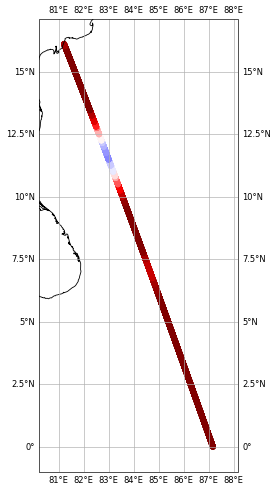

<Figure size 432x288 with 0 Axes>

In [62]:
#plot ALES curve fit trend
dl=1.
extent = [ds_ales.lon.min()-dl, ds_ales.lon.max()+dl, ds_ales.lat.min()-dl, ds_ales.lat.max()+dl]
cmap_trend = plt.get_cmap('seismic')
fig=plt.figure(figsize=(10,10),dpi=60)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, ccrs.PlateCarree())
ax.scatter(ds_ales.lon,ds_ales.lat,c=ds_ales.Trend,marker='o',cmap=cmap_trend,vmin=0,vmax=5)
ax.coastlines(resolution='10m') 
ax.gridlines(draw_labels=True)
plt.show()
plt.savefig(f'ALES_curve_trend{point}.png')

In [45]:
DUACS_curve_fit_df(ds1,0)

extract point #0 on track 040
 (trend_ols) 1.slope is 3.337 mm/yr +/- 1.761


lat        lon Trend Amplitude   Phase      Valid  Dist_to_coast
0  0.000644  87.169037  5.45      3.92  200.90  25.704809     939.476359

In [46]:
df0=pd.DataFrame()
for i in ds.nbpoints.values:
    df=DUACS_curve_fit_df(ds1,i)
    df0=df0.append(df,ignore_index=True)

extract point #0 on track 040
 (trend_ols) 1.slope is 3.337 mm/yr +/- 1.761
extract point #1 on track 040
 (trend_ols) 1.slope is 2.993 mm/yr +/- 1.434
extract point #2 on track 040
 (trend_ols) 1.slope is 2.071 mm/yr +/- 1.277
extract point #3 on track 040
 (trend_ols) 1.slope is 2.478 mm/yr +/- 1.188
extract point #4 on track 040
 (trend_ols) 1.slope is 4.045 mm/yr +/- 1.104
extract point #5 on track 040
 (trend_ols) 1.slope is 2.865 mm/yr +/- 1.117
extract point #6 on track 040
 (trend_ols) 1.slope is 4.074 mm/yr +/- 1.050
extract point #7 on track 040
 (trend_ols) 1.slope is 3.204 mm/yr +/- 0.987
extract point #8 on track 040
 (trend_ols) 1.slope is 3.576 mm/yr +/- 0.986
extract point #9 on track 040
 (trend_ols) 1.slope is 3.317 mm/yr +/- 0.931
extract point #10 on track 040
 (trend_ols) 1.slope is 3.383 mm/yr +/- 0.909
extract point #11 on track 040
 (trend_ols) 1.slope is 3.332 mm/yr +/- 0.987
extract point #12 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 0.929
extract p

extract point #108 on track 040
 (trend_ols) 1.slope is 2.780 mm/yr +/- 0.991
extract point #109 on track 040
 (trend_ols) 1.slope is 3.058 mm/yr +/- 0.960
extract point #110 on track 040
 (trend_ols) 1.slope is 4.046 mm/yr +/- 0.929
extract point #111 on track 040
 (trend_ols) 1.slope is 2.633 mm/yr +/- 0.965
extract point #112 on track 040
 (trend_ols) 1.slope is 4.311 mm/yr +/- 0.968
extract point #113 on track 040
 (trend_ols) 1.slope is 3.249 mm/yr +/- 0.966
extract point #114 on track 040
 (trend_ols) 1.slope is 3.020 mm/yr +/- 0.942
extract point #115 on track 040
 (trend_ols) 1.slope is 4.024 mm/yr +/- 0.960
extract point #116 on track 040
 (trend_ols) 1.slope is 3.932 mm/yr +/- 0.947
extract point #117 on track 040
 (trend_ols) 1.slope is 3.938 mm/yr +/- 0.933
extract point #118 on track 040
 (trend_ols) 1.slope is 3.559 mm/yr +/- 0.956
extract point #119 on track 040
 (trend_ols) 1.slope is 2.975 mm/yr +/- 0.935
extract point #120 on track 040
 (trend_ols) 1.slope is 3.881 mm

extract point #214 on track 040
 (trend_ols) 1.slope is 4.120 mm/yr +/- 0.923
extract point #215 on track 040
 (trend_ols) 1.slope is 4.671 mm/yr +/- 1.022
extract point #216 on track 040
 (trend_ols) 1.slope is 4.851 mm/yr +/- 0.993
extract point #217 on track 040
 (trend_ols) 1.slope is 3.100 mm/yr +/- 0.930
extract point #218 on track 040
 (trend_ols) 1.slope is 2.438 mm/yr +/- 0.939
extract point #219 on track 040
 (trend_ols) 1.slope is 5.293 mm/yr +/- 0.917
extract point #220 on track 040
 (trend_ols) 1.slope is 3.253 mm/yr +/- 0.949
extract point #221 on track 040
 (trend_ols) 1.slope is 4.161 mm/yr +/- 0.968
extract point #222 on track 040
 (trend_ols) 1.slope is 4.889 mm/yr +/- 0.936
extract point #223 on track 040
 (trend_ols) 1.slope is 3.004 mm/yr +/- 0.990
extract point #224 on track 040
 (trend_ols) 1.slope is 2.355 mm/yr +/- 0.933
extract point #225 on track 040
 (trend_ols) 1.slope is 3.320 mm/yr +/- 0.971
extract point #226 on track 040
 (trend_ols) 1.slope is 3.843 mm

extract point #321 on track 040
 (trend_ols) 1.slope is 2.706 mm/yr +/- 0.950
extract point #322 on track 040
 (trend_ols) 1.slope is 3.442 mm/yr +/- 0.991
extract point #323 on track 040
 (trend_ols) 1.slope is 3.432 mm/yr +/- 0.996
extract point #324 on track 040
 (trend_ols) 1.slope is 3.966 mm/yr +/- 0.999
extract point #325 on track 040
 (trend_ols) 1.slope is 3.968 mm/yr +/- 0.979
extract point #326 on track 040
 (trend_ols) 1.slope is 4.189 mm/yr +/- 0.954
extract point #327 on track 040
 (trend_ols) 1.slope is 3.125 mm/yr +/- 0.973
extract point #328 on track 040
 (trend_ols) 1.slope is 3.858 mm/yr +/- 0.968
extract point #329 on track 040
 (trend_ols) 1.slope is 3.412 mm/yr +/- 1.037
extract point #330 on track 040
 (trend_ols) 1.slope is 5.035 mm/yr +/- 0.951
extract point #331 on track 040
 (trend_ols) 1.slope is 3.764 mm/yr +/- 0.949
extract point #332 on track 040
 (trend_ols) 1.slope is 2.646 mm/yr +/- 0.960
extract point #333 on track 040
 (trend_ols) 1.slope is 4.036 mm

extract point #428 on track 040
 (trend_ols) 1.slope is 3.341 mm/yr +/- 0.939
extract point #429 on track 040
 (trend_ols) 1.slope is 4.008 mm/yr +/- 0.964
extract point #430 on track 040
 (trend_ols) 1.slope is 3.508 mm/yr +/- 0.989
extract point #431 on track 040
 (trend_ols) 1.slope is 5.032 mm/yr +/- 0.946
extract point #432 on track 040
 (trend_ols) 1.slope is 3.979 mm/yr +/- 0.952
extract point #433 on track 040
 (trend_ols) 1.slope is 3.643 mm/yr +/- 0.911
extract point #434 on track 040
 (trend_ols) 1.slope is 3.527 mm/yr +/- 0.939
extract point #435 on track 040
 (trend_ols) 1.slope is 4.423 mm/yr +/- 0.952
extract point #436 on track 040
 (trend_ols) 1.slope is 4.210 mm/yr +/- 0.965
extract point #437 on track 040
 (trend_ols) 1.slope is 3.778 mm/yr +/- 0.943
extract point #438 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 0.884
extract point #439 on track 040
 (trend_ols) 1.slope is 3.451 mm/yr +/- 0.989
extract point #440 on track 040
 (trend_ols) 1.slope is 3.264 mm

extract point #535 on track 040
 (trend_ols) 1.slope is 3.397 mm/yr +/- 0.937
extract point #536 on track 040
 (trend_ols) 1.slope is 2.630 mm/yr +/- 0.902
extract point #537 on track 040
 (trend_ols) 1.slope is 3.369 mm/yr +/- 0.908
extract point #538 on track 040
 (trend_ols) 1.slope is 2.489 mm/yr +/- 0.951
extract point #539 on track 040
 (trend_ols) 1.slope is 3.390 mm/yr +/- 0.967
extract point #540 on track 040
 (trend_ols) 1.slope is 3.715 mm/yr +/- 0.961
extract point #541 on track 040
 (trend_ols) 1.slope is 3.247 mm/yr +/- 0.942
extract point #542 on track 040
 (trend_ols) 1.slope is 2.963 mm/yr +/- 0.929
extract point #543 on track 040
 (trend_ols) 1.slope is 2.732 mm/yr +/- 0.975
extract point #544 on track 040
 (trend_ols) 1.slope is 3.095 mm/yr +/- 0.982
extract point #545 on track 040
 (trend_ols) 1.slope is 2.166 mm/yr +/- 0.962
extract point #546 on track 040
 (trend_ols) 1.slope is 3.294 mm/yr +/- 0.912
extract point #547 on track 040
 (trend_ols) 1.slope is 2.111 mm

extract point #641 on track 040
 (trend_ols) 1.slope is 3.261 mm/yr +/- 0.904
extract point #642 on track 040
 (trend_ols) 1.slope is 2.899 mm/yr +/- 0.953
extract point #643 on track 040
 (trend_ols) 1.slope is 2.665 mm/yr +/- 0.974
extract point #644 on track 040
 (trend_ols) 1.slope is 2.827 mm/yr +/- 0.970
extract point #645 on track 040
 (trend_ols) 1.slope is 2.394 mm/yr +/- 0.895
extract point #646 on track 040
 (trend_ols) 1.slope is 3.108 mm/yr +/- 1.001
extract point #647 on track 040
 (trend_ols) 1.slope is 2.645 mm/yr +/- 0.891
extract point #648 on track 040
 (trend_ols) 1.slope is 1.505 mm/yr +/- 0.912
extract point #649 on track 040
 (trend_ols) 1.slope is 2.358 mm/yr +/- 0.903
extract point #650 on track 040
 (trend_ols) 1.slope is 3.478 mm/yr +/- 0.958
extract point #651 on track 040
 (trend_ols) 1.slope is 1.456 mm/yr +/- 0.978
extract point #652 on track 040
 (trend_ols) 1.slope is 1.417 mm/yr +/- 0.930
extract point #653 on track 040
 (trend_ols) 1.slope is 3.069 mm

extract point #748 on track 040
 (trend_ols) 1.slope is 2.864 mm/yr +/- 0.896
extract point #749 on track 040
 (trend_ols) 1.slope is 3.524 mm/yr +/- 0.930
extract point #750 on track 040
 (trend_ols) 1.slope is 2.148 mm/yr +/- 0.994
extract point #751 on track 040
 (trend_ols) 1.slope is 3.519 mm/yr +/- 0.948
extract point #752 on track 040
 (trend_ols) 1.slope is 3.959 mm/yr +/- 0.904
extract point #753 on track 040
 (trend_ols) 1.slope is 3.767 mm/yr +/- 0.925
extract point #754 on track 040
 (trend_ols) 1.slope is 5.149 mm/yr +/- 0.989
extract point #755 on track 040
 (trend_ols) 1.slope is 4.314 mm/yr +/- 0.992
extract point #756 on track 040
 (trend_ols) 1.slope is 4.434 mm/yr +/- 0.950
extract point #757 on track 040
 (trend_ols) 1.slope is 4.343 mm/yr +/- 0.948
extract point #758 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 0.880
extract point #759 on track 040
 (trend_ols) 1.slope is 3.413 mm/yr +/- 0.951
extract point #760 on track 040
 (trend_ols) 1.slope is 3.400 mm

extract point #854 on track 040
 (trend_ols) 1.slope is 3.757 mm/yr +/- 0.969
extract point #855 on track 040
 (trend_ols) 1.slope is 4.112 mm/yr +/- 0.994
extract point #856 on track 040
 (trend_ols) 1.slope is 3.227 mm/yr +/- 1.003
extract point #857 on track 040
 (trend_ols) 1.slope is 2.110 mm/yr +/- 0.988
extract point #858 on track 040
 (trend_ols) 1.slope is 2.570 mm/yr +/- 0.940
extract point #859 on track 040
 (trend_ols) 1.slope is 2.713 mm/yr +/- 0.968
extract point #860 on track 040
 (trend_ols) 1.slope is 3.141 mm/yr +/- 0.954
extract point #861 on track 040
 (trend_ols) 1.slope is 4.350 mm/yr +/- 0.937
extract point #862 on track 040
 (trend_ols) 1.slope is 3.103 mm/yr +/- 0.947
extract point #863 on track 040
 (trend_ols) 1.slope is 3.396 mm/yr +/- 0.919
extract point #864 on track 040
 (trend_ols) 1.slope is 4.405 mm/yr +/- 0.957
extract point #865 on track 040
 (trend_ols) 1.slope is 4.528 mm/yr +/- 0.989
extract point #866 on track 040
 (trend_ols) 1.slope is 3.469 mm

extract point #961 on track 040
 (trend_ols) 1.slope is 2.085 mm/yr +/- 0.923
extract point #962 on track 040
 (trend_ols) 1.slope is 3.362 mm/yr +/- 0.928
extract point #963 on track 040
 (trend_ols) 1.slope is 3.023 mm/yr +/- 0.969
extract point #964 on track 040
 (trend_ols) 1.slope is 2.864 mm/yr +/- 0.893
extract point #965 on track 040
 (trend_ols) 1.slope is 2.640 mm/yr +/- 0.963
extract point #966 on track 040
 (trend_ols) 1.slope is 3.677 mm/yr +/- 0.941
extract point #967 on track 040
 (trend_ols) 1.slope is 2.588 mm/yr +/- 0.958
extract point #968 on track 040
 (trend_ols) 1.slope is 3.637 mm/yr +/- 0.962
extract point #969 on track 040
 (trend_ols) 1.slope is 3.500 mm/yr +/- 0.962
extract point #970 on track 040
 (trend_ols) 1.slope is 2.583 mm/yr +/- 0.952
extract point #971 on track 040
 (trend_ols) 1.slope is 3.676 mm/yr +/- 0.947
extract point #972 on track 040
 (trend_ols) 1.slope is 3.889 mm/yr +/- 0.986
extract point #973 on track 040
 (trend_ols) 1.slope is 2.845 mm

extract point #1067 on track 040
 (trend_ols) 1.slope is 3.224 mm/yr +/- 0.959
extract point #1068 on track 040
 (trend_ols) 1.slope is 2.808 mm/yr +/- 0.959
extract point #1069 on track 040
 (trend_ols) 1.slope is 1.940 mm/yr +/- 0.979
extract point #1070 on track 040
 (trend_ols) 1.slope is 2.527 mm/yr +/- 0.926
extract point #1071 on track 040
 (trend_ols) 1.slope is 2.744 mm/yr +/- 0.953
extract point #1072 on track 040
 (trend_ols) 1.slope is 2.771 mm/yr +/- 0.902
extract point #1073 on track 040
 (trend_ols) 1.slope is 3.305 mm/yr +/- 0.990
extract point #1074 on track 040
 (trend_ols) 1.slope is 4.322 mm/yr +/- 0.867
extract point #1075 on track 040
 (trend_ols) 1.slope is 2.890 mm/yr +/- 0.941
extract point #1076 on track 040
 (trend_ols) 1.slope is 4.766 mm/yr +/- 0.960
extract point #1077 on track 040
 (trend_ols) 1.slope is 3.572 mm/yr +/- 0.953
extract point #1078 on track 040
 (trend_ols) 1.slope is 3.391 mm/yr +/- 1.021
extract point #1079 on track 040
 (trend_ols) 1.slop

extract point #1171 on track 040
 (trend_ols) 1.slope is 3.294 mm/yr +/- 1.010
extract point #1172 on track 040
 (trend_ols) 1.slope is 4.498 mm/yr +/- 0.960
extract point #1173 on track 040
 (trend_ols) 1.slope is 4.174 mm/yr +/- 0.963
extract point #1174 on track 040
 (trend_ols) 1.slope is 3.730 mm/yr +/- 0.958
extract point #1175 on track 040
 (trend_ols) 1.slope is 3.795 mm/yr +/- 0.969
extract point #1176 on track 040
 (trend_ols) 1.slope is 2.624 mm/yr +/- 0.937
extract point #1177 on track 040
 (trend_ols) 1.slope is 2.745 mm/yr +/- 0.977
extract point #1178 on track 040
 (trend_ols) 1.slope is 1.669 mm/yr +/- 0.966
extract point #1179 on track 040
 (trend_ols) 1.slope is 4.192 mm/yr +/- 0.939
extract point #1180 on track 040
 (trend_ols) 1.slope is 2.981 mm/yr +/- 0.980
extract point #1181 on track 040
 (trend_ols) 1.slope is 4.489 mm/yr +/- 0.960
extract point #1182 on track 040
 (trend_ols) 1.slope is 4.399 mm/yr +/- 0.955
extract point #1183 on track 040
 (trend_ols) 1.slop

extract point #1276 on track 040
 (trend_ols) 1.slope is 3.974 mm/yr +/- 1.034
extract point #1277 on track 040
 (trend_ols) 1.slope is 3.496 mm/yr +/- 0.976
extract point #1278 on track 040
 (trend_ols) 1.slope is 4.810 mm/yr +/- 0.977
extract point #1279 on track 040
 (trend_ols) 1.slope is 3.518 mm/yr +/- 1.030
extract point #1280 on track 040
 (trend_ols) 1.slope is 4.236 mm/yr +/- 0.955
extract point #1281 on track 040
 (trend_ols) 1.slope is 3.665 mm/yr +/- 0.999
extract point #1282 on track 040
 (trend_ols) 1.slope is 4.982 mm/yr +/- 1.031
extract point #1283 on track 040
 (trend_ols) 1.slope is 5.347 mm/yr +/- 1.017
extract point #1284 on track 040
 (trend_ols) 1.slope is 2.863 mm/yr +/- 1.000
extract point #1285 on track 040
 (trend_ols) 1.slope is 4.086 mm/yr +/- 1.007
extract point #1286 on track 040
 (trend_ols) 1.slope is 3.495 mm/yr +/- 1.047
extract point #1287 on track 040
 (trend_ols) 1.slope is 3.826 mm/yr +/- 1.014
extract point #1288 on track 040
 (trend_ols) 1.slop

extract point #1381 on track 040
 (trend_ols) 1.slope is 2.647 mm/yr +/- 1.024
extract point #1382 on track 040
 (trend_ols) 1.slope is 2.751 mm/yr +/- 1.021
extract point #1383 on track 040
 (trend_ols) 1.slope is 3.383 mm/yr +/- 1.018
extract point #1384 on track 040
 (trend_ols) 1.slope is 2.834 mm/yr +/- 1.067
extract point #1385 on track 040
 (trend_ols) 1.slope is 4.208 mm/yr +/- 1.051
extract point #1386 on track 040
 (trend_ols) 1.slope is 4.110 mm/yr +/- 1.047
extract point #1387 on track 040
 (trend_ols) 1.slope is 4.034 mm/yr +/- 1.075
extract point #1388 on track 040
 (trend_ols) 1.slope is 2.354 mm/yr +/- 1.017
extract point #1389 on track 040
 (trend_ols) 1.slope is 2.627 mm/yr +/- 1.049
extract point #1390 on track 040
 (trend_ols) 1.slope is 3.336 mm/yr +/- 1.008
extract point #1391 on track 040
 (trend_ols) 1.slope is 3.764 mm/yr +/- 1.005
extract point #1392 on track 040
 (trend_ols) 1.slope is 2.466 mm/yr +/- 1.025
extract point #1393 on track 040
 (trend_ols) 1.slop

extract point #1485 on track 040
 (trend_ols) 1.slope is 2.788 mm/yr +/- 1.013
extract point #1486 on track 040
 (trend_ols) 1.slope is 2.693 mm/yr +/- 1.106
extract point #1487 on track 040
 (trend_ols) 1.slope is 2.989 mm/yr +/- 1.060
extract point #1488 on track 040
 (trend_ols) 1.slope is 2.700 mm/yr +/- 1.016
extract point #1489 on track 040
 (trend_ols) 1.slope is 4.293 mm/yr +/- 1.051
extract point #1490 on track 040
 (trend_ols) 1.slope is 3.453 mm/yr +/- 1.063
extract point #1491 on track 040
 (trend_ols) 1.slope is 3.647 mm/yr +/- 1.081
extract point #1492 on track 040
 (trend_ols) 1.slope is 3.678 mm/yr +/- 1.071
extract point #1493 on track 040
 (trend_ols) 1.slope is 3.671 mm/yr +/- 1.068
extract point #1494 on track 040
 (trend_ols) 1.slope is 3.884 mm/yr +/- 1.073
extract point #1495 on track 040
 (trend_ols) 1.slope is 3.561 mm/yr +/- 1.042
extract point #1496 on track 040
 (trend_ols) 1.slope is 4.266 mm/yr +/- 1.165
extract point #1497 on track 040
 (trend_ols) 1.slop

extract point #1589 on track 040
 (trend_ols) 1.slope is 4.689 mm/yr +/- 1.045
extract point #1590 on track 040
 (trend_ols) 1.slope is 5.167 mm/yr +/- 1.067
extract point #1591 on track 040
 (trend_ols) 1.slope is 4.482 mm/yr +/- 1.005
extract point #1592 on track 040
 (trend_ols) 1.slope is 4.385 mm/yr +/- 1.077
extract point #1593 on track 040
 (trend_ols) 1.slope is 4.998 mm/yr +/- 1.030
extract point #1594 on track 040
 (trend_ols) 1.slope is 4.662 mm/yr +/- 1.043
extract point #1595 on track 040
 (trend_ols) 1.slope is 3.731 mm/yr +/- 0.995
extract point #1596 on track 040
 (trend_ols) 1.slope is 4.581 mm/yr +/- 1.017
extract point #1597 on track 040
 (trend_ols) 1.slope is 3.817 mm/yr +/- 1.058
extract point #1598 on track 040
 (trend_ols) 1.slope is 4.044 mm/yr +/- 1.088
extract point #1599 on track 040
 (trend_ols) 1.slope is 3.777 mm/yr +/- 1.067
extract point #1600 on track 040
 (trend_ols) 1.slope is 4.468 mm/yr +/- 1.079
extract point #1601 on track 040
 (trend_ols) 1.slop

extract point #1693 on track 040
 (trend_ols) 1.slope is 3.108 mm/yr +/- 1.051
extract point #1694 on track 040
 (trend_ols) 1.slope is 3.674 mm/yr +/- 1.065
extract point #1695 on track 040
 (trend_ols) 1.slope is 2.421 mm/yr +/- 1.019
extract point #1696 on track 040
 (trend_ols) 1.slope is 4.620 mm/yr +/- 1.078
extract point #1697 on track 040
 (trend_ols) 1.slope is 3.772 mm/yr +/- 1.053
extract point #1698 on track 040
 (trend_ols) 1.slope is 4.141 mm/yr +/- 1.099
extract point #1699 on track 040
 (trend_ols) 1.slope is 4.760 mm/yr +/- 1.069
extract point #1700 on track 040
 (trend_ols) 1.slope is 4.859 mm/yr +/- 1.063
extract point #1701 on track 040
 (trend_ols) 1.slope is 5.825 mm/yr +/- 1.067
extract point #1702 on track 040
 (trend_ols) 1.slope is 5.177 mm/yr +/- 1.049
extract point #1703 on track 040
 (trend_ols) 1.slope is 5.200 mm/yr +/- 1.055
extract point #1704 on track 040
 (trend_ols) 1.slope is 4.509 mm/yr +/- 1.052
extract point #1705 on track 040
 (trend_ols) 1.slop

extract point #1798 on track 040
 (trend_ols) 1.slope is 4.809 mm/yr +/- 1.062
extract point #1799 on track 040
 (trend_ols) 1.slope is 4.361 mm/yr +/- 1.052
extract point #1800 on track 040
 (trend_ols) 1.slope is 5.257 mm/yr +/- 1.086
extract point #1801 on track 040
 (trend_ols) 1.slope is 5.382 mm/yr +/- 1.011
extract point #1802 on track 040
 (trend_ols) 1.slope is 2.656 mm/yr +/- 0.981
extract point #1803 on track 040
 (trend_ols) 1.slope is 3.197 mm/yr +/- 1.034
extract point #1804 on track 040
 (trend_ols) 1.slope is 3.632 mm/yr +/- 1.052
extract point #1805 on track 040
 (trend_ols) 1.slope is 3.413 mm/yr +/- 0.949
extract point #1806 on track 040
 (trend_ols) 1.slope is 3.505 mm/yr +/- 0.976
extract point #1807 on track 040
 (trend_ols) 1.slope is 3.100 mm/yr +/- 0.994
extract point #1808 on track 040
 (trend_ols) 1.slope is 2.381 mm/yr +/- 1.057
extract point #1809 on track 040
 (trend_ols) 1.slope is 4.341 mm/yr +/- 1.052
extract point #1810 on track 040
 (trend_ols) 1.slop

extract point #1903 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.016
extract point #1904 on track 040
 (trend_ols) 1.slope is 3.824 mm/yr +/- 1.039
extract point #1905 on track 040
 (trend_ols) 1.slope is 4.996 mm/yr +/- 1.115
extract point #1906 on track 040
 (trend_ols) 1.slope is 5.060 mm/yr +/- 1.050
extract point #1907 on track 040
 (trend_ols) 1.slope is 4.674 mm/yr +/- 1.032
extract point #1908 on track 040
 (trend_ols) 1.slope is 5.904 mm/yr +/- 1.004
extract point #1909 on track 040
 (trend_ols) 1.slope is 3.165 mm/yr +/- 1.043
extract point #1910 on track 040
 (trend_ols) 1.slope is 3.689 mm/yr +/- 1.067
extract point #1911 on track 040
 (trend_ols) 1.slope is 3.095 mm/yr +/- 1.093
extract point #1912 on track 040
 (trend_ols) 1.slope is 3.728 mm/yr +/- 1.059
extract point #1913 on track 040
 (trend_ols) 1.slope is 3.156 mm/yr +/- 1.066
extract point #1914 on track 040
 (trend_ols) 1.slope is 3.481 mm/yr +/- 1.066
extract point #1915 on track 040
 (trend_ols) 1.slop

extract point #2007 on track 040
 (trend_ols) 1.slope is 5.720 mm/yr +/- 0.982
extract point #2008 on track 040
 (trend_ols) 1.slope is 3.307 mm/yr +/- 0.978
extract point #2009 on track 040
 (trend_ols) 1.slope is 5.218 mm/yr +/- 1.040
extract point #2010 on track 040
 (trend_ols) 1.slope is 5.838 mm/yr +/- 1.041
extract point #2011 on track 040
 (trend_ols) 1.slope is 4.445 mm/yr +/- 0.993
extract point #2012 on track 040
 (trend_ols) 1.slope is 3.451 mm/yr +/- 0.979
extract point #2013 on track 040
 (trend_ols) 1.slope is 4.535 mm/yr +/- 1.082
extract point #2014 on track 040
 (trend_ols) 1.slope is 3.388 mm/yr +/- 0.990
extract point #2015 on track 040
 (trend_ols) 1.slope is 3.378 mm/yr +/- 1.041
extract point #2016 on track 040
 (trend_ols) 1.slope is 3.568 mm/yr +/- 1.001
extract point #2017 on track 040
 (trend_ols) 1.slope is 3.245 mm/yr +/- 0.992
extract point #2018 on track 040
 (trend_ols) 1.slope is 3.627 mm/yr +/- 1.031
extract point #2019 on track 040
 (trend_ols) 1.slop

extract point #2112 on track 040
 (trend_ols) 1.slope is 3.220 mm/yr +/- 0.979
extract point #2113 on track 040
 (trend_ols) 1.slope is 5.180 mm/yr +/- 1.048
extract point #2114 on track 040
 (trend_ols) 1.slope is 4.100 mm/yr +/- 1.017
extract point #2115 on track 040
 (trend_ols) 1.slope is 3.032 mm/yr +/- 1.033
extract point #2116 on track 040
 (trend_ols) 1.slope is 4.271 mm/yr +/- 1.027
extract point #2117 on track 040
 (trend_ols) 1.slope is 3.006 mm/yr +/- 1.020
extract point #2118 on track 040
 (trend_ols) 1.slope is 3.593 mm/yr +/- 1.134
extract point #2119 on track 040
 (trend_ols) 1.slope is 5.028 mm/yr +/- 0.993
extract point #2120 on track 040
 (trend_ols) 1.slope is 4.107 mm/yr +/- 0.993
extract point #2121 on track 040
 (trend_ols) 1.slope is 3.374 mm/yr +/- 1.005
extract point #2122 on track 040
 (trend_ols) 1.slope is 4.032 mm/yr +/- 1.020
extract point #2123 on track 040
 (trend_ols) 1.slope is 5.398 mm/yr +/- 1.032
extract point #2124 on track 040
 (trend_ols) 1.slop

extract point #2216 on track 040
 (trend_ols) 1.slope is 3.485 mm/yr +/- 1.046
extract point #2217 on track 040
 (trend_ols) 1.slope is 4.240 mm/yr +/- 0.985
extract point #2218 on track 040
 (trend_ols) 1.slope is 3.393 mm/yr +/- 0.972
extract point #2219 on track 040
 (trend_ols) 1.slope is 4.759 mm/yr +/- 0.950
extract point #2220 on track 040
 (trend_ols) 1.slope is 4.098 mm/yr +/- 1.029
extract point #2221 on track 040
 (trend_ols) 1.slope is 3.977 mm/yr +/- 1.014
extract point #2222 on track 040
 (trend_ols) 1.slope is 3.563 mm/yr +/- 0.939
extract point #2223 on track 040
 (trend_ols) 1.slope is 2.508 mm/yr +/- 0.985
extract point #2224 on track 040
 (trend_ols) 1.slope is 3.677 mm/yr +/- 1.000
extract point #2225 on track 040
 (trend_ols) 1.slope is 3.829 mm/yr +/- 0.981
extract point #2226 on track 040
 (trend_ols) 1.slope is 3.928 mm/yr +/- 0.977
extract point #2227 on track 040
 (trend_ols) 1.slope is 3.334 mm/yr +/- 0.967
extract point #2228 on track 040
 (trend_ols) 1.slop

extract point #2320 on track 040
 (trend_ols) 1.slope is 3.090 mm/yr +/- 1.039
extract point #2321 on track 040
 (trend_ols) 1.slope is 3.615 mm/yr +/- 0.956
extract point #2322 on track 040
 (trend_ols) 1.slope is 3.878 mm/yr +/- 0.964
extract point #2323 on track 040
 (trend_ols) 1.slope is 4.876 mm/yr +/- 0.938
extract point #2324 on track 040
 (trend_ols) 1.slope is 3.948 mm/yr +/- 1.019
extract point #2325 on track 040
 (trend_ols) 1.slope is 3.751 mm/yr +/- 1.003
extract point #2326 on track 040
 (trend_ols) 1.slope is 4.453 mm/yr +/- 1.011
extract point #2327 on track 040
 (trend_ols) 1.slope is 4.749 mm/yr +/- 1.010
extract point #2328 on track 040
 (trend_ols) 1.slope is 4.880 mm/yr +/- 1.006
extract point #2329 on track 040
 (trend_ols) 1.slope is 4.556 mm/yr +/- 0.991
extract point #2330 on track 040
 (trend_ols) 1.slope is 4.379 mm/yr +/- 1.001
extract point #2331 on track 040
 (trend_ols) 1.slope is 3.836 mm/yr +/- 1.015
extract point #2332 on track 040
 (trend_ols) 1.slop

extract point #2424 on track 040
 (trend_ols) 1.slope is 3.967 mm/yr +/- 1.040
extract point #2425 on track 040
 (trend_ols) 1.slope is 3.636 mm/yr +/- 0.970
extract point #2426 on track 040
 (trend_ols) 1.slope is 3.158 mm/yr +/- 0.968
extract point #2427 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 0.974
extract point #2428 on track 040
 (trend_ols) 1.slope is 4.321 mm/yr +/- 1.006
extract point #2429 on track 040
 (trend_ols) 1.slope is 4.186 mm/yr +/- 0.997
extract point #2430 on track 040
 (trend_ols) 1.slope is 4.173 mm/yr +/- 0.948
extract point #2431 on track 040
 (trend_ols) 1.slope is 4.975 mm/yr +/- 1.022
extract point #2432 on track 040
 (trend_ols) 1.slope is 4.262 mm/yr +/- 0.963
extract point #2433 on track 040
 (trend_ols) 1.slope is 4.702 mm/yr +/- 1.013
extract point #2434 on track 040
 (trend_ols) 1.slope is 3.518 mm/yr +/- 1.025
extract point #2435 on track 040
 (trend_ols) 1.slope is 4.502 mm/yr +/- 1.014
extract point #2436 on track 040
 (trend_ols) 1.slop

extract point #2528 on track 040
 (trend_ols) 1.slope is 3.551 mm/yr +/- 1.006
extract point #2529 on track 040
 (trend_ols) 1.slope is 2.815 mm/yr +/- 1.030
extract point #2530 on track 040
 (trend_ols) 1.slope is 3.256 mm/yr +/- 1.027
extract point #2531 on track 040
 (trend_ols) 1.slope is 3.773 mm/yr +/- 0.987
extract point #2532 on track 040
 (trend_ols) 1.slope is 4.521 mm/yr +/- 0.992
extract point #2533 on track 040
 (trend_ols) 1.slope is 4.410 mm/yr +/- 0.998
extract point #2534 on track 040
 (trend_ols) 1.slope is 4.092 mm/yr +/- 0.975
extract point #2535 on track 040
 (trend_ols) 1.slope is 3.575 mm/yr +/- 1.035
extract point #2536 on track 040
 (trend_ols) 1.slope is 3.421 mm/yr +/- 0.983
extract point #2537 on track 040
 (trend_ols) 1.slope is 3.119 mm/yr +/- 1.032
extract point #2538 on track 040
 (trend_ols) 1.slope is 3.963 mm/yr +/- 1.033
extract point #2539 on track 040
 (trend_ols) 1.slope is 4.212 mm/yr +/- 0.990
extract point #2540 on track 040
 (trend_ols) 1.slop

extract point #2632 on track 040
 (trend_ols) 1.slope is 3.351 mm/yr +/- 1.064
extract point #2633 on track 040
 (trend_ols) 1.slope is 4.607 mm/yr +/- 1.076
extract point #2634 on track 040
 (trend_ols) 1.slope is 2.906 mm/yr +/- 1.086
extract point #2635 on track 040
 (trend_ols) 1.slope is 3.587 mm/yr +/- 1.037
extract point #2636 on track 040
 (trend_ols) 1.slope is 3.044 mm/yr +/- 1.053
extract point #2637 on track 040
 (trend_ols) 1.slope is 4.195 mm/yr +/- 1.055
extract point #2638 on track 040
 (trend_ols) 1.slope is 4.117 mm/yr +/- 1.026
extract point #2639 on track 040
 (trend_ols) 1.slope is 3.263 mm/yr +/- 1.065
extract point #2640 on track 040
 (trend_ols) 1.slope is 4.089 mm/yr +/- 1.006
extract point #2641 on track 040
 (trend_ols) 1.slope is 2.241 mm/yr +/- 1.015
extract point #2642 on track 040
 (trend_ols) 1.slope is 3.131 mm/yr +/- 1.009
extract point #2643 on track 040
 (trend_ols) 1.slope is 4.403 mm/yr +/- 1.019
extract point #2644 on track 040
 (trend_ols) 1.slop

extract point #2737 on track 040
 (trend_ols) 1.slope is 2.758 mm/yr +/- 1.064
extract point #2738 on track 040
 (trend_ols) 1.slope is 2.285 mm/yr +/- 1.029
extract point #2739 on track 040
 (trend_ols) 1.slope is 3.458 mm/yr +/- 1.024
extract point #2740 on track 040
 (trend_ols) 1.slope is 3.128 mm/yr +/- 1.073
extract point #2741 on track 040
 (trend_ols) 1.slope is 3.619 mm/yr +/- 1.075
extract point #2742 on track 040
 (trend_ols) 1.slope is 3.550 mm/yr +/- 1.003
extract point #2743 on track 040
 (trend_ols) 1.slope is 3.990 mm/yr +/- 1.065
extract point #2744 on track 040
 (trend_ols) 1.slope is 3.465 mm/yr +/- 1.048
extract point #2745 on track 040
 (trend_ols) 1.slope is 4.034 mm/yr +/- 1.020
extract point #2746 on track 040
 (trend_ols) 1.slope is 2.453 mm/yr +/- 1.051
extract point #2747 on track 040
 (trend_ols) 1.slope is 4.281 mm/yr +/- 1.030
extract point #2748 on track 040
 (trend_ols) 1.slope is 3.002 mm/yr +/- 1.034
extract point #2749 on track 040
 (trend_ols) 1.slop

extract point #2841 on track 040
 (trend_ols) 1.slope is 4.135 mm/yr +/- 1.139
extract point #2842 on track 040
 (trend_ols) 1.slope is 3.492 mm/yr +/- 1.110
extract point #2843 on track 040
 (trend_ols) 1.slope is 2.854 mm/yr +/- 1.073
extract point #2844 on track 040
 (trend_ols) 1.slope is 3.704 mm/yr +/- 1.124
extract point #2845 on track 040
 (trend_ols) 1.slope is 3.624 mm/yr +/- 1.108
extract point #2846 on track 040
 (trend_ols) 1.slope is 5.084 mm/yr +/- 1.082
extract point #2847 on track 040
 (trend_ols) 1.slope is 3.708 mm/yr +/- 1.114
extract point #2848 on track 040
 (trend_ols) 1.slope is 3.754 mm/yr +/- 1.111
extract point #2849 on track 040
 (trend_ols) 1.slope is 4.303 mm/yr +/- 1.137
extract point #2850 on track 040
 (trend_ols) 1.slope is 3.390 mm/yr +/- 1.070
extract point #2851 on track 040
 (trend_ols) 1.slope is 3.208 mm/yr +/- 1.132
extract point #2852 on track 040
 (trend_ols) 1.slope is 3.581 mm/yr +/- 1.088
extract point #2853 on track 040
 (trend_ols) 1.slop

 (trend_ols) 1.slope is 4.296 mm/yr +/- 1.088
extract point #2946 on track 040
 (trend_ols) 1.slope is 4.601 mm/yr +/- 1.162
extract point #2947 on track 040
 (trend_ols) 1.slope is 3.858 mm/yr +/- 1.107
extract point #2948 on track 040
 (trend_ols) 1.slope is 2.334 mm/yr +/- 1.171
extract point #2949 on track 040
 (trend_ols) 1.slope is 3.394 mm/yr +/- 1.147
extract point #2950 on track 040
 (trend_ols) 1.slope is 3.131 mm/yr +/- 1.143
extract point #2951 on track 040
 (trend_ols) 1.slope is 4.307 mm/yr +/- 1.105
extract point #2952 on track 040
 (trend_ols) 1.slope is 3.437 mm/yr +/- 1.107
extract point #2953 on track 040
 (trend_ols) 1.slope is 5.680 mm/yr +/- 1.106
extract point #2954 on track 040
 (trend_ols) 1.slope is 3.071 mm/yr +/- 1.118
extract point #2955 on track 040
 (trend_ols) 1.slope is 4.942 mm/yr +/- 1.126
extract point #2956 on track 040
 (trend_ols) 1.slope is 4.632 mm/yr +/- 1.110
extract point #2957 on track 040
 (trend_ols) 1.slope is 5.120 mm/yr +/- 1.173
extrac

extract point #3050 on track 040
 (trend_ols) 1.slope is 4.742 mm/yr +/- 1.102
extract point #3051 on track 040
 (trend_ols) 1.slope is 3.996 mm/yr +/- 1.127
extract point #3052 on track 040
 (trend_ols) 1.slope is 3.845 mm/yr +/- 1.144
extract point #3053 on track 040
 (trend_ols) 1.slope is 4.569 mm/yr +/- 1.193
extract point #3054 on track 040
 (trend_ols) 1.slope is 5.573 mm/yr +/- 1.172
extract point #3055 on track 040
 (trend_ols) 1.slope is 4.862 mm/yr +/- 1.135
extract point #3056 on track 040
 (trend_ols) 1.slope is 5.113 mm/yr +/- 1.127
extract point #3057 on track 040
 (trend_ols) 1.slope is 4.015 mm/yr +/- 1.143
extract point #3058 on track 040
 (trend_ols) 1.slope is 5.569 mm/yr +/- 1.124
extract point #3059 on track 040
 (trend_ols) 1.slope is 5.541 mm/yr +/- 1.204
extract point #3060 on track 040
 (trend_ols) 1.slope is 5.237 mm/yr +/- 1.151
extract point #3061 on track 040
 (trend_ols) 1.slope is 6.921 mm/yr +/- 1.166
extract point #3062 on track 040
 (trend_ols) 1.slop

extract point #3154 on track 040
 (trend_ols) 1.slope is 6.271 mm/yr +/- 1.185
extract point #3155 on track 040
 (trend_ols) 1.slope is 6.052 mm/yr +/- 1.164
extract point #3156 on track 040
 (trend_ols) 1.slope is 5.595 mm/yr +/- 1.156
extract point #3157 on track 040
 (trend_ols) 1.slope is 5.942 mm/yr +/- 1.160
extract point #3158 on track 040
 (trend_ols) 1.slope is 5.578 mm/yr +/- 1.163
extract point #3159 on track 040
 (trend_ols) 1.slope is 7.376 mm/yr +/- 1.147
extract point #3160 on track 040
 (trend_ols) 1.slope is 4.147 mm/yr +/- 1.130
extract point #3161 on track 040
 (trend_ols) 1.slope is 5.354 mm/yr +/- 1.178
extract point #3162 on track 040
 (trend_ols) 1.slope is 4.111 mm/yr +/- 1.138
extract point #3163 on track 040
 (trend_ols) 1.slope is 6.752 mm/yr +/- 1.174
extract point #3164 on track 040
 (trend_ols) 1.slope is 5.117 mm/yr +/- 1.186
extract point #3165 on track 040
 (trend_ols) 1.slope is 5.611 mm/yr +/- 1.131
extract point #3166 on track 040
 (trend_ols) 1.slop

extract point #3259 on track 040
 (trend_ols) 1.slope is 6.049 mm/yr +/- 1.161
extract point #3260 on track 040
 (trend_ols) 1.slope is 7.915 mm/yr +/- 1.223
extract point #3261 on track 040
 (trend_ols) 1.slope is 5.197 mm/yr +/- 1.188
extract point #3262 on track 040
 (trend_ols) 1.slope is 7.174 mm/yr +/- 1.246
extract point #3263 on track 040
 (trend_ols) 1.slope is 4.922 mm/yr +/- 1.243
extract point #3264 on track 040
 (trend_ols) 1.slope is 5.457 mm/yr +/- 1.201
extract point #3265 on track 040
 (trend_ols) 1.slope is 5.419 mm/yr +/- 1.179
extract point #3266 on track 040
 (trend_ols) 1.slope is 4.588 mm/yr +/- 1.188
extract point #3267 on track 040
 (trend_ols) 1.slope is 5.234 mm/yr +/- 1.202
extract point #3268 on track 040
 (trend_ols) 1.slope is 6.239 mm/yr +/- 1.159
extract point #3269 on track 040
 (trend_ols) 1.slope is 5.687 mm/yr +/- 1.191
extract point #3270 on track 040
 (trend_ols) 1.slope is 5.720 mm/yr +/- 1.151
extract point #3271 on track 040
 (trend_ols) 1.slop

extract point #3364 on track 040
 (trend_ols) 1.slope is 5.283 mm/yr +/- 1.163
extract point #3365 on track 040
 (trend_ols) 1.slope is 5.281 mm/yr +/- 1.148
extract point #3366 on track 040
 (trend_ols) 1.slope is 5.588 mm/yr +/- 1.192
extract point #3367 on track 040
 (trend_ols) 1.slope is 5.846 mm/yr +/- 1.141
extract point #3368 on track 040
 (trend_ols) 1.slope is 6.316 mm/yr +/- 1.166
extract point #3369 on track 040
 (trend_ols) 1.slope is 5.542 mm/yr +/- 1.136
extract point #3370 on track 040
 (trend_ols) 1.slope is 4.912 mm/yr +/- 1.157
extract point #3371 on track 040
 (trend_ols) 1.slope is 4.502 mm/yr +/- 1.139
extract point #3372 on track 040
 (trend_ols) 1.slope is 5.844 mm/yr +/- 1.099
extract point #3373 on track 040
 (trend_ols) 1.slope is 4.956 mm/yr +/- 1.129
extract point #3374 on track 040
 (trend_ols) 1.slope is 5.017 mm/yr +/- 1.123
extract point #3375 on track 040
 (trend_ols) 1.slope is 5.305 mm/yr +/- 1.157
extract point #3376 on track 040
 (trend_ols) 1.slop

extract point #3468 on track 040
 (trend_ols) 1.slope is 4.895 mm/yr +/- 1.164
extract point #3469 on track 040
 (trend_ols) 1.slope is 5.023 mm/yr +/- 1.196
extract point #3470 on track 040
 (trend_ols) 1.slope is 4.230 mm/yr +/- 1.137
extract point #3471 on track 040
 (trend_ols) 1.slope is 3.719 mm/yr +/- 1.195
extract point #3472 on track 040
 (trend_ols) 1.slope is 4.253 mm/yr +/- 1.143
extract point #3473 on track 040
 (trend_ols) 1.slope is 4.950 mm/yr +/- 1.204
extract point #3474 on track 040
 (trend_ols) 1.slope is 5.046 mm/yr +/- 1.148
extract point #3475 on track 040
 (trend_ols) 1.slope is 3.774 mm/yr +/- 1.139
extract point #3476 on track 040
 (trend_ols) 1.slope is 4.583 mm/yr +/- 1.196
extract point #3477 on track 040
 (trend_ols) 1.slope is 5.291 mm/yr +/- 1.178
extract point #3478 on track 040
 (trend_ols) 1.slope is 4.631 mm/yr +/- 1.190
extract point #3479 on track 040
 (trend_ols) 1.slope is 5.582 mm/yr +/- 1.199
extract point #3480 on track 040
 (trend_ols) 1.slop

extract point #3572 on track 040
 (trend_ols) 1.slope is 3.627 mm/yr +/- 1.204
extract point #3573 on track 040
 (trend_ols) 1.slope is 4.745 mm/yr +/- 1.218
extract point #3574 on track 040
 (trend_ols) 1.slope is 3.978 mm/yr +/- 1.158
extract point #3575 on track 040
 (trend_ols) 1.slope is 3.409 mm/yr +/- 1.186
extract point #3576 on track 040
 (trend_ols) 1.slope is 4.260 mm/yr +/- 1.159
extract point #3577 on track 040
 (trend_ols) 1.slope is 4.451 mm/yr +/- 1.173
extract point #3578 on track 040
 (trend_ols) 1.slope is 4.485 mm/yr +/- 1.208
extract point #3579 on track 040
 (trend_ols) 1.slope is 5.411 mm/yr +/- 1.163
extract point #3580 on track 040
 (trend_ols) 1.slope is 3.109 mm/yr +/- 1.192
extract point #3581 on track 040
 (trend_ols) 1.slope is 3.761 mm/yr +/- 1.187
extract point #3582 on track 040
 (trend_ols) 1.slope is 4.582 mm/yr +/- 1.173
extract point #3583 on track 040
 (trend_ols) 1.slope is 4.148 mm/yr +/- 1.175
extract point #3584 on track 040
 (trend_ols) 1.slop

extract point #3676 on track 040
 (trend_ols) 1.slope is 3.216 mm/yr +/- 1.247
extract point #3677 on track 040
 (trend_ols) 1.slope is 5.036 mm/yr +/- 1.205
extract point #3678 on track 040
 (trend_ols) 1.slope is 3.461 mm/yr +/- 1.215
extract point #3679 on track 040
 (trend_ols) 1.slope is 4.975 mm/yr +/- 1.190
extract point #3680 on track 040
 (trend_ols) 1.slope is 3.785 mm/yr +/- 1.175
extract point #3681 on track 040
 (trend_ols) 1.slope is 3.847 mm/yr +/- 1.127
extract point #3682 on track 040
 (trend_ols) 1.slope is 4.048 mm/yr +/- 1.158
extract point #3683 on track 040
 (trend_ols) 1.slope is 3.637 mm/yr +/- 1.168
extract point #3684 on track 040
 (trend_ols) 1.slope is 4.638 mm/yr +/- 1.195
extract point #3685 on track 040
 (trend_ols) 1.slope is 4.703 mm/yr +/- 1.181
extract point #3686 on track 040
 (trend_ols) 1.slope is 3.345 mm/yr +/- 1.207
extract point #3687 on track 040
 (trend_ols) 1.slope is 4.848 mm/yr +/- 1.185
extract point #3688 on track 040
 (trend_ols) 1.slop

extract point #3781 on track 040
 (trend_ols) 1.slope is 4.356 mm/yr +/- 1.250
extract point #3782 on track 040
 (trend_ols) 1.slope is 3.174 mm/yr +/- 1.183
extract point #3783 on track 040
 (trend_ols) 1.slope is 4.508 mm/yr +/- 1.188
extract point #3784 on track 040
 (trend_ols) 1.slope is 4.068 mm/yr +/- 1.194
extract point #3785 on track 040
 (trend_ols) 1.slope is 4.573 mm/yr +/- 1.181
extract point #3786 on track 040
 (trend_ols) 1.slope is 4.540 mm/yr +/- 1.260
extract point #3787 on track 040
 (trend_ols) 1.slope is 4.976 mm/yr +/- 1.175
extract point #3788 on track 040
 (trend_ols) 1.slope is 4.535 mm/yr +/- 1.166
extract point #3789 on track 040
 (trend_ols) 1.slope is 4.006 mm/yr +/- 1.209
extract point #3790 on track 040
 (trend_ols) 1.slope is 4.776 mm/yr +/- 1.219
extract point #3791 on track 040
 (trend_ols) 1.slope is 5.089 mm/yr +/- 1.189
extract point #3792 on track 040
 (trend_ols) 1.slope is 3.411 mm/yr +/- 1.137
extract point #3793 on track 040
 (trend_ols) 1.slop

extract point #3886 on track 040
 (trend_ols) 1.slope is 3.110 mm/yr +/- 1.161
extract point #3887 on track 040
 (trend_ols) 1.slope is 3.039 mm/yr +/- 1.222
extract point #3888 on track 040
 (trend_ols) 1.slope is 1.689 mm/yr +/- 1.187
extract point #3889 on track 040
 (trend_ols) 1.slope is 4.157 mm/yr +/- 1.164
extract point #3890 on track 040
 (trend_ols) 1.slope is 3.515 mm/yr +/- 1.194
extract point #3891 on track 040
 (trend_ols) 1.slope is 4.122 mm/yr +/- 1.201
extract point #3892 on track 040
 (trend_ols) 1.slope is 4.072 mm/yr +/- 1.175
extract point #3893 on track 040
 (trend_ols) 1.slope is 2.562 mm/yr +/- 1.146
extract point #3894 on track 040
 (trend_ols) 1.slope is 3.498 mm/yr +/- 1.174
extract point #3895 on track 040
 (trend_ols) 1.slope is 3.537 mm/yr +/- 1.187
extract point #3896 on track 040
 (trend_ols) 1.slope is 3.610 mm/yr +/- 1.209
extract point #3897 on track 040
 (trend_ols) 1.slope is 3.787 mm/yr +/- 1.204
extract point #3898 on track 040
 (trend_ols) 1.slop

extract point #3991 on track 040
 (trend_ols) 1.slope is 3.469 mm/yr +/- 1.188
extract point #3992 on track 040
 (trend_ols) 1.slope is 2.711 mm/yr +/- 1.234
extract point #3993 on track 040
 (trend_ols) 1.slope is 2.580 mm/yr +/- 1.239
extract point #3994 on track 040
 (trend_ols) 1.slope is 1.797 mm/yr +/- 1.204
extract point #3995 on track 040
 (trend_ols) 1.slope is 2.798 mm/yr +/- 1.190
extract point #3996 on track 040
 (trend_ols) 1.slope is 4.405 mm/yr +/- 1.224
extract point #3997 on track 040
 (trend_ols) 1.slope is 2.367 mm/yr +/- 1.164
extract point #3998 on track 040
 (trend_ols) 1.slope is 1.127 mm/yr +/- 1.231
extract point #3999 on track 040
 (trend_ols) 1.slope is 1.075 mm/yr +/- 1.194
extract point #4000 on track 040
 (trend_ols) 1.slope is 3.881 mm/yr +/- 1.181
extract point #4001 on track 040
 (trend_ols) 1.slope is 1.808 mm/yr +/- 1.221
extract point #4002 on track 040
 (trend_ols) 1.slope is 2.633 mm/yr +/- 1.250
extract point #4003 on track 040
 (trend_ols) 1.slop

extract point #4095 on track 040
 (trend_ols) 1.slope is 2.029 mm/yr +/- 1.169
extract point #4096 on track 040
 (trend_ols) 1.slope is 2.495 mm/yr +/- 1.195
extract point #4097 on track 040
 (trend_ols) 1.slope is 2.359 mm/yr +/- 1.228
extract point #4098 on track 040
 (trend_ols) 1.slope is 1.735 mm/yr +/- 1.227
extract point #4099 on track 040
 (trend_ols) 1.slope is 2.125 mm/yr +/- 1.222
extract point #4100 on track 040
 (trend_ols) 1.slope is 2.467 mm/yr +/- 1.243
extract point #4101 on track 040
 (trend_ols) 1.slope is 1.460 mm/yr +/- 1.198
extract point #4102 on track 040
 (trend_ols) 1.slope is 2.999 mm/yr +/- 1.213
extract point #4103 on track 040
 (trend_ols) 1.slope is 2.733 mm/yr +/- 1.187
extract point #4104 on track 040
 (trend_ols) 1.slope is 1.479 mm/yr +/- 1.230
extract point #4105 on track 040
 (trend_ols) 1.slope is 1.465 mm/yr +/- 1.128
extract point #4106 on track 040
 (trend_ols) 1.slope is 2.020 mm/yr +/- 1.230
extract point #4107 on track 040
 (trend_ols) 1.slop

 (trend_ols) 1.slope is 1.320 mm/yr +/- 1.224
extract point #4200 on track 040
 (trend_ols) 1.slope is 0.470 mm/yr +/- 1.243
extract point #4201 on track 040
 (trend_ols) 1.slope is 1.198 mm/yr +/- 1.182
extract point #4202 on track 040
 (trend_ols) 1.slope is 1.401 mm/yr +/- 1.263
extract point #4203 on track 040
 (trend_ols) 1.slope is 0.942 mm/yr +/- 1.227
extract point #4204 on track 040
 (trend_ols) 1.slope is 0.924 mm/yr +/- 1.243
extract point #4205 on track 040
 (trend_ols) 1.slope is 1.776 mm/yr +/- 1.183
extract point #4206 on track 040
 (trend_ols) 1.slope is 1.662 mm/yr +/- 1.239
extract point #4207 on track 040
 (trend_ols) 1.slope is 1.852 mm/yr +/- 1.251
extract point #4208 on track 040
 (trend_ols) 1.slope is 2.054 mm/yr +/- 1.228
extract point #4209 on track 040
 (trend_ols) 1.slope is 1.411 mm/yr +/- 1.227
extract point #4210 on track 040
 (trend_ols) 1.slope is 1.380 mm/yr +/- 1.212
extract point #4211 on track 040
 (trend_ols) 1.slope is 1.126 mm/yr +/- 1.199
extrac

extract point #4304 on track 040
 (trend_ols) 1.slope is 0.255 mm/yr +/- 1.331
extract point #4305 on track 040
 (trend_ols) 1.slope is -0.008 mm/yr +/- 1.251
extract point #4306 on track 040
 (trend_ols) 1.slope is 0.652 mm/yr +/- 1.247
extract point #4307 on track 040
 (trend_ols) 1.slope is -0.315 mm/yr +/- 1.275
extract point #4308 on track 040
 (trend_ols) 1.slope is 1.906 mm/yr +/- 1.268
extract point #4309 on track 040
 (trend_ols) 1.slope is 0.358 mm/yr +/- 1.253
extract point #4310 on track 040
 (trend_ols) 1.slope is 0.506 mm/yr +/- 1.296
extract point #4311 on track 040
 (trend_ols) 1.slope is 1.606 mm/yr +/- 1.275
extract point #4312 on track 040
 (trend_ols) 1.slope is 0.740 mm/yr +/- 1.306
extract point #4313 on track 040
 (trend_ols) 1.slope is 0.921 mm/yr +/- 1.289
extract point #4314 on track 040
 (trend_ols) 1.slope is 2.783 mm/yr +/- 1.255
extract point #4315 on track 040
 (trend_ols) 1.slope is 0.376 mm/yr +/- 1.278
extract point #4316 on track 040
 (trend_ols) 1.sl

extract point #4409 on track 040
 (trend_ols) 1.slope is -0.238 mm/yr +/- 1.256
extract point #4410 on track 040
 (trend_ols) 1.slope is 0.971 mm/yr +/- 1.268
extract point #4411 on track 040
 (trend_ols) 1.slope is 1.698 mm/yr +/- 1.224
extract point #4412 on track 040
 (trend_ols) 1.slope is 2.195 mm/yr +/- 1.298
extract point #4413 on track 040
 (trend_ols) 1.slope is 0.754 mm/yr +/- 1.222
extract point #4414 on track 040
 (trend_ols) 1.slope is -0.669 mm/yr +/- 1.263
extract point #4415 on track 040
 (trend_ols) 1.slope is -1.297 mm/yr +/- 1.254
extract point #4416 on track 040
 (trend_ols) 1.slope is 0.544 mm/yr +/- 1.306
extract point #4417 on track 040
 (trend_ols) 1.slope is 0.512 mm/yr +/- 1.259
extract point #4418 on track 040
 (trend_ols) 1.slope is -0.151 mm/yr +/- 1.258
extract point #4419 on track 040
 (trend_ols) 1.slope is 0.344 mm/yr +/- 1.258
extract point #4420 on track 040
 (trend_ols) 1.slope is 0.724 mm/yr +/- 1.236
extract point #4421 on track 040
 (trend_ols) 1.

extract point #4513 on track 040
 (trend_ols) 1.slope is 1.343 mm/yr +/- 1.259
extract point #4514 on track 040
 (trend_ols) 1.slope is 0.069 mm/yr +/- 1.279
extract point #4515 on track 040
 (trend_ols) 1.slope is -0.934 mm/yr +/- 1.286
extract point #4516 on track 040
 (trend_ols) 1.slope is 0.089 mm/yr +/- 1.290
extract point #4517 on track 040
 (trend_ols) 1.slope is 0.109 mm/yr +/- 1.284
extract point #4518 on track 040
 (trend_ols) 1.slope is 0.905 mm/yr +/- 1.351
extract point #4519 on track 040
 (trend_ols) 1.slope is 0.995 mm/yr +/- 1.302
extract point #4520 on track 040
 (trend_ols) 1.slope is 1.188 mm/yr +/- 1.283
extract point #4521 on track 040
 (trend_ols) 1.slope is 0.702 mm/yr +/- 1.262
extract point #4522 on track 040
 (trend_ols) 1.slope is -0.417 mm/yr +/- 1.286
extract point #4523 on track 040
 (trend_ols) 1.slope is 0.405 mm/yr +/- 1.333
extract point #4524 on track 040
 (trend_ols) 1.slope is -0.737 mm/yr +/- 1.280
extract point #4525 on track 040
 (trend_ols) 1.s

extract point #4618 on track 040
 (trend_ols) 1.slope is 0.847 mm/yr +/- 1.268
extract point #4619 on track 040
 (trend_ols) 1.slope is 2.030 mm/yr +/- 1.345
extract point #4620 on track 040
 (trend_ols) 1.slope is 0.057 mm/yr +/- 1.277
extract point #4621 on track 040
 (trend_ols) 1.slope is 0.242 mm/yr +/- 1.304
extract point #4622 on track 040
 (trend_ols) 1.slope is 0.599 mm/yr +/- 1.300
extract point #4623 on track 040
 (trend_ols) 1.slope is -0.177 mm/yr +/- 1.245
extract point #4624 on track 040
 (trend_ols) 1.slope is -0.047 mm/yr +/- 1.268
extract point #4625 on track 040
 (trend_ols) 1.slope is 0.653 mm/yr +/- 1.293
extract point #4626 on track 040
 (trend_ols) 1.slope is 0.345 mm/yr +/- 1.233
extract point #4627 on track 040
 (trend_ols) 1.slope is 1.906 mm/yr +/- 1.312
extract point #4628 on track 040
 (trend_ols) 1.slope is 0.568 mm/yr +/- 1.252
extract point #4629 on track 040
 (trend_ols) 1.slope is 1.055 mm/yr +/- 1.284
extract point #4630 on track 040
 (trend_ols) 1.sl

extract point #4722 on track 040
 (trend_ols) 1.slope is 1.394 mm/yr +/- 1.298
extract point #4723 on track 040
 (trend_ols) 1.slope is 0.970 mm/yr +/- 1.317
extract point #4724 on track 040
 (trend_ols) 1.slope is 0.300 mm/yr +/- 1.291
extract point #4725 on track 040
 (trend_ols) 1.slope is 2.277 mm/yr +/- 1.295
extract point #4726 on track 040
 (trend_ols) 1.slope is 2.089 mm/yr +/- 1.299
extract point #4727 on track 040
 (trend_ols) 1.slope is 3.470 mm/yr +/- 1.270
extract point #4728 on track 040
 (trend_ols) 1.slope is 1.522 mm/yr +/- 1.247
extract point #4729 on track 040
 (trend_ols) 1.slope is 1.197 mm/yr +/- 1.279
extract point #4730 on track 040
 (trend_ols) 1.slope is 0.948 mm/yr +/- 1.336
extract point #4731 on track 040
 (trend_ols) 1.slope is 1.723 mm/yr +/- 1.321
extract point #4732 on track 040
 (trend_ols) 1.slope is 2.528 mm/yr +/- 1.361
extract point #4733 on track 040
 (trend_ols) 1.slope is 1.149 mm/yr +/- 1.326
extract point #4734 on track 040
 (trend_ols) 1.slop

extract point #4827 on track 040
 (trend_ols) 1.slope is 2.596 mm/yr +/- 1.321
extract point #4828 on track 040
 (trend_ols) 1.slope is 3.022 mm/yr +/- 1.281
extract point #4829 on track 040
 (trend_ols) 1.slope is 2.011 mm/yr +/- 1.309
extract point #4830 on track 040
 (trend_ols) 1.slope is 1.112 mm/yr +/- 1.285
extract point #4831 on track 040
 (trend_ols) 1.slope is 2.559 mm/yr +/- 1.331
extract point #4832 on track 040
 (trend_ols) 1.slope is 2.341 mm/yr +/- 1.314
extract point #4833 on track 040
 (trend_ols) 1.slope is 1.661 mm/yr +/- 1.268
extract point #4834 on track 040
 (trend_ols) 1.slope is 2.717 mm/yr +/- 1.288
extract point #4835 on track 040
 (trend_ols) 1.slope is 3.631 mm/yr +/- 1.330
extract point #4836 on track 040
 (trend_ols) 1.slope is 1.275 mm/yr +/- 1.346
extract point #4837 on track 040
 (trend_ols) 1.slope is 2.706 mm/yr +/- 1.360
extract point #4838 on track 040
 (trend_ols) 1.slope is 1.137 mm/yr +/- 1.385
extract point #4839 on track 040
 (trend_ols) 1.slop

extract point #4932 on track 040
 (trend_ols) 1.slope is 3.889 mm/yr +/- 1.356
extract point #4933 on track 040
 (trend_ols) 1.slope is 2.305 mm/yr +/- 1.299
extract point #4934 on track 040
 (trend_ols) 1.slope is 3.354 mm/yr +/- 1.372
extract point #4935 on track 040
 (trend_ols) 1.slope is 2.297 mm/yr +/- 1.375
extract point #4936 on track 040
 (trend_ols) 1.slope is 2.985 mm/yr +/- 1.333
extract point #4937 on track 040
 (trend_ols) 1.slope is 4.165 mm/yr +/- 1.306
extract point #4938 on track 040
 (trend_ols) 1.slope is 2.174 mm/yr +/- 1.330
extract point #4939 on track 040
 (trend_ols) 1.slope is 2.784 mm/yr +/- 1.394
extract point #4940 on track 040
 (trend_ols) 1.slope is 2.858 mm/yr +/- 1.342
extract point #4941 on track 040
 (trend_ols) 1.slope is 4.694 mm/yr +/- 1.356
extract point #4942 on track 040
 (trend_ols) 1.slope is 2.857 mm/yr +/- 1.338
extract point #4943 on track 040
 (trend_ols) 1.slope is 3.754 mm/yr +/- 1.368
extract point #4944 on track 040
 (trend_ols) 1.slop

extract point #5036 on track 040
 (trend_ols) 1.slope is 3.760 mm/yr +/- 1.338
extract point #5037 on track 040
 (trend_ols) 1.slope is 4.173 mm/yr +/- 1.362
extract point #5038 on track 040
 (trend_ols) 1.slope is 2.209 mm/yr +/- 1.349
extract point #5039 on track 040
 (trend_ols) 1.slope is 4.026 mm/yr +/- 1.378
extract point #5040 on track 040
 (trend_ols) 1.slope is 3.996 mm/yr +/- 1.341
extract point #5041 on track 040
 (trend_ols) 1.slope is 2.900 mm/yr +/- 1.363
extract point #5042 on track 040
 (trend_ols) 1.slope is 3.042 mm/yr +/- 1.407
extract point #5043 on track 040
 (trend_ols) 1.slope is 3.566 mm/yr +/- 1.379
extract point #5044 on track 040
 (trend_ols) 1.slope is 4.025 mm/yr +/- 1.412
extract point #5045 on track 040
 (trend_ols) 1.slope is 3.876 mm/yr +/- 1.403
extract point #5046 on track 040
 (trend_ols) 1.slope is 3.369 mm/yr +/- 1.407
extract point #5047 on track 040
 (trend_ols) 1.slope is 4.130 mm/yr +/- 1.374
extract point #5048 on track 040
 (trend_ols) 1.slop

extract point #5140 on track 040
 (trend_ols) 1.slope is 3.906 mm/yr +/- 1.440
extract point #5141 on track 040
 (trend_ols) 1.slope is 4.349 mm/yr +/- 1.480
extract point #5142 on track 040
 (trend_ols) 1.slope is 6.167 mm/yr +/- 1.396
extract point #5143 on track 040
 (trend_ols) 1.slope is 5.754 mm/yr +/- 1.412
extract point #5144 on track 040
 (trend_ols) 1.slope is 4.129 mm/yr +/- 1.387
extract point #5145 on track 040
 (trend_ols) 1.slope is 5.833 mm/yr +/- 1.422
extract point #5146 on track 040
 (trend_ols) 1.slope is 4.325 mm/yr +/- 1.432
extract point #5147 on track 040
 (trend_ols) 1.slope is 5.287 mm/yr +/- 1.427
extract point #5148 on track 040
 (trend_ols) 1.slope is 4.997 mm/yr +/- 1.365
extract point #5149 on track 040
 (trend_ols) 1.slope is 5.893 mm/yr +/- 1.372
extract point #5150 on track 040
 (trend_ols) 1.slope is 3.612 mm/yr +/- 1.402
extract point #5151 on track 040
 (trend_ols) 1.slope is 5.216 mm/yr +/- 1.409
extract point #5152 on track 040
 (trend_ols) 1.slop

extract point #5245 on track 040
 (trend_ols) 1.slope is 4.724 mm/yr +/- 1.438
extract point #5246 on track 040
 (trend_ols) 1.slope is 4.782 mm/yr +/- 1.419
extract point #5247 on track 040
 (trend_ols) 1.slope is 4.830 mm/yr +/- 1.443
extract point #5248 on track 040
 (trend_ols) 1.slope is 5.101 mm/yr +/- 1.404
extract point #5249 on track 040
 (trend_ols) 1.slope is 5.284 mm/yr +/- 1.415
extract point #5250 on track 040
 (trend_ols) 1.slope is 4.835 mm/yr +/- 1.407
extract point #5251 on track 040
 (trend_ols) 1.slope is 6.110 mm/yr +/- 1.437
extract point #5252 on track 040
 (trend_ols) 1.slope is 4.136 mm/yr +/- 1.430
extract point #5253 on track 040
 (trend_ols) 1.slope is 6.049 mm/yr +/- 1.435
extract point #5254 on track 040
 (trend_ols) 1.slope is 4.191 mm/yr +/- 1.460
extract point #5255 on track 040
 (trend_ols) 1.slope is 4.696 mm/yr +/- 1.454
extract point #5256 on track 040
 (trend_ols) 1.slope is 4.511 mm/yr +/- 1.417
extract point #5257 on track 040
 (trend_ols) 1.slop

extract point #5349 on track 040
 (trend_ols) 1.slope is 6.202 mm/yr +/- 1.325
extract point #5350 on track 040
 (trend_ols) 1.slope is 6.508 mm/yr +/- 1.378
extract point #5351 on track 040
 (trend_ols) 1.slope is 6.831 mm/yr +/- 1.405
extract point #5352 on track 040
 (trend_ols) 1.slope is 5.641 mm/yr +/- 1.449
extract point #5353 on track 040
 (trend_ols) 1.slope is 6.569 mm/yr +/- 1.407
extract point #5354 on track 040
 (trend_ols) 1.slope is 6.452 mm/yr +/- 1.391
extract point #5355 on track 040
 (trend_ols) 1.slope is 6.749 mm/yr +/- 1.397
extract point #5356 on track 040
 (trend_ols) 1.slope is 5.901 mm/yr +/- 1.458
extract point #5357 on track 040
 (trend_ols) 1.slope is 6.574 mm/yr +/- 1.385
extract point #5358 on track 040
 (trend_ols) 1.slope is 7.072 mm/yr +/- 1.417
extract point #5359 on track 040
 (trend_ols) 1.slope is 5.394 mm/yr +/- 1.410
extract point #5360 on track 040
 (trend_ols) 1.slope is 5.155 mm/yr +/- 1.414
extract point #5361 on track 040
 (trend_ols) 1.slop

 (trend_ols) 1.slope is 6.738 mm/yr +/- 1.422
extract point #5454 on track 040
 (trend_ols) 1.slope is 6.180 mm/yr +/- 1.472
extract point #5455 on track 040
 (trend_ols) 1.slope is 6.882 mm/yr +/- 1.437
extract point #5456 on track 040
 (trend_ols) 1.slope is 6.560 mm/yr +/- 1.408
extract point #5457 on track 040
 (trend_ols) 1.slope is 7.787 mm/yr +/- 1.445
extract point #5458 on track 040
 (trend_ols) 1.slope is 7.840 mm/yr +/- 1.448
extract point #5459 on track 040
 (trend_ols) 1.slope is 6.661 mm/yr +/- 1.459
extract point #5460 on track 040
 (trend_ols) 1.slope is 6.919 mm/yr +/- 1.374
extract point #5461 on track 040
 (trend_ols) 1.slope is 6.832 mm/yr +/- 1.446
extract point #5462 on track 040
 (trend_ols) 1.slope is 6.717 mm/yr +/- 1.441
extract point #5463 on track 040
 (trend_ols) 1.slope is 6.262 mm/yr +/- 1.410
extract point #5464 on track 040
 (trend_ols) 1.slope is 7.129 mm/yr +/- 1.405
extract point #5465 on track 040
 (trend_ols) 1.slope is 7.185 mm/yr +/- 1.394
extrac

 (trend_ols) 1.slope is 7.973 mm/yr +/- 1.438
extract point #5558 on track 040
 (trend_ols) 1.slope is 8.455 mm/yr +/- 1.372
extract point #5559 on track 040
 (trend_ols) 1.slope is 7.901 mm/yr +/- 1.383
extract point #5560 on track 040
 (trend_ols) 1.slope is 6.558 mm/yr +/- 1.396
extract point #5561 on track 040
 (trend_ols) 1.slope is 7.269 mm/yr +/- 1.456
extract point #5562 on track 040
 (trend_ols) 1.slope is 6.517 mm/yr +/- 1.446
extract point #5563 on track 040
 (trend_ols) 1.slope is 8.005 mm/yr +/- 1.396
extract point #5564 on track 040
 (trend_ols) 1.slope is 7.609 mm/yr +/- 1.470
extract point #5565 on track 040
 (trend_ols) 1.slope is 8.598 mm/yr +/- 1.411
extract point #5566 on track 040
 (trend_ols) 1.slope is 8.845 mm/yr +/- 1.389
extract point #5567 on track 040
 (trend_ols) 1.slope is 8.077 mm/yr +/- 1.430
extract point #5568 on track 040
 (trend_ols) 1.slope is 7.673 mm/yr +/- 1.436
extract point #5569 on track 040
 (trend_ols) 1.slope is 7.583 mm/yr +/- 1.353
extrac

extract point #5663 on track 040
 (trend_ols) 1.slope is 8.125 mm/yr +/- 1.291
extract point #5664 on track 040
 (trend_ols) 1.slope is 7.990 mm/yr +/- 1.353
extract point #5665 on track 040
 (trend_ols) 1.slope is 6.869 mm/yr +/- 1.296
extract point #5666 on track 040
 (trend_ols) 1.slope is 8.788 mm/yr +/- 1.330
extract point #5667 on track 040
 (trend_ols) 1.slope is 8.094 mm/yr +/- 1.348
extract point #5668 on track 040
 (trend_ols) 1.slope is 7.867 mm/yr +/- 1.291
extract point #5669 on track 040
 (trend_ols) 1.slope is 7.687 mm/yr +/- 1.388
extract point #5670 on track 040
 (trend_ols) 1.slope is 7.196 mm/yr +/- 1.303
extract point #5671 on track 040
 (trend_ols) 1.slope is 6.925 mm/yr +/- 1.327
extract point #5672 on track 040
 (trend_ols) 1.slope is 8.084 mm/yr +/- 1.382
extract point #5673 on track 040
 (trend_ols) 1.slope is 6.797 mm/yr +/- 1.360
extract point #5674 on track 040
 (trend_ols) 1.slope is 7.393 mm/yr +/- 1.311
extract point #5675 on track 040
 (trend_ols) 1.slop

extract point #5767 on track 040
 (trend_ols) 1.slope is 8.704 mm/yr +/- 1.270
extract point #5768 on track 040
 (trend_ols) 1.slope is 7.929 mm/yr +/- 1.231
extract point #5769 on track 040
 (trend_ols) 1.slope is 7.047 mm/yr +/- 1.257
extract point #5770 on track 040
 (trend_ols) 1.slope is 7.794 mm/yr +/- 1.229
extract point #5771 on track 040
 (trend_ols) 1.slope is 7.675 mm/yr +/- 1.232
extract point #5772 on track 040
 (trend_ols) 1.slope is 6.887 mm/yr +/- 1.244
extract point #5773 on track 040
 (trend_ols) 1.slope is 7.863 mm/yr +/- 1.223
extract point #5774 on track 040
 (trend_ols) 1.slope is 7.803 mm/yr +/- 1.188
extract point #5775 on track 040
 (trend_ols) 1.slope is 6.681 mm/yr +/- 1.213
extract point #5776 on track 040
 (trend_ols) 1.slope is 8.785 mm/yr +/- 1.242
extract point #5777 on track 040
 (trend_ols) 1.slope is 8.087 mm/yr +/- 1.184
extract point #5778 on track 040
 (trend_ols) 1.slope is 8.108 mm/yr +/- 1.225
extract point #5779 on track 040
 (trend_ols) 1.slop

extract point #5871 on track 040
 (trend_ols) 1.slope is 6.363 mm/yr +/- 1.121
extract point #5872 on track 040
 (trend_ols) 1.slope is 6.783 mm/yr +/- 1.102
extract point #5873 on track 040
 (trend_ols) 1.slope is 7.741 mm/yr +/- 1.112
extract point #5874 on track 040
 (trend_ols) 1.slope is 5.899 mm/yr +/- 1.081
extract point #5875 on track 040
 (trend_ols) 1.slope is 6.188 mm/yr +/- 1.045
extract point #5876 on track 040
 (trend_ols) 1.slope is 7.273 mm/yr +/- 1.040
extract point #5877 on track 040
 (trend_ols) 1.slope is 7.675 mm/yr +/- 1.031
extract point #5878 on track 040
 (trend_ols) 1.slope is 5.158 mm/yr +/- 1.061
extract point #5879 on track 040
 (trend_ols) 1.slope is 7.338 mm/yr +/- 0.999
extract point #5880 on track 040
 (trend_ols) 1.slope is 6.701 mm/yr +/- 1.007
extract point #5881 on track 040
 (trend_ols) 1.slope is 6.641 mm/yr +/- 1.047
extract point #5882 on track 040
 (trend_ols) 1.slope is 6.448 mm/yr +/- 1.097
extract point #5883 on track 040
 (trend_ols) 1.slop

extract point #5975 on track 040
 (trend_ols) 1.slope is 5.899 mm/yr +/- 1.071
extract point #5976 on track 040
 (trend_ols) 1.slope is 4.311 mm/yr +/- 1.077
extract point #5977 on track 040
 (trend_ols) 1.slope is 3.427 mm/yr +/- 1.143
extract point #5978 on track 040
 (trend_ols) 1.slope is 5.017 mm/yr +/- 1.083
extract point #5979 on track 040
 (trend_ols) 1.slope is 4.237 mm/yr +/- 1.093
extract point #5980 on track 040
 (trend_ols) 1.slope is 5.064 mm/yr +/- 1.162
extract point #5981 on track 040
 (trend_ols) 1.slope is 5.758 mm/yr +/- 1.078
extract point #5982 on track 040
 (trend_ols) 1.slope is 5.048 mm/yr +/- 1.106
extract point #5983 on track 040
 (trend_ols) 1.slope is 4.687 mm/yr +/- 1.171
extract point #5984 on track 040
 (trend_ols) 1.slope is 4.853 mm/yr +/- 1.093
extract point #5985 on track 040
 (trend_ols) 1.slope is 4.475 mm/yr +/- 1.105
extract point #5986 on track 040
 (trend_ols) 1.slope is 2.821 mm/yr +/- 1.107
extract point #5987 on track 040
 (trend_ols) 1.slop

extract point #6079 on track 040
 (trend_ols) 1.slope is 3.778 mm/yr +/- 1.339
extract point #6080 on track 040
 (trend_ols) 1.slope is 3.189 mm/yr +/- 1.336
extract point #6081 on track 040
 (trend_ols) 1.slope is 4.592 mm/yr +/- 1.403
extract point #6082 on track 040
 (trend_ols) 1.slope is 3.870 mm/yr +/- 1.325
extract point #6083 on track 040
 (trend_ols) 1.slope is 4.406 mm/yr +/- 1.397
extract point #6084 on track 040
 (trend_ols) 1.slope is 3.502 mm/yr +/- 1.389
extract point #6085 on track 040
 (trend_ols) 1.slope is 4.359 mm/yr +/- 1.467
extract point #6086 on track 040
 (trend_ols) 1.slope is 5.738 mm/yr +/- 1.509
extract point #6087 on track 040
 (trend_ols) 1.slope is 5.034 mm/yr +/- 1.449
extract point #6088 on track 040
 (trend_ols) 1.slope is 5.561 mm/yr +/- 1.460
extract point #6089 on track 040
 (trend_ols) 1.slope is 5.780 mm/yr +/- 1.487
extract point #6090 on track 040
 (trend_ols) 1.slope is 5.862 mm/yr +/- 1.547
extract point #6091 on track 040
 (trend_ols) 1.slop

In [48]:
df0.tail()

lat        lon Trend Amplitude   Phase      Valid  Dist_to_coast
6122  16.111401  81.216705  4.61      8.86  317.48  29.519071        2.03765
6123  16.113968  81.215820  4.61      8.86  317.48  31.509121        1.88697
6124  16.116625  81.215103  4.61      8.86  317.48  32.835821        1.75172
6125  16.119261  81.214447  4.61      8.86  317.48  30.182421        1.60571
6126  16.121996  81.213890  4.61      8.86  317.48  25.373134        1.46644

In [49]:
ds_duacs=df0.to_xarray()

In [50]:
ds_duacs

<xarray.Dataset>
Dimensions:        (index: 6127)
Coordinates:
  * index          (index) int64 0 1 2 3 4 5 6 ... 6121 6122 6123 6124 6125 6126
Data variables:
    lat            (index) float32 0.000644 0.002599 0.005185 ... 16.12 16.12
    lon            (index) float32 87.17 87.17 87.17 87.17 ... 81.22 81.21 81.21
    Trend          (index) object '5.45' '5.45' '5.45' ... '4.61' '4.61' '4.61'
    Amplitude      (index) object '3.92' '3.92' '3.92' ... '8.86' '8.86' '8.86'
    Phase          (index) object '200.90' '200.90' ... '317.48' '317.48'
    Valid          (index) float64 25.7 51.08 56.05 64.01 ... 32.84 30.18 25.37
    Dist_to_coast  (index) float64 939.5 939.3 939.0 938.7 ... 1.752 1.606 1.466

In [51]:
ds_duacs.to_netcdf("D:\Datasets\Curve_fit\duacs.nc")

In [52]:
y=xr.open_dataset(r'D:\Datasets\Curve_fit\duacs.nc')

In [53]:
y

<xarray.Dataset>
Dimensions:        (index: 6127)
Coordinates:
  * index          (index) int64 0 1 2 3 4 5 6 ... 6121 6122 6123 6124 6125 6126
Data variables:
    lat            (index) float32 ...
    lon            (index) float32 ...
    Trend          (index) object ...
    Amplitude      (index) object ...
    Phase          (index) object ...
    Valid          (index) float64 ...
    Dist_to_coast  (index) float64 ...

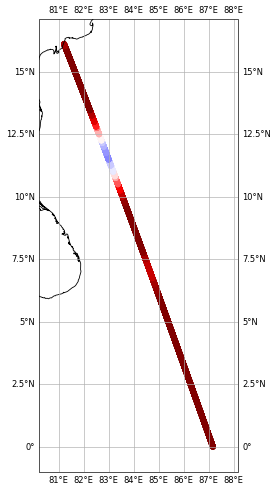

In [54]:
#plot DUACS curve fit trend
dl=1.
extent = [ds_duacs.lon.min()-dl, ds_duacs.lon.max()+dl, ds_duacs.lat.min()-dl, ds_duacs.lat.max()+dl]
cmap_trend = plt.get_cmap('seismic')
fig=plt.figure(figsize=(10,10),dpi=60)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, ccrs.PlateCarree())
ax.scatter(ds_duacs.lon,ds_duacs.lat,c=ds_duacs.Trend,marker='o',cmap=cmap_trend,vmin=0,vmax=5)
ax.coastlines(resolution='10m') 
ax.gridlines(draw_labels=True)
plt.show()